In [65]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import sys
import numpy as np

In [66]:
class SynthDataset():
    
    def __init__(self, N, x_dim=100, num_clusters=10, seed=1234):
        
        np.random.seed(seed)
        
        self.x_dim = x_dim
        self.N = N
        self.true_z_dim = 2
        # generate synthetic data
        self.Xs = []
        for _ in range(num_clusters):
            cluster_mean = np.random.randn(self.true_z_dim) * 5 # to make them more spread
            A = np.random.randn(self.x_dim, self.true_z_dim) * 5
            X = np.dot(np.random.randn(self.N // num_clusters, self.true_z_dim) + cluster_mean,
                       A.T)
            self.Xs.append(X)
        X_raw = np.concatenate(self.Xs)
        self.X = (X_raw - X_raw.mean(0)) / (X_raw.std(0))
        print(self.X.shape)
        
        
    def next_batch(self, batch_size):

        rand_idx = np.random.choice(range(self.N), size=(batch_size,), replace=False)
        return self.X[rand_idx]

synth_d = SynthDataset(10000)

(10000, 100)


In [67]:
def plot_figures(data_trans_real,data_trans_fake,size):    
    xmin1 = np.min(data_trans_real[:, 0]) - 1.0
    xmax1 = np.max(data_trans_real[:, 0]) + 1.0
    xmin2 = np.min(data_trans_real[:, 1]) - 1.0
    xmax2 = np.max(data_trans_real[:, 1]) + 1.0

    fig = plt.figure(figsize=(size,size))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222, sharex=ax1, sharey=ax1)

    ax1.plot(data_trans_real[:, 0], data_trans_real[:, 1], '.r')
    ax1.set_xlim([xmin1, xmax1]); ax1.set_ylim([xmin2, xmax2])
    ax1.set_aspect('equal', adjustable='box')

    ax2.plot(data_trans_fake[:, 0], data_trans_fake[:, 1], '.g')
    ax2.set_xlim([xmin1, xmax1]); ax2.set_ylim([xmin2, xmax2])
    ax2.set_aspect('equal', adjustable='box')
    return fig

In [68]:
class GAN():
    def __init__(self):
        self.N = 10000
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = 100
        self.latent_dim = 100
        self.dropout = 0.99
        lengthscale = 1e-2
        self.reg = lengthscale**2 * (1 - self.dropout) / (2. * self.N )
        
        optimizer = Adam(0.0002, 0.5)
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        self.generator = self.build_generator()

        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        self.discriminator.trainable = False
        validity = self.discriminator(img)
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
    def build_generator(self):        
        noise = Input(shape=(self.latent_dim,))        
        model = Dense(256, activation='relu', kernel_regularizer=l2(self.reg))(noise)
        #model = Dropout(self.dropout)(model, training=True)
        model = Dense(512, activation='relu', kernel_regularizer=l2(self.reg))(model)
        model = Dropout(self.dropout)(model, training=True)
        model = Dense(1024, activation='relu', kernel_regularizer=l2(self.reg))(model)
        model = Dropout(self.dropout)(model, training=True)
        output = Dense(np.prod(self.img_shape), kernel_regularizer=l2(self.reg))(model)
        return Model(noise, output)
    
    def build_discriminator(self):
        img = Input(shape=(self.img_shape,))
        model = Flatten(input_shape=(self.img_shape,))(img)
        model = Dense(512, activation='relu', kernel_regularizer=l2(self.reg))(model)
        #model = Dropout(self.dropout)(model, training=True)
        model = Dense(256, activation='relu', kernel_regularizer=l2(self.reg))(model)
        model = Dropout(self.dropout)(model, training=True)
        output = Dense(1, activation='sigmoid')(model)        
        return Model(img, output)
    
    def train(self, epochs, batch_size=128, sample_interval=50):
        X_train = synth_d.X
        #X_train = np.expand_dims(X_train, axis=3)
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        for epoch in range(epochs):
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            g_loss = self.combined.train_on_batch(noise, valid)
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            if epoch % sample_interval == 0:
               self.sample_images(epoch,batch_size,imgs,gen_imgs)
            
    def sample_images(self, epoch, batch_size,imgs,gen_imgs):
        pca = PCA(2)
        data_trans_real = pca.fit_transform(imgs)    
        data_trans_fake = pca.transform(gen_imgs)
        fig=plot_figures(data_trans_real,data_trans_fake,10)
        fig.savefig("images/%d.png" % epoch)
        plt.show()
        plt.close()
    
    def predict(self, no_samples):
        noise = np.random.normal(0, 1, (10000, self.latent_dim))
        for k in range(no_samples):
            gen_imgs = self.generator.predict(noise)
            pca = PCA(2)
            data_trans_real = pca.fit_transform(synth_d.X)    
            data_trans_fake = pca.transform(gen_imgs)
            fig=plot_figures(data_trans_real,data_trans_fake,10)
            fig.savefig("images/%d.png" % k)
            plt.show()
            plt.close()

0 [D loss: 3.144138, acc.: 34.85%] [G loss: 4.078578]


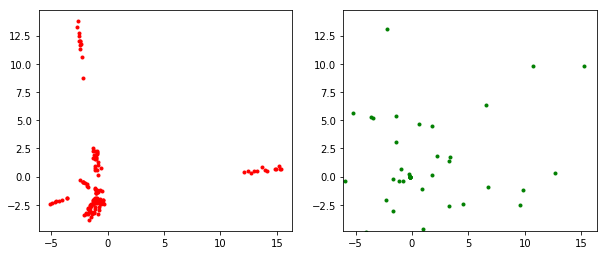

1 [D loss: 2.543930, acc.: 50.76%] [G loss: 4.122310]
2 [D loss: 3.204866, acc.: 46.97%] [G loss: 4.577106]
3 [D loss: 3.400512, acc.: 48.11%] [G loss: 5.213922]
4 [D loss: 2.846645, acc.: 53.41%] [G loss: 4.095160]
5 [D loss: 3.832767, acc.: 46.97%] [G loss: 3.933160]
6 [D loss: 3.579256, acc.: 43.18%] [G loss: 4.293146]
7 [D loss: 3.847458, acc.: 48.11%] [G loss: 3.062237]
8 [D loss: 3.493250, acc.: 46.97%] [G loss: 4.242273]
9 [D loss: 3.485062, acc.: 51.52%] [G loss: 4.355453]
10 [D loss: 3.866461, acc.: 46.21%] [G loss: 4.071885]
11 [D loss: 3.130960, acc.: 48.86%] [G loss: 3.346083]
12 [D loss: 3.243746, acc.: 54.92%] [G loss: 3.471223]
13 [D loss: 2.941313, acc.: 48.11%] [G loss: 3.472824]
14 [D loss: 3.011132, acc.: 50.38%] [G loss: 3.896159]
15 [D loss: 2.907398, acc.: 48.48%] [G loss: 2.879051]
16 [D loss: 3.132658, acc.: 50.00%] [G loss: 4.277335]
17 [D loss: 2.918841, acc.: 56.44%] [G loss: 2.776894]
18 [D loss: 3.034728, acc.: 50.38%] [G loss: 2.714654]
19 [D loss: 2.90179

22 [D loss: 3.580080, acc.: 46.59%] [G loss: 3.799457]
23 [D loss: 2.973523, acc.: 49.62%] [G loss: 3.285093]
24 [D loss: 3.312738, acc.: 51.14%] [G loss: 3.572722]
25 [D loss: 3.245919, acc.: 45.45%] [G loss: 3.181570]
26 [D loss: 2.860121, acc.: 53.79%] [G loss: 3.004323]
27 [D loss: 3.259013, acc.: 44.32%] [G loss: 2.962978]
28 [D loss: 2.769157, acc.: 48.86%] [G loss: 2.942007]
29 [D loss: 2.874879, acc.: 49.24%] [G loss: 3.570682]
30 [D loss: 3.447794, acc.: 47.73%] [G loss: 3.203972]
31 [D loss: 3.005792, acc.: 52.65%] [G loss: 3.138852]
32 [D loss: 2.726695, acc.: 48.86%] [G loss: 3.304520]
33 [D loss: 3.298967, acc.: 50.38%] [G loss: 3.153008]
34 [D loss: 2.860700, acc.: 54.17%] [G loss: 2.915278]
35 [D loss: 2.795438, acc.: 50.38%] [G loss: 2.787399]
36 [D loss: 2.472689, acc.: 51.52%] [G loss: 2.035909]
37 [D loss: 2.401185, acc.: 50.76%] [G loss: 3.416592]
38 [D loss: 3.039048, acc.: 51.89%] [G loss: 2.191855]
39 [D loss: 2.749288, acc.: 56.06%] [G loss: 3.067253]
40 [D loss

44 [D loss: 2.682969, acc.: 50.38%] [G loss: 2.193580]
45 [D loss: 2.673009, acc.: 50.38%] [G loss: 3.445543]
46 [D loss: 2.658360, acc.: 50.38%] [G loss: 3.082361]
47 [D loss: 2.288539, acc.: 52.65%] [G loss: 3.203637]
48 [D loss: 3.022881, acc.: 51.89%] [G loss: 2.821708]
49 [D loss: 2.976343, acc.: 52.27%] [G loss: 3.092937]
50 [D loss: 2.462488, acc.: 49.24%] [G loss: 2.524260]
51 [D loss: 2.918757, acc.: 48.86%] [G loss: 3.303420]
52 [D loss: 2.844680, acc.: 54.17%] [G loss: 3.334015]
53 [D loss: 2.832053, acc.: 49.24%] [G loss: 2.884979]
54 [D loss: 2.759359, acc.: 46.59%] [G loss: 3.583950]
55 [D loss: 2.774475, acc.: 54.92%] [G loss: 3.357505]
56 [D loss: 2.483582, acc.: 48.11%] [G loss: 2.984671]
57 [D loss: 2.457205, acc.: 51.89%] [G loss: 2.677909]
58 [D loss: 2.555412, acc.: 49.24%] [G loss: 2.405955]
59 [D loss: 1.981690, acc.: 54.17%] [G loss: 3.316438]
60 [D loss: 2.364621, acc.: 52.27%] [G loss: 2.112694]
61 [D loss: 2.183642, acc.: 51.89%] [G loss: 3.178031]
62 [D loss

66 [D loss: 1.776449, acc.: 54.17%] [G loss: 2.977219]
67 [D loss: 2.079115, acc.: 56.06%] [G loss: 3.174367]
68 [D loss: 1.697224, acc.: 60.61%] [G loss: 3.058520]
69 [D loss: 1.812771, acc.: 56.44%] [G loss: 3.570926]
70 [D loss: 2.119195, acc.: 54.17%] [G loss: 3.233794]
71 [D loss: 2.188083, acc.: 51.52%] [G loss: 3.039349]
72 [D loss: 2.240472, acc.: 48.11%] [G loss: 3.533535]
73 [D loss: 2.421959, acc.: 52.27%] [G loss: 3.653233]
74 [D loss: 2.772751, acc.: 49.24%] [G loss: 3.017844]
75 [D loss: 2.348931, acc.: 56.06%] [G loss: 3.828699]
76 [D loss: 2.029557, acc.: 54.92%] [G loss: 2.428622]
77 [D loss: 2.329549, acc.: 53.79%] [G loss: 3.022802]
78 [D loss: 2.887709, acc.: 50.38%] [G loss: 2.698202]
79 [D loss: 1.728090, acc.: 52.65%] [G loss: 4.182272]
80 [D loss: 1.674148, acc.: 54.17%] [G loss: 3.020517]
81 [D loss: 1.896484, acc.: 54.55%] [G loss: 3.674095]
82 [D loss: 1.471745, acc.: 55.68%] [G loss: 3.439657]
83 [D loss: 2.080898, acc.: 48.86%] [G loss: 2.962760]
84 [D loss

88 [D loss: 1.813403, acc.: 46.21%] [G loss: 3.575571]
89 [D loss: 2.070915, acc.: 54.92%] [G loss: 3.532132]
90 [D loss: 1.624054, acc.: 56.44%] [G loss: 3.446520]
91 [D loss: 1.660269, acc.: 55.68%] [G loss: 2.438159]
92 [D loss: 1.732157, acc.: 52.65%] [G loss: 3.558624]
93 [D loss: 1.993547, acc.: 55.68%] [G loss: 3.875443]
94 [D loss: 2.114356, acc.: 51.89%] [G loss: 4.081688]
95 [D loss: 0.935385, acc.: 59.09%] [G loss: 2.710961]
96 [D loss: 1.769392, acc.: 51.89%] [G loss: 2.799638]
97 [D loss: 1.591002, acc.: 53.03%] [G loss: 3.284305]
98 [D loss: 1.500261, acc.: 55.30%] [G loss: 3.856041]
99 [D loss: 1.636569, acc.: 54.55%] [G loss: 2.728388]
100 [D loss: 1.580461, acc.: 55.68%] [G loss: 3.400038]
101 [D loss: 1.528795, acc.: 51.89%] [G loss: 3.913818]
102 [D loss: 1.483980, acc.: 49.62%] [G loss: 3.382463]
103 [D loss: 1.789583, acc.: 58.33%] [G loss: 3.068728]
104 [D loss: 1.356728, acc.: 57.58%] [G loss: 3.594983]
105 [D loss: 1.558727, acc.: 54.92%] [G loss: 3.996449]
106 

110 [D loss: 1.459755, acc.: 53.03%] [G loss: 3.779679]
111 [D loss: 1.426926, acc.: 50.38%] [G loss: 3.237264]
112 [D loss: 1.244514, acc.: 54.17%] [G loss: 3.156458]
113 [D loss: 0.981994, acc.: 56.06%] [G loss: 3.893866]
114 [D loss: 1.172162, acc.: 54.55%] [G loss: 2.896398]
115 [D loss: 1.454510, acc.: 58.71%] [G loss: 3.824552]
116 [D loss: 0.968001, acc.: 54.92%] [G loss: 3.160587]
117 [D loss: 1.679151, acc.: 48.48%] [G loss: 4.042911]
118 [D loss: 1.234749, acc.: 52.65%] [G loss: 3.275375]
119 [D loss: 1.418084, acc.: 56.44%] [G loss: 3.586071]
120 [D loss: 1.038481, acc.: 53.79%] [G loss: 3.611081]
121 [D loss: 1.156676, acc.: 53.03%] [G loss: 2.702206]
122 [D loss: 1.518890, acc.: 55.68%] [G loss: 3.374274]
123 [D loss: 1.171612, acc.: 50.00%] [G loss: 3.713577]
124 [D loss: 1.135018, acc.: 62.12%] [G loss: 3.457879]
125 [D loss: 1.305240, acc.: 54.55%] [G loss: 3.053940]
126 [D loss: 1.375388, acc.: 53.79%] [G loss: 2.951713]
127 [D loss: 1.257680, acc.: 52.65%] [G loss: 4.

132 [D loss: 0.896464, acc.: 53.41%] [G loss: 3.539009]
133 [D loss: 0.996604, acc.: 57.95%] [G loss: 2.054470]
134 [D loss: 1.168599, acc.: 53.79%] [G loss: 3.281729]
135 [D loss: 1.703810, acc.: 51.89%] [G loss: 3.226288]
136 [D loss: 1.135808, acc.: 56.82%] [G loss: 3.434055]
137 [D loss: 1.095609, acc.: 54.92%] [G loss: 3.809913]
138 [D loss: 1.028757, acc.: 53.03%] [G loss: 3.282855]
139 [D loss: 0.959004, acc.: 57.58%] [G loss: 2.841895]
140 [D loss: 1.147943, acc.: 56.82%] [G loss: 3.326828]
141 [D loss: 1.324790, acc.: 51.89%] [G loss: 3.228702]
142 [D loss: 1.160204, acc.: 50.00%] [G loss: 4.470997]
143 [D loss: 0.884968, acc.: 48.86%] [G loss: 4.097328]
144 [D loss: 0.996929, acc.: 54.92%] [G loss: 3.475033]
145 [D loss: 1.006342, acc.: 51.89%] [G loss: 3.610036]
146 [D loss: 1.410321, acc.: 57.20%] [G loss: 3.643122]
147 [D loss: 1.155272, acc.: 56.44%] [G loss: 3.384344]
148 [D loss: 1.234576, acc.: 53.03%] [G loss: 3.489925]
149 [D loss: 1.046734, acc.: 55.68%] [G loss: 3.

154 [D loss: 0.731653, acc.: 60.23%] [G loss: 3.279346]
155 [D loss: 1.018401, acc.: 48.11%] [G loss: 3.292074]
156 [D loss: 0.957435, acc.: 57.95%] [G loss: 3.064739]
157 [D loss: 0.869707, acc.: 52.65%] [G loss: 4.609866]
158 [D loss: 0.914044, acc.: 46.59%] [G loss: 3.033513]
159 [D loss: 1.143240, acc.: 55.30%] [G loss: 3.745920]
160 [D loss: 1.129759, acc.: 53.79%] [G loss: 3.729170]
161 [D loss: 0.820400, acc.: 56.44%] [G loss: 3.713923]
162 [D loss: 0.813493, acc.: 57.20%] [G loss: 3.018836]
163 [D loss: 0.947554, acc.: 50.76%] [G loss: 3.084676]
164 [D loss: 0.824461, acc.: 56.06%] [G loss: 3.645602]
165 [D loss: 0.949496, acc.: 51.14%] [G loss: 3.607530]
166 [D loss: 0.874879, acc.: 55.30%] [G loss: 4.054880]
167 [D loss: 0.840099, acc.: 49.62%] [G loss: 2.706805]
168 [D loss: 1.111391, acc.: 54.55%] [G loss: 3.810879]
169 [D loss: 0.864902, acc.: 51.14%] [G loss: 3.123094]
170 [D loss: 0.839896, acc.: 53.79%] [G loss: 3.004941]
171 [D loss: 1.055221, acc.: 58.33%] [G loss: 3.

176 [D loss: 0.847341, acc.: 57.58%] [G loss: 3.068096]
177 [D loss: 0.930725, acc.: 56.44%] [G loss: 3.244959]
178 [D loss: 0.676956, acc.: 54.92%] [G loss: 2.642020]
179 [D loss: 0.846578, acc.: 54.17%] [G loss: 3.520991]
180 [D loss: 0.791329, acc.: 54.55%] [G loss: 3.051322]
181 [D loss: 0.664024, acc.: 54.17%] [G loss: 2.560024]
182 [D loss: 1.072658, acc.: 51.89%] [G loss: 3.975853]
183 [D loss: 0.826532, acc.: 55.30%] [G loss: 3.549341]
184 [D loss: 1.118074, acc.: 52.27%] [G loss: 2.886518]
185 [D loss: 1.000810, acc.: 57.58%] [G loss: 3.918937]
186 [D loss: 0.919575, acc.: 51.52%] [G loss: 2.793298]
187 [D loss: 0.727933, acc.: 57.58%] [G loss: 3.747583]
188 [D loss: 0.845092, acc.: 51.89%] [G loss: 3.541845]
189 [D loss: 0.765623, acc.: 54.92%] [G loss: 3.321725]
190 [D loss: 0.782860, acc.: 52.65%] [G loss: 3.669804]
191 [D loss: 0.951778, acc.: 56.82%] [G loss: 2.901008]
192 [D loss: 1.047884, acc.: 56.44%] [G loss: 2.342090]
193 [D loss: 0.702459, acc.: 58.33%] [G loss: 4.

197 [D loss: 0.607440, acc.: 54.92%] [G loss: 3.448185]
198 [D loss: 0.657611, acc.: 58.33%] [G loss: 2.537372]
199 [D loss: 0.873563, acc.: 57.20%] [G loss: 2.948317]
200 [D loss: 0.861430, acc.: 51.89%] [G loss: 3.089725]
201 [D loss: 0.862176, acc.: 55.30%] [G loss: 3.948506]
202 [D loss: 0.693182, acc.: 62.50%] [G loss: 3.093396]
203 [D loss: 0.859432, acc.: 56.82%] [G loss: 3.113822]
204 [D loss: 0.769640, acc.: 60.61%] [G loss: 2.386328]
205 [D loss: 0.860435, acc.: 53.03%] [G loss: 3.744825]
206 [D loss: 0.857947, acc.: 53.79%] [G loss: 3.216463]
207 [D loss: 0.676930, acc.: 56.06%] [G loss: 2.993026]
208 [D loss: 0.806566, acc.: 58.33%] [G loss: 3.054957]
209 [D loss: 0.993538, acc.: 58.71%] [G loss: 3.338111]
210 [D loss: 0.898491, acc.: 56.82%] [G loss: 2.629532]
211 [D loss: 0.824634, acc.: 52.65%] [G loss: 3.359315]
212 [D loss: 0.789972, acc.: 56.44%] [G loss: 2.979875]
213 [D loss: 0.845225, acc.: 51.52%] [G loss: 2.969019]
214 [D loss: 0.672532, acc.: 55.68%] [G loss: 2.

219 [D loss: 0.779275, acc.: 51.52%] [G loss: 3.200084]
220 [D loss: 0.624526, acc.: 53.41%] [G loss: 3.357059]
221 [D loss: 0.683991, acc.: 56.44%] [G loss: 2.686852]
222 [D loss: 0.923649, acc.: 51.14%] [G loss: 2.966677]
223 [D loss: 0.818794, acc.: 59.09%] [G loss: 3.311590]
224 [D loss: 0.793795, acc.: 56.44%] [G loss: 3.035872]
225 [D loss: 0.609538, acc.: 55.30%] [G loss: 3.436155]
226 [D loss: 0.904524, acc.: 50.00%] [G loss: 3.235409]
227 [D loss: 0.780881, acc.: 49.24%] [G loss: 2.153580]
228 [D loss: 0.706985, acc.: 58.33%] [G loss: 3.142256]
229 [D loss: 0.705428, acc.: 54.17%] [G loss: 3.262351]
230 [D loss: 0.981923, acc.: 53.79%] [G loss: 2.808099]
231 [D loss: 0.794615, acc.: 55.30%] [G loss: 3.311699]
232 [D loss: 0.693681, acc.: 51.14%] [G loss: 2.778142]
233 [D loss: 0.701579, acc.: 52.65%] [G loss: 2.673880]
234 [D loss: 0.842917, acc.: 54.92%] [G loss: 3.304841]
235 [D loss: 0.672051, acc.: 52.27%] [G loss: 2.945255]
236 [D loss: 0.876942, acc.: 51.52%] [G loss: 2.

241 [D loss: 0.806114, acc.: 53.41%] [G loss: 3.455408]
242 [D loss: 0.754823, acc.: 48.48%] [G loss: 2.484560]
243 [D loss: 0.647812, acc.: 57.58%] [G loss: 1.739338]
244 [D loss: 0.641451, acc.: 53.41%] [G loss: 3.441225]
245 [D loss: 0.651790, acc.: 54.92%] [G loss: 2.597558]
246 [D loss: 0.745864, acc.: 49.62%] [G loss: 2.857738]
247 [D loss: 0.688879, acc.: 51.52%] [G loss: 3.168299]
248 [D loss: 0.840325, acc.: 53.79%] [G loss: 3.174966]
249 [D loss: 0.819084, acc.: 49.62%] [G loss: 2.070465]
250 [D loss: 0.723962, acc.: 55.68%] [G loss: 2.331921]
251 [D loss: 0.700582, acc.: 53.03%] [G loss: 2.493735]
252 [D loss: 0.635116, acc.: 55.30%] [G loss: 3.220337]
253 [D loss: 0.741869, acc.: 52.65%] [G loss: 2.541335]
254 [D loss: 0.727517, acc.: 55.68%] [G loss: 3.546002]
255 [D loss: 0.669498, acc.: 55.68%] [G loss: 2.326492]
256 [D loss: 0.832111, acc.: 50.76%] [G loss: 3.176751]
257 [D loss: 0.735749, acc.: 58.71%] [G loss: 2.332859]
258 [D loss: 0.798575, acc.: 57.58%] [G loss: 2.

262 [D loss: 0.610178, acc.: 53.79%] [G loss: 2.379642]
263 [D loss: 0.686637, acc.: 54.17%] [G loss: 3.281057]
264 [D loss: 0.603939, acc.: 59.09%] [G loss: 3.771356]
265 [D loss: 0.728519, acc.: 52.27%] [G loss: 3.382167]
266 [D loss: 0.616409, acc.: 56.44%] [G loss: 2.853549]
267 [D loss: 0.691997, acc.: 53.79%] [G loss: 2.834624]
268 [D loss: 0.633968, acc.: 54.92%] [G loss: 2.635871]
269 [D loss: 0.643048, acc.: 56.82%] [G loss: 2.583828]
270 [D loss: 0.695251, acc.: 51.89%] [G loss: 3.277427]
271 [D loss: 0.840483, acc.: 58.71%] [G loss: 3.427257]
272 [D loss: 0.808007, acc.: 56.06%] [G loss: 3.096729]
273 [D loss: 0.667905, acc.: 59.09%] [G loss: 2.546633]
274 [D loss: 0.664816, acc.: 57.20%] [G loss: 3.625011]
275 [D loss: 0.612005, acc.: 56.44%] [G loss: 2.540076]
276 [D loss: 0.639321, acc.: 51.89%] [G loss: 2.436850]
277 [D loss: 0.658680, acc.: 56.44%] [G loss: 2.632918]
278 [D loss: 0.598041, acc.: 58.33%] [G loss: 2.567771]
279 [D loss: 0.696951, acc.: 56.44%] [G loss: 2.

284 [D loss: 0.700655, acc.: 54.92%] [G loss: 3.156268]
285 [D loss: 0.726193, acc.: 57.58%] [G loss: 2.501633]
286 [D loss: 0.722523, acc.: 49.62%] [G loss: 2.741447]
287 [D loss: 0.674908, acc.: 58.71%] [G loss: 2.743016]
288 [D loss: 0.870190, acc.: 58.71%] [G loss: 2.286611]
289 [D loss: 0.690306, acc.: 53.41%] [G loss: 2.146659]
290 [D loss: 0.607290, acc.: 57.20%] [G loss: 2.537076]
291 [D loss: 0.698050, acc.: 54.55%] [G loss: 2.721832]
292 [D loss: 0.673944, acc.: 57.20%] [G loss: 2.938540]
293 [D loss: 0.644965, acc.: 54.92%] [G loss: 2.815232]
294 [D loss: 0.625095, acc.: 51.89%] [G loss: 2.970320]
295 [D loss: 0.822300, acc.: 52.65%] [G loss: 2.493284]
296 [D loss: 0.679438, acc.: 55.68%] [G loss: 2.600022]
297 [D loss: 0.807727, acc.: 56.06%] [G loss: 2.840787]
298 [D loss: 0.685250, acc.: 57.58%] [G loss: 2.507874]
299 [D loss: 0.632799, acc.: 53.79%] [G loss: 2.579746]
300 [D loss: 0.652866, acc.: 54.17%] [G loss: 2.934290]
301 [D loss: 0.609165, acc.: 54.92%] [G loss: 2.

306 [D loss: 0.645602, acc.: 57.58%] [G loss: 2.108408]
307 [D loss: 0.707332, acc.: 58.33%] [G loss: 2.184076]
308 [D loss: 0.663545, acc.: 55.30%] [G loss: 2.736779]
309 [D loss: 0.624813, acc.: 55.68%] [G loss: 1.892462]
310 [D loss: 0.591255, acc.: 57.58%] [G loss: 2.166016]
311 [D loss: 0.741999, acc.: 56.82%] [G loss: 2.501225]
312 [D loss: 0.645297, acc.: 54.55%] [G loss: 2.471692]
313 [D loss: 0.682448, acc.: 53.03%] [G loss: 2.803111]
314 [D loss: 0.709008, acc.: 51.52%] [G loss: 1.941855]
315 [D loss: 0.641267, acc.: 53.03%] [G loss: 2.663002]
316 [D loss: 0.631666, acc.: 53.79%] [G loss: 2.814213]
317 [D loss: 0.710473, acc.: 53.03%] [G loss: 2.563279]
318 [D loss: 0.661918, acc.: 55.30%] [G loss: 2.521021]
319 [D loss: 0.772325, acc.: 54.55%] [G loss: 2.707174]
320 [D loss: 0.681256, acc.: 54.55%] [G loss: 1.965806]
321 [D loss: 0.668608, acc.: 56.06%] [G loss: 2.847459]
322 [D loss: 0.594475, acc.: 57.58%] [G loss: 2.567422]
323 [D loss: 0.624569, acc.: 54.17%] [G loss: 1.

328 [D loss: 0.713077, acc.: 50.76%] [G loss: 1.935160]
329 [D loss: 0.610856, acc.: 59.09%] [G loss: 1.927092]
330 [D loss: 0.746823, acc.: 54.55%] [G loss: 2.515642]
331 [D loss: 0.702500, acc.: 51.14%] [G loss: 2.632533]
332 [D loss: 0.749392, acc.: 52.27%] [G loss: 2.635761]
333 [D loss: 0.681193, acc.: 54.92%] [G loss: 2.678054]
334 [D loss: 0.690252, acc.: 51.52%] [G loss: 2.253667]
335 [D loss: 0.596714, acc.: 60.23%] [G loss: 2.272179]
336 [D loss: 0.651177, acc.: 54.55%] [G loss: 2.135423]
337 [D loss: 0.716427, acc.: 54.17%] [G loss: 3.219122]
338 [D loss: 0.659388, acc.: 53.79%] [G loss: 2.670577]
339 [D loss: 0.641429, acc.: 51.14%] [G loss: 2.435619]
340 [D loss: 0.638077, acc.: 55.30%] [G loss: 2.300566]
341 [D loss: 0.733922, acc.: 56.06%] [G loss: 2.866025]
342 [D loss: 0.632236, acc.: 50.76%] [G loss: 2.350796]
343 [D loss: 0.640048, acc.: 55.68%] [G loss: 2.430787]
344 [D loss: 0.631704, acc.: 53.79%] [G loss: 2.153365]
345 [D loss: 0.645644, acc.: 54.55%] [G loss: 2.

350 [D loss: 0.614855, acc.: 54.17%] [G loss: 2.408925]
351 [D loss: 0.749825, acc.: 56.44%] [G loss: 2.277150]
352 [D loss: 0.645784, acc.: 55.68%] [G loss: 2.303889]
353 [D loss: 0.654596, acc.: 57.20%] [G loss: 1.883824]
354 [D loss: 0.692982, acc.: 53.41%] [G loss: 2.004459]
355 [D loss: 0.620998, acc.: 56.06%] [G loss: 1.892296]
356 [D loss: 0.657204, acc.: 53.79%] [G loss: 1.877231]
357 [D loss: 0.624818, acc.: 54.17%] [G loss: 1.930904]
358 [D loss: 0.679201, acc.: 54.55%] [G loss: 3.064057]
359 [D loss: 0.763211, acc.: 49.24%] [G loss: 2.428274]
360 [D loss: 0.632239, acc.: 54.17%] [G loss: 2.195632]
361 [D loss: 0.686241, acc.: 54.92%] [G loss: 1.998032]
362 [D loss: 0.637935, acc.: 51.52%] [G loss: 1.825371]
363 [D loss: 0.631973, acc.: 54.92%] [G loss: 2.253073]
364 [D loss: 0.662156, acc.: 53.41%] [G loss: 2.764959]
365 [D loss: 0.681604, acc.: 59.47%] [G loss: 1.775256]
366 [D loss: 0.712002, acc.: 51.89%] [G loss: 2.248193]
367 [D loss: 0.710549, acc.: 54.92%] [G loss: 2.

371 [D loss: 0.693806, acc.: 53.03%] [G loss: 1.605095]
372 [D loss: 0.630741, acc.: 57.20%] [G loss: 1.768297]
373 [D loss: 0.747538, acc.: 51.52%] [G loss: 1.732109]
374 [D loss: 0.637814, acc.: 55.68%] [G loss: 2.056292]
375 [D loss: 0.621818, acc.: 54.55%] [G loss: 1.994038]
376 [D loss: 0.724079, acc.: 55.30%] [G loss: 1.845820]
377 [D loss: 0.676335, acc.: 53.03%] [G loss: 1.926436]
378 [D loss: 0.648090, acc.: 52.65%] [G loss: 2.207752]
379 [D loss: 0.641125, acc.: 51.14%] [G loss: 2.841216]
380 [D loss: 0.684196, acc.: 53.41%] [G loss: 1.479769]
381 [D loss: 0.636609, acc.: 54.17%] [G loss: 2.014229]
382 [D loss: 0.640200, acc.: 54.92%] [G loss: 1.948369]
383 [D loss: 0.625647, acc.: 53.03%] [G loss: 2.277495]
384 [D loss: 0.675810, acc.: 51.89%] [G loss: 2.143407]
385 [D loss: 0.673588, acc.: 53.03%] [G loss: 1.853461]
386 [D loss: 0.630183, acc.: 53.41%] [G loss: 2.267853]
387 [D loss: 0.639151, acc.: 51.14%] [G loss: 2.311631]
388 [D loss: 0.622138, acc.: 54.17%] [G loss: 1.

393 [D loss: 0.645005, acc.: 50.76%] [G loss: 2.203648]
394 [D loss: 0.643227, acc.: 48.86%] [G loss: 1.966239]
395 [D loss: 0.701766, acc.: 51.89%] [G loss: 2.040355]
396 [D loss: 0.716400, acc.: 51.89%] [G loss: 2.821681]
397 [D loss: 0.635250, acc.: 50.76%] [G loss: 3.119843]
398 [D loss: 0.602225, acc.: 62.12%] [G loss: 2.051358]
399 [D loss: 0.622027, acc.: 55.68%] [G loss: 1.511171]
400 [D loss: 0.688242, acc.: 55.68%] [G loss: 2.408431]
401 [D loss: 0.679294, acc.: 55.30%] [G loss: 1.981840]
402 [D loss: 0.740386, acc.: 53.79%] [G loss: 2.123094]
403 [D loss: 0.641831, acc.: 49.62%] [G loss: 2.168530]
404 [D loss: 0.633712, acc.: 56.82%] [G loss: 2.078900]
405 [D loss: 0.644425, acc.: 52.65%] [G loss: 2.737379]
406 [D loss: 0.668509, acc.: 51.52%] [G loss: 1.569708]
407 [D loss: 0.624014, acc.: 54.92%] [G loss: 2.191405]
408 [D loss: 0.615451, acc.: 56.06%] [G loss: 1.816602]
409 [D loss: 0.623626, acc.: 56.06%] [G loss: 1.676465]
410 [D loss: 0.663092, acc.: 57.58%] [G loss: 1.

414 [D loss: 0.726733, acc.: 51.89%] [G loss: 2.000791]
415 [D loss: 0.648008, acc.: 50.76%] [G loss: 1.702289]
416 [D loss: 0.765050, acc.: 53.41%] [G loss: 1.463676]
417 [D loss: 0.633073, acc.: 56.06%] [G loss: 1.874135]
418 [D loss: 0.808774, acc.: 50.00%] [G loss: 1.889532]
419 [D loss: 0.713949, acc.: 54.17%] [G loss: 2.255790]
420 [D loss: 0.643314, acc.: 51.52%] [G loss: 1.642447]
421 [D loss: 0.655639, acc.: 49.24%] [G loss: 1.361600]
422 [D loss: 0.677053, acc.: 52.65%] [G loss: 2.273920]
423 [D loss: 0.655099, acc.: 50.38%] [G loss: 2.067721]
424 [D loss: 0.639221, acc.: 50.38%] [G loss: 1.917084]
425 [D loss: 0.624592, acc.: 51.89%] [G loss: 2.227636]
426 [D loss: 0.689295, acc.: 53.41%] [G loss: 1.993487]
427 [D loss: 0.638421, acc.: 55.68%] [G loss: 1.808697]
428 [D loss: 0.645882, acc.: 56.06%] [G loss: 2.466360]
429 [D loss: 0.607302, acc.: 55.68%] [G loss: 1.629448]
430 [D loss: 0.613864, acc.: 51.89%] [G loss: 1.793891]
431 [D loss: 0.699986, acc.: 51.89%] [G loss: 1.

436 [D loss: 0.646688, acc.: 51.89%] [G loss: 2.210855]
437 [D loss: 0.671147, acc.: 53.41%] [G loss: 1.429538]
438 [D loss: 0.613375, acc.: 57.58%] [G loss: 1.526344]
439 [D loss: 0.631289, acc.: 53.79%] [G loss: 1.886195]
440 [D loss: 0.648075, acc.: 50.00%] [G loss: 1.775600]
441 [D loss: 0.635988, acc.: 54.17%] [G loss: 1.730922]
442 [D loss: 0.664854, acc.: 52.27%] [G loss: 1.571368]
443 [D loss: 0.660331, acc.: 47.35%] [G loss: 1.383480]
444 [D loss: 0.724535, acc.: 52.65%] [G loss: 1.387821]
445 [D loss: 0.692913, acc.: 52.65%] [G loss: 1.520015]
446 [D loss: 0.638467, acc.: 54.55%] [G loss: 1.369307]
447 [D loss: 0.710550, acc.: 51.89%] [G loss: 2.123424]
448 [D loss: 0.645104, acc.: 50.38%] [G loss: 1.519840]
449 [D loss: 0.628705, acc.: 54.55%] [G loss: 2.063855]
450 [D loss: 0.652792, acc.: 52.27%] [G loss: 1.934533]
451 [D loss: 0.667900, acc.: 50.00%] [G loss: 2.072050]
452 [D loss: 0.624312, acc.: 53.79%] [G loss: 1.259734]
453 [D loss: 0.730551, acc.: 53.79%] [G loss: 1.

458 [D loss: 0.667130, acc.: 52.27%] [G loss: 1.662937]
459 [D loss: 0.627676, acc.: 56.06%] [G loss: 1.281256]
460 [D loss: 0.636334, acc.: 56.06%] [G loss: 1.610851]
461 [D loss: 0.613392, acc.: 58.33%] [G loss: 1.733341]
462 [D loss: 0.628002, acc.: 56.44%] [G loss: 1.784146]
463 [D loss: 0.628722, acc.: 52.65%] [G loss: 1.690858]
464 [D loss: 0.633465, acc.: 50.38%] [G loss: 2.080799]
465 [D loss: 0.699687, acc.: 52.27%] [G loss: 1.485806]
466 [D loss: 0.616107, acc.: 58.71%] [G loss: 1.390218]
467 [D loss: 0.647600, acc.: 50.38%] [G loss: 1.915199]
468 [D loss: 0.634749, acc.: 55.30%] [G loss: 1.346828]
469 [D loss: 0.649834, acc.: 56.06%] [G loss: 2.163670]
470 [D loss: 0.700825, acc.: 54.17%] [G loss: 1.988078]
471 [D loss: 0.638586, acc.: 53.03%] [G loss: 1.853219]
472 [D loss: 0.644249, acc.: 54.55%] [G loss: 2.143094]
473 [D loss: 0.637939, acc.: 56.06%] [G loss: 1.979185]
474 [D loss: 0.618916, acc.: 58.33%] [G loss: 1.893857]
475 [D loss: 0.636195, acc.: 53.03%] [G loss: 1.

480 [D loss: 0.637145, acc.: 53.03%] [G loss: 2.183557]
481 [D loss: 0.627653, acc.: 57.58%] [G loss: 1.727751]
482 [D loss: 0.650218, acc.: 53.03%] [G loss: 1.154714]
483 [D loss: 0.644270, acc.: 56.06%] [G loss: 1.448088]
484 [D loss: 0.701361, acc.: 51.14%] [G loss: 2.285961]
485 [D loss: 0.630232, acc.: 56.44%] [G loss: 1.538810]
486 [D loss: 0.634676, acc.: 55.68%] [G loss: 1.892929]
487 [D loss: 0.619231, acc.: 57.58%] [G loss: 1.329431]
488 [D loss: 0.648998, acc.: 52.27%] [G loss: 1.641062]
489 [D loss: 0.631065, acc.: 54.92%] [G loss: 1.356187]
490 [D loss: 0.630049, acc.: 54.55%] [G loss: 1.072338]
491 [D loss: 0.635499, acc.: 55.68%] [G loss: 1.671769]
492 [D loss: 0.662681, acc.: 56.82%] [G loss: 1.673949]
493 [D loss: 0.642688, acc.: 54.92%] [G loss: 0.957316]
494 [D loss: 0.594857, acc.: 60.23%] [G loss: 1.723381]
495 [D loss: 0.650972, acc.: 54.92%] [G loss: 1.684203]
496 [D loss: 0.628313, acc.: 57.20%] [G loss: 1.058948]
497 [D loss: 0.617553, acc.: 57.20%] [G loss: 0.

502 [D loss: 0.657984, acc.: 52.65%] [G loss: 1.234742]
503 [D loss: 0.642069, acc.: 54.55%] [G loss: 1.414212]
504 [D loss: 0.638430, acc.: 54.17%] [G loss: 1.381551]
505 [D loss: 0.742842, acc.: 54.92%] [G loss: 1.932196]
506 [D loss: 0.632591, acc.: 54.92%] [G loss: 1.810582]
507 [D loss: 0.689721, acc.: 51.52%] [G loss: 2.232203]
508 [D loss: 0.649177, acc.: 51.52%] [G loss: 1.571859]
509 [D loss: 0.626741, acc.: 60.23%] [G loss: 1.372046]
510 [D loss: 0.649429, acc.: 53.41%] [G loss: 1.664136]
511 [D loss: 0.694947, acc.: 55.68%] [G loss: 1.819899]
512 [D loss: 0.706491, acc.: 56.44%] [G loss: 1.017569]
513 [D loss: 0.639959, acc.: 54.55%] [G loss: 1.630930]
514 [D loss: 0.615188, acc.: 60.98%] [G loss: 1.600820]
515 [D loss: 0.620280, acc.: 56.82%] [G loss: 0.954675]
516 [D loss: 0.636113, acc.: 57.58%] [G loss: 1.578029]
517 [D loss: 0.651304, acc.: 54.17%] [G loss: 1.716076]
518 [D loss: 0.633406, acc.: 57.20%] [G loss: 1.764747]
519 [D loss: 0.637483, acc.: 56.44%] [G loss: 1.

524 [D loss: 0.630444, acc.: 56.82%] [G loss: 1.062501]
525 [D loss: 0.657575, acc.: 54.92%] [G loss: 1.507623]
526 [D loss: 0.645860, acc.: 53.79%] [G loss: 1.322562]
527 [D loss: 0.646759, acc.: 54.17%] [G loss: 1.411606]
528 [D loss: 0.624781, acc.: 58.33%] [G loss: 1.801509]
529 [D loss: 0.641040, acc.: 59.47%] [G loss: 1.583058]
530 [D loss: 0.631275, acc.: 57.20%] [G loss: 1.199610]
531 [D loss: 0.651894, acc.: 56.44%] [G loss: 2.110432]
532 [D loss: 0.658530, acc.: 53.79%] [G loss: 1.231029]
533 [D loss: 0.631923, acc.: 55.30%] [G loss: 1.270315]
534 [D loss: 0.646206, acc.: 53.03%] [G loss: 1.342063]
535 [D loss: 0.642331, acc.: 56.06%] [G loss: 1.090629]
536 [D loss: 0.691975, acc.: 56.82%] [G loss: 1.627767]
537 [D loss: 0.627329, acc.: 58.71%] [G loss: 0.945059]
538 [D loss: 0.728846, acc.: 55.68%] [G loss: 1.110323]
539 [D loss: 0.634293, acc.: 60.23%] [G loss: 1.158342]
540 [D loss: 0.613694, acc.: 58.71%] [G loss: 1.127377]
541 [D loss: 0.659124, acc.: 51.14%] [G loss: 1.

546 [D loss: 0.626779, acc.: 59.09%] [G loss: 1.480525]
547 [D loss: 0.628346, acc.: 57.20%] [G loss: 1.389226]
548 [D loss: 0.658877, acc.: 54.92%] [G loss: 1.517328]
549 [D loss: 0.623076, acc.: 57.20%] [G loss: 1.324486]
550 [D loss: 0.669538, acc.: 54.92%] [G loss: 1.472377]
551 [D loss: 0.633337, acc.: 55.30%] [G loss: 1.851649]
552 [D loss: 0.625011, acc.: 59.09%] [G loss: 0.941595]
553 [D loss: 0.641784, acc.: 56.06%] [G loss: 1.713440]
554 [D loss: 0.654930, acc.: 55.30%] [G loss: 1.642272]
555 [D loss: 0.620929, acc.: 59.47%] [G loss: 1.347678]
556 [D loss: 0.650371, acc.: 53.79%] [G loss: 1.194862]
557 [D loss: 0.622398, acc.: 59.47%] [G loss: 1.351175]
558 [D loss: 0.650307, acc.: 55.68%] [G loss: 1.016084]
559 [D loss: 0.624116, acc.: 57.20%] [G loss: 1.254148]
560 [D loss: 0.640061, acc.: 56.44%] [G loss: 1.024105]
561 [D loss: 0.613520, acc.: 59.85%] [G loss: 1.391223]
562 [D loss: 0.639758, acc.: 56.06%] [G loss: 1.349016]
563 [D loss: 0.644265, acc.: 57.58%] [G loss: 1.

568 [D loss: 0.635440, acc.: 60.23%] [G loss: 1.658181]
569 [D loss: 0.632762, acc.: 55.30%] [G loss: 1.832152]
570 [D loss: 0.653355, acc.: 57.58%] [G loss: 1.954909]
571 [D loss: 0.640157, acc.: 54.55%] [G loss: 1.253590]
572 [D loss: 0.695888, acc.: 55.30%] [G loss: 1.270957]
573 [D loss: 0.693091, acc.: 57.95%] [G loss: 1.104008]
574 [D loss: 0.646679, acc.: 54.92%] [G loss: 1.188787]
575 [D loss: 0.623730, acc.: 57.95%] [G loss: 1.384252]
576 [D loss: 0.639199, acc.: 55.30%] [G loss: 1.560709]
577 [D loss: 0.629641, acc.: 56.06%] [G loss: 0.750297]
578 [D loss: 0.648314, acc.: 54.55%] [G loss: 1.094310]
579 [D loss: 0.646370, acc.: 55.68%] [G loss: 1.268197]
580 [D loss: 0.620498, acc.: 57.58%] [G loss: 1.224818]
581 [D loss: 0.642905, acc.: 50.38%] [G loss: 1.361357]
582 [D loss: 0.637400, acc.: 54.55%] [G loss: 1.249247]
583 [D loss: 0.636491, acc.: 58.33%] [G loss: 1.061616]
584 [D loss: 0.614559, acc.: 58.71%] [G loss: 1.003455]
585 [D loss: 0.648556, acc.: 56.06%] [G loss: 1.

590 [D loss: 0.629606, acc.: 56.06%] [G loss: 1.067748]
591 [D loss: 0.689517, acc.: 54.92%] [G loss: 2.027059]
592 [D loss: 0.709973, acc.: 60.23%] [G loss: 0.913987]
593 [D loss: 0.715146, acc.: 57.20%] [G loss: 1.187326]
594 [D loss: 0.642066, acc.: 57.95%] [G loss: 1.370237]
595 [D loss: 0.656964, acc.: 57.20%] [G loss: 1.137627]
596 [D loss: 0.627728, acc.: 56.44%] [G loss: 1.122980]
597 [D loss: 0.595266, acc.: 63.64%] [G loss: 1.343377]
598 [D loss: 0.662088, acc.: 55.68%] [G loss: 1.294958]
599 [D loss: 0.624220, acc.: 59.47%] [G loss: 1.175900]
600 [D loss: 0.639088, acc.: 57.95%] [G loss: 1.260269]
601 [D loss: 0.645827, acc.: 56.82%] [G loss: 1.125370]
602 [D loss: 0.630571, acc.: 62.12%] [G loss: 1.883038]
603 [D loss: 0.631698, acc.: 59.47%] [G loss: 1.446189]
604 [D loss: 0.617493, acc.: 58.71%] [G loss: 0.989812]
605 [D loss: 0.629674, acc.: 57.58%] [G loss: 1.087837]
606 [D loss: 0.633051, acc.: 59.09%] [G loss: 1.834325]
607 [D loss: 0.629695, acc.: 55.30%] [G loss: 1.

612 [D loss: 0.645388, acc.: 59.09%] [G loss: 1.565124]
613 [D loss: 0.628956, acc.: 61.74%] [G loss: 1.484181]
614 [D loss: 0.622126, acc.: 59.09%] [G loss: 1.802938]
615 [D loss: 0.626211, acc.: 58.71%] [G loss: 1.216502]
616 [D loss: 0.627928, acc.: 58.71%] [G loss: 0.964553]
617 [D loss: 0.627335, acc.: 58.71%] [G loss: 0.993001]
618 [D loss: 0.636510, acc.: 60.61%] [G loss: 1.359793]
619 [D loss: 0.626498, acc.: 61.36%] [G loss: 1.828395]
620 [D loss: 0.667821, acc.: 57.95%] [G loss: 1.776028]
621 [D loss: 0.625630, acc.: 59.09%] [G loss: 1.164511]
622 [D loss: 0.645542, acc.: 56.82%] [G loss: 1.371076]
623 [D loss: 0.632213, acc.: 57.20%] [G loss: 1.156861]
624 [D loss: 0.671845, acc.: 60.61%] [G loss: 1.312606]
625 [D loss: 0.688875, acc.: 58.71%] [G loss: 1.577864]
626 [D loss: 0.643585, acc.: 55.68%] [G loss: 1.703525]
627 [D loss: 0.652786, acc.: 56.44%] [G loss: 1.158334]
628 [D loss: 0.640112, acc.: 59.85%] [G loss: 1.407642]
629 [D loss: 0.634385, acc.: 60.61%] [G loss: 1.

634 [D loss: 0.648015, acc.: 55.68%] [G loss: 1.215908]
635 [D loss: 0.687098, acc.: 60.98%] [G loss: 1.306483]
636 [D loss: 0.615877, acc.: 62.88%] [G loss: 1.343625]
637 [D loss: 0.612358, acc.: 61.36%] [G loss: 1.598848]
638 [D loss: 0.607042, acc.: 61.36%] [G loss: 1.372109]
639 [D loss: 0.626155, acc.: 57.95%] [G loss: 1.194824]
640 [D loss: 0.635082, acc.: 57.95%] [G loss: 0.953921]
641 [D loss: 0.635346, acc.: 55.30%] [G loss: 1.138609]
642 [D loss: 0.618688, acc.: 62.50%] [G loss: 1.171687]
643 [D loss: 0.632167, acc.: 57.20%] [G loss: 1.219793]
644 [D loss: 0.633098, acc.: 57.95%] [G loss: 1.341962]
645 [D loss: 0.640118, acc.: 53.03%] [G loss: 1.208329]
646 [D loss: 0.641671, acc.: 54.92%] [G loss: 1.003532]
647 [D loss: 0.629742, acc.: 59.47%] [G loss: 1.012188]
648 [D loss: 0.641959, acc.: 58.71%] [G loss: 1.601068]
649 [D loss: 0.616684, acc.: 59.85%] [G loss: 1.334588]
650 [D loss: 0.676777, acc.: 58.71%] [G loss: 0.813965]
651 [D loss: 0.646361, acc.: 55.30%] [G loss: 1.

656 [D loss: 0.646660, acc.: 56.82%] [G loss: 0.986862]
657 [D loss: 0.626207, acc.: 60.23%] [G loss: 1.072779]
658 [D loss: 0.623810, acc.: 60.98%] [G loss: 1.370639]
659 [D loss: 0.633680, acc.: 60.61%] [G loss: 1.160946]
660 [D loss: 0.684241, acc.: 57.58%] [G loss: 1.042221]
661 [D loss: 0.610788, acc.: 62.50%] [G loss: 1.352916]
662 [D loss: 0.615168, acc.: 60.98%] [G loss: 1.029995]
663 [D loss: 0.618495, acc.: 61.36%] [G loss: 1.348555]
664 [D loss: 0.618903, acc.: 64.39%] [G loss: 1.651730]
665 [D loss: 0.626264, acc.: 60.23%] [G loss: 0.920612]
666 [D loss: 0.603566, acc.: 59.85%] [G loss: 1.052840]
667 [D loss: 0.642162, acc.: 54.55%] [G loss: 1.557100]
668 [D loss: 0.644565, acc.: 60.23%] [G loss: 1.229602]
669 [D loss: 0.616933, acc.: 59.47%] [G loss: 1.411011]
670 [D loss: 0.612480, acc.: 62.88%] [G loss: 1.116622]
671 [D loss: 0.626208, acc.: 59.09%] [G loss: 1.225516]
672 [D loss: 0.622854, acc.: 60.98%] [G loss: 1.337277]
673 [D loss: 0.676151, acc.: 60.23%] [G loss: 1.

678 [D loss: 0.636123, acc.: 61.74%] [G loss: 1.100437]
679 [D loss: 0.622146, acc.: 62.12%] [G loss: 1.442889]
680 [D loss: 0.660446, acc.: 59.85%] [G loss: 1.232747]
681 [D loss: 0.612317, acc.: 59.85%] [G loss: 1.532974]
682 [D loss: 0.620089, acc.: 60.98%] [G loss: 1.184446]
683 [D loss: 0.622639, acc.: 61.36%] [G loss: 1.301603]
684 [D loss: 0.619447, acc.: 60.61%] [G loss: 1.319926]
685 [D loss: 0.630103, acc.: 62.12%] [G loss: 1.130774]
686 [D loss: 0.637360, acc.: 57.20%] [G loss: 1.386681]
687 [D loss: 0.599901, acc.: 62.12%] [G loss: 1.266977]
688 [D loss: 0.624644, acc.: 58.33%] [G loss: 1.437663]
689 [D loss: 0.611336, acc.: 62.12%] [G loss: 1.009551]
690 [D loss: 0.624126, acc.: 60.61%] [G loss: 0.909994]
691 [D loss: 0.625693, acc.: 60.61%] [G loss: 1.009317]
692 [D loss: 0.626446, acc.: 57.20%] [G loss: 1.029873]
693 [D loss: 0.633443, acc.: 59.09%] [G loss: 1.150110]
694 [D loss: 0.611459, acc.: 64.39%] [G loss: 1.150949]
695 [D loss: 0.621621, acc.: 60.23%] [G loss: 1.

700 [D loss: 0.623192, acc.: 60.23%] [G loss: 1.290335]
701 [D loss: 0.633774, acc.: 58.33%] [G loss: 1.561098]
702 [D loss: 0.597783, acc.: 63.64%] [G loss: 1.030896]
703 [D loss: 0.671762, acc.: 64.77%] [G loss: 1.102928]
704 [D loss: 0.612047, acc.: 62.50%] [G loss: 1.561498]
705 [D loss: 0.636662, acc.: 58.71%] [G loss: 1.133039]
706 [D loss: 0.630045, acc.: 59.47%] [G loss: 0.996244]
707 [D loss: 0.685274, acc.: 58.33%] [G loss: 1.150291]
708 [D loss: 0.607697, acc.: 64.02%] [G loss: 1.262312]
709 [D loss: 0.612496, acc.: 60.98%] [G loss: 1.401857]
710 [D loss: 0.619443, acc.: 61.74%] [G loss: 1.225010]
711 [D loss: 0.613046, acc.: 60.61%] [G loss: 1.190441]
712 [D loss: 0.681141, acc.: 61.36%] [G loss: 1.116899]
713 [D loss: 0.602213, acc.: 67.80%] [G loss: 1.339626]
714 [D loss: 0.609303, acc.: 59.09%] [G loss: 1.095310]
715 [D loss: 0.660339, acc.: 60.98%] [G loss: 1.197370]
716 [D loss: 0.626767, acc.: 60.23%] [G loss: 1.241323]
717 [D loss: 0.623807, acc.: 59.85%] [G loss: 1.

722 [D loss: 0.619838, acc.: 60.61%] [G loss: 1.612175]
723 [D loss: 0.594487, acc.: 63.64%] [G loss: 1.289022]
724 [D loss: 0.600173, acc.: 61.74%] [G loss: 1.275329]
725 [D loss: 0.610675, acc.: 62.50%] [G loss: 0.926424]
726 [D loss: 0.641898, acc.: 62.50%] [G loss: 1.253108]
727 [D loss: 0.608442, acc.: 62.88%] [G loss: 1.543527]
728 [D loss: 0.619365, acc.: 62.12%] [G loss: 1.271911]
729 [D loss: 0.635175, acc.: 59.85%] [G loss: 1.228426]
730 [D loss: 0.613518, acc.: 63.64%] [G loss: 1.248001]
731 [D loss: 0.617813, acc.: 59.85%] [G loss: 1.162555]
732 [D loss: 0.602263, acc.: 61.36%] [G loss: 1.028206]
733 [D loss: 0.618726, acc.: 62.88%] [G loss: 0.947435]
734 [D loss: 0.628150, acc.: 61.36%] [G loss: 1.209799]
735 [D loss: 0.664597, acc.: 63.64%] [G loss: 1.154701]
736 [D loss: 0.621022, acc.: 62.50%] [G loss: 1.251701]
737 [D loss: 0.599642, acc.: 66.29%] [G loss: 1.361563]
738 [D loss: 0.609616, acc.: 65.53%] [G loss: 1.201684]
739 [D loss: 0.612430, acc.: 62.12%] [G loss: 1.

744 [D loss: 0.606445, acc.: 66.67%] [G loss: 1.329458]
745 [D loss: 0.594111, acc.: 65.53%] [G loss: 1.019274]
746 [D loss: 0.617370, acc.: 66.67%] [G loss: 1.008522]
747 [D loss: 0.624185, acc.: 64.39%] [G loss: 1.300103]
748 [D loss: 0.591665, acc.: 67.80%] [G loss: 1.287674]
749 [D loss: 0.616093, acc.: 61.36%] [G loss: 0.966137]
750 [D loss: 0.621513, acc.: 64.77%] [G loss: 1.365718]
751 [D loss: 0.613795, acc.: 62.50%] [G loss: 1.218682]
752 [D loss: 0.610276, acc.: 61.74%] [G loss: 1.261105]
753 [D loss: 0.617472, acc.: 62.12%] [G loss: 1.475435]
754 [D loss: 0.631476, acc.: 62.50%] [G loss: 1.210182]
755 [D loss: 0.621118, acc.: 60.98%] [G loss: 1.110703]
756 [D loss: 0.616351, acc.: 66.67%] [G loss: 1.065251]
757 [D loss: 0.605564, acc.: 64.39%] [G loss: 1.262392]
758 [D loss: 0.606591, acc.: 63.64%] [G loss: 1.464602]
759 [D loss: 0.607892, acc.: 64.77%] [G loss: 1.310089]
760 [D loss: 0.614129, acc.: 67.42%] [G loss: 1.079476]
761 [D loss: 0.617942, acc.: 65.91%] [G loss: 1.

766 [D loss: 0.628564, acc.: 64.77%] [G loss: 1.096694]
767 [D loss: 0.608007, acc.: 67.80%] [G loss: 1.187216]
768 [D loss: 0.620490, acc.: 61.74%] [G loss: 1.103270]
769 [D loss: 0.610205, acc.: 63.64%] [G loss: 1.299808]
770 [D loss: 0.602659, acc.: 65.15%] [G loss: 1.051194]
771 [D loss: 0.600372, acc.: 65.15%] [G loss: 1.151064]
772 [D loss: 0.600626, acc.: 66.67%] [G loss: 1.220350]
773 [D loss: 0.592170, acc.: 64.39%] [G loss: 1.598616]
774 [D loss: 0.591686, acc.: 66.67%] [G loss: 1.079440]
775 [D loss: 0.602626, acc.: 67.05%] [G loss: 1.251194]
776 [D loss: 0.607967, acc.: 64.39%] [G loss: 1.284880]
777 [D loss: 0.571736, acc.: 70.08%] [G loss: 1.227056]
778 [D loss: 0.605412, acc.: 66.67%] [G loss: 1.150343]
779 [D loss: 0.600394, acc.: 62.88%] [G loss: 1.260086]
780 [D loss: 0.598097, acc.: 63.64%] [G loss: 1.217983]
781 [D loss: 0.597702, acc.: 65.15%] [G loss: 1.588904]
782 [D loss: 0.596656, acc.: 65.91%] [G loss: 1.265453]
783 [D loss: 0.616389, acc.: 62.12%] [G loss: 1.

787 [D loss: 0.607274, acc.: 63.64%] [G loss: 1.217902]
788 [D loss: 0.598813, acc.: 67.05%] [G loss: 1.176968]
789 [D loss: 0.614462, acc.: 60.61%] [G loss: 1.617392]
790 [D loss: 0.578190, acc.: 66.67%] [G loss: 1.105894]
791 [D loss: 0.632654, acc.: 64.77%] [G loss: 1.862170]
792 [D loss: 0.587017, acc.: 65.15%] [G loss: 1.450943]
793 [D loss: 0.577594, acc.: 68.56%] [G loss: 1.140346]
794 [D loss: 0.585858, acc.: 67.42%] [G loss: 1.276009]
795 [D loss: 0.599709, acc.: 64.77%] [G loss: 1.188033]
796 [D loss: 0.584772, acc.: 65.53%] [G loss: 1.307744]
797 [D loss: 0.596638, acc.: 67.05%] [G loss: 1.362781]
798 [D loss: 0.595143, acc.: 68.56%] [G loss: 1.419111]
799 [D loss: 0.625723, acc.: 63.64%] [G loss: 1.342078]
800 [D loss: 0.599041, acc.: 68.18%] [G loss: 1.357416]
801 [D loss: 0.576190, acc.: 69.32%] [G loss: 1.136132]
802 [D loss: 0.580127, acc.: 66.29%] [G loss: 1.562097]
803 [D loss: 0.590170, acc.: 71.97%] [G loss: 1.135113]
804 [D loss: 0.603273, acc.: 65.15%] [G loss: 1.

809 [D loss: 0.583691, acc.: 66.29%] [G loss: 1.188421]
810 [D loss: 0.582020, acc.: 68.56%] [G loss: 1.149297]
811 [D loss: 0.599871, acc.: 68.18%] [G loss: 1.227161]
812 [D loss: 0.585275, acc.: 70.83%] [G loss: 1.673256]
813 [D loss: 0.587226, acc.: 68.18%] [G loss: 1.331054]
814 [D loss: 0.586774, acc.: 67.80%] [G loss: 1.466577]
815 [D loss: 0.577566, acc.: 71.59%] [G loss: 1.230996]
816 [D loss: 0.575441, acc.: 69.70%] [G loss: 1.442577]
817 [D loss: 0.565048, acc.: 67.80%] [G loss: 1.016872]
818 [D loss: 0.606193, acc.: 63.64%] [G loss: 1.460819]
819 [D loss: 0.583400, acc.: 68.56%] [G loss: 1.539582]
820 [D loss: 0.586386, acc.: 65.53%] [G loss: 1.146111]
821 [D loss: 0.612571, acc.: 65.15%] [G loss: 1.166567]
822 [D loss: 0.600354, acc.: 62.88%] [G loss: 1.377106]
823 [D loss: 0.582785, acc.: 67.80%] [G loss: 1.404842]
824 [D loss: 0.596202, acc.: 65.53%] [G loss: 1.180821]
825 [D loss: 0.593093, acc.: 68.56%] [G loss: 1.149970]
826 [D loss: 0.572432, acc.: 66.67%] [G loss: 1.

831 [D loss: 0.579914, acc.: 71.21%] [G loss: 1.156741]
832 [D loss: 0.596759, acc.: 64.77%] [G loss: 1.317867]
833 [D loss: 0.567359, acc.: 70.83%] [G loss: 1.570791]
834 [D loss: 0.611475, acc.: 66.29%] [G loss: 1.600325]
835 [D loss: 0.599075, acc.: 63.64%] [G loss: 1.457298]
836 [D loss: 0.587296, acc.: 69.70%] [G loss: 1.092167]
837 [D loss: 0.582562, acc.: 72.35%] [G loss: 1.397458]
838 [D loss: 0.573359, acc.: 68.94%] [G loss: 1.171929]
839 [D loss: 0.593102, acc.: 69.70%] [G loss: 1.386066]
840 [D loss: 0.545232, acc.: 72.73%] [G loss: 1.268636]
841 [D loss: 0.599119, acc.: 67.42%] [G loss: 1.222992]
842 [D loss: 0.569608, acc.: 70.45%] [G loss: 1.403117]
843 [D loss: 0.562018, acc.: 69.70%] [G loss: 1.320515]
844 [D loss: 0.584325, acc.: 67.05%] [G loss: 1.541183]
845 [D loss: 0.567586, acc.: 73.11%] [G loss: 1.566881]
846 [D loss: 0.573543, acc.: 70.83%] [G loss: 1.665172]
847 [D loss: 0.571376, acc.: 69.70%] [G loss: 1.126019]
848 [D loss: 0.559595, acc.: 73.48%] [G loss: 1.

852 [D loss: 0.566938, acc.: 70.08%] [G loss: 1.513886]
853 [D loss: 0.559239, acc.: 71.21%] [G loss: 1.309613]
854 [D loss: 0.572351, acc.: 72.73%] [G loss: 1.485048]
855 [D loss: 0.588916, acc.: 65.15%] [G loss: 1.811150]
856 [D loss: 0.577013, acc.: 68.18%] [G loss: 1.377886]
857 [D loss: 0.573595, acc.: 69.32%] [G loss: 1.513887]
858 [D loss: 0.572630, acc.: 71.59%] [G loss: 1.430057]
859 [D loss: 0.584035, acc.: 68.56%] [G loss: 1.506483]
860 [D loss: 0.572912, acc.: 68.56%] [G loss: 1.430881]
861 [D loss: 0.587728, acc.: 71.21%] [G loss: 1.417809]
862 [D loss: 0.579317, acc.: 71.97%] [G loss: 1.505626]
863 [D loss: 0.548512, acc.: 71.59%] [G loss: 1.602250]
864 [D loss: 0.586211, acc.: 70.08%] [G loss: 1.073903]
865 [D loss: 0.584624, acc.: 69.32%] [G loss: 1.535061]
866 [D loss: 0.592049, acc.: 67.42%] [G loss: 1.397601]
867 [D loss: 0.561354, acc.: 70.45%] [G loss: 1.792433]
868 [D loss: 0.607003, acc.: 71.59%] [G loss: 1.420295]
869 [D loss: 0.591236, acc.: 67.80%] [G loss: 1.

874 [D loss: 0.592280, acc.: 69.32%] [G loss: 1.555109]
875 [D loss: 0.578859, acc.: 71.97%] [G loss: 1.685601]
876 [D loss: 0.566995, acc.: 72.35%] [G loss: 1.428164]
877 [D loss: 0.539767, acc.: 69.32%] [G loss: 1.270845]
878 [D loss: 0.571932, acc.: 69.32%] [G loss: 1.311974]
879 [D loss: 0.582950, acc.: 69.32%] [G loss: 1.205726]
880 [D loss: 0.605722, acc.: 70.08%] [G loss: 1.357254]
881 [D loss: 0.595483, acc.: 67.05%] [G loss: 1.451636]
882 [D loss: 0.592677, acc.: 68.56%] [G loss: 1.499116]
883 [D loss: 0.578014, acc.: 67.42%] [G loss: 1.701418]
884 [D loss: 0.560698, acc.: 73.48%] [G loss: 1.348159]
885 [D loss: 0.564475, acc.: 70.45%] [G loss: 1.422132]
886 [D loss: 0.562988, acc.: 71.21%] [G loss: 1.045328]
887 [D loss: 0.584606, acc.: 71.21%] [G loss: 1.440290]
888 [D loss: 0.585190, acc.: 67.42%] [G loss: 1.659735]
889 [D loss: 0.573760, acc.: 68.56%] [G loss: 1.448640]
890 [D loss: 0.583926, acc.: 70.45%] [G loss: 1.256448]
891 [D loss: 0.573315, acc.: 68.56%] [G loss: 1.

896 [D loss: 0.569012, acc.: 67.05%] [G loss: 1.686467]
897 [D loss: 0.541797, acc.: 74.62%] [G loss: 1.190927]
898 [D loss: 0.586940, acc.: 70.08%] [G loss: 1.467407]
899 [D loss: 0.574441, acc.: 70.08%] [G loss: 1.620659]
900 [D loss: 0.568247, acc.: 75.00%] [G loss: 1.492819]
901 [D loss: 0.566788, acc.: 71.97%] [G loss: 1.273595]
902 [D loss: 0.586977, acc.: 69.70%] [G loss: 1.363449]
903 [D loss: 0.566911, acc.: 70.83%] [G loss: 1.509642]
904 [D loss: 0.581141, acc.: 68.94%] [G loss: 1.382971]
905 [D loss: 0.563697, acc.: 71.59%] [G loss: 1.625023]
906 [D loss: 0.573820, acc.: 72.73%] [G loss: 1.767041]
907 [D loss: 0.580702, acc.: 68.56%] [G loss: 1.371884]
908 [D loss: 0.569307, acc.: 70.08%] [G loss: 1.552024]
909 [D loss: 0.582028, acc.: 69.70%] [G loss: 1.516058]
910 [D loss: 0.587498, acc.: 68.94%] [G loss: 1.350325]
911 [D loss: 0.572094, acc.: 68.56%] [G loss: 1.686506]
912 [D loss: 0.532430, acc.: 76.14%] [G loss: 1.476704]
913 [D loss: 0.575064, acc.: 73.11%] [G loss: 1.

918 [D loss: 0.576734, acc.: 70.45%] [G loss: 1.673750]
919 [D loss: 0.575474, acc.: 69.70%] [G loss: 1.388152]
920 [D loss: 0.563236, acc.: 71.59%] [G loss: 1.683277]
921 [D loss: 0.575705, acc.: 68.56%] [G loss: 1.736297]
922 [D loss: 0.553753, acc.: 72.35%] [G loss: 1.530895]
923 [D loss: 0.556994, acc.: 72.73%] [G loss: 1.790872]
924 [D loss: 0.594840, acc.: 71.21%] [G loss: 1.333573]
925 [D loss: 0.537489, acc.: 72.73%] [G loss: 1.664873]
926 [D loss: 0.558490, acc.: 71.21%] [G loss: 1.608608]
927 [D loss: 0.545916, acc.: 71.97%] [G loss: 1.884899]
928 [D loss: 0.611253, acc.: 72.35%] [G loss: 1.387616]
929 [D loss: 0.571524, acc.: 70.08%] [G loss: 1.380806]
930 [D loss: 0.573420, acc.: 69.70%] [G loss: 1.714171]
931 [D loss: 0.543632, acc.: 75.00%] [G loss: 1.718868]
932 [D loss: 0.553095, acc.: 74.62%] [G loss: 1.493793]
933 [D loss: 0.551973, acc.: 69.70%] [G loss: 1.333511]
934 [D loss: 0.558380, acc.: 71.59%] [G loss: 1.452883]
935 [D loss: 0.592217, acc.: 70.08%] [G loss: 1.

940 [D loss: 0.577475, acc.: 72.73%] [G loss: 1.695798]
941 [D loss: 0.572294, acc.: 68.94%] [G loss: 1.428191]
942 [D loss: 0.550751, acc.: 71.59%] [G loss: 1.409053]
943 [D loss: 0.577432, acc.: 69.70%] [G loss: 1.807892]
944 [D loss: 0.516707, acc.: 76.52%] [G loss: 1.926665]
945 [D loss: 0.541606, acc.: 76.89%] [G loss: 1.213829]
946 [D loss: 0.540877, acc.: 78.41%] [G loss: 1.505265]
947 [D loss: 0.560193, acc.: 72.35%] [G loss: 2.051416]
948 [D loss: 0.548835, acc.: 71.59%] [G loss: 1.524286]
949 [D loss: 0.556083, acc.: 74.62%] [G loss: 1.523918]
950 [D loss: 0.574515, acc.: 74.62%] [G loss: 1.731762]
951 [D loss: 0.582228, acc.: 71.59%] [G loss: 1.562032]
952 [D loss: 0.560496, acc.: 71.59%] [G loss: 1.478860]
953 [D loss: 0.545359, acc.: 73.48%] [G loss: 2.156077]
954 [D loss: 0.572164, acc.: 69.32%] [G loss: 1.359768]
955 [D loss: 0.542009, acc.: 75.00%] [G loss: 1.775926]
956 [D loss: 0.570908, acc.: 73.11%] [G loss: 1.615574]
957 [D loss: 0.547601, acc.: 74.24%] [G loss: 1.

962 [D loss: 0.554884, acc.: 70.45%] [G loss: 1.911647]
963 [D loss: 0.539139, acc.: 75.38%] [G loss: 1.688022]
964 [D loss: 0.550979, acc.: 71.59%] [G loss: 1.534846]
965 [D loss: 0.564004, acc.: 69.32%] [G loss: 1.664961]
966 [D loss: 0.590009, acc.: 66.29%] [G loss: 1.837439]
967 [D loss: 0.556185, acc.: 75.76%] [G loss: 1.435029]
968 [D loss: 0.537248, acc.: 71.21%] [G loss: 1.579239]
969 [D loss: 0.524212, acc.: 77.27%] [G loss: 1.552693]
970 [D loss: 0.551328, acc.: 74.62%] [G loss: 1.305894]
971 [D loss: 0.561888, acc.: 71.97%] [G loss: 1.354778]
972 [D loss: 0.551670, acc.: 74.62%] [G loss: 1.539551]
973 [D loss: 0.537126, acc.: 73.11%] [G loss: 1.703105]
974 [D loss: 0.561134, acc.: 71.97%] [G loss: 1.703303]
975 [D loss: 0.558157, acc.: 74.24%] [G loss: 1.642673]
976 [D loss: 0.550328, acc.: 73.11%] [G loss: 1.634217]
977 [D loss: 0.552032, acc.: 71.97%] [G loss: 1.612425]
978 [D loss: 0.542395, acc.: 73.86%] [G loss: 1.494371]
979 [D loss: 0.555699, acc.: 72.35%] [G loss: 1.

984 [D loss: 0.528859, acc.: 75.00%] [G loss: 1.480631]
985 [D loss: 0.566821, acc.: 71.59%] [G loss: 1.611802]
986 [D loss: 0.549429, acc.: 75.38%] [G loss: 1.488482]
987 [D loss: 0.563363, acc.: 69.32%] [G loss: 1.554352]
988 [D loss: 0.555166, acc.: 71.59%] [G loss: 1.471797]
989 [D loss: 0.562158, acc.: 71.59%] [G loss: 1.954050]
990 [D loss: 0.558780, acc.: 71.97%] [G loss: 1.382087]
991 [D loss: 0.541369, acc.: 74.62%] [G loss: 1.700709]
992 [D loss: 0.573673, acc.: 69.70%] [G loss: 1.899712]
993 [D loss: 0.552383, acc.: 69.32%] [G loss: 1.732402]
994 [D loss: 0.530241, acc.: 75.76%] [G loss: 1.471043]
995 [D loss: 0.548272, acc.: 77.27%] [G loss: 1.909380]
996 [D loss: 0.571401, acc.: 68.56%] [G loss: 1.588866]
997 [D loss: 0.568083, acc.: 69.32%] [G loss: 1.570720]
998 [D loss: 0.560412, acc.: 71.97%] [G loss: 1.996809]
999 [D loss: 0.536065, acc.: 70.45%] [G loss: 1.704326]
1000 [D loss: 0.549084, acc.: 71.97%] [G loss: 1.401670]


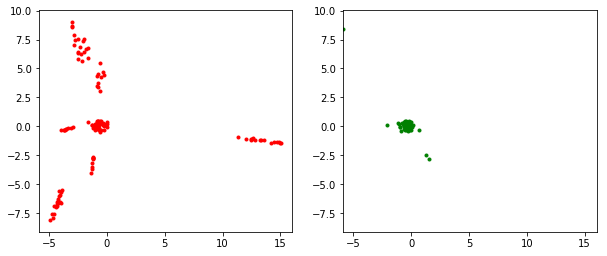

1001 [D loss: 0.565216, acc.: 68.56%] [G loss: 2.034904]
1002 [D loss: 0.549490, acc.: 73.48%] [G loss: 1.523356]
1003 [D loss: 0.561258, acc.: 70.08%] [G loss: 1.565059]
1004 [D loss: 0.541397, acc.: 75.38%] [G loss: 2.005231]
1005 [D loss: 0.545602, acc.: 73.11%] [G loss: 1.493635]
1006 [D loss: 0.546996, acc.: 72.73%] [G loss: 1.558893]
1007 [D loss: 0.588292, acc.: 73.86%] [G loss: 1.588953]
1008 [D loss: 0.540282, acc.: 70.83%] [G loss: 1.713685]
1009 [D loss: 0.554951, acc.: 75.00%] [G loss: 1.596870]
1010 [D loss: 0.517564, acc.: 75.00%] [G loss: 1.516791]
1011 [D loss: 0.515230, acc.: 78.03%] [G loss: 1.797554]
1012 [D loss: 0.580275, acc.: 73.11%] [G loss: 1.685470]
1013 [D loss: 0.603915, acc.: 72.73%] [G loss: 1.819494]
1014 [D loss: 0.540356, acc.: 73.48%] [G loss: 1.596630]
1015 [D loss: 0.558638, acc.: 72.73%] [G loss: 1.648660]
1016 [D loss: 0.556608, acc.: 72.73%] [G loss: 1.678349]
1017 [D loss: 0.592597, acc.: 73.86%] [G loss: 1.625048]
1018 [D loss: 0.556867, acc.: 7

1022 [D loss: 0.540524, acc.: 73.11%] [G loss: 1.844534]
1023 [D loss: 0.538216, acc.: 75.38%] [G loss: 1.452065]
1024 [D loss: 0.542369, acc.: 70.45%] [G loss: 1.601366]
1025 [D loss: 0.519237, acc.: 78.03%] [G loss: 1.656561]
1026 [D loss: 0.546340, acc.: 71.97%] [G loss: 1.573835]
1027 [D loss: 0.550215, acc.: 74.24%] [G loss: 1.901964]
1028 [D loss: 0.556859, acc.: 74.62%] [G loss: 1.617882]
1029 [D loss: 0.542296, acc.: 74.62%] [G loss: 1.798794]
1030 [D loss: 0.550983, acc.: 74.24%] [G loss: 1.629230]
1031 [D loss: 0.514889, acc.: 79.92%] [G loss: 2.118133]
1032 [D loss: 0.532953, acc.: 78.41%] [G loss: 1.665528]
1033 [D loss: 0.520120, acc.: 76.14%] [G loss: 1.598521]
1034 [D loss: 0.548355, acc.: 71.97%] [G loss: 1.606099]
1035 [D loss: 0.556447, acc.: 71.21%] [G loss: 1.752078]
1036 [D loss: 0.526141, acc.: 73.11%] [G loss: 1.617483]
1037 [D loss: 0.544075, acc.: 70.83%] [G loss: 2.076506]
1038 [D loss: 0.528711, acc.: 75.38%] [G loss: 1.908016]
1039 [D loss: 0.507540, acc.: 7

1044 [D loss: 0.507010, acc.: 79.55%] [G loss: 1.674793]
1045 [D loss: 0.527392, acc.: 75.76%] [G loss: 1.815961]
1046 [D loss: 0.514914, acc.: 80.68%] [G loss: 1.562006]
1047 [D loss: 0.568196, acc.: 68.56%] [G loss: 1.889113]
1048 [D loss: 0.542251, acc.: 75.38%] [G loss: 1.941849]
1049 [D loss: 0.529339, acc.: 76.89%] [G loss: 1.734666]
1050 [D loss: 0.559137, acc.: 70.83%] [G loss: 1.757478]
1051 [D loss: 0.544741, acc.: 71.59%] [G loss: 1.642038]
1052 [D loss: 0.541024, acc.: 71.59%] [G loss: 1.805239]
1053 [D loss: 0.545049, acc.: 73.48%] [G loss: 1.689778]
1054 [D loss: 0.520143, acc.: 76.52%] [G loss: 1.711237]
1055 [D loss: 0.511182, acc.: 78.79%] [G loss: 1.694308]
1056 [D loss: 0.561465, acc.: 68.56%] [G loss: 1.705641]
1057 [D loss: 0.528423, acc.: 76.14%] [G loss: 1.743448]
1058 [D loss: 0.535925, acc.: 75.00%] [G loss: 2.102448]
1059 [D loss: 0.540800, acc.: 73.86%] [G loss: 1.965949]
1060 [D loss: 0.544133, acc.: 73.11%] [G loss: 2.015753]
1061 [D loss: 0.533508, acc.: 7

1066 [D loss: 0.505863, acc.: 74.24%] [G loss: 2.285914]
1067 [D loss: 0.527432, acc.: 74.62%] [G loss: 1.870539]
1068 [D loss: 0.536088, acc.: 73.11%] [G loss: 1.883623]
1069 [D loss: 0.523716, acc.: 75.38%] [G loss: 1.773021]
1070 [D loss: 0.491613, acc.: 77.65%] [G loss: 1.728713]
1071 [D loss: 0.535914, acc.: 75.38%] [G loss: 1.783253]
1072 [D loss: 0.528703, acc.: 72.73%] [G loss: 1.943447]
1073 [D loss: 0.528796, acc.: 75.38%] [G loss: 1.628311]
1074 [D loss: 0.562239, acc.: 70.08%] [G loss: 1.951555]
1075 [D loss: 0.555904, acc.: 70.83%] [G loss: 2.179358]
1076 [D loss: 0.547333, acc.: 72.73%] [G loss: 1.822970]
1077 [D loss: 0.548506, acc.: 73.48%] [G loss: 1.982495]
1078 [D loss: 0.554746, acc.: 69.70%] [G loss: 1.822096]
1079 [D loss: 0.520978, acc.: 76.52%] [G loss: 1.448858]
1080 [D loss: 0.555139, acc.: 71.21%] [G loss: 1.962219]
1081 [D loss: 0.537509, acc.: 70.45%] [G loss: 1.633979]
1082 [D loss: 0.525836, acc.: 78.41%] [G loss: 2.054025]
1083 [D loss: 0.549049, acc.: 7

1088 [D loss: 0.577859, acc.: 71.97%] [G loss: 1.607777]
1089 [D loss: 0.543204, acc.: 72.73%] [G loss: 1.969356]
1090 [D loss: 0.528529, acc.: 75.76%] [G loss: 2.083518]
1091 [D loss: 0.514913, acc.: 77.65%] [G loss: 1.696548]
1092 [D loss: 0.541484, acc.: 73.86%] [G loss: 1.844173]
1093 [D loss: 0.515470, acc.: 76.89%] [G loss: 1.922183]
1094 [D loss: 0.521814, acc.: 79.55%] [G loss: 1.867704]
1095 [D loss: 0.531760, acc.: 73.86%] [G loss: 2.089022]
1096 [D loss: 0.526784, acc.: 75.00%] [G loss: 1.822853]
1097 [D loss: 0.558329, acc.: 74.62%] [G loss: 2.206461]
1098 [D loss: 0.548088, acc.: 72.73%] [G loss: 1.578007]
1099 [D loss: 0.549283, acc.: 71.21%] [G loss: 2.005296]
1100 [D loss: 0.502736, acc.: 77.65%] [G loss: 1.870536]
1101 [D loss: 0.551442, acc.: 73.86%] [G loss: 1.874833]
1102 [D loss: 0.520824, acc.: 73.86%] [G loss: 1.846786]
1103 [D loss: 0.514173, acc.: 73.48%] [G loss: 2.106271]
1104 [D loss: 0.528337, acc.: 71.59%] [G loss: 2.118262]
1105 [D loss: 0.524788, acc.: 7

1110 [D loss: 0.527341, acc.: 72.73%] [G loss: 1.857936]
1111 [D loss: 0.527510, acc.: 75.00%] [G loss: 2.029059]
1112 [D loss: 0.523659, acc.: 74.62%] [G loss: 1.891159]
1113 [D loss: 0.547603, acc.: 74.62%] [G loss: 2.170437]
1114 [D loss: 0.545791, acc.: 73.48%] [G loss: 1.966040]
1115 [D loss: 0.526919, acc.: 75.00%] [G loss: 2.080343]
1116 [D loss: 0.519277, acc.: 74.62%] [G loss: 1.943906]
1117 [D loss: 0.550838, acc.: 73.11%] [G loss: 2.332916]
1118 [D loss: 0.543066, acc.: 71.97%] [G loss: 1.882211]
1119 [D loss: 0.540624, acc.: 70.83%] [G loss: 1.917530]
1120 [D loss: 0.541954, acc.: 71.59%] [G loss: 1.948961]
1121 [D loss: 0.512948, acc.: 74.62%] [G loss: 1.973632]
1122 [D loss: 0.554423, acc.: 70.45%] [G loss: 1.837706]
1123 [D loss: 0.514887, acc.: 72.35%] [G loss: 1.879476]
1124 [D loss: 0.531167, acc.: 74.24%] [G loss: 2.400599]
1125 [D loss: 0.540931, acc.: 74.24%] [G loss: 2.024631]
1126 [D loss: 0.558244, acc.: 68.56%] [G loss: 1.767143]
1127 [D loss: 0.514842, acc.: 7

1132 [D loss: 0.516619, acc.: 75.00%] [G loss: 1.935397]
1133 [D loss: 0.528924, acc.: 76.52%] [G loss: 2.071851]
1134 [D loss: 0.538934, acc.: 73.48%] [G loss: 1.991975]
1135 [D loss: 0.571186, acc.: 74.62%] [G loss: 2.058081]
1136 [D loss: 0.514427, acc.: 71.59%] [G loss: 2.311313]
1137 [D loss: 0.530903, acc.: 73.11%] [G loss: 2.223251]
1138 [D loss: 0.537485, acc.: 75.76%] [G loss: 2.428288]
1139 [D loss: 0.518727, acc.: 75.38%] [G loss: 1.927588]
1140 [D loss: 0.524554, acc.: 75.00%] [G loss: 2.089403]
1141 [D loss: 0.550613, acc.: 73.48%] [G loss: 2.003713]
1142 [D loss: 0.551375, acc.: 70.83%] [G loss: 1.751366]
1143 [D loss: 0.590823, acc.: 70.45%] [G loss: 1.944562]
1144 [D loss: 0.516207, acc.: 76.52%] [G loss: 1.817530]
1145 [D loss: 0.501166, acc.: 75.00%] [G loss: 2.109601]
1146 [D loss: 0.515423, acc.: 76.89%] [G loss: 2.219802]
1147 [D loss: 0.550670, acc.: 71.97%] [G loss: 2.041972]
1148 [D loss: 0.534838, acc.: 75.76%] [G loss: 2.075617]
1149 [D loss: 0.548467, acc.: 7

1154 [D loss: 0.510572, acc.: 76.52%] [G loss: 2.085350]
1155 [D loss: 0.523380, acc.: 75.00%] [G loss: 2.221395]
1156 [D loss: 0.529085, acc.: 75.38%] [G loss: 2.107046]
1157 [D loss: 0.499074, acc.: 77.27%] [G loss: 1.853422]
1158 [D loss: 0.547342, acc.: 71.59%] [G loss: 1.911463]
1159 [D loss: 0.488150, acc.: 79.92%] [G loss: 1.817273]
1160 [D loss: 0.595592, acc.: 75.76%] [G loss: 1.947851]
1161 [D loss: 0.536110, acc.: 73.86%] [G loss: 1.820860]
1162 [D loss: 0.523586, acc.: 77.27%] [G loss: 2.567438]
1163 [D loss: 0.508581, acc.: 73.11%] [G loss: 2.099782]
1164 [D loss: 0.518420, acc.: 78.79%] [G loss: 2.127164]
1165 [D loss: 0.542302, acc.: 77.27%] [G loss: 2.083018]
1166 [D loss: 0.506188, acc.: 77.27%] [G loss: 2.249503]
1167 [D loss: 0.513882, acc.: 76.89%] [G loss: 2.067977]
1168 [D loss: 0.524303, acc.: 73.86%] [G loss: 2.334252]
1169 [D loss: 0.516025, acc.: 72.73%] [G loss: 1.869370]
1170 [D loss: 0.522567, acc.: 74.24%] [G loss: 1.809711]
1171 [D loss: 0.511564, acc.: 7

1176 [D loss: 0.511936, acc.: 73.86%] [G loss: 2.004000]
1177 [D loss: 0.534143, acc.: 71.97%] [G loss: 2.009154]
1178 [D loss: 0.550925, acc.: 73.48%] [G loss: 2.071716]
1179 [D loss: 0.540736, acc.: 74.62%] [G loss: 2.199998]
1180 [D loss: 0.513022, acc.: 75.38%] [G loss: 1.924237]
1181 [D loss: 0.525310, acc.: 73.86%] [G loss: 2.151522]
1182 [D loss: 0.533219, acc.: 75.00%] [G loss: 2.209460]
1183 [D loss: 0.504610, acc.: 77.65%] [G loss: 1.837680]
1184 [D loss: 0.542570, acc.: 73.48%] [G loss: 2.011970]
1185 [D loss: 0.522605, acc.: 78.41%] [G loss: 1.951108]
1186 [D loss: 0.505515, acc.: 80.68%] [G loss: 1.951223]
1187 [D loss: 0.512250, acc.: 76.89%] [G loss: 1.930763]
1188 [D loss: 0.482750, acc.: 77.65%] [G loss: 2.312704]
1189 [D loss: 0.541759, acc.: 75.76%] [G loss: 1.984198]
1190 [D loss: 0.512930, acc.: 76.52%] [G loss: 2.097017]
1191 [D loss: 0.521303, acc.: 75.00%] [G loss: 2.494251]
1192 [D loss: 0.509885, acc.: 75.76%] [G loss: 1.950921]
1193 [D loss: 0.505765, acc.: 7

1198 [D loss: 0.509342, acc.: 76.52%] [G loss: 2.070873]
1199 [D loss: 0.531777, acc.: 73.11%] [G loss: 2.218393]
1200 [D loss: 0.517417, acc.: 76.52%] [G loss: 2.552123]
1201 [D loss: 0.512030, acc.: 76.89%] [G loss: 2.199311]
1202 [D loss: 0.510778, acc.: 75.38%] [G loss: 1.934685]
1203 [D loss: 0.507378, acc.: 74.62%] [G loss: 2.177231]
1204 [D loss: 0.517973, acc.: 74.62%] [G loss: 2.212514]
1205 [D loss: 0.530257, acc.: 76.52%] [G loss: 2.466468]
1206 [D loss: 0.565352, acc.: 76.52%] [G loss: 1.918747]
1207 [D loss: 0.507552, acc.: 77.27%] [G loss: 2.468002]
1208 [D loss: 0.509308, acc.: 75.76%] [G loss: 2.175621]
1209 [D loss: 0.501546, acc.: 77.27%] [G loss: 2.029176]
1210 [D loss: 0.538814, acc.: 73.11%] [G loss: 2.060185]
1211 [D loss: 0.501580, acc.: 76.52%] [G loss: 2.057950]
1212 [D loss: 0.515076, acc.: 75.38%] [G loss: 2.199486]
1213 [D loss: 0.519483, acc.: 73.11%] [G loss: 2.063573]
1214 [D loss: 0.525048, acc.: 74.24%] [G loss: 2.106581]
1215 [D loss: 0.543841, acc.: 7

1220 [D loss: 0.528350, acc.: 74.62%] [G loss: 2.448983]
1221 [D loss: 0.545638, acc.: 75.76%] [G loss: 2.501596]
1222 [D loss: 0.511241, acc.: 76.89%] [G loss: 2.604597]
1223 [D loss: 0.524299, acc.: 72.35%] [G loss: 1.945953]
1224 [D loss: 0.523395, acc.: 76.14%] [G loss: 2.247442]
1225 [D loss: 0.530530, acc.: 78.03%] [G loss: 2.265810]
1226 [D loss: 0.492134, acc.: 78.03%] [G loss: 1.995309]
1227 [D loss: 0.523244, acc.: 74.62%] [G loss: 1.899880]
1228 [D loss: 0.513547, acc.: 76.14%] [G loss: 2.497937]
1229 [D loss: 0.542399, acc.: 75.00%] [G loss: 2.671151]
1230 [D loss: 0.492541, acc.: 76.89%] [G loss: 1.971304]
1231 [D loss: 0.482832, acc.: 81.06%] [G loss: 1.997874]
1232 [D loss: 0.522043, acc.: 76.52%] [G loss: 2.412638]
1233 [D loss: 0.503687, acc.: 74.24%] [G loss: 2.280143]
1234 [D loss: 0.505407, acc.: 74.24%] [G loss: 2.540658]
1235 [D loss: 0.515324, acc.: 78.03%] [G loss: 2.003952]
1236 [D loss: 0.493744, acc.: 78.03%] [G loss: 2.325720]
1237 [D loss: 0.517256, acc.: 7

1242 [D loss: 0.538464, acc.: 75.00%] [G loss: 2.088512]
1243 [D loss: 0.503667, acc.: 77.65%] [G loss: 2.297991]
1244 [D loss: 0.506968, acc.: 76.14%] [G loss: 1.948852]
1245 [D loss: 0.524475, acc.: 80.68%] [G loss: 2.465740]
1246 [D loss: 0.467716, acc.: 79.92%] [G loss: 2.330446]
1247 [D loss: 0.535808, acc.: 74.62%] [G loss: 2.337281]
1248 [D loss: 0.494715, acc.: 77.27%] [G loss: 1.890263]
1249 [D loss: 0.516445, acc.: 79.17%] [G loss: 2.518233]
1250 [D loss: 0.512976, acc.: 74.24%] [G loss: 2.014275]
1251 [D loss: 0.495395, acc.: 76.89%] [G loss: 2.560648]
1252 [D loss: 0.493433, acc.: 81.06%] [G loss: 2.418527]
1253 [D loss: 0.498062, acc.: 78.03%] [G loss: 2.499266]
1254 [D loss: 0.471704, acc.: 77.27%] [G loss: 2.010896]
1255 [D loss: 0.503592, acc.: 76.89%] [G loss: 1.952486]
1256 [D loss: 0.497080, acc.: 77.65%] [G loss: 2.310910]
1257 [D loss: 0.501773, acc.: 75.38%] [G loss: 2.290116]
1258 [D loss: 0.527356, acc.: 74.24%] [G loss: 2.391293]
1259 [D loss: 0.536342, acc.: 7

1264 [D loss: 0.497147, acc.: 78.41%] [G loss: 2.470248]
1265 [D loss: 0.538245, acc.: 70.83%] [G loss: 2.226136]
1266 [D loss: 0.508920, acc.: 79.17%] [G loss: 2.102304]
1267 [D loss: 0.515435, acc.: 75.00%] [G loss: 2.417490]
1268 [D loss: 0.528728, acc.: 74.62%] [G loss: 2.003072]
1269 [D loss: 0.499881, acc.: 76.14%] [G loss: 2.188459]
1270 [D loss: 0.532490, acc.: 72.73%] [G loss: 1.991831]
1271 [D loss: 0.516504, acc.: 72.73%] [G loss: 2.209539]
1272 [D loss: 0.498928, acc.: 76.52%] [G loss: 2.096037]
1273 [D loss: 0.486194, acc.: 78.03%] [G loss: 2.320260]
1274 [D loss: 0.523449, acc.: 77.65%] [G loss: 2.486213]
1275 [D loss: 0.517114, acc.: 75.38%] [G loss: 1.978001]
1276 [D loss: 0.570086, acc.: 75.38%] [G loss: 2.080679]
1277 [D loss: 0.575627, acc.: 70.45%] [G loss: 2.048710]
1278 [D loss: 0.497858, acc.: 76.89%] [G loss: 2.450259]
1279 [D loss: 0.522509, acc.: 76.89%] [G loss: 2.326013]
1280 [D loss: 0.494823, acc.: 78.03%] [G loss: 2.046300]
1281 [D loss: 0.492375, acc.: 7

1286 [D loss: 0.500318, acc.: 76.52%] [G loss: 2.441630]
1287 [D loss: 0.532391, acc.: 73.48%] [G loss: 2.220985]
1288 [D loss: 0.499657, acc.: 77.65%] [G loss: 2.337399]
1289 [D loss: 0.476077, acc.: 83.71%] [G loss: 2.382929]
1290 [D loss: 0.486595, acc.: 77.27%] [G loss: 2.038819]
1291 [D loss: 0.511492, acc.: 77.27%] [G loss: 1.860485]
1292 [D loss: 0.510080, acc.: 76.52%] [G loss: 2.150475]
1293 [D loss: 0.501476, acc.: 76.89%] [G loss: 2.415441]
1294 [D loss: 0.511260, acc.: 75.76%] [G loss: 2.404633]
1295 [D loss: 0.491189, acc.: 76.89%] [G loss: 2.060498]
1296 [D loss: 0.495348, acc.: 75.00%] [G loss: 2.640904]
1297 [D loss: 0.508788, acc.: 75.00%] [G loss: 2.028146]
1298 [D loss: 0.523517, acc.: 75.76%] [G loss: 2.030329]
1299 [D loss: 0.491170, acc.: 80.30%] [G loss: 2.295415]
1300 [D loss: 0.493252, acc.: 79.17%] [G loss: 2.128329]
1301 [D loss: 0.485675, acc.: 82.20%] [G loss: 2.280953]
1302 [D loss: 0.471052, acc.: 76.14%] [G loss: 2.407641]
1303 [D loss: 0.495243, acc.: 7

1308 [D loss: 0.533275, acc.: 76.52%] [G loss: 2.491542]
1309 [D loss: 0.512848, acc.: 77.27%] [G loss: 2.303904]
1310 [D loss: 0.481955, acc.: 79.92%] [G loss: 2.353247]
1311 [D loss: 0.527359, acc.: 70.83%] [G loss: 2.521581]
1312 [D loss: 0.508867, acc.: 75.76%] [G loss: 2.193817]
1313 [D loss: 0.504396, acc.: 75.38%] [G loss: 2.600353]
1314 [D loss: 0.529204, acc.: 72.35%] [G loss: 2.367445]
1315 [D loss: 0.470252, acc.: 78.79%] [G loss: 2.121359]
1316 [D loss: 0.505838, acc.: 75.00%] [G loss: 2.098881]
1317 [D loss: 0.517192, acc.: 75.76%] [G loss: 2.312942]
1318 [D loss: 0.518520, acc.: 73.86%] [G loss: 2.267392]
1319 [D loss: 0.546902, acc.: 70.45%] [G loss: 2.167157]
1320 [D loss: 0.547710, acc.: 76.52%] [G loss: 1.928414]
1321 [D loss: 0.478526, acc.: 79.17%] [G loss: 2.281115]
1322 [D loss: 0.521133, acc.: 76.89%] [G loss: 2.143824]
1323 [D loss: 0.532758, acc.: 74.62%] [G loss: 2.478602]
1324 [D loss: 0.489525, acc.: 75.76%] [G loss: 2.688618]
1325 [D loss: 0.500088, acc.: 7

1330 [D loss: 0.508959, acc.: 76.52%] [G loss: 2.761620]
1331 [D loss: 0.523316, acc.: 77.27%] [G loss: 2.464967]
1332 [D loss: 0.507211, acc.: 76.89%] [G loss: 2.323668]
1333 [D loss: 0.492231, acc.: 77.27%] [G loss: 2.029773]
1334 [D loss: 0.541641, acc.: 73.86%] [G loss: 2.128073]
1335 [D loss: 0.490286, acc.: 76.89%] [G loss: 2.451289]
1336 [D loss: 0.477908, acc.: 78.03%] [G loss: 2.161155]
1337 [D loss: 0.511007, acc.: 78.41%] [G loss: 2.077705]
1338 [D loss: 0.505387, acc.: 76.52%] [G loss: 2.215018]
1339 [D loss: 0.525139, acc.: 73.11%] [G loss: 2.683272]
1340 [D loss: 0.448844, acc.: 79.17%] [G loss: 2.549063]
1341 [D loss: 0.488235, acc.: 77.65%] [G loss: 2.271260]
1342 [D loss: 0.508142, acc.: 77.27%] [G loss: 2.098155]
1343 [D loss: 0.491892, acc.: 78.03%] [G loss: 2.328538]
1344 [D loss: 0.521667, acc.: 75.76%] [G loss: 1.982305]
1345 [D loss: 0.499079, acc.: 76.89%] [G loss: 2.113527]
1346 [D loss: 0.530983, acc.: 72.73%] [G loss: 2.542641]
1347 [D loss: 0.501287, acc.: 7

1351 [D loss: 0.553162, acc.: 75.00%] [G loss: 2.528387]
1352 [D loss: 0.566900, acc.: 76.14%] [G loss: 2.323601]
1353 [D loss: 0.519449, acc.: 79.17%] [G loss: 1.825687]
1354 [D loss: 0.497385, acc.: 75.38%] [G loss: 2.515883]
1355 [D loss: 0.495012, acc.: 78.41%] [G loss: 2.322123]
1356 [D loss: 0.500363, acc.: 73.86%] [G loss: 2.335162]
1357 [D loss: 0.453185, acc.: 80.68%] [G loss: 2.369526]
1358 [D loss: 0.525360, acc.: 75.00%] [G loss: 2.117196]
1359 [D loss: 0.535478, acc.: 75.76%] [G loss: 2.458424]
1360 [D loss: 0.516878, acc.: 73.11%] [G loss: 2.011374]
1361 [D loss: 0.490553, acc.: 75.38%] [G loss: 2.374590]
1362 [D loss: 0.495669, acc.: 79.17%] [G loss: 2.500921]
1363 [D loss: 0.477311, acc.: 81.06%] [G loss: 2.362228]
1364 [D loss: 0.496892, acc.: 76.89%] [G loss: 2.384116]
1365 [D loss: 0.516143, acc.: 75.00%] [G loss: 2.657474]
1366 [D loss: 0.480273, acc.: 80.30%] [G loss: 2.608107]
1367 [D loss: 0.519070, acc.: 76.52%] [G loss: 2.429196]
1368 [D loss: 0.496346, acc.: 7

1373 [D loss: 0.499330, acc.: 76.89%] [G loss: 2.476708]
1374 [D loss: 0.485441, acc.: 79.55%] [G loss: 2.637905]
1375 [D loss: 0.483823, acc.: 78.41%] [G loss: 2.544520]
1376 [D loss: 0.477737, acc.: 78.79%] [G loss: 2.365335]
1377 [D loss: 0.509992, acc.: 73.11%] [G loss: 2.211775]
1378 [D loss: 0.502358, acc.: 79.17%] [G loss: 2.039679]
1379 [D loss: 0.496003, acc.: 78.03%] [G loss: 2.347456]
1380 [D loss: 0.526439, acc.: 77.65%] [G loss: 2.353998]
1381 [D loss: 0.514680, acc.: 75.76%] [G loss: 2.260484]
1382 [D loss: 0.517514, acc.: 73.11%] [G loss: 2.800555]
1383 [D loss: 0.491515, acc.: 78.79%] [G loss: 1.949817]
1384 [D loss: 0.520744, acc.: 76.14%] [G loss: 2.354436]
1385 [D loss: 0.477873, acc.: 79.17%] [G loss: 2.523734]
1386 [D loss: 0.482124, acc.: 79.17%] [G loss: 2.170757]
1387 [D loss: 0.510801, acc.: 76.52%] [G loss: 2.382564]
1388 [D loss: 0.505438, acc.: 76.52%] [G loss: 2.252988]
1389 [D loss: 0.481932, acc.: 76.89%] [G loss: 2.618046]
1390 [D loss: 0.518080, acc.: 7

1395 [D loss: 0.469670, acc.: 79.55%] [G loss: 2.283145]
1396 [D loss: 0.502848, acc.: 78.79%] [G loss: 2.455171]
1397 [D loss: 0.497787, acc.: 77.65%] [G loss: 2.725447]
1398 [D loss: 0.482474, acc.: 75.76%] [G loss: 2.418772]
1399 [D loss: 0.493685, acc.: 77.27%] [G loss: 2.608184]
1400 [D loss: 0.485393, acc.: 78.79%] [G loss: 2.190201]
1401 [D loss: 0.493142, acc.: 77.65%] [G loss: 2.346950]
1402 [D loss: 0.515604, acc.: 75.38%] [G loss: 2.617733]
1403 [D loss: 0.476992, acc.: 78.41%] [G loss: 2.718225]
1404 [D loss: 0.575687, acc.: 69.70%] [G loss: 2.697693]
1405 [D loss: 0.511763, acc.: 75.00%] [G loss: 2.295953]
1406 [D loss: 0.512740, acc.: 73.86%] [G loss: 2.596987]
1407 [D loss: 0.496478, acc.: 74.24%] [G loss: 2.449482]
1408 [D loss: 0.476026, acc.: 78.03%] [G loss: 2.117588]
1409 [D loss: 0.507104, acc.: 76.14%] [G loss: 2.037029]
1410 [D loss: 0.511379, acc.: 70.83%] [G loss: 2.254170]
1411 [D loss: 0.532974, acc.: 75.76%] [G loss: 2.185988]
1412 [D loss: 0.526358, acc.: 7

1417 [D loss: 0.505848, acc.: 76.14%] [G loss: 2.467296]
1418 [D loss: 0.507453, acc.: 75.38%] [G loss: 2.271744]
1419 [D loss: 0.462939, acc.: 79.55%] [G loss: 2.288441]
1420 [D loss: 0.485478, acc.: 79.17%] [G loss: 2.513318]
1421 [D loss: 0.481155, acc.: 78.41%] [G loss: 2.147166]
1422 [D loss: 0.484659, acc.: 80.30%] [G loss: 2.664286]
1423 [D loss: 0.481122, acc.: 80.30%] [G loss: 2.291910]
1424 [D loss: 0.496099, acc.: 79.55%] [G loss: 2.634535]
1425 [D loss: 0.501762, acc.: 76.52%] [G loss: 2.283281]
1426 [D loss: 0.510450, acc.: 75.00%] [G loss: 2.387896]
1427 [D loss: 0.566788, acc.: 76.14%] [G loss: 2.183917]
1428 [D loss: 0.517658, acc.: 75.00%] [G loss: 2.170840]
1429 [D loss: 0.516076, acc.: 73.86%] [G loss: 2.610136]
1430 [D loss: 0.493776, acc.: 81.06%] [G loss: 2.565944]
1431 [D loss: 0.497250, acc.: 76.89%] [G loss: 2.562678]
1432 [D loss: 0.490883, acc.: 78.03%] [G loss: 2.091618]
1433 [D loss: 0.508316, acc.: 75.00%] [G loss: 2.592999]
1434 [D loss: 0.524938, acc.: 7

1439 [D loss: 0.499201, acc.: 75.38%] [G loss: 2.609845]
1440 [D loss: 0.501153, acc.: 78.41%] [G loss: 2.442730]
1441 [D loss: 0.506257, acc.: 73.11%] [G loss: 2.823717]
1442 [D loss: 0.505749, acc.: 74.62%] [G loss: 2.175248]
1443 [D loss: 0.506990, acc.: 76.14%] [G loss: 2.176415]
1444 [D loss: 0.537664, acc.: 70.45%] [G loss: 2.529428]
1445 [D loss: 0.469245, acc.: 81.06%] [G loss: 2.334696]
1446 [D loss: 0.518248, acc.: 73.11%] [G loss: 2.463860]
1447 [D loss: 0.521117, acc.: 73.11%] [G loss: 2.438506]
1448 [D loss: 0.481999, acc.: 79.17%] [G loss: 2.650813]
1449 [D loss: 0.467610, acc.: 79.55%] [G loss: 2.144621]
1450 [D loss: 0.503654, acc.: 77.65%] [G loss: 2.478889]
1451 [D loss: 0.506984, acc.: 77.27%] [G loss: 2.393148]
1452 [D loss: 0.516772, acc.: 77.27%] [G loss: 2.809860]
1453 [D loss: 0.528416, acc.: 75.76%] [G loss: 2.207696]
1454 [D loss: 0.505331, acc.: 75.76%] [G loss: 2.282195]
1455 [D loss: 0.542261, acc.: 71.21%] [G loss: 2.543999]
1456 [D loss: 0.498566, acc.: 7

1461 [D loss: 0.504208, acc.: 75.00%] [G loss: 2.419548]
1462 [D loss: 0.489694, acc.: 78.03%] [G loss: 2.655507]
1463 [D loss: 0.493127, acc.: 76.14%] [G loss: 2.469486]
1464 [D loss: 0.499825, acc.: 75.76%] [G loss: 2.484871]
1465 [D loss: 0.535518, acc.: 71.59%] [G loss: 2.749522]
1466 [D loss: 0.529829, acc.: 73.86%] [G loss: 2.514726]
1467 [D loss: 0.523530, acc.: 75.00%] [G loss: 2.516636]
1468 [D loss: 0.492752, acc.: 72.73%] [G loss: 2.355425]
1469 [D loss: 0.528980, acc.: 73.48%] [G loss: 2.663210]
1470 [D loss: 0.496652, acc.: 78.03%] [G loss: 2.817048]
1471 [D loss: 0.495910, acc.: 76.52%] [G loss: 2.898838]
1472 [D loss: 0.474428, acc.: 78.41%] [G loss: 2.606981]
1473 [D loss: 0.528898, acc.: 74.62%] [G loss: 2.758717]
1474 [D loss: 0.541684, acc.: 68.56%] [G loss: 2.900641]
1475 [D loss: 0.549749, acc.: 75.38%] [G loss: 2.128834]
1476 [D loss: 0.482318, acc.: 75.76%] [G loss: 2.774282]
1477 [D loss: 0.514501, acc.: 74.24%] [G loss: 2.216074]
1478 [D loss: 0.495013, acc.: 7

1483 [D loss: 0.515847, acc.: 76.14%] [G loss: 2.300304]
1484 [D loss: 0.497556, acc.: 78.79%] [G loss: 2.199840]
1485 [D loss: 0.513333, acc.: 75.38%] [G loss: 2.656841]
1486 [D loss: 0.496523, acc.: 75.38%] [G loss: 2.497714]
1487 [D loss: 0.473651, acc.: 77.27%] [G loss: 2.693457]
1488 [D loss: 0.504602, acc.: 76.14%] [G loss: 2.704792]
1489 [D loss: 0.487586, acc.: 80.30%] [G loss: 2.555986]
1490 [D loss: 0.482484, acc.: 79.17%] [G loss: 2.506052]
1491 [D loss: 0.506154, acc.: 76.89%] [G loss: 2.752558]
1492 [D loss: 0.536469, acc.: 74.62%] [G loss: 2.529833]
1493 [D loss: 0.496706, acc.: 77.65%] [G loss: 2.484746]
1494 [D loss: 0.490345, acc.: 76.52%] [G loss: 2.574760]
1495 [D loss: 0.516561, acc.: 74.24%] [G loss: 2.458179]
1496 [D loss: 0.523077, acc.: 71.97%] [G loss: 2.402005]
1497 [D loss: 0.476947, acc.: 76.89%] [G loss: 2.189704]
1498 [D loss: 0.506097, acc.: 76.52%] [G loss: 2.143047]
1499 [D loss: 0.506965, acc.: 75.38%] [G loss: 2.352549]
1500 [D loss: 0.482859, acc.: 7

1505 [D loss: 0.481279, acc.: 76.14%] [G loss: 2.582099]
1506 [D loss: 0.528161, acc.: 77.27%] [G loss: 2.624861]
1507 [D loss: 0.507915, acc.: 75.00%] [G loss: 2.477305]
1508 [D loss: 0.541096, acc.: 71.21%] [G loss: 2.615495]
1509 [D loss: 0.514467, acc.: 72.73%] [G loss: 2.321948]
1510 [D loss: 0.495604, acc.: 77.65%] [G loss: 2.548494]
1511 [D loss: 0.517493, acc.: 74.62%] [G loss: 2.592432]
1512 [D loss: 0.511924, acc.: 75.38%] [G loss: 2.973732]
1513 [D loss: 0.555899, acc.: 72.73%] [G loss: 2.750637]
1514 [D loss: 0.488297, acc.: 78.41%] [G loss: 2.554996]
1515 [D loss: 0.489934, acc.: 78.41%] [G loss: 2.312778]
1516 [D loss: 0.541544, acc.: 68.94%] [G loss: 2.565217]
1517 [D loss: 0.500045, acc.: 78.79%] [G loss: 2.325932]
1518 [D loss: 0.467210, acc.: 79.92%] [G loss: 2.445046]
1519 [D loss: 0.505742, acc.: 75.76%] [G loss: 2.331661]
1520 [D loss: 0.500812, acc.: 74.24%] [G loss: 2.346256]
1521 [D loss: 0.507885, acc.: 75.00%] [G loss: 2.754210]
1522 [D loss: 0.498724, acc.: 7

1527 [D loss: 0.525498, acc.: 75.76%] [G loss: 1.981253]
1528 [D loss: 0.500935, acc.: 74.62%] [G loss: 2.516917]
1529 [D loss: 0.494746, acc.: 77.27%] [G loss: 2.326458]
1530 [D loss: 0.517807, acc.: 78.03%] [G loss: 3.041699]
1531 [D loss: 0.520909, acc.: 72.35%] [G loss: 2.464329]
1532 [D loss: 0.510621, acc.: 72.73%] [G loss: 2.228474]
1533 [D loss: 0.459735, acc.: 78.41%] [G loss: 2.161054]
1534 [D loss: 0.514836, acc.: 74.62%] [G loss: 2.688973]
1535 [D loss: 0.508573, acc.: 74.62%] [G loss: 2.649490]
1536 [D loss: 0.500280, acc.: 76.52%] [G loss: 2.507869]
1537 [D loss: 0.533312, acc.: 73.11%] [G loss: 2.433681]
1538 [D loss: 0.486808, acc.: 78.79%] [G loss: 2.248507]
1539 [D loss: 0.506883, acc.: 73.48%] [G loss: 2.363489]
1540 [D loss: 0.514044, acc.: 75.00%] [G loss: 2.548748]
1541 [D loss: 0.472676, acc.: 76.52%] [G loss: 2.284217]
1542 [D loss: 0.517444, acc.: 75.38%] [G loss: 2.989155]
1543 [D loss: 0.481454, acc.: 77.65%] [G loss: 2.587955]
1544 [D loss: 0.485166, acc.: 7

1549 [D loss: 0.486748, acc.: 76.52%] [G loss: 2.235379]
1550 [D loss: 0.491448, acc.: 79.55%] [G loss: 2.335466]
1551 [D loss: 0.497438, acc.: 76.52%] [G loss: 2.311970]
1552 [D loss: 0.490790, acc.: 78.41%] [G loss: 2.955429]
1553 [D loss: 0.465940, acc.: 78.79%] [G loss: 2.209659]
1554 [D loss: 0.529352, acc.: 72.73%] [G loss: 2.189273]
1555 [D loss: 0.480725, acc.: 76.14%] [G loss: 2.605271]
1556 [D loss: 0.477679, acc.: 79.55%] [G loss: 2.413181]
1557 [D loss: 0.512997, acc.: 76.14%] [G loss: 2.678335]
1558 [D loss: 0.492951, acc.: 76.52%] [G loss: 2.271453]
1559 [D loss: 0.489837, acc.: 74.24%] [G loss: 2.445446]
1560 [D loss: 0.470957, acc.: 81.44%] [G loss: 2.663462]
1561 [D loss: 0.539644, acc.: 79.17%] [G loss: 2.632799]
1562 [D loss: 0.510557, acc.: 73.86%] [G loss: 3.023208]
1563 [D loss: 0.528402, acc.: 70.83%] [G loss: 2.858838]
1564 [D loss: 0.481460, acc.: 78.41%] [G loss: 2.070461]
1565 [D loss: 0.473845, acc.: 80.68%] [G loss: 2.995473]
1566 [D loss: 0.484375, acc.: 7

1571 [D loss: 0.521397, acc.: 73.48%] [G loss: 2.748732]
1572 [D loss: 0.491640, acc.: 77.27%] [G loss: 2.798245]
1573 [D loss: 0.487145, acc.: 75.38%] [G loss: 2.531281]
1574 [D loss: 0.506118, acc.: 74.62%] [G loss: 2.582862]
1575 [D loss: 0.540619, acc.: 75.00%] [G loss: 2.445640]
1576 [D loss: 0.498098, acc.: 75.00%] [G loss: 2.385077]
1577 [D loss: 0.488356, acc.: 76.89%] [G loss: 2.721584]
1578 [D loss: 0.524077, acc.: 76.52%] [G loss: 2.572601]
1579 [D loss: 0.507473, acc.: 75.38%] [G loss: 2.530854]
1580 [D loss: 0.499660, acc.: 75.38%] [G loss: 2.548384]
1581 [D loss: 0.470122, acc.: 76.89%] [G loss: 2.639652]
1582 [D loss: 0.505875, acc.: 78.41%] [G loss: 2.582850]
1583 [D loss: 0.518582, acc.: 73.48%] [G loss: 2.419026]
1584 [D loss: 0.466204, acc.: 79.17%] [G loss: 2.726256]
1585 [D loss: 0.501713, acc.: 74.62%] [G loss: 3.190155]
1586 [D loss: 0.534462, acc.: 73.11%] [G loss: 2.513888]
1587 [D loss: 0.552751, acc.: 69.32%] [G loss: 2.730939]
1588 [D loss: 0.482497, acc.: 7

1593 [D loss: 0.506755, acc.: 76.14%] [G loss: 2.653854]
1594 [D loss: 0.475087, acc.: 79.92%] [G loss: 2.482558]
1595 [D loss: 0.500493, acc.: 76.52%] [G loss: 2.796549]
1596 [D loss: 0.538790, acc.: 72.73%] [G loss: 2.747451]
1597 [D loss: 0.493247, acc.: 77.65%] [G loss: 2.447701]
1598 [D loss: 0.463674, acc.: 78.41%] [G loss: 2.880875]
1599 [D loss: 0.495656, acc.: 74.62%] [G loss: 2.482349]
1600 [D loss: 0.498906, acc.: 75.76%] [G loss: 2.404719]
1601 [D loss: 0.458968, acc.: 76.89%] [G loss: 2.703791]
1602 [D loss: 0.494409, acc.: 76.52%] [G loss: 2.417519]
1603 [D loss: 0.466548, acc.: 78.41%] [G loss: 2.817946]
1604 [D loss: 0.492369, acc.: 76.89%] [G loss: 2.527314]
1605 [D loss: 0.533072, acc.: 75.76%] [G loss: 2.190042]
1606 [D loss: 0.475439, acc.: 77.65%] [G loss: 3.127048]
1607 [D loss: 0.477585, acc.: 76.14%] [G loss: 2.605996]
1608 [D loss: 0.493326, acc.: 76.52%] [G loss: 2.757015]
1609 [D loss: 0.491467, acc.: 76.52%] [G loss: 2.205314]
1610 [D loss: 0.466449, acc.: 7

1615 [D loss: 0.486177, acc.: 75.38%] [G loss: 2.884501]
1616 [D loss: 0.522271, acc.: 74.24%] [G loss: 2.735740]
1617 [D loss: 0.490352, acc.: 75.76%] [G loss: 2.409785]
1618 [D loss: 0.474189, acc.: 78.03%] [G loss: 2.153724]
1619 [D loss: 0.519235, acc.: 75.76%] [G loss: 2.570668]
1620 [D loss: 0.495156, acc.: 74.24%] [G loss: 2.980555]
1621 [D loss: 0.479733, acc.: 78.41%] [G loss: 2.494788]
1622 [D loss: 0.488707, acc.: 76.89%] [G loss: 2.204501]
1623 [D loss: 0.452488, acc.: 82.20%] [G loss: 2.384717]
1624 [D loss: 0.489363, acc.: 78.41%] [G loss: 2.871186]
1625 [D loss: 0.492737, acc.: 75.00%] [G loss: 2.473503]
1626 [D loss: 0.449349, acc.: 83.33%] [G loss: 2.575572]
1627 [D loss: 0.502264, acc.: 77.65%] [G loss: 2.660241]
1628 [D loss: 0.488933, acc.: 76.89%] [G loss: 2.619916]
1629 [D loss: 0.480990, acc.: 80.30%] [G loss: 2.710742]
1630 [D loss: 0.465235, acc.: 79.17%] [G loss: 2.276970]
1631 [D loss: 0.490337, acc.: 77.27%] [G loss: 2.368874]
1632 [D loss: 0.446127, acc.: 8

1637 [D loss: 0.484097, acc.: 75.00%] [G loss: 2.698123]
1638 [D loss: 0.552655, acc.: 71.97%] [G loss: 2.609638]
1639 [D loss: 0.500822, acc.: 73.86%] [G loss: 2.271468]
1640 [D loss: 0.521366, acc.: 72.35%] [G loss: 2.310492]
1641 [D loss: 0.466766, acc.: 79.55%] [G loss: 2.542410]
1642 [D loss: 0.474966, acc.: 75.00%] [G loss: 2.503632]
1643 [D loss: 0.478566, acc.: 79.55%] [G loss: 2.787478]
1644 [D loss: 0.529941, acc.: 76.52%] [G loss: 2.518722]
1645 [D loss: 0.488534, acc.: 78.79%] [G loss: 2.145923]
1646 [D loss: 0.564999, acc.: 74.62%] [G loss: 2.774791]
1647 [D loss: 0.496962, acc.: 77.27%] [G loss: 2.714235]
1648 [D loss: 0.473714, acc.: 79.17%] [G loss: 2.837317]
1649 [D loss: 0.497799, acc.: 77.27%] [G loss: 3.056840]
1650 [D loss: 0.499715, acc.: 78.79%] [G loss: 2.367810]
1651 [D loss: 0.506579, acc.: 75.00%] [G loss: 2.960742]
1652 [D loss: 0.480026, acc.: 78.03%] [G loss: 2.728052]
1653 [D loss: 0.472138, acc.: 79.17%] [G loss: 2.599041]
1654 [D loss: 0.496896, acc.: 7

1659 [D loss: 0.491388, acc.: 77.27%] [G loss: 2.400903]
1660 [D loss: 0.478349, acc.: 78.41%] [G loss: 2.416228]
1661 [D loss: 0.481725, acc.: 76.89%] [G loss: 2.764973]
1662 [D loss: 0.484692, acc.: 76.89%] [G loss: 2.834615]
1663 [D loss: 0.495431, acc.: 74.24%] [G loss: 2.714679]
1664 [D loss: 0.493954, acc.: 76.89%] [G loss: 2.702290]
1665 [D loss: 0.474306, acc.: 79.55%] [G loss: 2.508356]
1666 [D loss: 0.474086, acc.: 78.03%] [G loss: 2.781414]
1667 [D loss: 0.471681, acc.: 76.89%] [G loss: 2.453472]
1668 [D loss: 0.483149, acc.: 77.27%] [G loss: 2.825182]
1669 [D loss: 0.497831, acc.: 74.62%] [G loss: 2.530354]
1670 [D loss: 0.495130, acc.: 75.76%] [G loss: 2.347055]
1671 [D loss: 0.512289, acc.: 73.86%] [G loss: 2.731914]
1672 [D loss: 0.485757, acc.: 80.68%] [G loss: 2.737899]
1673 [D loss: 0.510666, acc.: 75.00%] [G loss: 3.083935]
1674 [D loss: 0.513416, acc.: 76.89%] [G loss: 2.456324]
1675 [D loss: 0.534189, acc.: 75.00%] [G loss: 2.614145]
1676 [D loss: 0.492086, acc.: 7

1681 [D loss: 0.484182, acc.: 78.03%] [G loss: 2.881787]
1682 [D loss: 0.488968, acc.: 78.41%] [G loss: 2.876323]
1683 [D loss: 0.512135, acc.: 76.14%] [G loss: 3.066674]
1684 [D loss: 0.488077, acc.: 78.03%] [G loss: 2.748255]
1685 [D loss: 0.475831, acc.: 77.27%] [G loss: 2.629340]
1686 [D loss: 0.480025, acc.: 79.55%] [G loss: 2.900382]
1687 [D loss: 0.479257, acc.: 75.76%] [G loss: 2.523171]
1688 [D loss: 0.555054, acc.: 72.35%] [G loss: 2.421724]
1689 [D loss: 0.468453, acc.: 78.41%] [G loss: 2.321482]
1690 [D loss: 0.487467, acc.: 80.30%] [G loss: 2.809664]
1691 [D loss: 0.505616, acc.: 79.17%] [G loss: 3.099477]
1692 [D loss: 0.485530, acc.: 77.65%] [G loss: 2.914677]
1693 [D loss: 0.475914, acc.: 81.06%] [G loss: 2.604443]
1694 [D loss: 0.483622, acc.: 78.79%] [G loss: 2.508498]
1695 [D loss: 0.441340, acc.: 83.33%] [G loss: 2.667153]
1696 [D loss: 0.514111, acc.: 76.89%] [G loss: 3.073059]
1697 [D loss: 0.492057, acc.: 76.52%] [G loss: 2.587827]
1698 [D loss: 0.500095, acc.: 7

1703 [D loss: 0.460892, acc.: 84.09%] [G loss: 2.336863]
1704 [D loss: 0.500480, acc.: 76.89%] [G loss: 2.866095]
1705 [D loss: 0.478395, acc.: 78.03%] [G loss: 2.777278]
1706 [D loss: 0.528688, acc.: 74.24%] [G loss: 2.365373]
1707 [D loss: 0.475532, acc.: 79.92%] [G loss: 2.927944]
1708 [D loss: 0.506117, acc.: 81.06%] [G loss: 2.613601]
1709 [D loss: 0.489622, acc.: 78.79%] [G loss: 2.648873]
1710 [D loss: 0.489174, acc.: 76.89%] [G loss: 2.365086]
1711 [D loss: 0.475901, acc.: 78.79%] [G loss: 3.140061]
1712 [D loss: 0.517717, acc.: 75.76%] [G loss: 3.088311]
1713 [D loss: 0.512644, acc.: 73.11%] [G loss: 2.284768]
1714 [D loss: 0.479784, acc.: 76.52%] [G loss: 2.548628]
1715 [D loss: 0.450773, acc.: 78.41%] [G loss: 2.412633]
1716 [D loss: 0.459884, acc.: 79.55%] [G loss: 2.520956]
1717 [D loss: 0.497824, acc.: 74.62%] [G loss: 2.985670]
1718 [D loss: 0.501139, acc.: 73.86%] [G loss: 3.031950]
1719 [D loss: 0.488230, acc.: 76.52%] [G loss: 2.615532]
1720 [D loss: 0.480505, acc.: 8

1724 [D loss: 0.506633, acc.: 75.38%] [G loss: 3.244380]
1725 [D loss: 0.472358, acc.: 78.41%] [G loss: 2.881417]
1726 [D loss: 0.475457, acc.: 77.27%] [G loss: 2.381322]
1727 [D loss: 0.466099, acc.: 78.03%] [G loss: 3.108392]
1728 [D loss: 0.513845, acc.: 75.00%] [G loss: 2.651988]
1729 [D loss: 0.526583, acc.: 73.48%] [G loss: 2.671506]
1730 [D loss: 0.483049, acc.: 79.55%] [G loss: 2.868248]
1731 [D loss: 0.488398, acc.: 77.27%] [G loss: 3.170001]
1732 [D loss: 0.486737, acc.: 79.17%] [G loss: 2.740413]
1733 [D loss: 0.479283, acc.: 78.79%] [G loss: 2.759945]
1734 [D loss: 0.482728, acc.: 81.06%] [G loss: 2.779170]
1735 [D loss: 0.472124, acc.: 78.79%] [G loss: 2.456420]
1736 [D loss: 0.493886, acc.: 76.89%] [G loss: 2.800631]
1737 [D loss: 0.465775, acc.: 79.92%] [G loss: 2.483921]
1738 [D loss: 0.482704, acc.: 79.55%] [G loss: 2.458980]
1739 [D loss: 0.503879, acc.: 75.76%] [G loss: 2.295707]
1740 [D loss: 0.436923, acc.: 79.92%] [G loss: 2.839440]
1741 [D loss: 0.462014, acc.: 7

1746 [D loss: 0.466721, acc.: 79.55%] [G loss: 3.078472]
1747 [D loss: 0.495465, acc.: 74.62%] [G loss: 2.497664]
1748 [D loss: 0.506355, acc.: 74.62%] [G loss: 2.637100]
1749 [D loss: 0.476058, acc.: 79.17%] [G loss: 2.834217]
1750 [D loss: 0.493802, acc.: 81.82%] [G loss: 3.169326]
1751 [D loss: 0.471416, acc.: 78.41%] [G loss: 2.817270]
1752 [D loss: 0.484433, acc.: 78.03%] [G loss: 2.387120]
1753 [D loss: 0.452161, acc.: 82.20%] [G loss: 2.534518]
1754 [D loss: 0.490257, acc.: 76.89%] [G loss: 2.631788]
1755 [D loss: 0.495357, acc.: 78.79%] [G loss: 2.673332]
1756 [D loss: 0.511673, acc.: 77.27%] [G loss: 2.707919]
1757 [D loss: 0.516984, acc.: 73.48%] [G loss: 2.707076]
1758 [D loss: 0.491178, acc.: 76.89%] [G loss: 2.256518]
1759 [D loss: 0.488010, acc.: 77.65%] [G loss: 2.766054]
1760 [D loss: 0.444415, acc.: 80.30%] [G loss: 2.977876]
1761 [D loss: 0.495223, acc.: 76.89%] [G loss: 2.598796]
1762 [D loss: 0.517469, acc.: 76.52%] [G loss: 2.397545]
1763 [D loss: 0.523709, acc.: 7

1768 [D loss: 0.468302, acc.: 80.30%] [G loss: 2.460198]
1769 [D loss: 0.490107, acc.: 78.03%] [G loss: 2.957144]
1770 [D loss: 0.459140, acc.: 79.17%] [G loss: 2.906532]
1771 [D loss: 0.462696, acc.: 80.68%] [G loss: 2.832824]
1772 [D loss: 0.496855, acc.: 75.38%] [G loss: 2.886067]
1773 [D loss: 0.447487, acc.: 84.09%] [G loss: 2.319333]
1774 [D loss: 0.474861, acc.: 77.27%] [G loss: 2.870633]
1775 [D loss: 0.515828, acc.: 77.65%] [G loss: 3.008584]
1776 [D loss: 0.490586, acc.: 75.38%] [G loss: 2.637628]
1777 [D loss: 0.493195, acc.: 75.76%] [G loss: 2.450565]
1778 [D loss: 0.516919, acc.: 78.03%] [G loss: 2.647702]
1779 [D loss: 0.490250, acc.: 80.30%] [G loss: 2.546826]
1780 [D loss: 0.448294, acc.: 82.58%] [G loss: 2.531003]
1781 [D loss: 0.508764, acc.: 74.62%] [G loss: 2.653777]
1782 [D loss: 0.470669, acc.: 78.41%] [G loss: 2.425365]
1783 [D loss: 0.454645, acc.: 80.68%] [G loss: 3.532261]
1784 [D loss: 0.440305, acc.: 81.06%] [G loss: 2.893496]
1785 [D loss: 0.469387, acc.: 8

1790 [D loss: 0.451537, acc.: 84.85%] [G loss: 2.633027]
1791 [D loss: 0.443065, acc.: 82.58%] [G loss: 2.970840]
1792 [D loss: 0.469827, acc.: 76.89%] [G loss: 2.941515]
1793 [D loss: 0.475511, acc.: 80.68%] [G loss: 2.914733]
1794 [D loss: 0.478218, acc.: 77.27%] [G loss: 2.952430]
1795 [D loss: 0.494085, acc.: 77.27%] [G loss: 2.660702]
1796 [D loss: 0.453669, acc.: 81.82%] [G loss: 2.863143]
1797 [D loss: 0.500228, acc.: 76.52%] [G loss: 2.676408]
1798 [D loss: 0.474022, acc.: 76.89%] [G loss: 3.124092]
1799 [D loss: 0.478812, acc.: 79.92%] [G loss: 2.539322]
1800 [D loss: 0.488480, acc.: 78.03%] [G loss: 3.137854]
1801 [D loss: 0.489591, acc.: 75.38%] [G loss: 2.769844]
1802 [D loss: 0.472444, acc.: 79.17%] [G loss: 2.416275]
1803 [D loss: 0.481772, acc.: 78.41%] [G loss: 2.512045]
1804 [D loss: 0.479625, acc.: 77.27%] [G loss: 3.018513]
1805 [D loss: 0.480517, acc.: 78.03%] [G loss: 3.163336]
1806 [D loss: 0.471882, acc.: 79.92%] [G loss: 2.643323]
1807 [D loss: 0.519539, acc.: 7

1812 [D loss: 0.461910, acc.: 78.41%] [G loss: 2.675473]
1813 [D loss: 0.498082, acc.: 76.14%] [G loss: 2.878165]
1814 [D loss: 0.553697, acc.: 71.21%] [G loss: 2.944748]
1815 [D loss: 0.417355, acc.: 85.23%] [G loss: 2.583468]
1816 [D loss: 0.503643, acc.: 80.30%] [G loss: 3.064496]
1817 [D loss: 0.445270, acc.: 81.06%] [G loss: 2.771481]
1818 [D loss: 0.508496, acc.: 76.14%] [G loss: 2.956993]
1819 [D loss: 0.497622, acc.: 80.30%] [G loss: 2.757599]
1820 [D loss: 0.475325, acc.: 79.55%] [G loss: 2.837370]
1821 [D loss: 0.481031, acc.: 78.41%] [G loss: 2.356025]
1822 [D loss: 0.467013, acc.: 79.92%] [G loss: 2.868594]
1823 [D loss: 0.520442, acc.: 79.55%] [G loss: 2.841664]
1824 [D loss: 0.481484, acc.: 79.17%] [G loss: 2.606300]
1825 [D loss: 0.483129, acc.: 78.41%] [G loss: 3.135712]
1826 [D loss: 0.492285, acc.: 78.03%] [G loss: 2.406875]
1827 [D loss: 0.503512, acc.: 79.17%] [G loss: 2.800789]
1828 [D loss: 0.489958, acc.: 78.03%] [G loss: 2.947767]
1829 [D loss: 0.470540, acc.: 7

1834 [D loss: 0.448083, acc.: 81.44%] [G loss: 2.918604]
1835 [D loss: 0.460002, acc.: 79.17%] [G loss: 2.687200]
1836 [D loss: 0.472256, acc.: 78.79%] [G loss: 2.861790]
1837 [D loss: 0.482284, acc.: 77.65%] [G loss: 2.822258]
1838 [D loss: 0.497507, acc.: 73.11%] [G loss: 2.903823]
1839 [D loss: 0.436930, acc.: 81.82%] [G loss: 2.562028]
1840 [D loss: 0.479601, acc.: 79.55%] [G loss: 2.497823]
1841 [D loss: 0.452840, acc.: 81.06%] [G loss: 2.861571]
1842 [D loss: 0.453183, acc.: 83.71%] [G loss: 2.533922]
1843 [D loss: 0.522612, acc.: 80.68%] [G loss: 2.780405]
1844 [D loss: 0.468897, acc.: 81.06%] [G loss: 2.871996]
1845 [D loss: 0.465729, acc.: 80.68%] [G loss: 2.579541]
1846 [D loss: 0.487812, acc.: 77.27%] [G loss: 2.973780]
1847 [D loss: 0.468678, acc.: 82.58%] [G loss: 2.837998]
1848 [D loss: 0.450511, acc.: 82.58%] [G loss: 2.888059]
1849 [D loss: 0.490108, acc.: 79.55%] [G loss: 2.470268]
1850 [D loss: 0.468905, acc.: 78.79%] [G loss: 3.167321]
1851 [D loss: 0.455690, acc.: 8

1856 [D loss: 0.497074, acc.: 79.92%] [G loss: 3.343680]
1857 [D loss: 0.442468, acc.: 84.09%] [G loss: 2.709898]
1858 [D loss: 0.502285, acc.: 76.14%] [G loss: 3.178175]
1859 [D loss: 0.455545, acc.: 82.20%] [G loss: 2.997747]
1860 [D loss: 0.472465, acc.: 79.17%] [G loss: 2.867684]
1861 [D loss: 0.469130, acc.: 81.06%] [G loss: 3.120695]
1862 [D loss: 0.464884, acc.: 78.03%] [G loss: 2.834898]
1863 [D loss: 0.465135, acc.: 77.65%] [G loss: 2.778561]
1864 [D loss: 0.486445, acc.: 74.62%] [G loss: 3.231596]
1865 [D loss: 0.469537, acc.: 78.41%] [G loss: 2.730809]
1866 [D loss: 0.494273, acc.: 77.27%] [G loss: 2.904342]
1867 [D loss: 0.454205, acc.: 79.92%] [G loss: 2.986902]
1868 [D loss: 0.541077, acc.: 74.24%] [G loss: 3.057450]
1869 [D loss: 0.465330, acc.: 81.44%] [G loss: 2.821377]
1870 [D loss: 0.453091, acc.: 80.68%] [G loss: 3.347070]
1871 [D loss: 0.435098, acc.: 81.44%] [G loss: 2.795656]
1872 [D loss: 0.437115, acc.: 84.09%] [G loss: 3.183522]
1873 [D loss: 0.454239, acc.: 7

1878 [D loss: 0.437083, acc.: 79.55%] [G loss: 2.442313]
1879 [D loss: 0.481674, acc.: 77.65%] [G loss: 2.754490]
1880 [D loss: 0.471310, acc.: 77.65%] [G loss: 3.081398]
1881 [D loss: 0.470651, acc.: 79.55%] [G loss: 2.754949]
1882 [D loss: 0.450157, acc.: 81.06%] [G loss: 3.428025]
1883 [D loss: 0.467874, acc.: 79.17%] [G loss: 3.469158]
1884 [D loss: 0.487697, acc.: 80.30%] [G loss: 3.215984]
1885 [D loss: 0.480432, acc.: 78.79%] [G loss: 3.115751]
1886 [D loss: 0.444948, acc.: 81.06%] [G loss: 2.945076]
1887 [D loss: 0.448441, acc.: 81.06%] [G loss: 2.768201]
1888 [D loss: 0.509974, acc.: 78.03%] [G loss: 3.154508]
1889 [D loss: 0.486574, acc.: 76.89%] [G loss: 3.620472]
1890 [D loss: 0.468049, acc.: 80.30%] [G loss: 2.523687]
1891 [D loss: 0.489428, acc.: 78.79%] [G loss: 3.125684]
1892 [D loss: 0.436158, acc.: 81.82%] [G loss: 3.119274]
1893 [D loss: 0.470242, acc.: 75.38%] [G loss: 3.216835]
1894 [D loss: 0.463451, acc.: 79.17%] [G loss: 3.115281]
1895 [D loss: 0.464989, acc.: 7

1900 [D loss: 0.490633, acc.: 78.41%] [G loss: 2.874077]
1901 [D loss: 0.459863, acc.: 80.30%] [G loss: 2.736652]
1902 [D loss: 0.504474, acc.: 78.79%] [G loss: 3.007820]
1903 [D loss: 0.473766, acc.: 78.41%] [G loss: 3.427123]
1904 [D loss: 0.456128, acc.: 82.20%] [G loss: 3.180231]
1905 [D loss: 0.491304, acc.: 77.65%] [G loss: 2.944258]
1906 [D loss: 0.456746, acc.: 80.30%] [G loss: 3.077455]
1907 [D loss: 0.455679, acc.: 81.44%] [G loss: 2.598796]
1908 [D loss: 0.493167, acc.: 77.27%] [G loss: 3.391043]
1909 [D loss: 0.471537, acc.: 81.06%] [G loss: 2.297032]
1910 [D loss: 0.463479, acc.: 83.33%] [G loss: 3.584408]
1911 [D loss: 0.449551, acc.: 82.58%] [G loss: 2.619673]
1912 [D loss: 0.490093, acc.: 79.92%] [G loss: 2.935863]
1913 [D loss: 0.453981, acc.: 82.95%] [G loss: 2.886266]
1914 [D loss: 0.484259, acc.: 81.82%] [G loss: 2.817069]
1915 [D loss: 0.448072, acc.: 81.44%] [G loss: 2.828450]
1916 [D loss: 0.497108, acc.: 78.41%] [G loss: 2.855314]
1917 [D loss: 0.469686, acc.: 7

1922 [D loss: 0.486426, acc.: 77.65%] [G loss: 3.062328]
1923 [D loss: 0.464745, acc.: 76.89%] [G loss: 2.965120]
1924 [D loss: 0.462244, acc.: 79.17%] [G loss: 3.410515]
1925 [D loss: 0.430775, acc.: 86.74%] [G loss: 3.061471]
1926 [D loss: 0.451319, acc.: 80.30%] [G loss: 3.035261]
1927 [D loss: 0.446657, acc.: 81.06%] [G loss: 2.912007]
1928 [D loss: 0.467640, acc.: 80.30%] [G loss: 3.230750]
1929 [D loss: 0.457667, acc.: 81.06%] [G loss: 3.769491]
1930 [D loss: 0.439873, acc.: 83.33%] [G loss: 3.094378]
1931 [D loss: 0.426214, acc.: 81.06%] [G loss: 2.908093]
1932 [D loss: 0.482346, acc.: 78.03%] [G loss: 3.019565]
1933 [D loss: 0.432877, acc.: 83.33%] [G loss: 3.284282]
1934 [D loss: 0.443094, acc.: 84.47%] [G loss: 2.973840]
1935 [D loss: 0.473000, acc.: 79.17%] [G loss: 2.994355]
1936 [D loss: 0.469617, acc.: 78.41%] [G loss: 2.981585]
1937 [D loss: 0.471956, acc.: 79.55%] [G loss: 3.924086]
1938 [D loss: 0.485743, acc.: 82.58%] [G loss: 3.072994]
1939 [D loss: 0.475267, acc.: 7

1943 [D loss: 0.460050, acc.: 81.06%] [G loss: 3.275579]
1944 [D loss: 0.426939, acc.: 79.92%] [G loss: 3.122430]
1945 [D loss: 0.459171, acc.: 80.30%] [G loss: 3.704649]
1946 [D loss: 0.471739, acc.: 77.65%] [G loss: 3.264039]
1947 [D loss: 0.496868, acc.: 75.38%] [G loss: 2.681128]
1948 [D loss: 0.447398, acc.: 82.58%] [G loss: 3.180246]
1949 [D loss: 0.402117, acc.: 85.61%] [G loss: 3.508952]
1950 [D loss: 0.471218, acc.: 78.79%] [G loss: 3.464494]
1951 [D loss: 0.471746, acc.: 81.06%] [G loss: 3.345983]
1952 [D loss: 0.452566, acc.: 79.17%] [G loss: 2.692120]
1953 [D loss: 0.465188, acc.: 78.03%] [G loss: 3.137539]
1954 [D loss: 0.474653, acc.: 78.41%] [G loss: 3.000988]
1955 [D loss: 0.464337, acc.: 80.30%] [G loss: 3.445890]
1956 [D loss: 0.433962, acc.: 84.47%] [G loss: 3.083928]
1957 [D loss: 0.437342, acc.: 82.95%] [G loss: 3.700622]
1958 [D loss: 0.474532, acc.: 79.17%] [G loss: 3.461886]
1959 [D loss: 0.465458, acc.: 78.03%] [G loss: 3.216692]
1960 [D loss: 0.430419, acc.: 8

1965 [D loss: 0.448357, acc.: 80.30%] [G loss: 2.986132]
1966 [D loss: 0.466155, acc.: 79.55%] [G loss: 3.374221]
1967 [D loss: 0.494634, acc.: 76.14%] [G loss: 2.907104]
1968 [D loss: 0.446122, acc.: 78.79%] [G loss: 3.104939]
1969 [D loss: 0.536392, acc.: 72.73%] [G loss: 3.012253]
1970 [D loss: 0.429000, acc.: 81.82%] [G loss: 2.956008]
1971 [D loss: 0.470680, acc.: 78.79%] [G loss: 3.053618]
1972 [D loss: 0.422383, acc.: 85.98%] [G loss: 3.252115]
1973 [D loss: 0.467329, acc.: 79.55%] [G loss: 3.025344]
1974 [D loss: 0.444840, acc.: 79.17%] [G loss: 3.061828]
1975 [D loss: 0.523951, acc.: 78.41%] [G loss: 3.227114]
1976 [D loss: 0.467224, acc.: 79.92%] [G loss: 3.079874]
1977 [D loss: 0.430909, acc.: 82.95%] [G loss: 3.542348]
1978 [D loss: 0.514377, acc.: 75.38%] [G loss: 2.994458]
1979 [D loss: 0.456609, acc.: 82.58%] [G loss: 3.502600]
1980 [D loss: 0.438170, acc.: 80.68%] [G loss: 3.196822]
1981 [D loss: 0.446094, acc.: 79.55%] [G loss: 3.411954]
1982 [D loss: 0.473829, acc.: 7

1987 [D loss: 0.436338, acc.: 82.95%] [G loss: 3.061315]
1988 [D loss: 0.464388, acc.: 79.55%] [G loss: 3.073956]
1989 [D loss: 0.434136, acc.: 84.09%] [G loss: 2.932992]
1990 [D loss: 0.458103, acc.: 81.06%] [G loss: 2.882625]
1991 [D loss: 0.417001, acc.: 85.23%] [G loss: 3.297174]
1992 [D loss: 0.437437, acc.: 83.33%] [G loss: 3.064129]
1993 [D loss: 0.465009, acc.: 78.03%] [G loss: 3.483500]
1994 [D loss: 0.441045, acc.: 81.06%] [G loss: 3.178752]
1995 [D loss: 0.443985, acc.: 80.30%] [G loss: 3.301600]
1996 [D loss: 0.445152, acc.: 81.44%] [G loss: 3.052711]
1997 [D loss: 0.467989, acc.: 83.33%] [G loss: 3.633115]
1998 [D loss: 0.499493, acc.: 80.30%] [G loss: 2.779813]
1999 [D loss: 0.434271, acc.: 84.09%] [G loss: 3.084431]
2000 [D loss: 0.442747, acc.: 82.95%] [G loss: 3.413763]


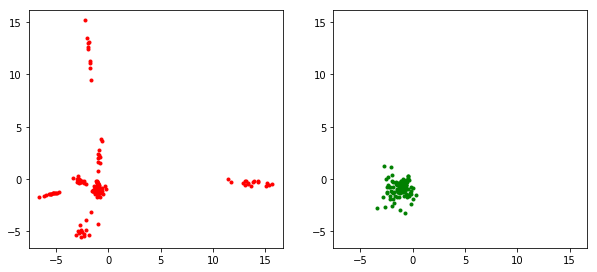

2001 [D loss: 0.452230, acc.: 80.68%] [G loss: 2.827483]
2002 [D loss: 0.480879, acc.: 81.82%] [G loss: 3.343949]
2003 [D loss: 0.476123, acc.: 77.65%] [G loss: 3.520471]
2004 [D loss: 0.436385, acc.: 81.06%] [G loss: 3.009807]
2005 [D loss: 0.491398, acc.: 82.95%] [G loss: 3.295116]
2006 [D loss: 0.433918, acc.: 84.09%] [G loss: 2.937442]
2007 [D loss: 0.465373, acc.: 79.17%] [G loss: 3.511959]
2008 [D loss: 0.455672, acc.: 81.06%] [G loss: 3.438235]
2009 [D loss: 0.489076, acc.: 76.14%] [G loss: 3.499632]
2010 [D loss: 0.433359, acc.: 81.44%] [G loss: 3.198694]
2011 [D loss: 0.473112, acc.: 78.79%] [G loss: 3.359539]
2012 [D loss: 0.437661, acc.: 81.06%] [G loss: 3.242092]
2013 [D loss: 0.469082, acc.: 78.41%] [G loss: 3.370210]
2014 [D loss: 0.414727, acc.: 83.71%] [G loss: 2.903430]
2015 [D loss: 0.436122, acc.: 83.33%] [G loss: 3.247036]
2016 [D loss: 0.445458, acc.: 82.95%] [G loss: 3.046632]
2017 [D loss: 0.436762, acc.: 81.82%] [G loss: 3.430570]
2018 [D loss: 0.442913, acc.: 7

2022 [D loss: 0.444935, acc.: 80.30%] [G loss: 3.868318]
2023 [D loss: 0.420189, acc.: 81.06%] [G loss: 3.492807]
2024 [D loss: 0.441819, acc.: 82.20%] [G loss: 3.819286]
2025 [D loss: 0.475141, acc.: 76.89%] [G loss: 3.716949]
2026 [D loss: 0.472202, acc.: 79.92%] [G loss: 3.262737]
2027 [D loss: 0.451451, acc.: 79.17%] [G loss: 3.162271]
2028 [D loss: 0.458049, acc.: 81.44%] [G loss: 3.281961]
2029 [D loss: 0.461967, acc.: 79.92%] [G loss: 2.952255]
2030 [D loss: 0.466229, acc.: 79.55%] [G loss: 2.848722]
2031 [D loss: 0.431750, acc.: 81.82%] [G loss: 3.162378]
2032 [D loss: 0.452445, acc.: 81.44%] [G loss: 3.006575]
2033 [D loss: 0.446379, acc.: 82.20%] [G loss: 3.526759]
2034 [D loss: 0.489313, acc.: 75.38%] [G loss: 3.442562]
2035 [D loss: 0.430785, acc.: 83.33%] [G loss: 3.557745]
2036 [D loss: 0.428336, acc.: 84.47%] [G loss: 3.755391]
2037 [D loss: 0.430645, acc.: 80.30%] [G loss: 3.210471]
2038 [D loss: 0.439938, acc.: 82.58%] [G loss: 3.667004]
2039 [D loss: 0.472800, acc.: 7

2044 [D loss: 0.473889, acc.: 79.55%] [G loss: 3.481651]
2045 [D loss: 0.455122, acc.: 82.20%] [G loss: 3.051721]
2046 [D loss: 0.437872, acc.: 84.09%] [G loss: 3.240253]
2047 [D loss: 0.550508, acc.: 80.68%] [G loss: 2.927106]
2048 [D loss: 0.429212, acc.: 81.06%] [G loss: 3.455044]
2049 [D loss: 0.407865, acc.: 84.09%] [G loss: 3.536445]
2050 [D loss: 0.489842, acc.: 79.92%] [G loss: 3.213238]
2051 [D loss: 0.428674, acc.: 83.33%] [G loss: 3.167019]
2052 [D loss: 0.445241, acc.: 81.82%] [G loss: 2.830950]
2053 [D loss: 0.434184, acc.: 82.58%] [G loss: 3.714807]
2054 [D loss: 0.449592, acc.: 79.17%] [G loss: 3.469321]
2055 [D loss: 0.467532, acc.: 79.55%] [G loss: 2.810959]
2056 [D loss: 0.442566, acc.: 80.68%] [G loss: 3.316394]
2057 [D loss: 0.483925, acc.: 78.41%] [G loss: 3.004218]
2058 [D loss: 0.440488, acc.: 78.41%] [G loss: 3.244759]
2059 [D loss: 0.469444, acc.: 80.30%] [G loss: 3.713594]
2060 [D loss: 0.467536, acc.: 78.03%] [G loss: 3.295443]
2061 [D loss: 0.421557, acc.: 8

2066 [D loss: 0.480163, acc.: 79.17%] [G loss: 3.425620]
2067 [D loss: 0.442282, acc.: 79.92%] [G loss: 3.435551]
2068 [D loss: 0.444738, acc.: 80.30%] [G loss: 2.986134]
2069 [D loss: 0.455225, acc.: 78.41%] [G loss: 3.251667]
2070 [D loss: 0.467132, acc.: 82.58%] [G loss: 3.840469]
2071 [D loss: 0.483851, acc.: 80.68%] [G loss: 3.257290]
2072 [D loss: 0.443472, acc.: 80.68%] [G loss: 3.216752]
2073 [D loss: 0.454911, acc.: 79.17%] [G loss: 3.073046]
2074 [D loss: 0.483635, acc.: 81.44%] [G loss: 3.508385]
2075 [D loss: 0.454063, acc.: 78.03%] [G loss: 3.250949]
2076 [D loss: 0.405698, acc.: 82.95%] [G loss: 3.159956]
2077 [D loss: 0.427698, acc.: 82.20%] [G loss: 3.427376]
2078 [D loss: 0.449432, acc.: 80.68%] [G loss: 3.555192]
2079 [D loss: 0.394915, acc.: 86.36%] [G loss: 3.812382]
2080 [D loss: 0.440898, acc.: 81.06%] [G loss: 3.218702]
2081 [D loss: 0.437582, acc.: 80.30%] [G loss: 2.997691]
2082 [D loss: 0.448376, acc.: 78.41%] [G loss: 3.650424]
2083 [D loss: 0.433145, acc.: 8

2088 [D loss: 0.466692, acc.: 78.41%] [G loss: 3.201710]
2089 [D loss: 0.423154, acc.: 81.44%] [G loss: 3.657067]
2090 [D loss: 0.460792, acc.: 76.52%] [G loss: 2.814446]
2091 [D loss: 0.423807, acc.: 84.09%] [G loss: 2.786415]
2092 [D loss: 0.434872, acc.: 81.82%] [G loss: 3.457152]
2093 [D loss: 0.437748, acc.: 80.68%] [G loss: 3.495242]
2094 [D loss: 0.430645, acc.: 82.58%] [G loss: 3.865560]
2095 [D loss: 0.449967, acc.: 79.55%] [G loss: 3.202466]
2096 [D loss: 0.441752, acc.: 81.06%] [G loss: 2.970362]
2097 [D loss: 0.460392, acc.: 82.20%] [G loss: 3.546603]
2098 [D loss: 0.454713, acc.: 79.92%] [G loss: 3.924813]
2099 [D loss: 0.409351, acc.: 82.58%] [G loss: 3.026099]
2100 [D loss: 0.461499, acc.: 75.00%] [G loss: 3.426124]
2101 [D loss: 0.428816, acc.: 83.33%] [G loss: 3.489075]
2102 [D loss: 0.428831, acc.: 82.95%] [G loss: 3.263443]
2103 [D loss: 0.428068, acc.: 82.58%] [G loss: 3.547192]
2104 [D loss: 0.468953, acc.: 81.44%] [G loss: 3.321730]
2105 [D loss: 0.424934, acc.: 8

2110 [D loss: 0.441472, acc.: 82.58%] [G loss: 3.698203]
2111 [D loss: 0.449128, acc.: 80.30%] [G loss: 3.729402]
2112 [D loss: 0.401175, acc.: 84.09%] [G loss: 3.920966]
2113 [D loss: 0.460628, acc.: 78.41%] [G loss: 3.708529]
2114 [D loss: 0.449120, acc.: 79.92%] [G loss: 3.657818]
2115 [D loss: 0.452486, acc.: 81.44%] [G loss: 3.763379]
2116 [D loss: 0.426115, acc.: 81.82%] [G loss: 3.360489]
2117 [D loss: 0.435399, acc.: 82.20%] [G loss: 3.473483]
2118 [D loss: 0.456697, acc.: 81.44%] [G loss: 3.614709]
2119 [D loss: 0.468115, acc.: 78.03%] [G loss: 3.597330]
2120 [D loss: 0.457067, acc.: 76.89%] [G loss: 3.724949]
2121 [D loss: 0.432901, acc.: 83.33%] [G loss: 3.560233]
2122 [D loss: 0.451980, acc.: 78.03%] [G loss: 3.889241]
2123 [D loss: 0.492491, acc.: 76.14%] [G loss: 4.026167]
2124 [D loss: 0.440433, acc.: 82.20%] [G loss: 3.675999]
2125 [D loss: 0.456732, acc.: 80.68%] [G loss: 3.764121]
2126 [D loss: 0.426698, acc.: 81.06%] [G loss: 3.686568]
2127 [D loss: 0.424977, acc.: 8

2132 [D loss: 0.438669, acc.: 79.17%] [G loss: 2.952687]
2133 [D loss: 0.466411, acc.: 80.68%] [G loss: 3.118458]
2134 [D loss: 0.424313, acc.: 80.30%] [G loss: 3.310173]
2135 [D loss: 0.435661, acc.: 83.33%] [G loss: 3.353968]
2136 [D loss: 0.418227, acc.: 87.12%] [G loss: 3.727025]
2137 [D loss: 0.411846, acc.: 83.33%] [G loss: 3.617183]
2138 [D loss: 0.459902, acc.: 79.55%] [G loss: 3.337309]
2139 [D loss: 0.471212, acc.: 82.20%] [G loss: 3.458226]
2140 [D loss: 0.487343, acc.: 78.79%] [G loss: 3.579541]
2141 [D loss: 0.430395, acc.: 82.20%] [G loss: 3.561474]
2142 [D loss: 0.476758, acc.: 79.17%] [G loss: 3.483532]
2143 [D loss: 0.427583, acc.: 85.23%] [G loss: 3.599489]
2144 [D loss: 0.422796, acc.: 82.95%] [G loss: 3.347947]
2145 [D loss: 0.462709, acc.: 81.82%] [G loss: 3.606271]
2146 [D loss: 0.460557, acc.: 82.20%] [G loss: 3.874944]
2147 [D loss: 0.426556, acc.: 81.44%] [G loss: 3.576621]
2148 [D loss: 0.451612, acc.: 82.58%] [G loss: 4.357336]
2149 [D loss: 0.429102, acc.: 8

2154 [D loss: 0.473179, acc.: 78.03%] [G loss: 3.986150]
2155 [D loss: 0.447723, acc.: 81.06%] [G loss: 3.637670]
2156 [D loss: 0.458843, acc.: 81.06%] [G loss: 4.204746]
2157 [D loss: 0.445943, acc.: 81.82%] [G loss: 3.195799]
2158 [D loss: 0.424571, acc.: 80.30%] [G loss: 4.035578]
2159 [D loss: 0.436215, acc.: 79.55%] [G loss: 3.184714]
2160 [D loss: 0.442598, acc.: 81.82%] [G loss: 3.219620]
2161 [D loss: 0.457493, acc.: 80.30%] [G loss: 3.657629]
2162 [D loss: 0.448017, acc.: 79.17%] [G loss: 3.656827]
2163 [D loss: 0.458324, acc.: 79.92%] [G loss: 3.695451]
2164 [D loss: 0.373244, acc.: 89.39%] [G loss: 3.073278]
2165 [D loss: 0.459759, acc.: 79.92%] [G loss: 2.862650]
2166 [D loss: 0.428970, acc.: 83.71%] [G loss: 3.913894]
2167 [D loss: 0.420712, acc.: 82.20%] [G loss: 3.308058]
2168 [D loss: 0.480925, acc.: 78.03%] [G loss: 3.506121]
2169 [D loss: 0.425295, acc.: 85.98%] [G loss: 3.594952]
2170 [D loss: 0.409601, acc.: 82.58%] [G loss: 2.969096]
2171 [D loss: 0.421933, acc.: 8

2176 [D loss: 0.410470, acc.: 83.71%] [G loss: 3.473674]
2177 [D loss: 0.449455, acc.: 80.30%] [G loss: 3.723018]
2178 [D loss: 0.409678, acc.: 83.71%] [G loss: 3.552219]
2179 [D loss: 0.423109, acc.: 81.44%] [G loss: 3.431109]
2180 [D loss: 0.426550, acc.: 81.44%] [G loss: 3.393187]
2181 [D loss: 0.459916, acc.: 83.33%] [G loss: 3.229246]
2182 [D loss: 0.427405, acc.: 80.68%] [G loss: 3.403569]
2183 [D loss: 0.494110, acc.: 79.92%] [G loss: 3.284900]
2184 [D loss: 0.458487, acc.: 82.20%] [G loss: 3.096596]
2185 [D loss: 0.418213, acc.: 84.09%] [G loss: 3.517662]
2186 [D loss: 0.430518, acc.: 82.20%] [G loss: 3.739247]
2187 [D loss: 0.461759, acc.: 79.17%] [G loss: 3.715722]
2188 [D loss: 0.461474, acc.: 79.55%] [G loss: 3.401924]
2189 [D loss: 0.444554, acc.: 81.06%] [G loss: 3.780921]
2190 [D loss: 0.419865, acc.: 83.33%] [G loss: 3.650533]
2191 [D loss: 0.430000, acc.: 84.47%] [G loss: 3.507205]
2192 [D loss: 0.486529, acc.: 79.17%] [G loss: 3.686783]
2193 [D loss: 0.418746, acc.: 8

2198 [D loss: 0.430406, acc.: 81.82%] [G loss: 3.275678]
2199 [D loss: 0.444633, acc.: 79.92%] [G loss: 3.221409]
2200 [D loss: 0.420373, acc.: 82.58%] [G loss: 3.668614]
2201 [D loss: 0.470462, acc.: 79.17%] [G loss: 3.408807]
2202 [D loss: 0.454682, acc.: 79.17%] [G loss: 3.843419]
2203 [D loss: 0.419443, acc.: 81.44%] [G loss: 3.397837]
2204 [D loss: 0.425591, acc.: 81.82%] [G loss: 3.158716]
2205 [D loss: 0.477646, acc.: 78.03%] [G loss: 3.387435]
2206 [D loss: 0.440077, acc.: 81.06%] [G loss: 3.439126]
2207 [D loss: 0.435247, acc.: 81.82%] [G loss: 4.056405]
2208 [D loss: 0.414791, acc.: 82.95%] [G loss: 3.006110]
2209 [D loss: 0.463325, acc.: 81.44%] [G loss: 3.193937]
2210 [D loss: 0.445682, acc.: 78.79%] [G loss: 3.144465]
2211 [D loss: 0.477651, acc.: 78.03%] [G loss: 3.172478]
2212 [D loss: 0.435244, acc.: 84.09%] [G loss: 3.120894]
2213 [D loss: 0.472736, acc.: 79.92%] [G loss: 3.191495]
2214 [D loss: 0.420442, acc.: 82.58%] [G loss: 3.237863]
2215 [D loss: 0.438254, acc.: 8

2220 [D loss: 0.443578, acc.: 81.44%] [G loss: 4.004115]
2221 [D loss: 0.455878, acc.: 81.44%] [G loss: 4.130013]
2222 [D loss: 0.426130, acc.: 80.68%] [G loss: 4.107785]
2223 [D loss: 0.452815, acc.: 78.41%] [G loss: 3.510379]
2224 [D loss: 0.448817, acc.: 80.68%] [G loss: 3.271803]
2225 [D loss: 0.444068, acc.: 81.44%] [G loss: 3.885463]
2226 [D loss: 0.424065, acc.: 82.20%] [G loss: 2.799509]
2227 [D loss: 0.481589, acc.: 81.44%] [G loss: 3.308821]
2228 [D loss: 0.455036, acc.: 82.58%] [G loss: 3.496644]
2229 [D loss: 0.449914, acc.: 81.44%] [G loss: 3.269554]
2230 [D loss: 0.423305, acc.: 82.58%] [G loss: 3.515164]
2231 [D loss: 0.405858, acc.: 82.20%] [G loss: 3.702389]
2232 [D loss: 0.441717, acc.: 84.47%] [G loss: 3.559681]
2233 [D loss: 0.451607, acc.: 78.79%] [G loss: 3.262130]
2234 [D loss: 0.425984, acc.: 82.20%] [G loss: 3.481375]
2235 [D loss: 0.472481, acc.: 79.92%] [G loss: 3.356863]
2236 [D loss: 0.417711, acc.: 84.09%] [G loss: 3.075342]
2237 [D loss: 0.424319, acc.: 8

2242 [D loss: 0.468346, acc.: 81.06%] [G loss: 3.223795]
2243 [D loss: 0.420570, acc.: 82.20%] [G loss: 3.619758]
2244 [D loss: 0.460789, acc.: 80.68%] [G loss: 2.795017]
2245 [D loss: 0.422555, acc.: 83.33%] [G loss: 3.365612]
2246 [D loss: 0.468087, acc.: 79.17%] [G loss: 3.673749]
2247 [D loss: 0.415778, acc.: 82.20%] [G loss: 3.779573]
2248 [D loss: 0.450274, acc.: 83.71%] [G loss: 3.469527]
2249 [D loss: 0.438777, acc.: 81.82%] [G loss: 3.175565]
2250 [D loss: 0.445888, acc.: 81.44%] [G loss: 3.631890]
2251 [D loss: 0.446746, acc.: 80.30%] [G loss: 3.348976]
2252 [D loss: 0.472306, acc.: 79.92%] [G loss: 3.400738]
2253 [D loss: 0.425677, acc.: 82.20%] [G loss: 3.515697]
2254 [D loss: 0.458398, acc.: 78.41%] [G loss: 2.923203]
2255 [D loss: 0.406980, acc.: 85.61%] [G loss: 3.959192]
2256 [D loss: 0.393378, acc.: 84.09%] [G loss: 3.633896]
2257 [D loss: 0.413112, acc.: 82.95%] [G loss: 3.212951]
2258 [D loss: 0.405241, acc.: 84.09%] [G loss: 3.093773]
2259 [D loss: 0.400448, acc.: 8

2264 [D loss: 0.472368, acc.: 78.41%] [G loss: 2.862810]
2265 [D loss: 0.415900, acc.: 83.33%] [G loss: 3.654522]
2266 [D loss: 0.461582, acc.: 81.06%] [G loss: 3.842566]
2267 [D loss: 0.453854, acc.: 81.82%] [G loss: 3.543823]
2268 [D loss: 0.470418, acc.: 77.65%] [G loss: 3.761966]
2269 [D loss: 0.463265, acc.: 75.38%] [G loss: 3.678816]
2270 [D loss: 0.431462, acc.: 85.61%] [G loss: 3.694129]
2271 [D loss: 0.441846, acc.: 80.30%] [G loss: 3.763946]
2272 [D loss: 0.431464, acc.: 81.82%] [G loss: 3.197437]
2273 [D loss: 0.464884, acc.: 79.55%] [G loss: 3.776537]
2274 [D loss: 0.428531, acc.: 80.68%] [G loss: 3.568759]
2275 [D loss: 0.445028, acc.: 83.33%] [G loss: 3.298691]
2276 [D loss: 0.446605, acc.: 81.06%] [G loss: 3.527177]
2277 [D loss: 0.458949, acc.: 78.41%] [G loss: 3.888183]
2278 [D loss: 0.411795, acc.: 83.71%] [G loss: 3.112900]
2279 [D loss: 0.457562, acc.: 76.14%] [G loss: 3.476570]
2280 [D loss: 0.431412, acc.: 81.06%] [G loss: 3.308588]
2281 [D loss: 0.424145, acc.: 8

2285 [D loss: 0.434979, acc.: 81.44%] [G loss: 3.330610]
2286 [D loss: 0.473608, acc.: 78.79%] [G loss: 3.149054]
2287 [D loss: 0.476428, acc.: 75.76%] [G loss: 3.328541]
2288 [D loss: 0.442884, acc.: 79.92%] [G loss: 3.704154]
2289 [D loss: 0.431477, acc.: 82.58%] [G loss: 3.609341]
2290 [D loss: 0.443520, acc.: 82.58%] [G loss: 3.371530]
2291 [D loss: 0.435133, acc.: 81.82%] [G loss: 3.396444]
2292 [D loss: 0.421112, acc.: 81.44%] [G loss: 3.429826]
2293 [D loss: 0.434297, acc.: 83.33%] [G loss: 3.094982]
2294 [D loss: 0.445205, acc.: 80.30%] [G loss: 3.360939]
2295 [D loss: 0.426201, acc.: 81.44%] [G loss: 3.453477]
2296 [D loss: 0.463401, acc.: 79.55%] [G loss: 3.323059]
2297 [D loss: 0.432256, acc.: 81.06%] [G loss: 3.481873]
2298 [D loss: 0.439390, acc.: 81.06%] [G loss: 3.410843]
2299 [D loss: 0.430075, acc.: 85.23%] [G loss: 3.618472]
2300 [D loss: 0.437502, acc.: 80.68%] [G loss: 3.695652]
2301 [D loss: 0.478304, acc.: 79.17%] [G loss: 3.293743]
2302 [D loss: 0.424547, acc.: 8

2307 [D loss: 0.440918, acc.: 82.20%] [G loss: 2.918031]
2308 [D loss: 0.435700, acc.: 80.30%] [G loss: 3.355068]
2309 [D loss: 0.459638, acc.: 78.41%] [G loss: 3.581470]
2310 [D loss: 0.469797, acc.: 76.52%] [G loss: 3.359686]
2311 [D loss: 0.447760, acc.: 79.55%] [G loss: 3.085048]
2312 [D loss: 0.427499, acc.: 82.20%] [G loss: 2.894733]
2313 [D loss: 0.468059, acc.: 81.06%] [G loss: 3.314117]
2314 [D loss: 0.427185, acc.: 84.47%] [G loss: 3.358242]
2315 [D loss: 0.451168, acc.: 78.03%] [G loss: 3.605815]
2316 [D loss: 0.406405, acc.: 83.71%] [G loss: 3.527050]
2317 [D loss: 0.477529, acc.: 78.41%] [G loss: 3.249545]
2318 [D loss: 0.473671, acc.: 80.30%] [G loss: 3.277064]
2319 [D loss: 0.459325, acc.: 76.14%] [G loss: 2.754003]
2320 [D loss: 0.412869, acc.: 84.85%] [G loss: 3.527925]
2321 [D loss: 0.437712, acc.: 79.55%] [G loss: 3.027833]
2322 [D loss: 0.460689, acc.: 79.55%] [G loss: 3.270972]
2323 [D loss: 0.451684, acc.: 81.44%] [G loss: 3.688976]
2324 [D loss: 0.395313, acc.: 8

2329 [D loss: 0.448414, acc.: 82.20%] [G loss: 3.501189]
2330 [D loss: 0.427167, acc.: 84.09%] [G loss: 3.068165]
2331 [D loss: 0.432193, acc.: 82.95%] [G loss: 3.672244]
2332 [D loss: 0.469198, acc.: 82.20%] [G loss: 3.131328]
2333 [D loss: 0.430742, acc.: 80.30%] [G loss: 3.356596]
2334 [D loss: 0.421250, acc.: 83.33%] [G loss: 3.499069]
2335 [D loss: 0.456465, acc.: 79.55%] [G loss: 3.278792]
2336 [D loss: 0.433360, acc.: 79.17%] [G loss: 3.586079]
2337 [D loss: 0.505015, acc.: 80.30%] [G loss: 3.348438]
2338 [D loss: 0.474793, acc.: 79.17%] [G loss: 3.303894]
2339 [D loss: 0.418110, acc.: 83.33%] [G loss: 3.119091]
2340 [D loss: 0.488611, acc.: 75.38%] [G loss: 3.352875]
2341 [D loss: 0.434278, acc.: 79.92%] [G loss: 3.364039]
2342 [D loss: 0.433616, acc.: 80.30%] [G loss: 3.676397]
2343 [D loss: 0.480326, acc.: 80.68%] [G loss: 3.421132]
2344 [D loss: 0.443969, acc.: 82.20%] [G loss: 3.494527]
2345 [D loss: 0.433932, acc.: 77.65%] [G loss: 3.120505]
2346 [D loss: 0.433947, acc.: 8

2351 [D loss: 0.428175, acc.: 84.47%] [G loss: 3.384630]
2352 [D loss: 0.431309, acc.: 85.23%] [G loss: 3.715460]
2353 [D loss: 0.426281, acc.: 84.47%] [G loss: 3.899486]
2354 [D loss: 0.431154, acc.: 82.58%] [G loss: 3.481555]
2355 [D loss: 0.456177, acc.: 81.82%] [G loss: 3.416233]
2356 [D loss: 0.458278, acc.: 79.17%] [G loss: 3.753167]
2357 [D loss: 0.415491, acc.: 83.33%] [G loss: 3.840232]
2358 [D loss: 0.464849, acc.: 77.27%] [G loss: 3.664259]
2359 [D loss: 0.444761, acc.: 83.71%] [G loss: 3.699069]
2360 [D loss: 0.415399, acc.: 82.20%] [G loss: 3.564799]
2361 [D loss: 0.413527, acc.: 81.82%] [G loss: 3.256974]
2362 [D loss: 0.428424, acc.: 81.44%] [G loss: 3.099571]
2363 [D loss: 0.406171, acc.: 84.85%] [G loss: 3.154686]
2364 [D loss: 0.412634, acc.: 83.71%] [G loss: 3.683220]
2365 [D loss: 0.430281, acc.: 82.95%] [G loss: 3.830901]
2366 [D loss: 0.452855, acc.: 80.30%] [G loss: 2.757165]
2367 [D loss: 0.470733, acc.: 81.44%] [G loss: 3.370790]
2368 [D loss: 0.448142, acc.: 7

2373 [D loss: 0.456846, acc.: 80.30%] [G loss: 3.477654]
2374 [D loss: 0.417768, acc.: 82.95%] [G loss: 3.798452]
2375 [D loss: 0.437116, acc.: 81.44%] [G loss: 3.376101]
2376 [D loss: 0.472629, acc.: 78.79%] [G loss: 3.234919]
2377 [D loss: 0.461864, acc.: 78.41%] [G loss: 3.073910]
2378 [D loss: 0.449113, acc.: 79.55%] [G loss: 3.450134]
2379 [D loss: 0.460598, acc.: 79.92%] [G loss: 3.560309]
2380 [D loss: 0.435397, acc.: 80.68%] [G loss: 3.205033]
2381 [D loss: 0.437749, acc.: 82.20%] [G loss: 3.826075]
2382 [D loss: 0.435690, acc.: 81.06%] [G loss: 3.196751]
2383 [D loss: 0.486734, acc.: 77.65%] [G loss: 3.574924]
2384 [D loss: 0.429658, acc.: 82.58%] [G loss: 3.054759]
2385 [D loss: 0.440301, acc.: 81.44%] [G loss: 3.219501]
2386 [D loss: 0.435685, acc.: 79.55%] [G loss: 3.606815]
2387 [D loss: 0.467611, acc.: 77.65%] [G loss: 3.831953]
2388 [D loss: 0.414355, acc.: 82.20%] [G loss: 3.678005]
2389 [D loss: 0.389638, acc.: 84.47%] [G loss: 3.439265]
2390 [D loss: 0.450658, acc.: 7

2394 [D loss: 0.436950, acc.: 81.82%] [G loss: 3.603275]
2395 [D loss: 0.453245, acc.: 81.06%] [G loss: 3.892691]
2396 [D loss: 0.432755, acc.: 80.68%] [G loss: 3.553375]
2397 [D loss: 0.406770, acc.: 82.95%] [G loss: 3.545853]
2398 [D loss: 0.473770, acc.: 80.30%] [G loss: 4.004866]
2399 [D loss: 0.433722, acc.: 81.82%] [G loss: 3.121192]
2400 [D loss: 0.430964, acc.: 84.09%] [G loss: 3.483695]
2401 [D loss: 0.461558, acc.: 82.20%] [G loss: 3.034342]
2402 [D loss: 0.422804, acc.: 82.95%] [G loss: 3.175685]
2403 [D loss: 0.430968, acc.: 83.33%] [G loss: 3.749325]
2404 [D loss: 0.445496, acc.: 81.82%] [G loss: 3.779634]
2405 [D loss: 0.471825, acc.: 80.30%] [G loss: 3.115385]
2406 [D loss: 0.422705, acc.: 81.82%] [G loss: 3.568527]
2407 [D loss: 0.470115, acc.: 76.14%] [G loss: 3.250597]
2408 [D loss: 0.481682, acc.: 81.44%] [G loss: 3.230828]
2409 [D loss: 0.456109, acc.: 82.20%] [G loss: 3.431459]
2410 [D loss: 0.456665, acc.: 81.06%] [G loss: 3.284488]
2411 [D loss: 0.423318, acc.: 8

2416 [D loss: 0.496480, acc.: 78.79%] [G loss: 3.450735]
2417 [D loss: 0.457559, acc.: 82.95%] [G loss: 3.417238]
2418 [D loss: 0.437987, acc.: 81.06%] [G loss: 2.868005]
2419 [D loss: 0.455893, acc.: 82.58%] [G loss: 3.214963]
2420 [D loss: 0.448446, acc.: 81.44%] [G loss: 3.740824]
2421 [D loss: 0.448703, acc.: 79.55%] [G loss: 3.793342]
2422 [D loss: 0.471635, acc.: 81.06%] [G loss: 3.486329]
2423 [D loss: 0.537699, acc.: 74.62%] [G loss: 2.675969]
2424 [D loss: 0.469390, acc.: 80.30%] [G loss: 2.926933]
2425 [D loss: 0.482994, acc.: 74.62%] [G loss: 3.239095]
2426 [D loss: 0.455492, acc.: 77.65%] [G loss: 3.317532]
2427 [D loss: 0.422158, acc.: 78.41%] [G loss: 3.218400]
2428 [D loss: 0.453024, acc.: 81.44%] [G loss: 3.402193]
2429 [D loss: 0.445249, acc.: 84.85%] [G loss: 3.086280]
2430 [D loss: 0.435160, acc.: 79.17%] [G loss: 3.618286]
2431 [D loss: 0.459169, acc.: 79.92%] [G loss: 3.394437]
2432 [D loss: 0.465554, acc.: 80.68%] [G loss: 2.521903]
2433 [D loss: 0.412648, acc.: 8

2438 [D loss: 0.428951, acc.: 83.33%] [G loss: 3.440763]
2439 [D loss: 0.473769, acc.: 78.03%] [G loss: 3.375134]
2440 [D loss: 0.479853, acc.: 80.68%] [G loss: 3.390015]
2441 [D loss: 0.462892, acc.: 80.68%] [G loss: 3.052945]
2442 [D loss: 0.425775, acc.: 79.92%] [G loss: 2.626943]
2443 [D loss: 0.457776, acc.: 82.20%] [G loss: 3.134644]
2444 [D loss: 0.417259, acc.: 82.95%] [G loss: 3.499534]
2445 [D loss: 0.448659, acc.: 82.95%] [G loss: 3.538419]
2446 [D loss: 0.502677, acc.: 78.03%] [G loss: 3.430078]
2447 [D loss: 0.441585, acc.: 80.30%] [G loss: 3.172054]
2448 [D loss: 0.418518, acc.: 82.20%] [G loss: 3.478572]
2449 [D loss: 0.481041, acc.: 78.41%] [G loss: 2.881691]
2450 [D loss: 0.434510, acc.: 81.82%] [G loss: 3.367057]
2451 [D loss: 0.449407, acc.: 79.92%] [G loss: 2.983479]
2452 [D loss: 0.451992, acc.: 78.41%] [G loss: 3.556426]
2453 [D loss: 0.445242, acc.: 78.03%] [G loss: 2.992657]
2454 [D loss: 0.445242, acc.: 83.33%] [G loss: 3.856156]
2455 [D loss: 0.449448, acc.: 7

2460 [D loss: 0.443015, acc.: 79.92%] [G loss: 3.550177]
2461 [D loss: 0.463158, acc.: 77.65%] [G loss: 2.744793]
2462 [D loss: 0.478213, acc.: 80.30%] [G loss: 2.978814]
2463 [D loss: 0.468173, acc.: 79.92%] [G loss: 3.315537]
2464 [D loss: 0.475480, acc.: 77.65%] [G loss: 3.133193]
2465 [D loss: 0.441358, acc.: 79.17%] [G loss: 3.183515]
2466 [D loss: 0.444306, acc.: 83.71%] [G loss: 3.428271]
2467 [D loss: 0.432617, acc.: 81.44%] [G loss: 3.538507]
2468 [D loss: 0.456002, acc.: 78.79%] [G loss: 3.315877]
2469 [D loss: 0.475281, acc.: 78.41%] [G loss: 3.355337]
2470 [D loss: 0.434608, acc.: 80.68%] [G loss: 2.701332]
2471 [D loss: 0.426739, acc.: 84.47%] [G loss: 2.843247]
2472 [D loss: 0.450290, acc.: 82.20%] [G loss: 2.815173]
2473 [D loss: 0.496564, acc.: 76.52%] [G loss: 3.338006]
2474 [D loss: 0.427070, acc.: 82.95%] [G loss: 3.183102]
2475 [D loss: 0.410698, acc.: 82.95%] [G loss: 2.702032]
2476 [D loss: 0.493572, acc.: 80.30%] [G loss: 2.866123]
2477 [D loss: 0.453145, acc.: 7

2481 [D loss: 0.461499, acc.: 81.44%] [G loss: 3.231347]
2482 [D loss: 0.460761, acc.: 82.20%] [G loss: 2.992086]
2483 [D loss: 0.436669, acc.: 82.95%] [G loss: 2.755177]
2484 [D loss: 0.415842, acc.: 79.55%] [G loss: 3.363068]
2485 [D loss: 0.458025, acc.: 79.55%] [G loss: 2.748437]
2486 [D loss: 0.434684, acc.: 79.92%] [G loss: 3.053024]
2487 [D loss: 0.454932, acc.: 79.17%] [G loss: 3.052198]
2488 [D loss: 0.469826, acc.: 79.92%] [G loss: 3.138861]
2489 [D loss: 0.469276, acc.: 79.55%] [G loss: 2.745248]
2490 [D loss: 0.475891, acc.: 81.06%] [G loss: 3.116460]
2491 [D loss: 0.491603, acc.: 75.38%] [G loss: 3.144836]
2492 [D loss: 0.501124, acc.: 78.03%] [G loss: 3.204290]
2493 [D loss: 0.474361, acc.: 78.03%] [G loss: 2.760286]
2494 [D loss: 0.447642, acc.: 81.44%] [G loss: 2.919445]
2495 [D loss: 0.471854, acc.: 80.68%] [G loss: 3.050848]
2496 [D loss: 0.473816, acc.: 78.41%] [G loss: 2.865201]
2497 [D loss: 0.456357, acc.: 81.06%] [G loss: 3.222054]
2498 [D loss: 0.435674, acc.: 7

2503 [D loss: 0.478179, acc.: 79.55%] [G loss: 2.944602]
2504 [D loss: 0.453364, acc.: 78.03%] [G loss: 3.255594]
2505 [D loss: 0.446599, acc.: 83.71%] [G loss: 3.441090]
2506 [D loss: 0.479990, acc.: 79.17%] [G loss: 3.430216]
2507 [D loss: 0.458891, acc.: 78.03%] [G loss: 3.265439]
2508 [D loss: 0.438412, acc.: 79.92%] [G loss: 3.185558]
2509 [D loss: 0.467752, acc.: 81.06%] [G loss: 3.322641]
2510 [D loss: 0.472632, acc.: 78.79%] [G loss: 3.681283]
2511 [D loss: 0.473527, acc.: 76.14%] [G loss: 2.924504]
2512 [D loss: 0.427870, acc.: 81.06%] [G loss: 3.081295]
2513 [D loss: 0.472727, acc.: 77.65%] [G loss: 3.670785]
2514 [D loss: 0.431477, acc.: 79.17%] [G loss: 3.153141]
2515 [D loss: 0.446190, acc.: 81.06%] [G loss: 3.184203]
2516 [D loss: 0.399834, acc.: 84.47%] [G loss: 3.866751]
2517 [D loss: 0.460785, acc.: 76.52%] [G loss: 2.802420]
2518 [D loss: 0.449840, acc.: 80.68%] [G loss: 3.286923]
2519 [D loss: 0.421397, acc.: 81.06%] [G loss: 3.199460]
2520 [D loss: 0.467451, acc.: 8

2525 [D loss: 0.439178, acc.: 79.55%] [G loss: 3.083979]
2526 [D loss: 0.442772, acc.: 81.82%] [G loss: 3.328288]
2527 [D loss: 0.402935, acc.: 82.95%] [G loss: 3.136724]
2528 [D loss: 0.458374, acc.: 79.92%] [G loss: 3.090653]
2529 [D loss: 0.441023, acc.: 83.33%] [G loss: 3.332974]
2530 [D loss: 0.481463, acc.: 78.03%] [G loss: 3.327618]
2531 [D loss: 0.430281, acc.: 81.44%] [G loss: 3.303827]
2532 [D loss: 0.456915, acc.: 82.20%] [G loss: 3.340174]
2533 [D loss: 0.441418, acc.: 82.58%] [G loss: 3.537803]
2534 [D loss: 0.431054, acc.: 82.58%] [G loss: 3.003978]
2535 [D loss: 0.468893, acc.: 79.55%] [G loss: 3.577228]
2536 [D loss: 0.442414, acc.: 82.20%] [G loss: 3.255361]
2537 [D loss: 0.408039, acc.: 84.09%] [G loss: 3.093521]
2538 [D loss: 0.492044, acc.: 79.17%] [G loss: 3.186301]
2539 [D loss: 0.471164, acc.: 78.41%] [G loss: 2.934346]
2540 [D loss: 0.438204, acc.: 81.82%] [G loss: 3.007519]
2541 [D loss: 0.498483, acc.: 74.62%] [G loss: 3.035954]
2542 [D loss: 0.460837, acc.: 8

2547 [D loss: 0.448329, acc.: 78.79%] [G loss: 2.807833]
2548 [D loss: 0.439782, acc.: 79.55%] [G loss: 3.433184]
2549 [D loss: 0.430601, acc.: 81.44%] [G loss: 3.135775]
2550 [D loss: 0.447225, acc.: 81.06%] [G loss: 3.091711]
2551 [D loss: 0.403371, acc.: 84.09%] [G loss: 3.028096]
2552 [D loss: 0.442388, acc.: 81.82%] [G loss: 2.862391]
2553 [D loss: 0.494922, acc.: 74.62%] [G loss: 3.305208]
2554 [D loss: 0.451456, acc.: 80.68%] [G loss: 3.130261]
2555 [D loss: 0.434587, acc.: 79.55%] [G loss: 3.064098]
2556 [D loss: 0.461622, acc.: 81.82%] [G loss: 3.552155]
2557 [D loss: 0.438769, acc.: 82.58%] [G loss: 3.297968]
2558 [D loss: 0.492449, acc.: 77.27%] [G loss: 2.741152]
2559 [D loss: 0.499193, acc.: 77.65%] [G loss: 2.870601]
2560 [D loss: 0.456173, acc.: 78.79%] [G loss: 2.939384]
2561 [D loss: 0.437322, acc.: 82.58%] [G loss: 2.407273]
2562 [D loss: 0.495755, acc.: 77.27%] [G loss: 3.645468]
2563 [D loss: 0.440737, acc.: 79.55%] [G loss: 3.245620]
2564 [D loss: 0.457689, acc.: 8

2569 [D loss: 0.448222, acc.: 78.03%] [G loss: 3.188221]
2570 [D loss: 0.458030, acc.: 79.17%] [G loss: 3.412585]
2571 [D loss: 0.406671, acc.: 82.95%] [G loss: 3.377226]
2572 [D loss: 0.472922, acc.: 80.68%] [G loss: 3.204920]
2573 [D loss: 0.440346, acc.: 80.30%] [G loss: 3.087411]
2574 [D loss: 0.451564, acc.: 82.95%] [G loss: 3.241302]
2575 [D loss: 0.425119, acc.: 82.20%] [G loss: 3.713555]
2576 [D loss: 0.466776, acc.: 78.41%] [G loss: 3.516227]
2577 [D loss: 0.408882, acc.: 83.33%] [G loss: 3.208385]
2578 [D loss: 0.456708, acc.: 79.17%] [G loss: 3.846181]
2579 [D loss: 0.482235, acc.: 77.27%] [G loss: 2.855252]
2580 [D loss: 0.450773, acc.: 77.65%] [G loss: 3.274316]
2581 [D loss: 0.407679, acc.: 84.09%] [G loss: 3.080638]
2582 [D loss: 0.441451, acc.: 81.82%] [G loss: 3.152473]
2583 [D loss: 0.446351, acc.: 76.52%] [G loss: 3.092297]
2584 [D loss: 0.475779, acc.: 78.03%] [G loss: 3.371010]
2585 [D loss: 0.447125, acc.: 78.79%] [G loss: 3.455117]
2586 [D loss: 0.423315, acc.: 8

2591 [D loss: 0.460533, acc.: 78.41%] [G loss: 3.424200]
2592 [D loss: 0.452430, acc.: 78.03%] [G loss: 2.775921]
2593 [D loss: 0.452331, acc.: 81.44%] [G loss: 3.710842]
2594 [D loss: 0.426420, acc.: 79.92%] [G loss: 3.103162]
2595 [D loss: 0.466815, acc.: 81.06%] [G loss: 3.330597]
2596 [D loss: 0.447302, acc.: 81.82%] [G loss: 3.180664]
2597 [D loss: 0.418795, acc.: 80.68%] [G loss: 3.123942]
2598 [D loss: 0.495177, acc.: 78.79%] [G loss: 3.035387]
2599 [D loss: 0.392216, acc.: 83.33%] [G loss: 3.251930]
2600 [D loss: 0.474979, acc.: 75.38%] [G loss: 2.630566]
2601 [D loss: 0.441993, acc.: 82.20%] [G loss: 3.704898]
2602 [D loss: 0.422390, acc.: 81.82%] [G loss: 2.736415]
2603 [D loss: 0.468807, acc.: 79.55%] [G loss: 3.606121]
2604 [D loss: 0.415830, acc.: 83.71%] [G loss: 2.639482]
2605 [D loss: 0.470994, acc.: 78.79%] [G loss: 3.068127]
2606 [D loss: 0.442414, acc.: 81.82%] [G loss: 3.012946]
2607 [D loss: 0.486214, acc.: 73.48%] [G loss: 3.276513]
2608 [D loss: 0.469274, acc.: 7

2612 [D loss: 0.450428, acc.: 82.20%] [G loss: 2.772574]
2613 [D loss: 0.462235, acc.: 80.30%] [G loss: 2.905508]
2614 [D loss: 0.468387, acc.: 73.86%] [G loss: 3.207922]
2615 [D loss: 0.436643, acc.: 81.06%] [G loss: 2.841869]
2616 [D loss: 0.476724, acc.: 76.52%] [G loss: 2.979858]
2617 [D loss: 0.409686, acc.: 81.82%] [G loss: 3.500708]
2618 [D loss: 0.473491, acc.: 77.27%] [G loss: 2.979526]
2619 [D loss: 0.430268, acc.: 80.68%] [G loss: 3.169427]
2620 [D loss: 0.506561, acc.: 76.89%] [G loss: 3.104159]
2621 [D loss: 0.449476, acc.: 78.79%] [G loss: 2.847372]
2622 [D loss: 0.444558, acc.: 82.58%] [G loss: 3.135945]
2623 [D loss: 0.417050, acc.: 81.06%] [G loss: 3.008931]
2624 [D loss: 0.450994, acc.: 81.82%] [G loss: 3.148621]
2625 [D loss: 0.400362, acc.: 84.09%] [G loss: 3.520378]
2626 [D loss: 0.429980, acc.: 82.95%] [G loss: 3.279194]
2627 [D loss: 0.470106, acc.: 79.55%] [G loss: 2.757252]
2628 [D loss: 0.474389, acc.: 75.76%] [G loss: 2.760479]
2629 [D loss: 0.442742, acc.: 8

2634 [D loss: 0.452961, acc.: 80.68%] [G loss: 2.808093]
2635 [D loss: 0.441601, acc.: 83.71%] [G loss: 2.784696]
2636 [D loss: 0.448285, acc.: 80.30%] [G loss: 2.787468]
2637 [D loss: 0.476381, acc.: 77.27%] [G loss: 3.195699]
2638 [D loss: 0.476084, acc.: 80.68%] [G loss: 3.149670]
2639 [D loss: 0.451186, acc.: 83.33%] [G loss: 3.110083]
2640 [D loss: 0.432528, acc.: 82.20%] [G loss: 3.328368]
2641 [D loss: 0.469146, acc.: 79.55%] [G loss: 3.221995]
2642 [D loss: 0.377143, acc.: 85.61%] [G loss: 3.446690]
2643 [D loss: 0.472158, acc.: 79.92%] [G loss: 2.809119]
2644 [D loss: 0.464922, acc.: 80.30%] [G loss: 3.422583]
2645 [D loss: 0.419207, acc.: 82.95%] [G loss: 2.877818]
2646 [D loss: 0.456303, acc.: 80.30%] [G loss: 3.380372]
2647 [D loss: 0.469143, acc.: 78.03%] [G loss: 3.314792]
2648 [D loss: 0.487001, acc.: 81.06%] [G loss: 3.472972]
2649 [D loss: 0.445228, acc.: 78.79%] [G loss: 2.764596]
2650 [D loss: 0.475515, acc.: 79.55%] [G loss: 3.163484]
2651 [D loss: 0.476736, acc.: 7

2656 [D loss: 0.437990, acc.: 80.68%] [G loss: 2.769066]
2657 [D loss: 0.447352, acc.: 78.79%] [G loss: 3.244681]
2658 [D loss: 0.455526, acc.: 79.92%] [G loss: 2.775088]
2659 [D loss: 0.445152, acc.: 77.27%] [G loss: 3.037266]
2660 [D loss: 0.440600, acc.: 80.68%] [G loss: 2.988538]
2661 [D loss: 0.429600, acc.: 80.30%] [G loss: 2.906620]
2662 [D loss: 0.486106, acc.: 78.41%] [G loss: 3.230465]
2663 [D loss: 0.453205, acc.: 79.92%] [G loss: 3.205440]
2664 [D loss: 0.535945, acc.: 72.35%] [G loss: 2.809818]
2665 [D loss: 0.428593, acc.: 81.82%] [G loss: 2.606213]
2666 [D loss: 0.465695, acc.: 81.82%] [G loss: 3.195949]
2667 [D loss: 0.467240, acc.: 78.79%] [G loss: 3.020947]
2668 [D loss: 0.438537, acc.: 82.58%] [G loss: 3.245171]
2669 [D loss: 0.451824, acc.: 79.92%] [G loss: 2.781773]
2670 [D loss: 0.488562, acc.: 76.52%] [G loss: 2.947863]
2671 [D loss: 0.492324, acc.: 82.58%] [G loss: 2.783782]
2672 [D loss: 0.418435, acc.: 83.33%] [G loss: 2.865682]
2673 [D loss: 0.463454, acc.: 7

2677 [D loss: 0.444584, acc.: 80.68%] [G loss: 2.999910]
2678 [D loss: 0.416146, acc.: 82.95%] [G loss: 3.385379]
2679 [D loss: 0.449257, acc.: 79.17%] [G loss: 3.277455]
2680 [D loss: 0.434457, acc.: 79.55%] [G loss: 3.091306]
2681 [D loss: 0.453514, acc.: 79.17%] [G loss: 3.094332]
2682 [D loss: 0.442289, acc.: 79.55%] [G loss: 3.087275]
2683 [D loss: 0.456956, acc.: 79.92%] [G loss: 2.967135]
2684 [D loss: 0.435223, acc.: 80.30%] [G loss: 3.003835]
2685 [D loss: 0.444158, acc.: 83.71%] [G loss: 3.397673]
2686 [D loss: 0.427463, acc.: 79.55%] [G loss: 3.328994]
2687 [D loss: 0.400986, acc.: 83.33%] [G loss: 3.268935]
2688 [D loss: 0.466378, acc.: 78.79%] [G loss: 3.468469]
2689 [D loss: 0.464927, acc.: 79.17%] [G loss: 2.784107]
2690 [D loss: 0.482593, acc.: 77.65%] [G loss: 3.338405]
2691 [D loss: 0.486787, acc.: 78.03%] [G loss: 3.294419]
2692 [D loss: 0.465449, acc.: 78.41%] [G loss: 2.791693]
2693 [D loss: 0.458080, acc.: 79.92%] [G loss: 3.261304]
2694 [D loss: 0.465404, acc.: 8

2699 [D loss: 0.441490, acc.: 79.55%] [G loss: 3.237721]
2700 [D loss: 0.431834, acc.: 79.55%] [G loss: 3.055483]
2701 [D loss: 0.422970, acc.: 82.20%] [G loss: 3.163630]
2702 [D loss: 0.428110, acc.: 80.68%] [G loss: 3.281897]
2703 [D loss: 0.455621, acc.: 80.30%] [G loss: 2.991771]
2704 [D loss: 0.453291, acc.: 79.92%] [G loss: 2.794443]
2705 [D loss: 0.415087, acc.: 83.33%] [G loss: 3.395660]
2706 [D loss: 0.399792, acc.: 85.98%] [G loss: 3.003677]
2707 [D loss: 0.455653, acc.: 80.68%] [G loss: 2.660543]
2708 [D loss: 0.453473, acc.: 77.65%] [G loss: 2.990340]
2709 [D loss: 0.472934, acc.: 76.14%] [G loss: 2.818784]
2710 [D loss: 0.527422, acc.: 75.76%] [G loss: 2.876910]
2711 [D loss: 0.467074, acc.: 77.27%] [G loss: 2.882938]
2712 [D loss: 0.451617, acc.: 82.20%] [G loss: 2.578341]
2713 [D loss: 0.441366, acc.: 81.06%] [G loss: 3.023278]
2714 [D loss: 0.461483, acc.: 80.68%] [G loss: 2.981847]
2715 [D loss: 0.390188, acc.: 82.95%] [G loss: 3.267090]
2716 [D loss: 0.432574, acc.: 8

2721 [D loss: 0.438323, acc.: 79.55%] [G loss: 2.879834]
2722 [D loss: 0.477154, acc.: 79.55%] [G loss: 2.816963]
2723 [D loss: 0.462016, acc.: 78.79%] [G loss: 2.698481]
2724 [D loss: 0.469678, acc.: 76.14%] [G loss: 3.071095]
2725 [D loss: 0.451006, acc.: 77.27%] [G loss: 3.335606]
2726 [D loss: 0.448527, acc.: 79.55%] [G loss: 2.724039]
2727 [D loss: 0.434688, acc.: 81.82%] [G loss: 2.680960]
2728 [D loss: 0.458699, acc.: 77.27%] [G loss: 3.090617]
2729 [D loss: 0.436923, acc.: 81.44%] [G loss: 3.091969]
2730 [D loss: 0.449382, acc.: 78.79%] [G loss: 3.338081]
2731 [D loss: 0.448516, acc.: 81.06%] [G loss: 2.897915]
2732 [D loss: 0.451655, acc.: 79.55%] [G loss: 3.168843]
2733 [D loss: 0.458012, acc.: 77.65%] [G loss: 3.125688]
2734 [D loss: 0.429578, acc.: 83.33%] [G loss: 3.046115]
2735 [D loss: 0.467580, acc.: 76.52%] [G loss: 2.766021]
2736 [D loss: 0.418322, acc.: 84.09%] [G loss: 3.041495]
2737 [D loss: 0.448160, acc.: 79.92%] [G loss: 2.801747]
2738 [D loss: 0.438017, acc.: 8

2743 [D loss: 0.424374, acc.: 82.58%] [G loss: 2.934570]
2744 [D loss: 0.469873, acc.: 76.89%] [G loss: 2.853060]
2745 [D loss: 0.442552, acc.: 79.92%] [G loss: 3.154339]
2746 [D loss: 0.448263, acc.: 80.30%] [G loss: 3.042457]
2747 [D loss: 0.463631, acc.: 77.65%] [G loss: 2.816067]
2748 [D loss: 0.425737, acc.: 81.82%] [G loss: 2.960807]
2749 [D loss: 0.442576, acc.: 79.17%] [G loss: 2.796229]
2750 [D loss: 0.422970, acc.: 83.33%] [G loss: 2.652946]
2751 [D loss: 0.431725, acc.: 82.58%] [G loss: 3.082477]
2752 [D loss: 0.413265, acc.: 82.58%] [G loss: 2.898678]
2753 [D loss: 0.452281, acc.: 77.27%] [G loss: 3.093083]
2754 [D loss: 0.408124, acc.: 84.85%] [G loss: 2.651378]
2755 [D loss: 0.474943, acc.: 77.65%] [G loss: 3.061116]
2756 [D loss: 0.419785, acc.: 80.68%] [G loss: 3.296592]
2757 [D loss: 0.433265, acc.: 79.55%] [G loss: 2.897730]
2758 [D loss: 0.468516, acc.: 76.52%] [G loss: 3.373950]
2759 [D loss: 0.412965, acc.: 82.20%] [G loss: 3.023401]
2760 [D loss: 0.437547, acc.: 8

2765 [D loss: 0.417063, acc.: 81.44%] [G loss: 2.855105]
2766 [D loss: 0.452978, acc.: 80.30%] [G loss: 3.193443]
2767 [D loss: 0.468515, acc.: 77.65%] [G loss: 3.047747]
2768 [D loss: 0.449514, acc.: 77.27%] [G loss: 3.106685]
2769 [D loss: 0.421954, acc.: 82.95%] [G loss: 2.839839]
2770 [D loss: 0.508164, acc.: 77.65%] [G loss: 3.106860]
2771 [D loss: 0.470823, acc.: 78.03%] [G loss: 3.460594]
2772 [D loss: 0.443586, acc.: 78.79%] [G loss: 2.865795]
2773 [D loss: 0.490909, acc.: 75.00%] [G loss: 3.484257]
2774 [D loss: 0.460310, acc.: 76.89%] [G loss: 2.718756]
2775 [D loss: 0.470249, acc.: 80.30%] [G loss: 2.584099]
2776 [D loss: 0.456490, acc.: 78.79%] [G loss: 3.055468]
2777 [D loss: 0.469076, acc.: 77.65%] [G loss: 3.356100]
2778 [D loss: 0.439207, acc.: 80.30%] [G loss: 3.561256]
2779 [D loss: 0.436835, acc.: 82.20%] [G loss: 3.023397]
2780 [D loss: 0.448051, acc.: 80.30%] [G loss: 3.740622]
2781 [D loss: 0.433468, acc.: 79.17%] [G loss: 3.241211]
2782 [D loss: 0.473368, acc.: 7

2787 [D loss: 0.428945, acc.: 81.44%] [G loss: 2.956245]
2788 [D loss: 0.456912, acc.: 78.41%] [G loss: 3.258910]
2789 [D loss: 0.429027, acc.: 79.92%] [G loss: 3.051583]
2790 [D loss: 0.438245, acc.: 82.58%] [G loss: 3.088413]
2791 [D loss: 0.441721, acc.: 81.82%] [G loss: 2.998896]
2792 [D loss: 0.435516, acc.: 81.44%] [G loss: 2.994015]
2793 [D loss: 0.447803, acc.: 80.68%] [G loss: 2.761044]
2794 [D loss: 0.456614, acc.: 78.03%] [G loss: 2.864169]
2795 [D loss: 0.463233, acc.: 76.52%] [G loss: 2.860255]
2796 [D loss: 0.414248, acc.: 83.71%] [G loss: 3.451070]
2797 [D loss: 0.431567, acc.: 81.44%] [G loss: 2.731770]
2798 [D loss: 0.448878, acc.: 80.68%] [G loss: 2.805826]
2799 [D loss: 0.432967, acc.: 82.20%] [G loss: 3.294746]
2800 [D loss: 0.460097, acc.: 83.33%] [G loss: 3.439767]
2801 [D loss: 0.464180, acc.: 78.03%] [G loss: 2.833483]
2802 [D loss: 0.440724, acc.: 78.41%] [G loss: 2.894650]
2803 [D loss: 0.425673, acc.: 80.68%] [G loss: 3.036834]
2804 [D loss: 0.457433, acc.: 7

2808 [D loss: 0.445321, acc.: 79.17%] [G loss: 3.228260]
2809 [D loss: 0.445727, acc.: 81.44%] [G loss: 2.801105]
2810 [D loss: 0.444436, acc.: 79.92%] [G loss: 3.511587]
2811 [D loss: 0.474097, acc.: 77.27%] [G loss: 2.966065]
2812 [D loss: 0.492852, acc.: 75.00%] [G loss: 3.118797]
2813 [D loss: 0.419042, acc.: 81.82%] [G loss: 3.414692]
2814 [D loss: 0.492646, acc.: 75.38%] [G loss: 3.069227]
2815 [D loss: 0.456991, acc.: 78.41%] [G loss: 2.632575]
2816 [D loss: 0.519536, acc.: 72.73%] [G loss: 2.848538]
2817 [D loss: 0.439185, acc.: 82.20%] [G loss: 3.104871]
2818 [D loss: 0.429880, acc.: 82.20%] [G loss: 3.242993]
2819 [D loss: 0.419415, acc.: 82.95%] [G loss: 3.028192]
2820 [D loss: 0.453772, acc.: 81.82%] [G loss: 2.921108]
2821 [D loss: 0.444568, acc.: 81.06%] [G loss: 3.130887]
2822 [D loss: 0.463081, acc.: 76.52%] [G loss: 2.915271]
2823 [D loss: 0.449906, acc.: 79.17%] [G loss: 2.609051]
2824 [D loss: 0.456836, acc.: 79.17%] [G loss: 2.840369]
2825 [D loss: 0.478778, acc.: 7

2830 [D loss: 0.446279, acc.: 81.06%] [G loss: 3.100092]
2831 [D loss: 0.442199, acc.: 80.68%] [G loss: 3.270565]
2832 [D loss: 0.442160, acc.: 78.79%] [G loss: 2.786797]
2833 [D loss: 0.470432, acc.: 75.38%] [G loss: 2.870887]
2834 [D loss: 0.442015, acc.: 77.65%] [G loss: 2.916865]
2835 [D loss: 0.446747, acc.: 79.92%] [G loss: 3.236161]
2836 [D loss: 0.427429, acc.: 80.68%] [G loss: 2.478988]
2837 [D loss: 0.406731, acc.: 83.33%] [G loss: 3.112059]
2838 [D loss: 0.437140, acc.: 85.98%] [G loss: 2.828048]
2839 [D loss: 0.444766, acc.: 80.68%] [G loss: 3.046911]
2840 [D loss: 0.448408, acc.: 79.92%] [G loss: 3.373792]
2841 [D loss: 0.476210, acc.: 75.38%] [G loss: 3.223857]
2842 [D loss: 0.456834, acc.: 78.79%] [G loss: 2.760821]
2843 [D loss: 0.462548, acc.: 79.17%] [G loss: 2.673301]
2844 [D loss: 0.455179, acc.: 79.55%] [G loss: 2.673210]
2845 [D loss: 0.458300, acc.: 80.30%] [G loss: 3.341548]
2846 [D loss: 0.436207, acc.: 81.44%] [G loss: 3.337558]
2847 [D loss: 0.438581, acc.: 8

2852 [D loss: 0.427760, acc.: 82.95%] [G loss: 3.009537]
2853 [D loss: 0.415651, acc.: 82.58%] [G loss: 2.696185]
2854 [D loss: 0.430452, acc.: 82.20%] [G loss: 2.444749]
2855 [D loss: 0.437048, acc.: 81.82%] [G loss: 3.103785]
2856 [D loss: 0.461185, acc.: 79.55%] [G loss: 2.803776]
2857 [D loss: 0.460194, acc.: 79.92%] [G loss: 2.959483]
2858 [D loss: 0.414737, acc.: 82.95%] [G loss: 2.875740]
2859 [D loss: 0.419867, acc.: 81.44%] [G loss: 2.546275]
2860 [D loss: 0.439036, acc.: 81.06%] [G loss: 3.177084]
2861 [D loss: 0.484883, acc.: 76.14%] [G loss: 2.697387]
2862 [D loss: 0.442097, acc.: 82.58%] [G loss: 3.096769]
2863 [D loss: 0.403171, acc.: 84.47%] [G loss: 2.774152]
2864 [D loss: 0.427886, acc.: 81.44%] [G loss: 3.078273]
2865 [D loss: 0.488966, acc.: 76.14%] [G loss: 2.399129]
2866 [D loss: 0.481989, acc.: 78.03%] [G loss: 3.120051]
2867 [D loss: 0.483740, acc.: 79.17%] [G loss: 2.816242]
2868 [D loss: 0.460415, acc.: 78.03%] [G loss: 3.104098]
2869 [D loss: 0.439186, acc.: 8

2874 [D loss: 0.470803, acc.: 77.27%] [G loss: 2.741064]
2875 [D loss: 0.441619, acc.: 80.68%] [G loss: 2.834588]
2876 [D loss: 0.475158, acc.: 76.52%] [G loss: 2.882755]
2877 [D loss: 0.438584, acc.: 79.55%] [G loss: 3.014446]
2878 [D loss: 0.443203, acc.: 78.79%] [G loss: 3.096328]
2879 [D loss: 0.431640, acc.: 79.92%] [G loss: 3.070470]
2880 [D loss: 0.474536, acc.: 77.65%] [G loss: 2.640760]
2881 [D loss: 0.424956, acc.: 81.44%] [G loss: 2.902767]
2882 [D loss: 0.456315, acc.: 82.58%] [G loss: 2.596524]
2883 [D loss: 0.452809, acc.: 78.03%] [G loss: 2.930860]
2884 [D loss: 0.425102, acc.: 83.33%] [G loss: 3.034914]
2885 [D loss: 0.459000, acc.: 79.17%] [G loss: 3.257895]
2886 [D loss: 0.417194, acc.: 81.82%] [G loss: 3.281250]
2887 [D loss: 0.462376, acc.: 76.52%] [G loss: 2.805066]
2888 [D loss: 0.451301, acc.: 79.55%] [G loss: 3.147703]
2889 [D loss: 0.434783, acc.: 81.44%] [G loss: 3.108097]
2890 [D loss: 0.440081, acc.: 79.17%] [G loss: 2.932122]
2891 [D loss: 0.433809, acc.: 8

2896 [D loss: 0.395125, acc.: 83.33%] [G loss: 3.196796]
2897 [D loss: 0.451671, acc.: 80.30%] [G loss: 3.265125]
2898 [D loss: 0.433659, acc.: 79.17%] [G loss: 3.169656]
2899 [D loss: 0.485521, acc.: 78.03%] [G loss: 3.068494]
2900 [D loss: 0.428910, acc.: 79.55%] [G loss: 3.088950]
2901 [D loss: 0.440863, acc.: 81.44%] [G loss: 2.713317]
2902 [D loss: 0.467597, acc.: 76.89%] [G loss: 3.022935]
2903 [D loss: 0.419429, acc.: 80.68%] [G loss: 2.884997]
2904 [D loss: 0.436868, acc.: 82.58%] [G loss: 3.466857]
2905 [D loss: 0.505209, acc.: 78.03%] [G loss: 3.080479]
2906 [D loss: 0.404777, acc.: 84.09%] [G loss: 3.246527]
2907 [D loss: 0.490399, acc.: 78.41%] [G loss: 3.335866]
2908 [D loss: 0.445559, acc.: 81.06%] [G loss: 2.637332]
2909 [D loss: 0.448955, acc.: 78.41%] [G loss: 2.809974]
2910 [D loss: 0.458301, acc.: 78.41%] [G loss: 3.100206]
2911 [D loss: 0.408436, acc.: 82.95%] [G loss: 3.222121]
2912 [D loss: 0.477436, acc.: 78.41%] [G loss: 3.083995]
2913 [D loss: 0.446997, acc.: 8

2918 [D loss: 0.452676, acc.: 79.92%] [G loss: 2.771677]
2919 [D loss: 0.447531, acc.: 80.30%] [G loss: 3.454623]
2920 [D loss: 0.441771, acc.: 79.17%] [G loss: 3.272400]
2921 [D loss: 0.455253, acc.: 79.55%] [G loss: 3.082031]
2922 [D loss: 0.439006, acc.: 81.06%] [G loss: 2.738018]
2923 [D loss: 0.445677, acc.: 82.20%] [G loss: 2.855400]
2924 [D loss: 0.486052, acc.: 74.24%] [G loss: 3.023130]
2925 [D loss: 0.486829, acc.: 77.27%] [G loss: 2.531816]
2926 [D loss: 0.495286, acc.: 76.14%] [G loss: 2.883660]
2927 [D loss: 0.480409, acc.: 75.38%] [G loss: 2.692303]
2928 [D loss: 0.418624, acc.: 83.33%] [G loss: 2.678940]
2929 [D loss: 0.447829, acc.: 78.03%] [G loss: 2.982259]
2930 [D loss: 0.419225, acc.: 83.33%] [G loss: 3.156096]
2931 [D loss: 0.427116, acc.: 82.20%] [G loss: 2.974927]
2932 [D loss: 0.480748, acc.: 80.68%] [G loss: 2.535131]
2933 [D loss: 0.446516, acc.: 82.20%] [G loss: 3.122460]
2934 [D loss: 0.424442, acc.: 81.82%] [G loss: 2.982329]
2935 [D loss: 0.494175, acc.: 7

2940 [D loss: 0.450764, acc.: 80.68%] [G loss: 3.014781]
2941 [D loss: 0.457817, acc.: 79.92%] [G loss: 3.050478]
2942 [D loss: 0.425680, acc.: 81.82%] [G loss: 2.862362]
2943 [D loss: 0.457054, acc.: 79.92%] [G loss: 2.741011]
2944 [D loss: 0.471396, acc.: 77.27%] [G loss: 2.855429]
2945 [D loss: 0.493052, acc.: 78.79%] [G loss: 2.967709]
2946 [D loss: 0.461539, acc.: 80.30%] [G loss: 2.743150]
2947 [D loss: 0.429642, acc.: 81.82%] [G loss: 3.234461]
2948 [D loss: 0.519806, acc.: 76.89%] [G loss: 2.877844]
2949 [D loss: 0.427721, acc.: 82.58%] [G loss: 2.875287]
2950 [D loss: 0.437123, acc.: 79.92%] [G loss: 2.479340]
2951 [D loss: 0.440881, acc.: 80.30%] [G loss: 2.962301]
2952 [D loss: 0.448611, acc.: 77.65%] [G loss: 3.191256]
2953 [D loss: 0.434523, acc.: 81.06%] [G loss: 2.894318]
2954 [D loss: 0.427935, acc.: 82.58%] [G loss: 2.713041]
2955 [D loss: 0.473018, acc.: 77.27%] [G loss: 2.989006]
2956 [D loss: 0.454206, acc.: 76.52%] [G loss: 3.348211]
2957 [D loss: 0.490833, acc.: 7

2962 [D loss: 0.453323, acc.: 78.79%] [G loss: 3.194923]
2963 [D loss: 0.433370, acc.: 80.68%] [G loss: 2.915338]
2964 [D loss: 0.475328, acc.: 77.65%] [G loss: 2.649336]
2965 [D loss: 0.412547, acc.: 83.33%] [G loss: 2.654929]
2966 [D loss: 0.499071, acc.: 73.48%] [G loss: 2.530965]
2967 [D loss: 0.423496, acc.: 82.20%] [G loss: 2.954201]
2968 [D loss: 0.451839, acc.: 78.79%] [G loss: 2.832598]
2969 [D loss: 0.430348, acc.: 80.68%] [G loss: 3.241503]
2970 [D loss: 0.447562, acc.: 79.17%] [G loss: 3.287984]
2971 [D loss: 0.463743, acc.: 78.03%] [G loss: 2.828050]
2972 [D loss: 0.462205, acc.: 75.76%] [G loss: 2.687649]
2973 [D loss: 0.467719, acc.: 79.55%] [G loss: 3.156319]
2974 [D loss: 0.503275, acc.: 76.89%] [G loss: 2.464783]
2975 [D loss: 0.456921, acc.: 79.17%] [G loss: 2.713005]
2976 [D loss: 0.424023, acc.: 83.33%] [G loss: 2.736143]
2977 [D loss: 0.442273, acc.: 77.27%] [G loss: 3.036248]
2978 [D loss: 0.414295, acc.: 84.85%] [G loss: 2.828198]
2979 [D loss: 0.487838, acc.: 7

2984 [D loss: 0.447144, acc.: 79.55%] [G loss: 3.102788]
2985 [D loss: 0.486090, acc.: 76.52%] [G loss: 3.040287]
2986 [D loss: 0.455034, acc.: 78.03%] [G loss: 2.574621]
2987 [D loss: 0.468706, acc.: 79.55%] [G loss: 3.188376]
2988 [D loss: 0.407175, acc.: 84.09%] [G loss: 2.736022]
2989 [D loss: 0.459536, acc.: 76.52%] [G loss: 2.261427]
2990 [D loss: 0.443601, acc.: 80.68%] [G loss: 2.788979]
2991 [D loss: 0.447534, acc.: 80.30%] [G loss: 2.886884]
2992 [D loss: 0.471508, acc.: 79.55%] [G loss: 3.311094]
2993 [D loss: 0.438720, acc.: 81.82%] [G loss: 3.047668]
2994 [D loss: 0.487923, acc.: 75.76%] [G loss: 3.493374]
2995 [D loss: 0.441038, acc.: 80.68%] [G loss: 3.408390]
2996 [D loss: 0.491402, acc.: 74.24%] [G loss: 3.271999]
2997 [D loss: 0.428699, acc.: 79.55%] [G loss: 2.853591]
2998 [D loss: 0.437131, acc.: 80.30%] [G loss: 2.951914]
2999 [D loss: 0.432997, acc.: 81.44%] [G loss: 3.160491]
3000 [D loss: 0.438978, acc.: 76.52%] [G loss: 2.994382]


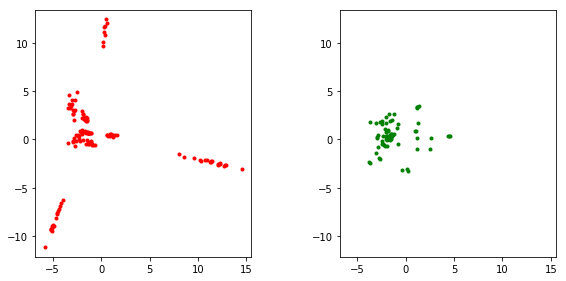

3001 [D loss: 0.450359, acc.: 77.65%] [G loss: 2.660502]
3002 [D loss: 0.428451, acc.: 81.06%] [G loss: 2.928899]
3003 [D loss: 0.434458, acc.: 81.44%] [G loss: 3.155368]
3004 [D loss: 0.450601, acc.: 78.41%] [G loss: 2.754909]
3005 [D loss: 0.475662, acc.: 77.65%] [G loss: 2.875495]
3006 [D loss: 0.438101, acc.: 84.09%] [G loss: 3.463133]
3007 [D loss: 0.485778, acc.: 76.14%] [G loss: 3.264163]
3008 [D loss: 0.450334, acc.: 80.30%] [G loss: 2.346617]
3009 [D loss: 0.449275, acc.: 78.79%] [G loss: 3.504504]
3010 [D loss: 0.460141, acc.: 79.92%] [G loss: 3.088539]
3011 [D loss: 0.501306, acc.: 75.76%] [G loss: 2.648535]
3012 [D loss: 0.454364, acc.: 80.30%] [G loss: 2.921711]
3013 [D loss: 0.426970, acc.: 80.68%] [G loss: 2.741891]
3014 [D loss: 0.475535, acc.: 78.03%] [G loss: 2.979765]
3015 [D loss: 0.474067, acc.: 77.65%] [G loss: 2.647529]
3016 [D loss: 0.405037, acc.: 82.20%] [G loss: 3.355096]
3017 [D loss: 0.452659, acc.: 77.65%] [G loss: 3.016044]
3018 [D loss: 0.419100, acc.: 8

3022 [D loss: 0.479875, acc.: 76.14%] [G loss: 2.651620]
3023 [D loss: 0.463965, acc.: 81.06%] [G loss: 2.645087]
3024 [D loss: 0.442816, acc.: 79.17%] [G loss: 3.400323]
3025 [D loss: 0.475353, acc.: 79.55%] [G loss: 2.564855]
3026 [D loss: 0.444177, acc.: 79.55%] [G loss: 2.551129]
3027 [D loss: 0.491458, acc.: 75.76%] [G loss: 3.149868]
3028 [D loss: 0.428165, acc.: 81.44%] [G loss: 2.573191]
3029 [D loss: 0.476603, acc.: 79.92%] [G loss: 2.834910]
3030 [D loss: 0.463332, acc.: 78.41%] [G loss: 3.085285]
3031 [D loss: 0.443186, acc.: 78.79%] [G loss: 2.995775]
3032 [D loss: 0.457435, acc.: 81.44%] [G loss: 3.018131]
3033 [D loss: 0.440954, acc.: 79.92%] [G loss: 2.742325]
3034 [D loss: 0.462195, acc.: 78.79%] [G loss: 2.832457]
3035 [D loss: 0.479578, acc.: 78.03%] [G loss: 2.789748]
3036 [D loss: 0.442743, acc.: 80.68%] [G loss: 2.649021]
3037 [D loss: 0.409748, acc.: 84.85%] [G loss: 3.238527]
3038 [D loss: 0.437909, acc.: 79.55%] [G loss: 2.932086]
3039 [D loss: 0.428627, acc.: 8

3044 [D loss: 0.454792, acc.: 78.03%] [G loss: 3.049531]
3045 [D loss: 0.452419, acc.: 79.55%] [G loss: 2.774155]
3046 [D loss: 0.443378, acc.: 80.68%] [G loss: 3.117038]
3047 [D loss: 0.465299, acc.: 78.03%] [G loss: 2.556102]
3048 [D loss: 0.457541, acc.: 81.06%] [G loss: 2.772653]
3049 [D loss: 0.469367, acc.: 78.79%] [G loss: 2.866449]
3050 [D loss: 0.463225, acc.: 78.03%] [G loss: 2.368244]
3051 [D loss: 0.443848, acc.: 79.92%] [G loss: 3.066582]
3052 [D loss: 0.437481, acc.: 82.20%] [G loss: 2.757104]
3053 [D loss: 0.457937, acc.: 78.41%] [G loss: 2.964171]
3054 [D loss: 0.424464, acc.: 81.82%] [G loss: 3.079691]
3055 [D loss: 0.470828, acc.: 79.92%] [G loss: 3.290533]
3056 [D loss: 0.443183, acc.: 80.68%] [G loss: 3.165587]
3057 [D loss: 0.454812, acc.: 80.68%] [G loss: 2.975794]
3058 [D loss: 0.451816, acc.: 79.17%] [G loss: 3.460644]
3059 [D loss: 0.405340, acc.: 82.95%] [G loss: 2.949331]
3060 [D loss: 0.457371, acc.: 81.82%] [G loss: 2.923492]
3061 [D loss: 0.463683, acc.: 7

3066 [D loss: 0.407769, acc.: 85.23%] [G loss: 3.074788]
3067 [D loss: 0.447713, acc.: 79.17%] [G loss: 3.609050]
3068 [D loss: 0.403201, acc.: 81.06%] [G loss: 2.794204]
3069 [D loss: 0.438324, acc.: 78.03%] [G loss: 2.708719]
3070 [D loss: 0.467037, acc.: 78.41%] [G loss: 2.950286]
3071 [D loss: 0.443915, acc.: 78.41%] [G loss: 2.763310]
3072 [D loss: 0.455289, acc.: 75.76%] [G loss: 3.031314]
3073 [D loss: 0.475604, acc.: 77.27%] [G loss: 3.009180]
3074 [D loss: 0.439836, acc.: 81.44%] [G loss: 2.727308]
3075 [D loss: 0.450839, acc.: 81.06%] [G loss: 3.219394]
3076 [D loss: 0.414912, acc.: 82.20%] [G loss: 3.045211]
3077 [D loss: 0.504209, acc.: 75.76%] [G loss: 3.147829]
3078 [D loss: 0.465903, acc.: 78.41%] [G loss: 3.085086]
3079 [D loss: 0.436583, acc.: 81.44%] [G loss: 3.044456]
3080 [D loss: 0.515673, acc.: 72.73%] [G loss: 2.675891]
3081 [D loss: 0.428958, acc.: 82.95%] [G loss: 2.735435]
3082 [D loss: 0.420830, acc.: 81.82%] [G loss: 2.722795]
3083 [D loss: 0.510605, acc.: 7

3088 [D loss: 0.421000, acc.: 81.06%] [G loss: 2.834811]
3089 [D loss: 0.471396, acc.: 76.89%] [G loss: 2.833728]
3090 [D loss: 0.464225, acc.: 76.52%] [G loss: 2.809155]
3091 [D loss: 0.441330, acc.: 80.68%] [G loss: 2.993166]
3092 [D loss: 0.438208, acc.: 82.20%] [G loss: 2.801248]
3093 [D loss: 0.476616, acc.: 79.17%] [G loss: 2.841063]
3094 [D loss: 0.467064, acc.: 78.79%] [G loss: 2.407781]
3095 [D loss: 0.408517, acc.: 82.95%] [G loss: 2.723206]
3096 [D loss: 0.444958, acc.: 79.55%] [G loss: 2.872030]
3097 [D loss: 0.416167, acc.: 83.33%] [G loss: 2.852883]
3098 [D loss: 0.466677, acc.: 79.17%] [G loss: 2.527365]
3099 [D loss: 0.461294, acc.: 75.76%] [G loss: 2.895817]
3100 [D loss: 0.472973, acc.: 78.03%] [G loss: 2.630663]
3101 [D loss: 0.446000, acc.: 79.55%] [G loss: 3.139832]
3102 [D loss: 0.469814, acc.: 77.65%] [G loss: 2.666500]
3103 [D loss: 0.425719, acc.: 80.68%] [G loss: 2.805775]
3104 [D loss: 0.457341, acc.: 78.03%] [G loss: 2.948870]
3105 [D loss: 0.451211, acc.: 7

3110 [D loss: 0.476283, acc.: 77.65%] [G loss: 3.091063]
3111 [D loss: 0.396112, acc.: 84.47%] [G loss: 2.964097]
3112 [D loss: 0.438719, acc.: 80.30%] [G loss: 3.490581]
3113 [D loss: 0.445058, acc.: 79.92%] [G loss: 2.787162]
3114 [D loss: 0.456210, acc.: 79.55%] [G loss: 3.276176]
3115 [D loss: 0.474584, acc.: 77.65%] [G loss: 3.119905]
3116 [D loss: 0.453374, acc.: 79.92%] [G loss: 2.949302]
3117 [D loss: 0.458578, acc.: 76.14%] [G loss: 2.963769]
3118 [D loss: 0.460840, acc.: 77.65%] [G loss: 2.970626]
3119 [D loss: 0.472913, acc.: 77.65%] [G loss: 3.503997]
3120 [D loss: 0.492146, acc.: 75.00%] [G loss: 2.867959]
3121 [D loss: 0.445953, acc.: 78.41%] [G loss: 3.182249]
3122 [D loss: 0.483547, acc.: 77.27%] [G loss: 3.098017]
3123 [D loss: 0.444281, acc.: 79.55%] [G loss: 2.928778]
3124 [D loss: 0.426697, acc.: 78.79%] [G loss: 3.032335]
3125 [D loss: 0.503113, acc.: 76.52%] [G loss: 2.916222]
3126 [D loss: 0.483469, acc.: 74.62%] [G loss: 3.223901]
3127 [D loss: 0.480612, acc.: 7

3132 [D loss: 0.478617, acc.: 79.92%] [G loss: 2.653607]
3133 [D loss: 0.465080, acc.: 78.03%] [G loss: 2.794035]
3134 [D loss: 0.516047, acc.: 75.38%] [G loss: 3.409993]
3135 [D loss: 0.445369, acc.: 79.55%] [G loss: 2.949073]
3136 [D loss: 0.489275, acc.: 75.38%] [G loss: 2.909804]
3137 [D loss: 0.465130, acc.: 79.92%] [G loss: 2.851573]
3138 [D loss: 0.471688, acc.: 76.89%] [G loss: 2.846481]
3139 [D loss: 0.477346, acc.: 78.79%] [G loss: 2.516320]
3140 [D loss: 0.425305, acc.: 82.95%] [G loss: 3.496567]
3141 [D loss: 0.432074, acc.: 80.68%] [G loss: 2.612723]
3142 [D loss: 0.433631, acc.: 82.95%] [G loss: 3.098437]
3143 [D loss: 0.440508, acc.: 79.92%] [G loss: 3.058511]
3144 [D loss: 0.462161, acc.: 76.52%] [G loss: 3.255879]
3145 [D loss: 0.429266, acc.: 81.82%] [G loss: 3.288787]
3146 [D loss: 0.514883, acc.: 73.86%] [G loss: 2.514734]
3147 [D loss: 0.478077, acc.: 76.89%] [G loss: 3.017448]
3148 [D loss: 0.425743, acc.: 79.55%] [G loss: 2.699608]
3149 [D loss: 0.421485, acc.: 8

3154 [D loss: 0.425017, acc.: 81.06%] [G loss: 3.303937]
3155 [D loss: 0.496814, acc.: 75.38%] [G loss: 2.518517]
3156 [D loss: 0.451000, acc.: 79.55%] [G loss: 2.573513]
3157 [D loss: 0.417535, acc.: 81.06%] [G loss: 2.694179]
3158 [D loss: 0.455535, acc.: 80.68%] [G loss: 3.031423]
3159 [D loss: 0.470336, acc.: 75.76%] [G loss: 2.919176]
3160 [D loss: 0.463019, acc.: 78.41%] [G loss: 3.347749]
3161 [D loss: 0.468043, acc.: 75.38%] [G loss: 2.897043]
3162 [D loss: 0.462212, acc.: 76.89%] [G loss: 3.464763]
3163 [D loss: 0.455952, acc.: 78.03%] [G loss: 3.205822]
3164 [D loss: 0.443711, acc.: 79.55%] [G loss: 2.703719]
3165 [D loss: 0.461844, acc.: 78.41%] [G loss: 2.725591]
3166 [D loss: 0.437410, acc.: 82.58%] [G loss: 2.682141]
3167 [D loss: 0.466903, acc.: 80.68%] [G loss: 2.903637]
3168 [D loss: 0.480596, acc.: 77.65%] [G loss: 2.914165]
3169 [D loss: 0.429042, acc.: 79.55%] [G loss: 3.181813]
3170 [D loss: 0.449982, acc.: 78.03%] [G loss: 3.348061]
3171 [D loss: 0.511185, acc.: 7

3176 [D loss: 0.454372, acc.: 78.79%] [G loss: 2.913949]
3177 [D loss: 0.421026, acc.: 79.55%] [G loss: 2.955878]
3178 [D loss: 0.411883, acc.: 80.68%] [G loss: 2.799784]
3179 [D loss: 0.451344, acc.: 79.17%] [G loss: 3.000683]
3180 [D loss: 0.430915, acc.: 81.44%] [G loss: 2.828240]
3181 [D loss: 0.456441, acc.: 79.55%] [G loss: 2.718141]
3182 [D loss: 0.424218, acc.: 79.17%] [G loss: 2.672293]
3183 [D loss: 0.467830, acc.: 76.89%] [G loss: 2.495604]
3184 [D loss: 0.520773, acc.: 76.89%] [G loss: 2.993429]
3185 [D loss: 0.406304, acc.: 82.20%] [G loss: 2.501105]
3186 [D loss: 0.446408, acc.: 79.17%] [G loss: 3.419331]
3187 [D loss: 0.458008, acc.: 78.79%] [G loss: 3.138772]
3188 [D loss: 0.435953, acc.: 81.06%] [G loss: 2.863715]
3189 [D loss: 0.447052, acc.: 79.92%] [G loss: 2.870295]
3190 [D loss: 0.449225, acc.: 80.30%] [G loss: 2.604066]
3191 [D loss: 0.465352, acc.: 78.03%] [G loss: 2.884806]
3192 [D loss: 0.483399, acc.: 76.14%] [G loss: 2.552544]
3193 [D loss: 0.448977, acc.: 7

3197 [D loss: 0.490865, acc.: 75.00%] [G loss: 2.898053]
3198 [D loss: 0.455293, acc.: 80.30%] [G loss: 3.133335]
3199 [D loss: 0.470317, acc.: 75.38%] [G loss: 2.908245]
3200 [D loss: 0.462632, acc.: 78.03%] [G loss: 3.160363]
3201 [D loss: 0.510118, acc.: 74.24%] [G loss: 2.904957]
3202 [D loss: 0.450742, acc.: 80.30%] [G loss: 3.276376]
3203 [D loss: 0.486175, acc.: 75.00%] [G loss: 2.817991]
3204 [D loss: 0.433447, acc.: 81.82%] [G loss: 2.889655]
3205 [D loss: 0.460800, acc.: 74.24%] [G loss: 3.002856]
3206 [D loss: 0.442767, acc.: 80.30%] [G loss: 2.833788]
3207 [D loss: 0.481262, acc.: 75.00%] [G loss: 2.655057]
3208 [D loss: 0.455756, acc.: 78.41%] [G loss: 2.905680]
3209 [D loss: 0.473995, acc.: 76.89%] [G loss: 3.170204]
3210 [D loss: 0.448405, acc.: 81.06%] [G loss: 2.750643]
3211 [D loss: 0.511252, acc.: 76.52%] [G loss: 2.696373]
3212 [D loss: 0.434941, acc.: 81.44%] [G loss: 3.012294]
3213 [D loss: 0.453482, acc.: 76.89%] [G loss: 3.082635]
3214 [D loss: 0.453881, acc.: 7

3219 [D loss: 0.495239, acc.: 74.24%] [G loss: 3.242349]
3220 [D loss: 0.457490, acc.: 78.41%] [G loss: 2.984858]
3221 [D loss: 0.451465, acc.: 78.03%] [G loss: 2.878486]
3222 [D loss: 0.482005, acc.: 75.76%] [G loss: 3.254745]
3223 [D loss: 0.472796, acc.: 78.41%] [G loss: 3.040821]
3224 [D loss: 0.401892, acc.: 84.85%] [G loss: 3.025106]
3225 [D loss: 0.415621, acc.: 82.58%] [G loss: 3.282082]
3226 [D loss: 0.478327, acc.: 79.92%] [G loss: 2.836580]
3227 [D loss: 0.452752, acc.: 82.58%] [G loss: 3.170024]
3228 [D loss: 0.410638, acc.: 82.95%] [G loss: 3.166328]
3229 [D loss: 0.455717, acc.: 78.79%] [G loss: 3.327627]
3230 [D loss: 0.439924, acc.: 82.20%] [G loss: 2.514591]
3231 [D loss: 0.469494, acc.: 82.58%] [G loss: 3.147867]
3232 [D loss: 0.488980, acc.: 72.73%] [G loss: 3.275152]
3233 [D loss: 0.448076, acc.: 79.17%] [G loss: 2.747059]
3234 [D loss: 0.495782, acc.: 77.65%] [G loss: 3.180147]
3235 [D loss: 0.426845, acc.: 83.33%] [G loss: 2.940971]
3236 [D loss: 0.456246, acc.: 7

3241 [D loss: 0.430867, acc.: 78.79%] [G loss: 2.800078]
3242 [D loss: 0.470584, acc.: 77.65%] [G loss: 2.992319]
3243 [D loss: 0.478018, acc.: 77.65%] [G loss: 2.786777]
3244 [D loss: 0.443810, acc.: 80.30%] [G loss: 3.138659]
3245 [D loss: 0.457658, acc.: 79.55%] [G loss: 2.728811]
3246 [D loss: 0.445037, acc.: 81.44%] [G loss: 2.896985]
3247 [D loss: 0.452193, acc.: 80.68%] [G loss: 2.821059]
3248 [D loss: 0.464703, acc.: 78.03%] [G loss: 3.760790]
3249 [D loss: 0.431415, acc.: 80.68%] [G loss: 3.657117]
3250 [D loss: 0.451717, acc.: 78.79%] [G loss: 3.265963]
3251 [D loss: 0.486414, acc.: 76.52%] [G loss: 2.592569]
3252 [D loss: 0.484528, acc.: 79.55%] [G loss: 2.703159]
3253 [D loss: 0.435182, acc.: 82.20%] [G loss: 2.746982]
3254 [D loss: 0.447543, acc.: 79.55%] [G loss: 2.697273]
3255 [D loss: 0.443129, acc.: 80.30%] [G loss: 2.676098]
3256 [D loss: 0.463255, acc.: 76.89%] [G loss: 3.163109]
3257 [D loss: 0.424469, acc.: 81.82%] [G loss: 2.963147]
3258 [D loss: 0.444345, acc.: 7

3263 [D loss: 0.420803, acc.: 81.44%] [G loss: 2.611764]
3264 [D loss: 0.436601, acc.: 78.41%] [G loss: 3.137846]
3265 [D loss: 0.425724, acc.: 83.33%] [G loss: 3.355159]
3266 [D loss: 0.452114, acc.: 79.55%] [G loss: 3.161703]
3267 [D loss: 0.424084, acc.: 80.68%] [G loss: 2.757220]
3268 [D loss: 0.449718, acc.: 80.68%] [G loss: 2.825728]
3269 [D loss: 0.430092, acc.: 81.06%] [G loss: 3.342068]
3270 [D loss: 0.477107, acc.: 78.03%] [G loss: 3.302447]
3271 [D loss: 0.424162, acc.: 82.20%] [G loss: 3.037979]
3272 [D loss: 0.450720, acc.: 78.41%] [G loss: 3.583535]
3273 [D loss: 0.504280, acc.: 75.00%] [G loss: 2.820487]
3274 [D loss: 0.442716, acc.: 82.20%] [G loss: 3.003873]
3275 [D loss: 0.454418, acc.: 77.65%] [G loss: 2.866104]
3276 [D loss: 0.487680, acc.: 75.38%] [G loss: 2.830919]
3277 [D loss: 0.443496, acc.: 81.44%] [G loss: 3.077777]
3278 [D loss: 0.432430, acc.: 77.27%] [G loss: 2.766187]
3279 [D loss: 0.470043, acc.: 80.30%] [G loss: 2.444722]
3280 [D loss: 0.457927, acc.: 7

3285 [D loss: 0.517029, acc.: 71.21%] [G loss: 3.362822]
3286 [D loss: 0.465717, acc.: 74.24%] [G loss: 3.113484]
3287 [D loss: 0.461362, acc.: 77.27%] [G loss: 2.962103]
3288 [D loss: 0.447511, acc.: 78.79%] [G loss: 2.775710]
3289 [D loss: 0.470003, acc.: 78.41%] [G loss: 2.818122]
3290 [D loss: 0.459101, acc.: 78.79%] [G loss: 3.333090]
3291 [D loss: 0.432111, acc.: 80.68%] [G loss: 3.289685]
3292 [D loss: 0.502048, acc.: 74.24%] [G loss: 2.220370]
3293 [D loss: 0.424694, acc.: 81.06%] [G loss: 2.806583]
3294 [D loss: 0.493477, acc.: 76.52%] [G loss: 3.317410]
3295 [D loss: 0.463415, acc.: 78.79%] [G loss: 3.087204]
3296 [D loss: 0.451880, acc.: 77.65%] [G loss: 2.990060]
3297 [D loss: 0.448059, acc.: 76.52%] [G loss: 3.122220]
3298 [D loss: 0.446708, acc.: 79.55%] [G loss: 3.415940]
3299 [D loss: 0.442489, acc.: 77.65%] [G loss: 2.677755]
3300 [D loss: 0.424103, acc.: 82.20%] [G loss: 3.018287]
3301 [D loss: 0.494762, acc.: 77.27%] [G loss: 2.509058]
3302 [D loss: 0.455455, acc.: 7

3307 [D loss: 0.483737, acc.: 79.55%] [G loss: 2.772681]
3308 [D loss: 0.467467, acc.: 75.76%] [G loss: 2.881862]
3309 [D loss: 0.429662, acc.: 80.30%] [G loss: 3.308594]
3310 [D loss: 0.402513, acc.: 82.58%] [G loss: 3.248315]
3311 [D loss: 0.462404, acc.: 76.89%] [G loss: 2.952385]
3312 [D loss: 0.446880, acc.: 79.17%] [G loss: 2.890838]
3313 [D loss: 0.479320, acc.: 78.79%] [G loss: 2.516501]
3314 [D loss: 0.474546, acc.: 79.92%] [G loss: 3.425679]
3315 [D loss: 0.430245, acc.: 82.58%] [G loss: 3.334565]
3316 [D loss: 0.459654, acc.: 80.30%] [G loss: 2.820263]
3317 [D loss: 0.418556, acc.: 81.06%] [G loss: 3.245872]
3318 [D loss: 0.402375, acc.: 85.23%] [G loss: 3.089929]
3319 [D loss: 0.475813, acc.: 76.52%] [G loss: 2.752179]
3320 [D loss: 0.454770, acc.: 77.27%] [G loss: 3.489943]
3321 [D loss: 0.399428, acc.: 84.85%] [G loss: 2.831037]
3322 [D loss: 0.461484, acc.: 78.41%] [G loss: 2.567515]
3323 [D loss: 0.484497, acc.: 74.24%] [G loss: 3.396698]
3324 [D loss: 0.458671, acc.: 7

3329 [D loss: 0.418587, acc.: 83.33%] [G loss: 2.944673]
3330 [D loss: 0.479496, acc.: 73.11%] [G loss: 2.608218]
3331 [D loss: 0.518636, acc.: 76.14%] [G loss: 2.704378]
3332 [D loss: 0.489299, acc.: 78.79%] [G loss: 2.783894]
3333 [D loss: 0.448574, acc.: 80.30%] [G loss: 2.642749]
3334 [D loss: 0.447898, acc.: 81.06%] [G loss: 2.605146]
3335 [D loss: 0.403464, acc.: 85.61%] [G loss: 3.137916]
3336 [D loss: 0.494064, acc.: 75.00%] [G loss: 2.797927]
3337 [D loss: 0.496804, acc.: 79.17%] [G loss: 2.489079]
3338 [D loss: 0.450511, acc.: 76.89%] [G loss: 2.820144]
3339 [D loss: 0.492466, acc.: 79.55%] [G loss: 3.136712]
3340 [D loss: 0.446590, acc.: 79.92%] [G loss: 2.985229]
3341 [D loss: 0.482844, acc.: 78.79%] [G loss: 2.910558]
3342 [D loss: 0.466574, acc.: 81.06%] [G loss: 3.261269]
3343 [D loss: 0.461835, acc.: 77.65%] [G loss: 2.595445]
3344 [D loss: 0.455915, acc.: 79.17%] [G loss: 2.990914]
3345 [D loss: 0.448349, acc.: 81.44%] [G loss: 2.284061]
3346 [D loss: 0.430937, acc.: 8

3351 [D loss: 0.462752, acc.: 79.55%] [G loss: 3.068015]
3352 [D loss: 0.427741, acc.: 80.30%] [G loss: 3.176021]
3353 [D loss: 0.492831, acc.: 75.38%] [G loss: 2.621884]
3354 [D loss: 0.463252, acc.: 78.79%] [G loss: 3.022833]
3355 [D loss: 0.422874, acc.: 80.30%] [G loss: 3.080403]
3356 [D loss: 0.466631, acc.: 79.92%] [G loss: 3.162000]
3357 [D loss: 0.442894, acc.: 81.06%] [G loss: 3.004837]
3358 [D loss: 0.481568, acc.: 79.55%] [G loss: 2.785762]
3359 [D loss: 0.479125, acc.: 74.24%] [G loss: 3.050301]
3360 [D loss: 0.447065, acc.: 79.92%] [G loss: 2.682387]
3361 [D loss: 0.471115, acc.: 77.65%] [G loss: 3.453618]
3362 [D loss: 0.474835, acc.: 77.27%] [G loss: 2.756302]
3363 [D loss: 0.443225, acc.: 81.06%] [G loss: 3.097502]
3364 [D loss: 0.440795, acc.: 80.68%] [G loss: 3.120207]
3365 [D loss: 0.476449, acc.: 76.89%] [G loss: 3.228437]
3366 [D loss: 0.465527, acc.: 82.20%] [G loss: 2.906232]
3367 [D loss: 0.463985, acc.: 79.92%] [G loss: 3.293514]
3368 [D loss: 0.448931, acc.: 7

3373 [D loss: 0.443975, acc.: 78.03%] [G loss: 3.064753]
3374 [D loss: 0.434037, acc.: 79.17%] [G loss: 2.830611]
3375 [D loss: 0.415215, acc.: 83.33%] [G loss: 2.741874]
3376 [D loss: 0.435306, acc.: 79.92%] [G loss: 3.272678]
3377 [D loss: 0.431321, acc.: 79.92%] [G loss: 2.797332]
3378 [D loss: 0.423646, acc.: 81.82%] [G loss: 2.900409]
3379 [D loss: 0.436498, acc.: 79.55%] [G loss: 2.990650]
3380 [D loss: 0.427288, acc.: 79.55%] [G loss: 2.959973]
3381 [D loss: 0.420490, acc.: 81.44%] [G loss: 3.105811]
3382 [D loss: 0.513913, acc.: 78.79%] [G loss: 3.649457]
3383 [D loss: 0.456147, acc.: 78.03%] [G loss: 3.151056]
3384 [D loss: 0.456696, acc.: 77.65%] [G loss: 3.454929]
3385 [D loss: 0.467970, acc.: 79.55%] [G loss: 3.061156]
3386 [D loss: 0.427771, acc.: 81.44%] [G loss: 2.503621]
3387 [D loss: 0.465170, acc.: 78.79%] [G loss: 2.862523]
3388 [D loss: 0.467381, acc.: 77.27%] [G loss: 3.028756]
3389 [D loss: 0.419860, acc.: 82.58%] [G loss: 3.184619]
3390 [D loss: 0.437060, acc.: 8

3395 [D loss: 0.457237, acc.: 78.41%] [G loss: 3.067687]
3396 [D loss: 0.458506, acc.: 78.79%] [G loss: 2.965632]
3397 [D loss: 0.457456, acc.: 77.27%] [G loss: 3.370553]
3398 [D loss: 0.475326, acc.: 79.55%] [G loss: 3.477715]
3399 [D loss: 0.454189, acc.: 78.03%] [G loss: 3.336729]
3400 [D loss: 0.454191, acc.: 79.92%] [G loss: 3.240657]
3401 [D loss: 0.473638, acc.: 79.55%] [G loss: 2.670165]
3402 [D loss: 0.454820, acc.: 78.03%] [G loss: 2.704924]
3403 [D loss: 0.474025, acc.: 77.27%] [G loss: 2.742093]
3404 [D loss: 0.504292, acc.: 75.76%] [G loss: 2.685847]
3405 [D loss: 0.460330, acc.: 79.92%] [G loss: 2.511863]
3406 [D loss: 0.517281, acc.: 75.76%] [G loss: 3.059737]
3407 [D loss: 0.498062, acc.: 77.27%] [G loss: 2.542449]
3408 [D loss: 0.448134, acc.: 79.92%] [G loss: 2.892240]
3409 [D loss: 0.475928, acc.: 76.14%] [G loss: 3.012716]
3410 [D loss: 0.432928, acc.: 80.68%] [G loss: 3.148406]
3411 [D loss: 0.510847, acc.: 73.48%] [G loss: 3.156223]
3412 [D loss: 0.478251, acc.: 7

3416 [D loss: 0.433556, acc.: 80.68%] [G loss: 2.969839]
3417 [D loss: 0.434258, acc.: 82.95%] [G loss: 2.768299]
3418 [D loss: 0.483184, acc.: 74.24%] [G loss: 3.545338]
3419 [D loss: 0.507465, acc.: 76.14%] [G loss: 3.094675]
3420 [D loss: 0.469998, acc.: 78.79%] [G loss: 3.258185]
3421 [D loss: 0.412159, acc.: 81.06%] [G loss: 3.166687]
3422 [D loss: 0.467880, acc.: 77.27%] [G loss: 3.254111]
3423 [D loss: 0.465132, acc.: 77.65%] [G loss: 3.389932]
3424 [D loss: 0.438417, acc.: 81.06%] [G loss: 3.067045]
3425 [D loss: 0.492746, acc.: 77.27%] [G loss: 2.817587]
3426 [D loss: 0.430684, acc.: 81.82%] [G loss: 3.287341]
3427 [D loss: 0.470122, acc.: 78.41%] [G loss: 3.282133]
3428 [D loss: 0.440061, acc.: 80.68%] [G loss: 3.210060]
3429 [D loss: 0.470182, acc.: 78.41%] [G loss: 3.061687]
3430 [D loss: 0.509171, acc.: 73.11%] [G loss: 2.650639]
3431 [D loss: 0.478374, acc.: 79.92%] [G loss: 2.999075]
3432 [D loss: 0.455344, acc.: 75.76%] [G loss: 2.801280]
3433 [D loss: 0.469770, acc.: 7

3438 [D loss: 0.439257, acc.: 79.92%] [G loss: 3.170372]
3439 [D loss: 0.459660, acc.: 78.79%] [G loss: 2.787102]
3440 [D loss: 0.457662, acc.: 76.89%] [G loss: 3.488370]
3441 [D loss: 0.487329, acc.: 78.03%] [G loss: 2.854007]
3442 [D loss: 0.483233, acc.: 79.92%] [G loss: 2.924722]
3443 [D loss: 0.467593, acc.: 76.14%] [G loss: 2.674183]
3444 [D loss: 0.454817, acc.: 80.68%] [G loss: 2.750715]
3445 [D loss: 0.469177, acc.: 78.41%] [G loss: 2.932401]
3446 [D loss: 0.464782, acc.: 79.17%] [G loss: 3.290986]
3447 [D loss: 0.432985, acc.: 83.33%] [G loss: 2.999451]
3448 [D loss: 0.430015, acc.: 81.06%] [G loss: 2.832385]
3449 [D loss: 0.411418, acc.: 81.82%] [G loss: 3.052533]
3450 [D loss: 0.450455, acc.: 78.41%] [G loss: 3.373633]
3451 [D loss: 0.427048, acc.: 81.82%] [G loss: 3.080261]
3452 [D loss: 0.475704, acc.: 75.76%] [G loss: 3.532258]
3453 [D loss: 0.437182, acc.: 82.20%] [G loss: 3.613277]
3454 [D loss: 0.438545, acc.: 83.33%] [G loss: 3.058084]
3455 [D loss: 0.455246, acc.: 7

3460 [D loss: 0.464183, acc.: 75.76%] [G loss: 3.116474]
3461 [D loss: 0.463447, acc.: 79.17%] [G loss: 3.228635]
3462 [D loss: 0.485064, acc.: 78.41%] [G loss: 3.194354]
3463 [D loss: 0.455640, acc.: 80.68%] [G loss: 2.678254]
3464 [D loss: 0.488672, acc.: 78.79%] [G loss: 3.291277]
3465 [D loss: 0.438059, acc.: 81.06%] [G loss: 3.101397]
3466 [D loss: 0.460414, acc.: 80.68%] [G loss: 3.249259]
3467 [D loss: 0.495920, acc.: 75.00%] [G loss: 3.308582]
3468 [D loss: 0.480602, acc.: 75.38%] [G loss: 3.011397]
3469 [D loss: 0.464469, acc.: 79.17%] [G loss: 2.753698]
3470 [D loss: 0.488862, acc.: 75.38%] [G loss: 2.709071]
3471 [D loss: 0.482949, acc.: 76.89%] [G loss: 2.558750]
3472 [D loss: 0.450449, acc.: 83.33%] [G loss: 2.876749]
3473 [D loss: 0.456097, acc.: 79.92%] [G loss: 3.275529]
3474 [D loss: 0.437371, acc.: 79.17%] [G loss: 2.977259]
3475 [D loss: 0.433408, acc.: 77.27%] [G loss: 2.848351]
3476 [D loss: 0.474289, acc.: 76.89%] [G loss: 3.345349]
3477 [D loss: 0.464036, acc.: 8

3481 [D loss: 0.443108, acc.: 77.27%] [G loss: 2.726275]
3482 [D loss: 0.432147, acc.: 79.92%] [G loss: 4.096516]
3483 [D loss: 0.438002, acc.: 80.30%] [G loss: 3.238760]
3484 [D loss: 0.406355, acc.: 81.82%] [G loss: 3.464315]
3485 [D loss: 0.475808, acc.: 77.65%] [G loss: 2.737228]
3486 [D loss: 0.403433, acc.: 84.09%] [G loss: 3.178487]
3487 [D loss: 0.458921, acc.: 79.55%] [G loss: 3.263427]
3488 [D loss: 0.463361, acc.: 80.30%] [G loss: 2.389217]
3489 [D loss: 0.462186, acc.: 76.89%] [G loss: 2.856953]
3490 [D loss: 0.504828, acc.: 75.38%] [G loss: 3.401919]
3491 [D loss: 0.464815, acc.: 76.52%] [G loss: 2.923331]
3492 [D loss: 0.458924, acc.: 75.00%] [G loss: 2.531977]
3493 [D loss: 0.425013, acc.: 82.20%] [G loss: 2.992405]
3494 [D loss: 0.458717, acc.: 79.17%] [G loss: 2.820448]
3495 [D loss: 0.399496, acc.: 87.12%] [G loss: 2.918717]
3496 [D loss: 0.443521, acc.: 79.17%] [G loss: 3.403422]
3497 [D loss: 0.427276, acc.: 81.44%] [G loss: 3.100576]
3498 [D loss: 0.459163, acc.: 7

3503 [D loss: 0.440563, acc.: 80.30%] [G loss: 2.616364]
3504 [D loss: 0.441199, acc.: 79.17%] [G loss: 3.002558]
3505 [D loss: 0.433254, acc.: 81.82%] [G loss: 2.619945]
3506 [D loss: 0.448630, acc.: 78.41%] [G loss: 3.399428]
3507 [D loss: 0.478782, acc.: 78.41%] [G loss: 2.807280]
3508 [D loss: 0.463931, acc.: 77.65%] [G loss: 3.037401]
3509 [D loss: 0.482510, acc.: 76.52%] [G loss: 3.460850]
3510 [D loss: 0.459607, acc.: 81.44%] [G loss: 3.006705]
3511 [D loss: 0.440160, acc.: 81.06%] [G loss: 3.099089]
3512 [D loss: 0.481912, acc.: 76.52%] [G loss: 3.273129]
3513 [D loss: 0.456823, acc.: 78.03%] [G loss: 3.068954]
3514 [D loss: 0.461531, acc.: 76.14%] [G loss: 2.765353]
3515 [D loss: 0.460746, acc.: 76.89%] [G loss: 2.932218]
3516 [D loss: 0.437186, acc.: 79.92%] [G loss: 2.422475]
3517 [D loss: 0.437634, acc.: 79.92%] [G loss: 2.851962]
3518 [D loss: 0.441082, acc.: 81.44%] [G loss: 3.125410]
3519 [D loss: 0.471458, acc.: 75.76%] [G loss: 3.285834]
3520 [D loss: 0.523665, acc.: 7

3525 [D loss: 0.487703, acc.: 79.55%] [G loss: 2.945625]
3526 [D loss: 0.465072, acc.: 79.55%] [G loss: 2.750995]
3527 [D loss: 0.410528, acc.: 83.71%] [G loss: 2.978497]
3528 [D loss: 0.471532, acc.: 82.58%] [G loss: 2.687105]
3529 [D loss: 0.463348, acc.: 79.55%] [G loss: 3.210628]
3530 [D loss: 0.449827, acc.: 77.65%] [G loss: 3.006387]
3531 [D loss: 0.437241, acc.: 81.06%] [G loss: 3.183698]
3532 [D loss: 0.480756, acc.: 78.03%] [G loss: 3.278010]
3533 [D loss: 0.463847, acc.: 78.03%] [G loss: 2.666964]
3534 [D loss: 0.503990, acc.: 71.59%] [G loss: 3.759840]
3535 [D loss: 0.459812, acc.: 81.44%] [G loss: 2.957243]
3536 [D loss: 0.449713, acc.: 81.06%] [G loss: 2.743938]
3537 [D loss: 0.462041, acc.: 80.30%] [G loss: 3.190941]
3538 [D loss: 0.447883, acc.: 80.68%] [G loss: 2.600039]
3539 [D loss: 0.449379, acc.: 80.30%] [G loss: 3.203129]
3540 [D loss: 0.455685, acc.: 79.17%] [G loss: 2.607711]
3541 [D loss: 0.452133, acc.: 81.06%] [G loss: 3.120690]
3542 [D loss: 0.486550, acc.: 7

3547 [D loss: 0.452195, acc.: 80.30%] [G loss: 3.142250]
3548 [D loss: 0.418435, acc.: 81.82%] [G loss: 2.948757]
3549 [D loss: 0.439092, acc.: 80.68%] [G loss: 3.032363]
3550 [D loss: 0.435360, acc.: 79.55%] [G loss: 3.301197]
3551 [D loss: 0.421893, acc.: 81.44%] [G loss: 2.757724]
3552 [D loss: 0.445154, acc.: 79.17%] [G loss: 2.938990]
3553 [D loss: 0.475063, acc.: 76.89%] [G loss: 2.243680]
3554 [D loss: 0.438953, acc.: 80.68%] [G loss: 2.682364]
3555 [D loss: 0.426970, acc.: 81.44%] [G loss: 3.660134]
3556 [D loss: 0.475916, acc.: 78.03%] [G loss: 2.605120]
3557 [D loss: 0.442804, acc.: 80.30%] [G loss: 2.839409]
3558 [D loss: 0.430339, acc.: 82.20%] [G loss: 2.908739]
3559 [D loss: 0.475831, acc.: 78.41%] [G loss: 2.630169]
3560 [D loss: 0.478356, acc.: 76.52%] [G loss: 3.000508]
3561 [D loss: 0.470105, acc.: 78.41%] [G loss: 2.993289]
3562 [D loss: 0.485612, acc.: 74.62%] [G loss: 2.677903]
3563 [D loss: 0.423708, acc.: 82.95%] [G loss: 2.962063]
3564 [D loss: 0.472993, acc.: 7

3569 [D loss: 0.424672, acc.: 82.95%] [G loss: 2.886054]
3570 [D loss: 0.419269, acc.: 80.30%] [G loss: 3.575887]
3571 [D loss: 0.409808, acc.: 80.68%] [G loss: 2.894142]
3572 [D loss: 0.466453, acc.: 77.27%] [G loss: 2.738205]
3573 [D loss: 0.481083, acc.: 80.68%] [G loss: 3.431414]
3574 [D loss: 0.522325, acc.: 78.41%] [G loss: 3.440095]
3575 [D loss: 0.478035, acc.: 76.89%] [G loss: 3.128531]
3576 [D loss: 0.439499, acc.: 80.68%] [G loss: 2.834100]
3577 [D loss: 0.410525, acc.: 81.06%] [G loss: 3.164381]
3578 [D loss: 0.451501, acc.: 79.55%] [G loss: 3.358605]
3579 [D loss: 0.443598, acc.: 79.92%] [G loss: 3.312927]
3580 [D loss: 0.456728, acc.: 81.82%] [G loss: 3.049328]
3581 [D loss: 0.446594, acc.: 79.17%] [G loss: 3.065175]
3582 [D loss: 0.447691, acc.: 79.17%] [G loss: 3.652233]
3583 [D loss: 0.388852, acc.: 84.47%] [G loss: 2.954111]
3584 [D loss: 0.448504, acc.: 80.30%] [G loss: 3.016834]
3585 [D loss: 0.441906, acc.: 78.41%] [G loss: 2.690045]
3586 [D loss: 0.433100, acc.: 8

3590 [D loss: 0.498076, acc.: 73.86%] [G loss: 3.094342]
3591 [D loss: 0.441951, acc.: 78.41%] [G loss: 2.860994]
3592 [D loss: 0.406478, acc.: 82.20%] [G loss: 2.950504]
3593 [D loss: 0.440271, acc.: 80.68%] [G loss: 2.888707]
3594 [D loss: 0.431841, acc.: 82.58%] [G loss: 4.098671]
3595 [D loss: 0.446017, acc.: 78.41%] [G loss: 3.230661]
3596 [D loss: 0.475936, acc.: 77.27%] [G loss: 2.977311]
3597 [D loss: 0.446832, acc.: 78.79%] [G loss: 2.737868]
3598 [D loss: 0.456627, acc.: 81.82%] [G loss: 3.021541]
3599 [D loss: 0.447501, acc.: 81.44%] [G loss: 2.650481]
3600 [D loss: 0.464376, acc.: 79.92%] [G loss: 2.364254]
3601 [D loss: 0.439002, acc.: 80.30%] [G loss: 3.096179]
3602 [D loss: 0.454537, acc.: 78.41%] [G loss: 3.212212]
3603 [D loss: 0.452535, acc.: 79.17%] [G loss: 2.944802]
3604 [D loss: 0.470695, acc.: 79.17%] [G loss: 3.115700]
3605 [D loss: 0.477074, acc.: 80.30%] [G loss: 3.007447]
3606 [D loss: 0.476694, acc.: 79.17%] [G loss: 3.054757]
3607 [D loss: 0.432101, acc.: 8

3612 [D loss: 0.390125, acc.: 84.85%] [G loss: 3.098131]
3613 [D loss: 0.505553, acc.: 76.52%] [G loss: 2.857617]
3614 [D loss: 0.436252, acc.: 76.89%] [G loss: 2.846787]
3615 [D loss: 0.411266, acc.: 83.71%] [G loss: 3.359552]
3616 [D loss: 0.436873, acc.: 79.17%] [G loss: 3.313315]
3617 [D loss: 0.443511, acc.: 78.41%] [G loss: 3.050147]
3618 [D loss: 0.451706, acc.: 79.92%] [G loss: 3.306578]
3619 [D loss: 0.440749, acc.: 80.30%] [G loss: 2.796494]
3620 [D loss: 0.490208, acc.: 79.55%] [G loss: 2.888282]
3621 [D loss: 0.426828, acc.: 82.58%] [G loss: 2.946488]
3622 [D loss: 0.452536, acc.: 81.44%] [G loss: 3.136300]
3623 [D loss: 0.459005, acc.: 81.06%] [G loss: 3.654419]
3624 [D loss: 0.426787, acc.: 82.20%] [G loss: 3.158651]
3625 [D loss: 0.495614, acc.: 78.79%] [G loss: 2.837491]
3626 [D loss: 0.485449, acc.: 79.92%] [G loss: 2.970914]
3627 [D loss: 0.468047, acc.: 76.89%] [G loss: 2.661861]
3628 [D loss: 0.427248, acc.: 80.68%] [G loss: 2.537142]
3629 [D loss: 0.509120, acc.: 7

3634 [D loss: 0.455193, acc.: 80.68%] [G loss: 2.705110]
3635 [D loss: 0.436768, acc.: 79.55%] [G loss: 3.154759]
3636 [D loss: 0.448148, acc.: 80.68%] [G loss: 3.488960]
3637 [D loss: 0.453370, acc.: 78.03%] [G loss: 3.225501]
3638 [D loss: 0.424922, acc.: 81.06%] [G loss: 2.882549]
3639 [D loss: 0.528459, acc.: 72.35%] [G loss: 2.928215]
3640 [D loss: 0.446092, acc.: 79.55%] [G loss: 3.216312]
3641 [D loss: 0.472064, acc.: 77.65%] [G loss: 3.121268]
3642 [D loss: 0.427569, acc.: 79.92%] [G loss: 2.857195]
3643 [D loss: 0.482872, acc.: 76.52%] [G loss: 2.671023]
3644 [D loss: 0.450886, acc.: 78.03%] [G loss: 3.463401]
3645 [D loss: 0.469181, acc.: 78.79%] [G loss: 3.348207]
3646 [D loss: 0.432351, acc.: 81.82%] [G loss: 3.209372]
3647 [D loss: 0.454969, acc.: 76.89%] [G loss: 3.247472]
3648 [D loss: 0.443877, acc.: 81.44%] [G loss: 3.421127]
3649 [D loss: 0.448823, acc.: 81.06%] [G loss: 3.107493]
3650 [D loss: 0.452504, acc.: 78.41%] [G loss: 2.944565]
3651 [D loss: 0.475997, acc.: 7

3656 [D loss: 0.522238, acc.: 76.52%] [G loss: 2.940483]
3657 [D loss: 0.478795, acc.: 75.76%] [G loss: 2.790871]
3658 [D loss: 0.458964, acc.: 77.65%] [G loss: 2.662914]
3659 [D loss: 0.432737, acc.: 79.92%] [G loss: 2.998973]
3660 [D loss: 0.462273, acc.: 76.89%] [G loss: 2.908815]
3661 [D loss: 0.389354, acc.: 84.85%] [G loss: 3.016001]
3662 [D loss: 0.474472, acc.: 77.65%] [G loss: 3.121192]
3663 [D loss: 0.446925, acc.: 76.89%] [G loss: 2.671494]
3664 [D loss: 0.488797, acc.: 77.27%] [G loss: 3.047153]
3665 [D loss: 0.467814, acc.: 77.65%] [G loss: 2.656285]
3666 [D loss: 0.451461, acc.: 79.92%] [G loss: 2.795320]
3667 [D loss: 0.433266, acc.: 79.17%] [G loss: 2.498714]
3668 [D loss: 0.439974, acc.: 79.55%] [G loss: 2.848711]
3669 [D loss: 0.433200, acc.: 80.68%] [G loss: 3.008274]
3670 [D loss: 0.433697, acc.: 81.06%] [G loss: 2.733689]
3671 [D loss: 0.449216, acc.: 79.55%] [G loss: 3.315182]
3672 [D loss: 0.438548, acc.: 79.17%] [G loss: 3.889745]
3673 [D loss: 0.492805, acc.: 7

3678 [D loss: 0.468754, acc.: 77.65%] [G loss: 2.868599]
3679 [D loss: 0.439518, acc.: 78.41%] [G loss: 3.003126]
3680 [D loss: 0.499226, acc.: 73.86%] [G loss: 2.662089]
3681 [D loss: 0.458349, acc.: 79.17%] [G loss: 2.446964]
3682 [D loss: 0.444155, acc.: 78.03%] [G loss: 3.109051]
3683 [D loss: 0.480476, acc.: 77.27%] [G loss: 2.671378]
3684 [D loss: 0.480004, acc.: 78.03%] [G loss: 2.413023]
3685 [D loss: 0.466531, acc.: 78.03%] [G loss: 2.782954]
3686 [D loss: 0.463485, acc.: 74.62%] [G loss: 2.972653]
3687 [D loss: 0.464003, acc.: 76.14%] [G loss: 2.468522]
3688 [D loss: 0.468252, acc.: 78.03%] [G loss: 2.739192]
3689 [D loss: 0.445972, acc.: 78.79%] [G loss: 3.333541]
3690 [D loss: 0.443157, acc.: 78.41%] [G loss: 2.679986]
3691 [D loss: 0.488933, acc.: 76.89%] [G loss: 2.745533]
3692 [D loss: 0.456068, acc.: 79.55%] [G loss: 2.778966]
3693 [D loss: 0.454146, acc.: 81.82%] [G loss: 2.973498]
3694 [D loss: 0.439373, acc.: 78.79%] [G loss: 3.052751]
3695 [D loss: 0.472147, acc.: 7

3700 [D loss: 0.461049, acc.: 79.17%] [G loss: 3.348195]
3701 [D loss: 0.436902, acc.: 80.30%] [G loss: 3.018481]
3702 [D loss: 0.461702, acc.: 77.65%] [G loss: 3.503428]
3703 [D loss: 0.412428, acc.: 81.44%] [G loss: 2.931218]
3704 [D loss: 0.456385, acc.: 78.03%] [G loss: 3.778420]
3705 [D loss: 0.434293, acc.: 79.92%] [G loss: 3.568503]
3706 [D loss: 0.524091, acc.: 71.21%] [G loss: 2.392596]
3707 [D loss: 0.432201, acc.: 80.30%] [G loss: 2.708492]
3708 [D loss: 0.486647, acc.: 76.89%] [G loss: 2.810217]
3709 [D loss: 0.472063, acc.: 78.41%] [G loss: 2.960867]
3710 [D loss: 0.463348, acc.: 77.27%] [G loss: 3.440835]
3711 [D loss: 0.491155, acc.: 75.00%] [G loss: 3.267017]
3712 [D loss: 0.428417, acc.: 80.68%] [G loss: 3.054109]
3713 [D loss: 0.447475, acc.: 81.06%] [G loss: 2.973905]
3714 [D loss: 0.474593, acc.: 76.52%] [G loss: 2.933895]
3715 [D loss: 0.463219, acc.: 78.41%] [G loss: 3.113860]
3716 [D loss: 0.467841, acc.: 78.03%] [G loss: 3.371259]
3717 [D loss: 0.475547, acc.: 7

3722 [D loss: 0.489652, acc.: 74.24%] [G loss: 2.724995]
3723 [D loss: 0.425239, acc.: 82.20%] [G loss: 3.735520]
3724 [D loss: 0.439766, acc.: 80.68%] [G loss: 2.897781]
3725 [D loss: 0.472703, acc.: 75.76%] [G loss: 2.912714]
3726 [D loss: 0.438793, acc.: 80.68%] [G loss: 3.195837]
3727 [D loss: 0.461987, acc.: 76.14%] [G loss: 3.304131]
3728 [D loss: 0.471259, acc.: 78.03%] [G loss: 3.037544]
3729 [D loss: 0.485520, acc.: 76.52%] [G loss: 3.180157]
3730 [D loss: 0.441132, acc.: 81.44%] [G loss: 3.025868]
3731 [D loss: 0.504068, acc.: 74.62%] [G loss: 2.809699]
3732 [D loss: 0.472781, acc.: 76.52%] [G loss: 3.344027]
3733 [D loss: 0.435875, acc.: 80.30%] [G loss: 2.927454]
3734 [D loss: 0.473984, acc.: 76.52%] [G loss: 3.111400]
3735 [D loss: 0.468745, acc.: 78.41%] [G loss: 3.075453]
3736 [D loss: 0.481851, acc.: 75.76%] [G loss: 3.019482]
3737 [D loss: 0.425297, acc.: 82.58%] [G loss: 2.732544]
3738 [D loss: 0.474993, acc.: 75.00%] [G loss: 2.688575]
3739 [D loss: 0.419892, acc.: 8

3744 [D loss: 0.420735, acc.: 81.44%] [G loss: 2.499018]
3745 [D loss: 0.413574, acc.: 83.71%] [G loss: 2.846641]
3746 [D loss: 0.485261, acc.: 76.89%] [G loss: 3.279689]
3747 [D loss: 0.455036, acc.: 78.79%] [G loss: 3.124779]
3748 [D loss: 0.489019, acc.: 75.76%] [G loss: 3.361527]
3749 [D loss: 0.423410, acc.: 82.95%] [G loss: 3.478711]
3750 [D loss: 0.456028, acc.: 79.17%] [G loss: 2.730759]
3751 [D loss: 0.495931, acc.: 76.52%] [G loss: 2.914939]
3752 [D loss: 0.471990, acc.: 78.79%] [G loss: 2.845645]
3753 [D loss: 0.470062, acc.: 76.89%] [G loss: 2.549567]
3754 [D loss: 0.442429, acc.: 80.68%] [G loss: 3.033059]
3755 [D loss: 0.484456, acc.: 76.89%] [G loss: 2.688559]
3756 [D loss: 0.431490, acc.: 82.20%] [G loss: 3.034076]
3757 [D loss: 0.410705, acc.: 81.82%] [G loss: 3.275862]
3758 [D loss: 0.494191, acc.: 75.00%] [G loss: 3.319376]
3759 [D loss: 0.445151, acc.: 78.79%] [G loss: 2.954581]
3760 [D loss: 0.445492, acc.: 77.65%] [G loss: 3.256253]
3761 [D loss: 0.487103, acc.: 7

3765 [D loss: 0.542135, acc.: 71.59%] [G loss: 3.358471]
3766 [D loss: 0.425392, acc.: 81.44%] [G loss: 3.074746]
3767 [D loss: 0.503928, acc.: 76.52%] [G loss: 2.752289]
3768 [D loss: 0.498465, acc.: 74.62%] [G loss: 2.885875]
3769 [D loss: 0.476177, acc.: 77.65%] [G loss: 3.004684]
3770 [D loss: 0.468235, acc.: 79.92%] [G loss: 2.691367]
3771 [D loss: 0.449442, acc.: 78.79%] [G loss: 3.522990]
3772 [D loss: 0.421306, acc.: 80.68%] [G loss: 3.454608]
3773 [D loss: 0.463787, acc.: 78.03%] [G loss: 3.041652]
3774 [D loss: 0.459125, acc.: 77.65%] [G loss: 2.744734]
3775 [D loss: 0.471153, acc.: 75.00%] [G loss: 2.622171]
3776 [D loss: 0.455340, acc.: 78.79%] [G loss: 2.780826]
3777 [D loss: 0.425154, acc.: 79.92%] [G loss: 3.127805]
3778 [D loss: 0.450691, acc.: 78.79%] [G loss: 3.462542]
3779 [D loss: 0.460829, acc.: 82.20%] [G loss: 2.894078]
3780 [D loss: 0.445540, acc.: 80.68%] [G loss: 2.775564]
3781 [D loss: 0.445759, acc.: 80.30%] [G loss: 3.056359]
3782 [D loss: 0.479087, acc.: 7

3787 [D loss: 0.460224, acc.: 78.03%] [G loss: 3.180241]
3788 [D loss: 0.449143, acc.: 78.41%] [G loss: 2.827981]
3789 [D loss: 0.473283, acc.: 78.79%] [G loss: 2.409087]
3790 [D loss: 0.458571, acc.: 81.44%] [G loss: 2.982880]
3791 [D loss: 0.444263, acc.: 80.68%] [G loss: 2.974941]
3792 [D loss: 0.453916, acc.: 76.52%] [G loss: 2.803277]
3793 [D loss: 0.463403, acc.: 78.41%] [G loss: 2.921828]
3794 [D loss: 0.465752, acc.: 78.41%] [G loss: 2.643383]
3795 [D loss: 0.429248, acc.: 81.44%] [G loss: 2.934003]
3796 [D loss: 0.490051, acc.: 76.14%] [G loss: 3.196202]
3797 [D loss: 0.477650, acc.: 75.76%] [G loss: 2.521468]
3798 [D loss: 0.415775, acc.: 82.20%] [G loss: 2.959339]
3799 [D loss: 0.450704, acc.: 81.44%] [G loss: 3.351569]
3800 [D loss: 0.509843, acc.: 75.76%] [G loss: 2.883721]
3801 [D loss: 0.422569, acc.: 81.82%] [G loss: 2.688938]
3802 [D loss: 0.454977, acc.: 76.52%] [G loss: 3.002403]
3803 [D loss: 0.481494, acc.: 75.76%] [G loss: 2.280438]
3804 [D loss: 0.457277, acc.: 7

3809 [D loss: 0.458943, acc.: 78.41%] [G loss: 3.076142]
3810 [D loss: 0.443720, acc.: 80.68%] [G loss: 3.059617]
3811 [D loss: 0.433091, acc.: 78.79%] [G loss: 3.012026]
3812 [D loss: 0.452563, acc.: 80.30%] [G loss: 2.843879]
3813 [D loss: 0.459221, acc.: 78.41%] [G loss: 2.862468]
3814 [D loss: 0.479366, acc.: 75.76%] [G loss: 2.821174]
3815 [D loss: 0.458847, acc.: 76.52%] [G loss: 3.056200]
3816 [D loss: 0.436396, acc.: 80.30%] [G loss: 2.502366]
3817 [D loss: 0.464011, acc.: 79.17%] [G loss: 3.144991]
3818 [D loss: 0.417510, acc.: 80.68%] [G loss: 3.585140]
3819 [D loss: 0.482962, acc.: 78.79%] [G loss: 2.899405]
3820 [D loss: 0.450732, acc.: 78.03%] [G loss: 2.848119]
3821 [D loss: 0.460443, acc.: 76.52%] [G loss: 2.498136]
3822 [D loss: 0.444642, acc.: 81.44%] [G loss: 2.798812]
3823 [D loss: 0.519788, acc.: 71.21%] [G loss: 2.918301]
3824 [D loss: 0.417538, acc.: 82.58%] [G loss: 3.048967]
3825 [D loss: 0.464149, acc.: 77.65%] [G loss: 2.943495]
3826 [D loss: 0.466014, acc.: 7

3831 [D loss: 0.451117, acc.: 78.03%] [G loss: 2.996948]
3832 [D loss: 0.481922, acc.: 77.27%] [G loss: 3.248193]
3833 [D loss: 0.422042, acc.: 83.71%] [G loss: 2.997992]
3834 [D loss: 0.424635, acc.: 82.95%] [G loss: 3.390472]
3835 [D loss: 0.426852, acc.: 81.82%] [G loss: 3.280210]
3836 [D loss: 0.445545, acc.: 82.95%] [G loss: 3.595152]
3837 [D loss: 0.506938, acc.: 78.03%] [G loss: 2.797201]
3838 [D loss: 0.445783, acc.: 76.52%] [G loss: 3.168933]
3839 [D loss: 0.422985, acc.: 78.03%] [G loss: 2.560950]
3840 [D loss: 0.499395, acc.: 76.52%] [G loss: 2.659386]
3841 [D loss: 0.506207, acc.: 73.86%] [G loss: 3.329473]
3842 [D loss: 0.433911, acc.: 81.44%] [G loss: 3.398760]
3843 [D loss: 0.486961, acc.: 80.30%] [G loss: 2.840651]
3844 [D loss: 0.461575, acc.: 77.27%] [G loss: 3.065449]
3845 [D loss: 0.448235, acc.: 80.30%] [G loss: 3.178292]
3846 [D loss: 0.470662, acc.: 74.62%] [G loss: 2.922533]
3847 [D loss: 0.449278, acc.: 78.41%] [G loss: 3.696352]
3848 [D loss: 0.438188, acc.: 7

3853 [D loss: 0.473010, acc.: 78.79%] [G loss: 2.979337]
3854 [D loss: 0.449389, acc.: 80.68%] [G loss: 3.158664]
3855 [D loss: 0.532022, acc.: 76.52%] [G loss: 2.775479]
3856 [D loss: 0.456456, acc.: 77.65%] [G loss: 2.815690]
3857 [D loss: 0.478736, acc.: 78.03%] [G loss: 3.256403]
3858 [D loss: 0.436880, acc.: 79.55%] [G loss: 3.094135]
3859 [D loss: 0.519996, acc.: 74.24%] [G loss: 2.869961]
3860 [D loss: 0.486768, acc.: 77.27%] [G loss: 3.213676]
3861 [D loss: 0.493478, acc.: 77.27%] [G loss: 2.887611]
3862 [D loss: 0.454418, acc.: 80.30%] [G loss: 3.082259]
3863 [D loss: 0.444869, acc.: 81.82%] [G loss: 2.827883]
3864 [D loss: 0.529092, acc.: 73.86%] [G loss: 2.744056]
3865 [D loss: 0.469226, acc.: 76.52%] [G loss: 2.386680]
3866 [D loss: 0.453820, acc.: 78.03%] [G loss: 3.582788]
3867 [D loss: 0.441574, acc.: 81.44%] [G loss: 2.778703]
3868 [D loss: 0.463215, acc.: 78.03%] [G loss: 3.206042]
3869 [D loss: 0.482702, acc.: 78.03%] [G loss: 3.578765]
3870 [D loss: 0.483802, acc.: 7

3875 [D loss: 0.464809, acc.: 76.89%] [G loss: 2.783122]
3876 [D loss: 0.476975, acc.: 77.27%] [G loss: 3.137296]
3877 [D loss: 0.459302, acc.: 78.41%] [G loss: 2.833424]
3878 [D loss: 0.474521, acc.: 76.89%] [G loss: 3.513402]
3879 [D loss: 0.477326, acc.: 78.41%] [G loss: 2.719594]
3880 [D loss: 0.448732, acc.: 77.65%] [G loss: 3.661434]
3881 [D loss: 0.437329, acc.: 81.82%] [G loss: 2.962023]
3882 [D loss: 0.463581, acc.: 75.00%] [G loss: 2.484814]
3883 [D loss: 0.503850, acc.: 75.76%] [G loss: 2.739247]
3884 [D loss: 0.500929, acc.: 75.38%] [G loss: 2.570259]
3885 [D loss: 0.480750, acc.: 75.38%] [G loss: 3.086483]
3886 [D loss: 0.592807, acc.: 71.21%] [G loss: 2.803320]
3887 [D loss: 0.457503, acc.: 77.65%] [G loss: 2.744151]
3888 [D loss: 0.494602, acc.: 76.52%] [G loss: 2.520752]
3889 [D loss: 0.469925, acc.: 78.41%] [G loss: 2.794577]
3890 [D loss: 0.451444, acc.: 79.92%] [G loss: 2.791828]
3891 [D loss: 0.405151, acc.: 85.23%] [G loss: 3.470737]
3892 [D loss: 0.471666, acc.: 7

3897 [D loss: 0.469196, acc.: 77.65%] [G loss: 2.323214]
3898 [D loss: 0.475197, acc.: 76.14%] [G loss: 2.648929]
3899 [D loss: 0.461171, acc.: 79.17%] [G loss: 3.116898]
3900 [D loss: 0.459821, acc.: 77.27%] [G loss: 2.458116]
3901 [D loss: 0.460739, acc.: 77.27%] [G loss: 3.211522]
3902 [D loss: 0.477303, acc.: 78.03%] [G loss: 3.106909]
3903 [D loss: 0.491218, acc.: 75.00%] [G loss: 3.021636]
3904 [D loss: 0.507867, acc.: 78.03%] [G loss: 2.728215]
3905 [D loss: 0.457660, acc.: 77.65%] [G loss: 2.462345]
3906 [D loss: 0.413110, acc.: 82.20%] [G loss: 2.907226]
3907 [D loss: 0.493355, acc.: 78.41%] [G loss: 3.098804]
3908 [D loss: 0.466720, acc.: 77.65%] [G loss: 3.570908]
3909 [D loss: 0.456742, acc.: 79.55%] [G loss: 2.828377]
3910 [D loss: 0.477560, acc.: 75.76%] [G loss: 3.039600]
3911 [D loss: 0.482932, acc.: 78.03%] [G loss: 2.795329]
3912 [D loss: 0.439670, acc.: 81.44%] [G loss: 3.291532]
3913 [D loss: 0.377422, acc.: 85.23%] [G loss: 3.878187]
3914 [D loss: 0.487741, acc.: 7

3919 [D loss: 0.484714, acc.: 77.65%] [G loss: 2.486925]
3920 [D loss: 0.446709, acc.: 79.92%] [G loss: 2.629612]
3921 [D loss: 0.477050, acc.: 78.41%] [G loss: 2.766319]
3922 [D loss: 0.451088, acc.: 79.55%] [G loss: 2.600266]
3923 [D loss: 0.439737, acc.: 81.44%] [G loss: 3.027609]
3924 [D loss: 0.483968, acc.: 76.52%] [G loss: 3.158486]
3925 [D loss: 0.472960, acc.: 75.00%] [G loss: 2.845373]
3926 [D loss: 0.421395, acc.: 80.68%] [G loss: 2.937420]
3927 [D loss: 0.470669, acc.: 78.41%] [G loss: 2.812143]
3928 [D loss: 0.470507, acc.: 78.79%] [G loss: 2.656418]
3929 [D loss: 0.463861, acc.: 78.41%] [G loss: 2.531596]
3930 [D loss: 0.503270, acc.: 75.38%] [G loss: 3.274042]
3931 [D loss: 0.464330, acc.: 78.41%] [G loss: 2.916880]
3932 [D loss: 0.437547, acc.: 81.06%] [G loss: 3.074647]
3933 [D loss: 0.504055, acc.: 71.97%] [G loss: 2.711132]
3934 [D loss: 0.438400, acc.: 80.30%] [G loss: 3.684349]
3935 [D loss: 0.450963, acc.: 80.30%] [G loss: 3.048140]
3936 [D loss: 0.464978, acc.: 7

3941 [D loss: 0.489210, acc.: 74.62%] [G loss: 2.691577]
3942 [D loss: 0.437882, acc.: 79.17%] [G loss: 2.946087]
3943 [D loss: 0.457399, acc.: 79.55%] [G loss: 3.112867]
3944 [D loss: 0.459526, acc.: 76.52%] [G loss: 3.058004]
3945 [D loss: 0.457636, acc.: 78.79%] [G loss: 2.903267]
3946 [D loss: 0.465595, acc.: 79.92%] [G loss: 3.253689]
3947 [D loss: 0.431527, acc.: 84.09%] [G loss: 3.259736]
3948 [D loss: 0.467329, acc.: 78.41%] [G loss: 3.328015]
3949 [D loss: 0.480053, acc.: 78.03%] [G loss: 3.006892]
3950 [D loss: 0.462492, acc.: 78.41%] [G loss: 2.795628]
3951 [D loss: 0.452854, acc.: 80.30%] [G loss: 3.344150]
3952 [D loss: 0.456882, acc.: 78.41%] [G loss: 3.410211]
3953 [D loss: 0.523808, acc.: 70.08%] [G loss: 3.263134]
3954 [D loss: 0.490244, acc.: 77.27%] [G loss: 2.811156]
3955 [D loss: 0.501460, acc.: 78.79%] [G loss: 3.403959]
3956 [D loss: 0.448550, acc.: 82.20%] [G loss: 2.980281]
3957 [D loss: 0.482107, acc.: 77.65%] [G loss: 3.458880]
3958 [D loss: 0.475866, acc.: 7

3963 [D loss: 0.495320, acc.: 77.27%] [G loss: 3.530888]
3964 [D loss: 0.433448, acc.: 79.17%] [G loss: 3.183575]
3965 [D loss: 0.484311, acc.: 79.17%] [G loss: 3.129249]
3966 [D loss: 0.453488, acc.: 80.68%] [G loss: 3.338689]
3967 [D loss: 0.439454, acc.: 81.44%] [G loss: 3.673634]
3968 [D loss: 0.455785, acc.: 78.41%] [G loss: 3.408166]
3969 [D loss: 0.480222, acc.: 78.79%] [G loss: 2.688114]
3970 [D loss: 0.468116, acc.: 79.17%] [G loss: 2.799642]
3971 [D loss: 0.492325, acc.: 77.27%] [G loss: 2.748944]
3972 [D loss: 0.513098, acc.: 73.86%] [G loss: 2.912363]
3973 [D loss: 0.452931, acc.: 80.30%] [G loss: 2.960360]
3974 [D loss: 0.486827, acc.: 76.52%] [G loss: 2.511947]
3975 [D loss: 0.492009, acc.: 74.24%] [G loss: 2.556160]
3976 [D loss: 0.447981, acc.: 79.17%] [G loss: 2.877384]
3977 [D loss: 0.520653, acc.: 71.21%] [G loss: 2.774600]
3978 [D loss: 0.474876, acc.: 76.89%] [G loss: 2.658190]
3979 [D loss: 0.444022, acc.: 79.55%] [G loss: 3.092643]
3980 [D loss: 0.448900, acc.: 7

3985 [D loss: 0.463587, acc.: 76.89%] [G loss: 2.839382]
3986 [D loss: 0.496625, acc.: 73.86%] [G loss: 2.828597]
3987 [D loss: 0.495782, acc.: 75.38%] [G loss: 3.064945]
3988 [D loss: 0.468188, acc.: 78.79%] [G loss: 3.188347]
3989 [D loss: 0.476347, acc.: 77.65%] [G loss: 3.107844]
3990 [D loss: 0.448265, acc.: 79.17%] [G loss: 3.090414]
3991 [D loss: 0.473330, acc.: 78.79%] [G loss: 2.323988]
3992 [D loss: 0.441762, acc.: 80.30%] [G loss: 2.813004]
3993 [D loss: 0.458964, acc.: 76.89%] [G loss: 3.057892]
3994 [D loss: 0.438206, acc.: 80.30%] [G loss: 2.470717]
3995 [D loss: 0.470210, acc.: 79.55%] [G loss: 3.154247]
3996 [D loss: 0.459894, acc.: 78.03%] [G loss: 2.984304]
3997 [D loss: 0.431060, acc.: 79.92%] [G loss: 3.229197]
3998 [D loss: 0.474999, acc.: 75.76%] [G loss: 4.039732]
3999 [D loss: 0.453786, acc.: 79.92%] [G loss: 3.138210]
4000 [D loss: 0.487581, acc.: 76.89%] [G loss: 3.544638]


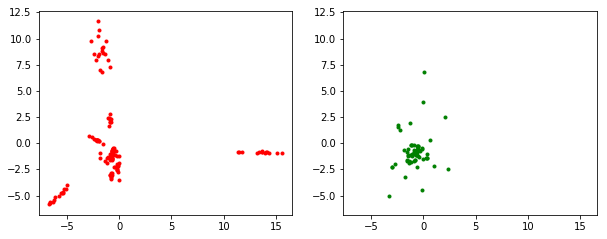

4001 [D loss: 0.439786, acc.: 79.55%] [G loss: 2.879406]
4002 [D loss: 0.475645, acc.: 76.14%] [G loss: 2.900011]
4003 [D loss: 0.448954, acc.: 78.03%] [G loss: 3.191545]
4004 [D loss: 0.461917, acc.: 76.89%] [G loss: 3.108475]
4005 [D loss: 0.429154, acc.: 79.92%] [G loss: 3.472825]
4006 [D loss: 0.489177, acc.: 76.14%] [G loss: 2.722266]
4007 [D loss: 0.441549, acc.: 79.55%] [G loss: 2.406558]
4008 [D loss: 0.418941, acc.: 81.82%] [G loss: 2.267775]
4009 [D loss: 0.464588, acc.: 79.17%] [G loss: 3.136852]
4010 [D loss: 0.435550, acc.: 78.03%] [G loss: 3.283743]
4011 [D loss: 0.455468, acc.: 81.82%] [G loss: 3.060814]
4012 [D loss: 0.473465, acc.: 78.41%] [G loss: 2.948679]
4013 [D loss: 0.472529, acc.: 79.17%] [G loss: 2.984129]
4014 [D loss: 0.433579, acc.: 78.79%] [G loss: 2.858318]
4015 [D loss: 0.531229, acc.: 74.24%] [G loss: 2.557800]
4016 [D loss: 0.477806, acc.: 77.27%] [G loss: 2.454083]
4017 [D loss: 0.437087, acc.: 78.79%] [G loss: 2.703995]
4018 [D loss: 0.427211, acc.: 7

4022 [D loss: 0.452642, acc.: 79.17%] [G loss: 3.220884]
4023 [D loss: 0.516062, acc.: 77.65%] [G loss: 2.919566]
4024 [D loss: 0.500947, acc.: 76.14%] [G loss: 2.331301]
4025 [D loss: 0.469479, acc.: 75.38%] [G loss: 2.351892]
4026 [D loss: 0.444023, acc.: 78.79%] [G loss: 2.622513]
4027 [D loss: 0.454673, acc.: 77.65%] [G loss: 3.054624]
4028 [D loss: 0.478162, acc.: 79.17%] [G loss: 2.865437]
4029 [D loss: 0.417287, acc.: 80.30%] [G loss: 2.772096]
4030 [D loss: 0.430088, acc.: 80.30%] [G loss: 2.920480]
4031 [D loss: 0.459057, acc.: 76.52%] [G loss: 2.621674]
4032 [D loss: 0.461574, acc.: 77.65%] [G loss: 3.346261]
4033 [D loss: 0.448128, acc.: 78.79%] [G loss: 3.457192]
4034 [D loss: 0.459753, acc.: 77.27%] [G loss: 2.739084]
4035 [D loss: 0.433631, acc.: 79.17%] [G loss: 2.862417]
4036 [D loss: 0.480450, acc.: 73.86%] [G loss: 3.112362]
4037 [D loss: 0.477234, acc.: 78.79%] [G loss: 3.149646]
4038 [D loss: 0.455641, acc.: 78.41%] [G loss: 3.811101]
4039 [D loss: 0.495558, acc.: 7

4044 [D loss: 0.430376, acc.: 80.30%] [G loss: 3.271827]
4045 [D loss: 0.549283, acc.: 77.65%] [G loss: 3.104676]
4046 [D loss: 0.493751, acc.: 76.14%] [G loss: 2.798148]
4047 [D loss: 0.479386, acc.: 74.24%] [G loss: 2.863578]
4048 [D loss: 0.439428, acc.: 78.79%] [G loss: 2.763891]
4049 [D loss: 0.459346, acc.: 78.79%] [G loss: 2.946981]
4050 [D loss: 0.465184, acc.: 78.79%] [G loss: 3.265732]
4051 [D loss: 0.434080, acc.: 81.06%] [G loss: 2.671892]
4052 [D loss: 0.445510, acc.: 79.17%] [G loss: 2.828938]
4053 [D loss: 0.416485, acc.: 83.33%] [G loss: 3.187678]
4054 [D loss: 0.446662, acc.: 81.44%] [G loss: 3.145520]
4055 [D loss: 0.446190, acc.: 77.27%] [G loss: 2.905836]
4056 [D loss: 0.449954, acc.: 78.41%] [G loss: 3.252429]
4057 [D loss: 0.425576, acc.: 82.58%] [G loss: 3.343495]
4058 [D loss: 0.539861, acc.: 78.03%] [G loss: 2.907361]
4059 [D loss: 0.470975, acc.: 78.79%] [G loss: 2.441916]
4060 [D loss: 0.439115, acc.: 81.44%] [G loss: 2.558618]
4061 [D loss: 0.484206, acc.: 7

4066 [D loss: 0.441380, acc.: 80.68%] [G loss: 3.339587]
4067 [D loss: 0.508456, acc.: 72.73%] [G loss: 3.292024]
4068 [D loss: 0.440034, acc.: 80.30%] [G loss: 3.074938]
4069 [D loss: 0.550773, acc.: 73.86%] [G loss: 2.377073]
4070 [D loss: 0.503683, acc.: 75.76%] [G loss: 2.976354]
4071 [D loss: 0.476007, acc.: 76.89%] [G loss: 2.586967]
4072 [D loss: 0.492924, acc.: 75.00%] [G loss: 2.236267]
4073 [D loss: 0.484782, acc.: 76.14%] [G loss: 2.973602]
4074 [D loss: 0.486271, acc.: 75.38%] [G loss: 2.859013]
4075 [D loss: 0.448801, acc.: 79.92%] [G loss: 3.272022]
4076 [D loss: 0.472532, acc.: 78.41%] [G loss: 2.986965]
4077 [D loss: 0.464593, acc.: 76.89%] [G loss: 3.780823]
4078 [D loss: 0.430192, acc.: 80.30%] [G loss: 3.502194]
4079 [D loss: 0.455791, acc.: 77.27%] [G loss: 2.922759]
4080 [D loss: 0.508538, acc.: 77.27%] [G loss: 3.179168]
4081 [D loss: 0.465508, acc.: 79.92%] [G loss: 2.938008]
4082 [D loss: 0.501095, acc.: 76.89%] [G loss: 2.740837]
4083 [D loss: 0.497277, acc.: 7

4088 [D loss: 0.489405, acc.: 76.89%] [G loss: 2.926826]
4089 [D loss: 0.465591, acc.: 78.41%] [G loss: 2.888228]
4090 [D loss: 0.446945, acc.: 79.17%] [G loss: 3.210197]
4091 [D loss: 0.467048, acc.: 77.27%] [G loss: 3.042115]
4092 [D loss: 0.451882, acc.: 76.52%] [G loss: 2.504567]
4093 [D loss: 0.472862, acc.: 75.76%] [G loss: 2.439485]
4094 [D loss: 0.483679, acc.: 79.55%] [G loss: 2.825109]
4095 [D loss: 0.425731, acc.: 80.30%] [G loss: 2.766796]
4096 [D loss: 0.446258, acc.: 79.17%] [G loss: 2.478702]
4097 [D loss: 0.481330, acc.: 75.76%] [G loss: 3.484352]
4098 [D loss: 0.484009, acc.: 78.79%] [G loss: 3.120432]
4099 [D loss: 0.459579, acc.: 79.92%] [G loss: 2.859872]
4100 [D loss: 0.425351, acc.: 82.58%] [G loss: 2.998147]
4101 [D loss: 0.482190, acc.: 79.17%] [G loss: 2.793973]
4102 [D loss: 0.568718, acc.: 75.38%] [G loss: 3.246067]
4103 [D loss: 0.450923, acc.: 80.30%] [G loss: 2.602483]
4104 [D loss: 0.417025, acc.: 81.44%] [G loss: 3.614126]
4105 [D loss: 0.556734, acc.: 7

4109 [D loss: 0.493783, acc.: 72.35%] [G loss: 2.816050]
4110 [D loss: 0.474264, acc.: 78.03%] [G loss: 3.021178]
4111 [D loss: 0.552347, acc.: 76.14%] [G loss: 3.143394]
4112 [D loss: 0.489975, acc.: 75.76%] [G loss: 2.720903]
4113 [D loss: 0.448728, acc.: 78.79%] [G loss: 2.772460]
4114 [D loss: 0.497846, acc.: 75.38%] [G loss: 2.526552]
4115 [D loss: 0.451756, acc.: 77.65%] [G loss: 3.237122]
4116 [D loss: 0.471982, acc.: 77.27%] [G loss: 3.284635]
4117 [D loss: 0.443298, acc.: 81.82%] [G loss: 2.948907]
4118 [D loss: 0.451113, acc.: 78.79%] [G loss: 3.155595]
4119 [D loss: 0.479790, acc.: 76.89%] [G loss: 3.282158]
4120 [D loss: 0.456647, acc.: 80.30%] [G loss: 3.087965]
4121 [D loss: 0.437700, acc.: 78.41%] [G loss: 3.130334]
4122 [D loss: 0.418670, acc.: 81.06%] [G loss: 2.981930]
4123 [D loss: 0.481485, acc.: 77.27%] [G loss: 3.271050]
4124 [D loss: 0.462148, acc.: 76.89%] [G loss: 3.051362]
4125 [D loss: 0.463364, acc.: 79.55%] [G loss: 2.577795]
4126 [D loss: 0.473788, acc.: 7

4131 [D loss: 0.533086, acc.: 71.97%] [G loss: 3.510517]
4132 [D loss: 0.500416, acc.: 75.76%] [G loss: 2.569216]
4133 [D loss: 0.463437, acc.: 78.79%] [G loss: 2.563658]
4134 [D loss: 0.478179, acc.: 76.52%] [G loss: 2.982555]
4135 [D loss: 0.419844, acc.: 81.82%] [G loss: 2.817684]
4136 [D loss: 0.492335, acc.: 79.17%] [G loss: 2.599884]
4137 [D loss: 0.442975, acc.: 81.06%] [G loss: 3.165001]
4138 [D loss: 0.400554, acc.: 85.61%] [G loss: 3.003922]
4139 [D loss: 0.505126, acc.: 76.52%] [G loss: 3.278294]
4140 [D loss: 0.481891, acc.: 73.86%] [G loss: 2.571418]
4141 [D loss: 0.468611, acc.: 78.41%] [G loss: 2.569814]
4142 [D loss: 0.476111, acc.: 76.14%] [G loss: 2.784538]
4143 [D loss: 0.477441, acc.: 74.24%] [G loss: 3.136760]
4144 [D loss: 0.497197, acc.: 71.97%] [G loss: 3.291415]
4145 [D loss: 0.512525, acc.: 76.52%] [G loss: 2.722613]
4146 [D loss: 0.465939, acc.: 76.52%] [G loss: 3.094203]
4147 [D loss: 0.450196, acc.: 79.17%] [G loss: 3.070619]
4148 [D loss: 0.456445, acc.: 7

4153 [D loss: 0.448924, acc.: 79.17%] [G loss: 3.114964]
4154 [D loss: 0.433741, acc.: 79.55%] [G loss: 2.776532]
4155 [D loss: 0.494287, acc.: 79.55%] [G loss: 2.528941]
4156 [D loss: 0.471219, acc.: 76.14%] [G loss: 3.130721]
4157 [D loss: 0.441162, acc.: 79.17%] [G loss: 2.871709]
4158 [D loss: 0.493069, acc.: 76.14%] [G loss: 2.612535]
4159 [D loss: 0.503201, acc.: 76.14%] [G loss: 2.711638]
4160 [D loss: 0.473316, acc.: 78.03%] [G loss: 2.882894]
4161 [D loss: 0.492363, acc.: 75.00%] [G loss: 2.951498]
4162 [D loss: 0.476823, acc.: 78.79%] [G loss: 2.393214]
4163 [D loss: 0.426118, acc.: 81.82%] [G loss: 3.054814]
4164 [D loss: 0.456264, acc.: 82.20%] [G loss: 3.180706]
4165 [D loss: 0.471830, acc.: 75.38%] [G loss: 2.804538]
4166 [D loss: 0.470174, acc.: 74.24%] [G loss: 3.545728]
4167 [D loss: 0.429023, acc.: 79.17%] [G loss: 3.086217]
4168 [D loss: 0.535386, acc.: 74.62%] [G loss: 2.969220]
4169 [D loss: 0.449029, acc.: 79.55%] [G loss: 2.955254]
4170 [D loss: 0.447727, acc.: 8

4175 [D loss: 0.472057, acc.: 76.89%] [G loss: 3.258499]
4176 [D loss: 0.480221, acc.: 78.41%] [G loss: 3.000921]
4177 [D loss: 0.438683, acc.: 81.44%] [G loss: 3.011011]
4178 [D loss: 0.417347, acc.: 79.92%] [G loss: 2.973474]
4179 [D loss: 0.449623, acc.: 77.27%] [G loss: 2.990150]
4180 [D loss: 0.496013, acc.: 76.89%] [G loss: 2.488864]
4181 [D loss: 0.498722, acc.: 76.52%] [G loss: 2.720797]
4182 [D loss: 0.459273, acc.: 77.27%] [G loss: 3.124424]
4183 [D loss: 0.447376, acc.: 79.17%] [G loss: 3.176350]
4184 [D loss: 0.502158, acc.: 76.14%] [G loss: 2.825150]
4185 [D loss: 0.438891, acc.: 79.55%] [G loss: 3.447460]
4186 [D loss: 0.471534, acc.: 75.38%] [G loss: 3.348292]
4187 [D loss: 0.467101, acc.: 78.79%] [G loss: 3.217615]
4188 [D loss: 0.455602, acc.: 81.06%] [G loss: 2.756769]
4189 [D loss: 0.505513, acc.: 73.86%] [G loss: 2.724499]
4190 [D loss: 0.477001, acc.: 76.14%] [G loss: 3.062243]
4191 [D loss: 0.456218, acc.: 79.17%] [G loss: 2.714228]
4192 [D loss: 0.516425, acc.: 7

4197 [D loss: 0.485702, acc.: 78.41%] [G loss: 3.014835]
4198 [D loss: 0.506215, acc.: 73.11%] [G loss: 3.075408]
4199 [D loss: 0.501593, acc.: 78.79%] [G loss: 3.111185]
4200 [D loss: 0.492328, acc.: 76.52%] [G loss: 2.640306]
4201 [D loss: 0.488712, acc.: 78.03%] [G loss: 2.603439]
4202 [D loss: 0.467871, acc.: 77.27%] [G loss: 2.587704]
4203 [D loss: 0.458651, acc.: 78.03%] [G loss: 2.550095]
4204 [D loss: 0.484965, acc.: 76.52%] [G loss: 2.882027]
4205 [D loss: 0.483696, acc.: 73.48%] [G loss: 3.268456]
4206 [D loss: 0.497974, acc.: 78.79%] [G loss: 3.421443]
4207 [D loss: 0.467024, acc.: 76.89%] [G loss: 3.341035]
4208 [D loss: 0.498489, acc.: 71.97%] [G loss: 2.505221]
4209 [D loss: 0.459227, acc.: 78.41%] [G loss: 3.035276]
4210 [D loss: 0.505219, acc.: 74.62%] [G loss: 2.906119]
4211 [D loss: 0.510589, acc.: 77.65%] [G loss: 2.481726]
4212 [D loss: 0.462359, acc.: 76.89%] [G loss: 3.061379]
4213 [D loss: 0.460427, acc.: 77.27%] [G loss: 3.174123]
4214 [D loss: 0.458589, acc.: 7

4219 [D loss: 0.465030, acc.: 77.65%] [G loss: 2.759089]
4220 [D loss: 0.432690, acc.: 78.41%] [G loss: 3.526325]
4221 [D loss: 0.469513, acc.: 77.65%] [G loss: 3.359137]
4222 [D loss: 0.451541, acc.: 76.89%] [G loss: 3.009821]
4223 [D loss: 0.495602, acc.: 76.89%] [G loss: 3.175977]
4224 [D loss: 0.505683, acc.: 73.48%] [G loss: 3.173437]
4225 [D loss: 0.468079, acc.: 78.41%] [G loss: 2.530026]
4226 [D loss: 0.497050, acc.: 76.52%] [G loss: 3.055320]
4227 [D loss: 0.434358, acc.: 80.30%] [G loss: 3.204213]
4228 [D loss: 0.466516, acc.: 77.27%] [G loss: 2.892070]
4229 [D loss: 0.462760, acc.: 79.55%] [G loss: 3.409598]
4230 [D loss: 0.463224, acc.: 78.79%] [G loss: 3.258809]
4231 [D loss: 0.431982, acc.: 81.06%] [G loss: 3.127892]
4232 [D loss: 0.447994, acc.: 78.41%] [G loss: 2.393392]
4233 [D loss: 0.408271, acc.: 80.68%] [G loss: 3.632260]
4234 [D loss: 0.518924, acc.: 76.14%] [G loss: 2.605367]
4235 [D loss: 0.444490, acc.: 81.44%] [G loss: 2.672791]
4236 [D loss: 0.463729, acc.: 7

4241 [D loss: 0.480446, acc.: 73.86%] [G loss: 3.257041]
4242 [D loss: 0.464274, acc.: 75.76%] [G loss: 2.872005]
4243 [D loss: 0.445482, acc.: 79.55%] [G loss: 3.385215]
4244 [D loss: 0.432927, acc.: 79.17%] [G loss: 3.389740]
4245 [D loss: 0.480911, acc.: 75.00%] [G loss: 3.049612]
4246 [D loss: 0.440260, acc.: 77.65%] [G loss: 3.759845]
4247 [D loss: 0.480874, acc.: 79.17%] [G loss: 2.980472]
4248 [D loss: 0.431490, acc.: 81.82%] [G loss: 3.993390]
4249 [D loss: 0.456361, acc.: 77.27%] [G loss: 3.916232]
4250 [D loss: 0.508059, acc.: 73.86%] [G loss: 2.664735]
4251 [D loss: 0.448016, acc.: 81.82%] [G loss: 2.945774]
4252 [D loss: 0.462854, acc.: 80.68%] [G loss: 3.323327]
4253 [D loss: 0.464412, acc.: 81.82%] [G loss: 3.199000]
4254 [D loss: 0.472336, acc.: 76.52%] [G loss: 3.395291]
4255 [D loss: 0.449112, acc.: 79.17%] [G loss: 3.342206]
4256 [D loss: 0.502427, acc.: 75.76%] [G loss: 3.103354]
4257 [D loss: 0.474505, acc.: 80.30%] [G loss: 3.240179]
4258 [D loss: 0.453760, acc.: 7

4263 [D loss: 0.434938, acc.: 79.92%] [G loss: 2.616477]
4264 [D loss: 0.463300, acc.: 79.17%] [G loss: 2.681392]
4265 [D loss: 0.454711, acc.: 77.65%] [G loss: 2.649134]
4266 [D loss: 0.487251, acc.: 78.79%] [G loss: 2.768422]
4267 [D loss: 0.468440, acc.: 76.89%] [G loss: 3.145489]
4268 [D loss: 0.493785, acc.: 74.62%] [G loss: 3.388425]
4269 [D loss: 0.555015, acc.: 74.24%] [G loss: 2.596722]
4270 [D loss: 0.489018, acc.: 75.00%] [G loss: 3.183478]
4271 [D loss: 0.498708, acc.: 76.14%] [G loss: 3.234315]
4272 [D loss: 0.465769, acc.: 78.41%] [G loss: 3.043696]
4273 [D loss: 0.411874, acc.: 81.06%] [G loss: 3.239877]
4274 [D loss: 0.471698, acc.: 78.03%] [G loss: 4.012436]
4275 [D loss: 0.519026, acc.: 76.14%] [G loss: 3.024188]
4276 [D loss: 0.482692, acc.: 81.44%] [G loss: 2.946242]
4277 [D loss: 0.451987, acc.: 77.65%] [G loss: 2.897408]
4278 [D loss: 0.539752, acc.: 71.59%] [G loss: 2.333785]
4279 [D loss: 0.517099, acc.: 73.48%] [G loss: 2.238955]
4280 [D loss: 0.462177, acc.: 7

4285 [D loss: 0.447728, acc.: 79.55%] [G loss: 2.622326]
4286 [D loss: 0.505592, acc.: 73.11%] [G loss: 3.024758]
4287 [D loss: 0.505148, acc.: 77.65%] [G loss: 2.539931]
4288 [D loss: 0.484801, acc.: 76.14%] [G loss: 2.514894]
4289 [D loss: 0.449112, acc.: 81.44%] [G loss: 3.164191]
4290 [D loss: 0.476335, acc.: 75.38%] [G loss: 2.801510]
4291 [D loss: 0.453786, acc.: 78.41%] [G loss: 3.141628]
4292 [D loss: 0.469532, acc.: 77.27%] [G loss: 2.466811]
4293 [D loss: 0.470923, acc.: 78.03%] [G loss: 3.481439]
4294 [D loss: 0.483479, acc.: 76.52%] [G loss: 2.823132]
4295 [D loss: 0.486483, acc.: 77.27%] [G loss: 2.525675]
4296 [D loss: 0.488569, acc.: 77.27%] [G loss: 2.809618]
4297 [D loss: 0.498414, acc.: 75.00%] [G loss: 2.977085]
4298 [D loss: 0.454578, acc.: 78.03%] [G loss: 2.723955]
4299 [D loss: 0.493017, acc.: 76.89%] [G loss: 3.152082]
4300 [D loss: 0.490401, acc.: 76.14%] [G loss: 3.082287]
4301 [D loss: 0.497001, acc.: 74.62%] [G loss: 3.346861]
4302 [D loss: 0.491110, acc.: 7

4307 [D loss: 0.465140, acc.: 80.30%] [G loss: 2.925686]
4308 [D loss: 0.479479, acc.: 78.41%] [G loss: 3.204393]
4309 [D loss: 0.451517, acc.: 78.41%] [G loss: 3.192315]
4310 [D loss: 0.461196, acc.: 78.79%] [G loss: 3.797180]
4311 [D loss: 0.470632, acc.: 77.27%] [G loss: 2.630204]
4312 [D loss: 0.504580, acc.: 76.52%] [G loss: 3.446952]
4313 [D loss: 0.446181, acc.: 79.92%] [G loss: 3.221295]
4314 [D loss: 0.533383, acc.: 73.11%] [G loss: 2.981384]
4315 [D loss: 0.467009, acc.: 76.52%] [G loss: 3.017368]
4316 [D loss: 0.485802, acc.: 77.27%] [G loss: 2.639808]
4317 [D loss: 0.499358, acc.: 76.89%] [G loss: 2.680488]
4318 [D loss: 0.456280, acc.: 78.41%] [G loss: 3.068512]
4319 [D loss: 0.451247, acc.: 77.27%] [G loss: 3.219311]
4320 [D loss: 0.454885, acc.: 79.55%] [G loss: 3.261194]
4321 [D loss: 0.495281, acc.: 73.86%] [G loss: 3.418547]
4322 [D loss: 0.529119, acc.: 75.38%] [G loss: 2.437155]
4323 [D loss: 0.433537, acc.: 81.44%] [G loss: 2.634878]
4324 [D loss: 0.438676, acc.: 7

4329 [D loss: 0.483507, acc.: 77.27%] [G loss: 3.260402]
4330 [D loss: 0.485519, acc.: 77.65%] [G loss: 2.997201]
4331 [D loss: 0.527082, acc.: 73.48%] [G loss: 2.870963]
4332 [D loss: 0.497771, acc.: 75.76%] [G loss: 2.743255]
4333 [D loss: 0.424546, acc.: 84.09%] [G loss: 2.945872]
4334 [D loss: 0.461050, acc.: 78.79%] [G loss: 3.681987]
4335 [D loss: 0.479398, acc.: 78.03%] [G loss: 3.026450]
4336 [D loss: 0.477201, acc.: 77.65%] [G loss: 3.728220]
4337 [D loss: 0.497959, acc.: 78.03%] [G loss: 2.721637]
4338 [D loss: 0.468170, acc.: 75.76%] [G loss: 2.728490]
4339 [D loss: 0.429140, acc.: 81.82%] [G loss: 2.693447]
4340 [D loss: 0.470872, acc.: 76.52%] [G loss: 3.277562]
4341 [D loss: 0.446975, acc.: 79.17%] [G loss: 3.312181]
4342 [D loss: 0.493826, acc.: 74.24%] [G loss: 3.071723]
4343 [D loss: 0.426604, acc.: 81.82%] [G loss: 3.375065]
4344 [D loss: 0.481695, acc.: 76.89%] [G loss: 3.302766]
4345 [D loss: 0.487437, acc.: 77.65%] [G loss: 3.395809]
4346 [D loss: 0.447776, acc.: 8

4351 [D loss: 0.473535, acc.: 76.52%] [G loss: 2.654774]
4352 [D loss: 0.466406, acc.: 79.55%] [G loss: 2.718145]
4353 [D loss: 0.467689, acc.: 78.41%] [G loss: 2.936694]
4354 [D loss: 0.451112, acc.: 77.27%] [G loss: 3.005053]
4355 [D loss: 0.464523, acc.: 78.79%] [G loss: 3.249853]
4356 [D loss: 0.484285, acc.: 76.89%] [G loss: 3.053093]
4357 [D loss: 0.461302, acc.: 78.41%] [G loss: 2.605732]
4358 [D loss: 0.439849, acc.: 79.55%] [G loss: 3.489836]
4359 [D loss: 0.434109, acc.: 80.68%] [G loss: 3.436050]
4360 [D loss: 0.474376, acc.: 75.38%] [G loss: 2.977329]
4361 [D loss: 0.460659, acc.: 78.79%] [G loss: 3.416350]
4362 [D loss: 0.476006, acc.: 80.30%] [G loss: 3.381661]
4363 [D loss: 0.429827, acc.: 80.68%] [G loss: 2.979756]
4364 [D loss: 0.495447, acc.: 76.14%] [G loss: 3.093235]
4365 [D loss: 0.486672, acc.: 79.55%] [G loss: 2.687003]
4366 [D loss: 0.524887, acc.: 74.62%] [G loss: 2.427894]
4367 [D loss: 0.489652, acc.: 77.65%] [G loss: 2.450372]
4368 [D loss: 0.494628, acc.: 7

4372 [D loss: 0.476512, acc.: 75.76%] [G loss: 3.477962]
4373 [D loss: 0.456034, acc.: 79.92%] [G loss: 2.557951]
4374 [D loss: 0.497851, acc.: 75.38%] [G loss: 3.157796]
4375 [D loss: 0.460920, acc.: 77.27%] [G loss: 3.415000]
4376 [D loss: 0.442971, acc.: 79.55%] [G loss: 3.551100]
4377 [D loss: 0.499519, acc.: 72.73%] [G loss: 2.997967]
4378 [D loss: 0.477730, acc.: 76.14%] [G loss: 2.514742]
4379 [D loss: 0.493538, acc.: 76.52%] [G loss: 2.993415]
4380 [D loss: 0.519866, acc.: 73.48%] [G loss: 3.194535]
4381 [D loss: 0.456593, acc.: 79.55%] [G loss: 2.880921]
4382 [D loss: 0.477113, acc.: 78.03%] [G loss: 3.237877]
4383 [D loss: 0.459580, acc.: 76.52%] [G loss: 2.684887]
4384 [D loss: 0.511788, acc.: 72.35%] [G loss: 3.508238]
4385 [D loss: 0.446058, acc.: 78.41%] [G loss: 3.190744]
4386 [D loss: 0.487915, acc.: 74.62%] [G loss: 2.656424]
4387 [D loss: 0.460122, acc.: 77.27%] [G loss: 3.269433]
4388 [D loss: 0.465350, acc.: 76.52%] [G loss: 3.183237]
4389 [D loss: 0.465453, acc.: 7

4394 [D loss: 0.405647, acc.: 80.68%] [G loss: 3.322824]
4395 [D loss: 0.504075, acc.: 74.24%] [G loss: 3.287403]
4396 [D loss: 0.541695, acc.: 71.59%] [G loss: 3.148776]
4397 [D loss: 0.463369, acc.: 78.03%] [G loss: 2.977805]
4398 [D loss: 0.460846, acc.: 76.52%] [G loss: 2.699848]
4399 [D loss: 0.471906, acc.: 79.55%] [G loss: 2.648390]
4400 [D loss: 0.471016, acc.: 77.65%] [G loss: 3.100417]
4401 [D loss: 0.488434, acc.: 74.62%] [G loss: 3.431229]
4402 [D loss: 0.497230, acc.: 74.62%] [G loss: 3.165143]
4403 [D loss: 0.498560, acc.: 73.48%] [G loss: 2.886958]
4404 [D loss: 0.499868, acc.: 75.76%] [G loss: 2.964207]
4405 [D loss: 0.461075, acc.: 79.17%] [G loss: 2.879872]
4406 [D loss: 0.467546, acc.: 75.76%] [G loss: 3.011683]
4407 [D loss: 0.494574, acc.: 74.62%] [G loss: 2.782834]
4408 [D loss: 0.472220, acc.: 78.41%] [G loss: 3.463007]
4409 [D loss: 0.478889, acc.: 78.03%] [G loss: 3.028697]
4410 [D loss: 0.478400, acc.: 78.41%] [G loss: 2.790866]
4411 [D loss: 0.527404, acc.: 7

4416 [D loss: 0.500431, acc.: 72.35%] [G loss: 2.452085]
4417 [D loss: 0.486411, acc.: 77.27%] [G loss: 3.003150]
4418 [D loss: 0.495158, acc.: 76.14%] [G loss: 2.965270]
4419 [D loss: 0.441136, acc.: 81.44%] [G loss: 3.039607]
4420 [D loss: 0.529952, acc.: 72.35%] [G loss: 3.148052]
4421 [D loss: 0.479811, acc.: 75.38%] [G loss: 2.508241]
4422 [D loss: 0.457691, acc.: 76.89%] [G loss: 2.707932]
4423 [D loss: 0.446223, acc.: 77.65%] [G loss: 4.037681]
4424 [D loss: 0.486203, acc.: 77.27%] [G loss: 2.984470]
4425 [D loss: 0.477391, acc.: 76.89%] [G loss: 3.027646]
4426 [D loss: 0.511528, acc.: 76.52%] [G loss: 2.196719]
4427 [D loss: 0.485889, acc.: 76.52%] [G loss: 2.320662]
4428 [D loss: 0.465944, acc.: 81.44%] [G loss: 2.702234]
4429 [D loss: 0.500955, acc.: 76.89%] [G loss: 2.834008]
4430 [D loss: 0.465163, acc.: 76.89%] [G loss: 3.081017]
4431 [D loss: 0.450610, acc.: 77.27%] [G loss: 3.151718]
4432 [D loss: 0.496293, acc.: 72.73%] [G loss: 3.109460]
4433 [D loss: 0.456966, acc.: 7

4438 [D loss: 0.497291, acc.: 75.00%] [G loss: 2.807406]
4439 [D loss: 0.462967, acc.: 78.03%] [G loss: 2.266909]
4440 [D loss: 0.506720, acc.: 73.11%] [G loss: 2.485590]
4441 [D loss: 0.518329, acc.: 72.73%] [G loss: 2.474581]
4442 [D loss: 0.453115, acc.: 78.03%] [G loss: 3.213750]
4443 [D loss: 0.477383, acc.: 78.03%] [G loss: 2.710150]
4444 [D loss: 0.457178, acc.: 79.17%] [G loss: 2.429632]
4445 [D loss: 0.485343, acc.: 77.27%] [G loss: 2.615151]
4446 [D loss: 0.492446, acc.: 78.03%] [G loss: 2.971816]
4447 [D loss: 0.431529, acc.: 78.79%] [G loss: 3.367574]
4448 [D loss: 0.470186, acc.: 78.03%] [G loss: 2.784484]
4449 [D loss: 0.472758, acc.: 78.41%] [G loss: 2.935656]
4450 [D loss: 0.468214, acc.: 77.27%] [G loss: 3.252222]
4451 [D loss: 0.527400, acc.: 73.48%] [G loss: 2.938862]
4452 [D loss: 0.471751, acc.: 76.14%] [G loss: 3.025762]
4453 [D loss: 0.502196, acc.: 75.76%] [G loss: 2.893815]
4454 [D loss: 0.452323, acc.: 79.92%] [G loss: 2.792669]
4455 [D loss: 0.465799, acc.: 7

4460 [D loss: 0.449226, acc.: 82.20%] [G loss: 2.578298]
4461 [D loss: 0.466488, acc.: 79.55%] [G loss: 3.119063]
4462 [D loss: 0.499385, acc.: 76.89%] [G loss: 2.963181]
4463 [D loss: 0.452772, acc.: 79.17%] [G loss: 3.224543]
4464 [D loss: 0.476455, acc.: 76.14%] [G loss: 3.219612]
4465 [D loss: 0.555413, acc.: 72.73%] [G loss: 2.834993]
4466 [D loss: 0.460673, acc.: 81.06%] [G loss: 3.439855]
4467 [D loss: 0.495291, acc.: 73.48%] [G loss: 3.352818]
4468 [D loss: 0.442920, acc.: 78.41%] [G loss: 3.137485]
4469 [D loss: 0.452340, acc.: 77.65%] [G loss: 3.079631]
4470 [D loss: 0.461686, acc.: 81.06%] [G loss: 2.828359]
4471 [D loss: 0.500173, acc.: 74.24%] [G loss: 2.441507]
4472 [D loss: 0.531086, acc.: 74.24%] [G loss: 3.191756]
4473 [D loss: 0.487047, acc.: 77.27%] [G loss: 2.648302]
4474 [D loss: 0.458718, acc.: 79.55%] [G loss: 2.937066]
4475 [D loss: 0.503739, acc.: 72.73%] [G loss: 3.078473]
4476 [D loss: 0.493918, acc.: 77.65%] [G loss: 3.128325]
4477 [D loss: 0.526237, acc.: 7

4482 [D loss: 0.484049, acc.: 75.38%] [G loss: 2.508583]
4483 [D loss: 0.480304, acc.: 77.65%] [G loss: 2.822303]
4484 [D loss: 0.457351, acc.: 77.65%] [G loss: 3.436489]
4485 [D loss: 0.484567, acc.: 78.03%] [G loss: 2.703530]
4486 [D loss: 0.473544, acc.: 76.52%] [G loss: 2.739715]
4487 [D loss: 0.430436, acc.: 79.55%] [G loss: 2.729379]
4488 [D loss: 0.454867, acc.: 79.92%] [G loss: 3.590732]
4489 [D loss: 0.466900, acc.: 75.76%] [G loss: 2.929765]
4490 [D loss: 0.456869, acc.: 80.30%] [G loss: 3.034251]
4491 [D loss: 0.450260, acc.: 79.17%] [G loss: 3.183964]
4492 [D loss: 0.477043, acc.: 76.89%] [G loss: 3.110206]
4493 [D loss: 0.463591, acc.: 76.89%] [G loss: 3.099983]
4494 [D loss: 0.479802, acc.: 76.52%] [G loss: 3.066029]
4495 [D loss: 0.484382, acc.: 74.62%] [G loss: 3.062962]
4496 [D loss: 0.442361, acc.: 79.55%] [G loss: 3.048921]
4497 [D loss: 0.576486, acc.: 71.59%] [G loss: 2.752248]
4498 [D loss: 0.471381, acc.: 76.89%] [G loss: 3.195047]
4499 [D loss: 0.471379, acc.: 7

4504 [D loss: 0.516133, acc.: 75.00%] [G loss: 2.244122]
4505 [D loss: 0.469011, acc.: 78.41%] [G loss: 3.126424]
4506 [D loss: 0.442368, acc.: 80.68%] [G loss: 3.007423]
4507 [D loss: 0.506520, acc.: 74.24%] [G loss: 3.002951]
4508 [D loss: 0.526188, acc.: 75.00%] [G loss: 3.034302]
4509 [D loss: 0.515744, acc.: 73.11%] [G loss: 2.641468]
4510 [D loss: 0.497840, acc.: 74.62%] [G loss: 2.682745]
4511 [D loss: 0.482015, acc.: 77.27%] [G loss: 2.510056]
4512 [D loss: 0.429916, acc.: 80.68%] [G loss: 2.670381]
4513 [D loss: 0.511760, acc.: 76.14%] [G loss: 2.560539]
4514 [D loss: 0.460826, acc.: 78.41%] [G loss: 2.930187]
4515 [D loss: 0.482741, acc.: 75.76%] [G loss: 2.759950]
4516 [D loss: 0.461623, acc.: 77.65%] [G loss: 2.946209]
4517 [D loss: 0.490294, acc.: 73.86%] [G loss: 2.805354]
4518 [D loss: 0.527129, acc.: 72.73%] [G loss: 2.436332]
4519 [D loss: 0.462943, acc.: 78.41%] [G loss: 2.769012]
4520 [D loss: 0.459773, acc.: 76.89%] [G loss: 2.923026]
4521 [D loss: 0.570353, acc.: 7

4526 [D loss: 0.453650, acc.: 76.89%] [G loss: 2.626089]
4527 [D loss: 0.437121, acc.: 79.92%] [G loss: 2.801579]
4528 [D loss: 0.496964, acc.: 74.62%] [G loss: 3.568156]
4529 [D loss: 0.494164, acc.: 76.14%] [G loss: 2.646209]
4530 [D loss: 0.533453, acc.: 75.76%] [G loss: 2.609233]
4531 [D loss: 0.505929, acc.: 75.76%] [G loss: 2.635629]
4532 [D loss: 0.489288, acc.: 77.27%] [G loss: 2.835638]
4533 [D loss: 0.469040, acc.: 78.03%] [G loss: 2.780050]
4534 [D loss: 0.459635, acc.: 77.65%] [G loss: 3.473889]
4535 [D loss: 0.478395, acc.: 75.00%] [G loss: 3.158350]
4536 [D loss: 0.464491, acc.: 77.65%] [G loss: 3.481048]
4537 [D loss: 0.482784, acc.: 78.79%] [G loss: 3.187258]
4538 [D loss: 0.496932, acc.: 71.97%] [G loss: 2.388624]
4539 [D loss: 0.515802, acc.: 73.48%] [G loss: 3.241827]
4540 [D loss: 0.492555, acc.: 76.89%] [G loss: 3.409800]
4541 [D loss: 0.523334, acc.: 71.97%] [G loss: 3.166783]
4542 [D loss: 0.492735, acc.: 74.62%] [G loss: 2.165667]
4543 [D loss: 0.471133, acc.: 7

4548 [D loss: 0.441791, acc.: 82.20%] [G loss: 2.762569]
4549 [D loss: 0.486068, acc.: 77.65%] [G loss: 3.298923]
4550 [D loss: 0.482807, acc.: 75.00%] [G loss: 2.305366]
4551 [D loss: 0.466313, acc.: 79.17%] [G loss: 2.921062]
4552 [D loss: 0.499286, acc.: 75.00%] [G loss: 2.981449]
4553 [D loss: 0.428218, acc.: 81.44%] [G loss: 2.768763]
4554 [D loss: 0.487983, acc.: 71.97%] [G loss: 3.179379]
4555 [D loss: 0.533158, acc.: 73.86%] [G loss: 3.321785]
4556 [D loss: 0.508159, acc.: 73.86%] [G loss: 2.628826]
4557 [D loss: 0.444223, acc.: 79.92%] [G loss: 2.955885]
4558 [D loss: 0.432830, acc.: 81.06%] [G loss: 2.919077]
4559 [D loss: 0.482917, acc.: 75.38%] [G loss: 3.278211]
4560 [D loss: 0.474358, acc.: 77.65%] [G loss: 3.375856]
4561 [D loss: 0.459400, acc.: 76.52%] [G loss: 2.735023]
4562 [D loss: 0.494566, acc.: 75.38%] [G loss: 2.860874]
4563 [D loss: 0.489470, acc.: 77.65%] [G loss: 3.347059]
4564 [D loss: 0.484692, acc.: 75.38%] [G loss: 2.643585]
4565 [D loss: 0.495037, acc.: 7

4570 [D loss: 0.504564, acc.: 74.24%] [G loss: 3.128155]
4571 [D loss: 0.511385, acc.: 73.48%] [G loss: 2.508082]
4572 [D loss: 0.466773, acc.: 76.89%] [G loss: 2.910411]
4573 [D loss: 0.455678, acc.: 79.55%] [G loss: 3.234586]
4574 [D loss: 0.438160, acc.: 80.68%] [G loss: 2.563377]
4575 [D loss: 0.468019, acc.: 77.27%] [G loss: 2.798913]
4576 [D loss: 0.428146, acc.: 80.30%] [G loss: 3.062457]
4577 [D loss: 0.460172, acc.: 79.55%] [G loss: 3.257076]
4578 [D loss: 0.456556, acc.: 79.92%] [G loss: 3.941367]
4579 [D loss: 0.476305, acc.: 75.38%] [G loss: 3.019863]
4580 [D loss: 0.476795, acc.: 75.76%] [G loss: 3.388599]
4581 [D loss: 0.517831, acc.: 75.00%] [G loss: 3.052037]
4582 [D loss: 0.516635, acc.: 74.24%] [G loss: 3.546475]
4583 [D loss: 0.506414, acc.: 76.89%] [G loss: 2.953285]
4584 [D loss: 0.494220, acc.: 76.52%] [G loss: 2.811763]
4585 [D loss: 0.521511, acc.: 74.62%] [G loss: 2.484241]
4586 [D loss: 0.498561, acc.: 75.38%] [G loss: 2.870690]
4587 [D loss: 0.521238, acc.: 7

4592 [D loss: 0.416862, acc.: 84.09%] [G loss: 3.435747]
4593 [D loss: 0.500739, acc.: 75.00%] [G loss: 2.731957]
4594 [D loss: 0.482016, acc.: 74.24%] [G loss: 2.024261]
4595 [D loss: 0.481778, acc.: 76.14%] [G loss: 2.872950]
4596 [D loss: 0.482949, acc.: 75.76%] [G loss: 2.492713]
4597 [D loss: 0.529026, acc.: 72.73%] [G loss: 3.498211]
4598 [D loss: 0.436763, acc.: 81.44%] [G loss: 3.195285]
4599 [D loss: 0.560497, acc.: 70.08%] [G loss: 3.116307]
4600 [D loss: 0.461438, acc.: 78.03%] [G loss: 3.173061]
4601 [D loss: 0.504748, acc.: 73.48%] [G loss: 2.880153]
4602 [D loss: 0.491917, acc.: 75.38%] [G loss: 2.894799]
4603 [D loss: 0.473844, acc.: 77.65%] [G loss: 3.305762]
4604 [D loss: 0.461464, acc.: 77.65%] [G loss: 2.540343]
4605 [D loss: 0.489279, acc.: 75.76%] [G loss: 2.665115]
4606 [D loss: 0.484873, acc.: 77.27%] [G loss: 2.964822]
4607 [D loss: 0.484842, acc.: 76.89%] [G loss: 3.769971]
4608 [D loss: 0.517322, acc.: 77.27%] [G loss: 3.170589]
4609 [D loss: 0.543317, acc.: 7

4614 [D loss: 0.518531, acc.: 75.00%] [G loss: 3.093913]
4615 [D loss: 0.482218, acc.: 77.27%] [G loss: 3.083795]
4616 [D loss: 0.500548, acc.: 77.65%] [G loss: 2.634602]
4617 [D loss: 0.466954, acc.: 78.03%] [G loss: 2.957707]
4618 [D loss: 0.485913, acc.: 77.65%] [G loss: 3.141086]
4619 [D loss: 0.527597, acc.: 73.48%] [G loss: 3.264548]
4620 [D loss: 0.514150, acc.: 73.86%] [G loss: 3.166801]
4621 [D loss: 0.506846, acc.: 77.27%] [G loss: 2.734778]
4622 [D loss: 0.450756, acc.: 79.17%] [G loss: 2.953551]
4623 [D loss: 0.449041, acc.: 78.41%] [G loss: 2.897435]
4624 [D loss: 0.506862, acc.: 75.38%] [G loss: 2.818318]
4625 [D loss: 0.497319, acc.: 76.52%] [G loss: 2.704227]
4626 [D loss: 0.519142, acc.: 74.24%] [G loss: 2.461445]
4627 [D loss: 0.499534, acc.: 73.11%] [G loss: 2.747599]
4628 [D loss: 0.531577, acc.: 73.48%] [G loss: 2.711254]
4629 [D loss: 0.482599, acc.: 76.89%] [G loss: 2.741307]
4630 [D loss: 0.497887, acc.: 72.35%] [G loss: 2.777395]
4631 [D loss: 0.494194, acc.: 7

4636 [D loss: 0.543755, acc.: 74.24%] [G loss: 2.983728]
4637 [D loss: 0.505112, acc.: 73.86%] [G loss: 3.018782]
4638 [D loss: 0.507830, acc.: 76.14%] [G loss: 2.346867]
4639 [D loss: 0.523141, acc.: 70.45%] [G loss: 2.725150]
4640 [D loss: 0.539795, acc.: 72.35%] [G loss: 2.761240]
4641 [D loss: 0.455848, acc.: 78.79%] [G loss: 3.065944]
4642 [D loss: 0.448009, acc.: 79.17%] [G loss: 2.792028]
4643 [D loss: 0.518506, acc.: 71.59%] [G loss: 2.618749]
4644 [D loss: 0.458390, acc.: 78.79%] [G loss: 3.214072]
4645 [D loss: 0.458459, acc.: 78.41%] [G loss: 3.018307]
4646 [D loss: 0.473966, acc.: 76.14%] [G loss: 2.879037]
4647 [D loss: 0.494629, acc.: 75.00%] [G loss: 2.650780]
4648 [D loss: 0.469986, acc.: 77.27%] [G loss: 3.213169]
4649 [D loss: 0.443862, acc.: 79.17%] [G loss: 3.386292]
4650 [D loss: 0.503118, acc.: 74.24%] [G loss: 3.112320]
4651 [D loss: 0.498702, acc.: 73.48%] [G loss: 3.254518]
4652 [D loss: 0.464636, acc.: 77.27%] [G loss: 2.635253]
4653 [D loss: 0.489045, acc.: 7

4658 [D loss: 0.479560, acc.: 76.89%] [G loss: 2.735659]
4659 [D loss: 0.497425, acc.: 78.03%] [G loss: 3.624307]
4660 [D loss: 0.447913, acc.: 78.79%] [G loss: 2.901136]
4661 [D loss: 0.503522, acc.: 73.86%] [G loss: 3.018668]
4662 [D loss: 0.476534, acc.: 79.55%] [G loss: 3.164127]
4663 [D loss: 0.450337, acc.: 79.55%] [G loss: 2.890198]
4664 [D loss: 0.548316, acc.: 73.86%] [G loss: 2.809352]
4665 [D loss: 0.528933, acc.: 73.86%] [G loss: 2.399017]
4666 [D loss: 0.462229, acc.: 79.92%] [G loss: 2.443693]
4667 [D loss: 0.484712, acc.: 78.03%] [G loss: 3.042151]
4668 [D loss: 0.461918, acc.: 78.03%] [G loss: 3.136834]
4669 [D loss: 0.437383, acc.: 80.68%] [G loss: 3.265355]
4670 [D loss: 0.516765, acc.: 73.11%] [G loss: 3.300382]
4671 [D loss: 0.463659, acc.: 77.65%] [G loss: 3.104159]
4672 [D loss: 0.480265, acc.: 74.62%] [G loss: 3.052503]
4673 [D loss: 0.454757, acc.: 76.14%] [G loss: 3.123157]
4674 [D loss: 0.440431, acc.: 81.82%] [G loss: 2.791912]
4675 [D loss: 0.480120, acc.: 7

4680 [D loss: 0.532372, acc.: 74.24%] [G loss: 2.968996]
4681 [D loss: 0.503602, acc.: 72.35%] [G loss: 2.759545]
4682 [D loss: 0.534209, acc.: 72.73%] [G loss: 2.901569]
4683 [D loss: 0.484499, acc.: 76.14%] [G loss: 2.705274]
4684 [D loss: 0.513137, acc.: 73.48%] [G loss: 3.112263]
4685 [D loss: 0.501144, acc.: 75.00%] [G loss: 2.603614]
4686 [D loss: 0.518237, acc.: 72.35%] [G loss: 2.701217]
4687 [D loss: 0.463131, acc.: 79.17%] [G loss: 3.404687]
4688 [D loss: 0.463888, acc.: 79.17%] [G loss: 3.543551]
4689 [D loss: 0.510319, acc.: 75.00%] [G loss: 3.377646]
4690 [D loss: 0.451894, acc.: 79.55%] [G loss: 3.512837]
4691 [D loss: 0.451656, acc.: 77.27%] [G loss: 3.487530]
4692 [D loss: 0.500733, acc.: 76.89%] [G loss: 2.611935]
4693 [D loss: 0.504917, acc.: 76.52%] [G loss: 3.523027]
4694 [D loss: 0.499538, acc.: 75.76%] [G loss: 2.878119]
4695 [D loss: 0.427356, acc.: 79.55%] [G loss: 2.681921]
4696 [D loss: 0.535942, acc.: 75.76%] [G loss: 3.329074]
4697 [D loss: 0.537109, acc.: 7

4701 [D loss: 0.462064, acc.: 76.89%] [G loss: 2.703227]
4702 [D loss: 0.520877, acc.: 73.11%] [G loss: 2.657449]
4703 [D loss: 0.495957, acc.: 78.79%] [G loss: 2.625225]
4704 [D loss: 0.480649, acc.: 78.03%] [G loss: 2.852186]
4705 [D loss: 0.495839, acc.: 75.38%] [G loss: 2.151585]
4706 [D loss: 0.513010, acc.: 77.27%] [G loss: 2.224044]
4707 [D loss: 0.453935, acc.: 76.89%] [G loss: 2.824827]
4708 [D loss: 0.487884, acc.: 75.38%] [G loss: 2.299883]
4709 [D loss: 0.546736, acc.: 73.48%] [G loss: 2.859657]
4710 [D loss: 0.465094, acc.: 76.89%] [G loss: 2.692657]
4711 [D loss: 0.466100, acc.: 77.65%] [G loss: 2.847058]
4712 [D loss: 0.509023, acc.: 70.08%] [G loss: 3.776768]
4713 [D loss: 0.501556, acc.: 78.41%] [G loss: 2.835930]
4714 [D loss: 0.497494, acc.: 75.38%] [G loss: 2.582401]
4715 [D loss: 0.493212, acc.: 76.52%] [G loss: 3.576959]
4716 [D loss: 0.468329, acc.: 78.41%] [G loss: 2.401403]
4717 [D loss: 0.539859, acc.: 74.24%] [G loss: 2.908499]
4718 [D loss: 0.464526, acc.: 7

4723 [D loss: 0.456902, acc.: 80.30%] [G loss: 2.839154]
4724 [D loss: 0.495027, acc.: 76.52%] [G loss: 2.724416]
4725 [D loss: 0.490163, acc.: 75.76%] [G loss: 3.376462]
4726 [D loss: 0.480806, acc.: 78.79%] [G loss: 3.189177]
4727 [D loss: 0.483011, acc.: 75.38%] [G loss: 3.188275]
4728 [D loss: 0.539882, acc.: 72.35%] [G loss: 2.404934]
4729 [D loss: 0.467656, acc.: 74.24%] [G loss: 3.250077]
4730 [D loss: 0.446236, acc.: 78.79%] [G loss: 2.935282]
4731 [D loss: 0.473666, acc.: 76.89%] [G loss: 3.714975]
4732 [D loss: 0.492022, acc.: 76.14%] [G loss: 2.975081]
4733 [D loss: 0.519904, acc.: 74.24%] [G loss: 2.948299]
4734 [D loss: 0.484886, acc.: 76.52%] [G loss: 3.676929]
4735 [D loss: 0.449063, acc.: 78.41%] [G loss: 2.727714]
4736 [D loss: 0.469909, acc.: 75.76%] [G loss: 2.895942]
4737 [D loss: 0.458245, acc.: 79.55%] [G loss: 3.249759]
4738 [D loss: 0.472312, acc.: 77.65%] [G loss: 3.670351]
4739 [D loss: 0.559660, acc.: 71.97%] [G loss: 3.245290]
4740 [D loss: 0.512345, acc.: 7

4745 [D loss: 0.505273, acc.: 75.76%] [G loss: 3.006620]
4746 [D loss: 0.459621, acc.: 77.27%] [G loss: 3.003184]
4747 [D loss: 0.541400, acc.: 72.73%] [G loss: 2.731406]
4748 [D loss: 0.530632, acc.: 75.00%] [G loss: 3.266834]
4749 [D loss: 0.471715, acc.: 76.89%] [G loss: 2.691630]
4750 [D loss: 0.494386, acc.: 74.24%] [G loss: 2.790691]
4751 [D loss: 0.500181, acc.: 73.48%] [G loss: 3.001314]
4752 [D loss: 0.498825, acc.: 76.14%] [G loss: 2.652175]
4753 [D loss: 0.491208, acc.: 75.00%] [G loss: 3.045934]
4754 [D loss: 0.474266, acc.: 75.00%] [G loss: 2.887954]
4755 [D loss: 0.475798, acc.: 76.52%] [G loss: 3.421577]
4756 [D loss: 0.509956, acc.: 74.24%] [G loss: 2.880075]
4757 [D loss: 0.511115, acc.: 75.00%] [G loss: 3.750127]
4758 [D loss: 0.461836, acc.: 79.55%] [G loss: 2.565298]
4759 [D loss: 0.514036, acc.: 70.83%] [G loss: 3.157845]
4760 [D loss: 0.509857, acc.: 73.86%] [G loss: 3.078328]
4761 [D loss: 0.499729, acc.: 73.11%] [G loss: 3.103252]
4762 [D loss: 0.476459, acc.: 7

4766 [D loss: 0.542927, acc.: 72.35%] [G loss: 2.960580]
4767 [D loss: 0.524229, acc.: 73.48%] [G loss: 2.816735]
4768 [D loss: 0.542537, acc.: 72.73%] [G loss: 2.904590]
4769 [D loss: 0.481620, acc.: 76.52%] [G loss: 2.571673]
4770 [D loss: 0.480254, acc.: 75.00%] [G loss: 3.003891]
4771 [D loss: 0.492852, acc.: 75.00%] [G loss: 2.921521]
4772 [D loss: 0.529234, acc.: 73.48%] [G loss: 2.607099]
4773 [D loss: 0.461776, acc.: 75.00%] [G loss: 2.444952]
4774 [D loss: 0.491145, acc.: 75.76%] [G loss: 3.025885]
4775 [D loss: 0.468328, acc.: 79.55%] [G loss: 2.815319]
4776 [D loss: 0.544282, acc.: 72.35%] [G loss: 2.777709]
4777 [D loss: 0.473533, acc.: 75.38%] [G loss: 2.837734]
4778 [D loss: 0.472410, acc.: 76.52%] [G loss: 2.649937]
4779 [D loss: 0.493672, acc.: 76.14%] [G loss: 2.632813]
4780 [D loss: 0.497986, acc.: 76.89%] [G loss: 3.479537]
4781 [D loss: 0.471875, acc.: 76.89%] [G loss: 3.120754]
4782 [D loss: 0.486329, acc.: 75.76%] [G loss: 3.265297]
4783 [D loss: 0.446036, acc.: 8

4788 [D loss: 0.505043, acc.: 75.00%] [G loss: 2.788031]
4789 [D loss: 0.512708, acc.: 76.89%] [G loss: 2.390293]
4790 [D loss: 0.499650, acc.: 75.38%] [G loss: 2.944254]
4791 [D loss: 0.599256, acc.: 69.70%] [G loss: 2.049564]
4792 [D loss: 0.457258, acc.: 78.03%] [G loss: 2.950758]
4793 [D loss: 0.481473, acc.: 76.52%] [G loss: 2.610469]
4794 [D loss: 0.487506, acc.: 77.65%] [G loss: 2.703745]
4795 [D loss: 0.497787, acc.: 77.65%] [G loss: 2.704849]
4796 [D loss: 0.522576, acc.: 75.38%] [G loss: 2.570641]
4797 [D loss: 0.469742, acc.: 73.86%] [G loss: 2.387582]
4798 [D loss: 0.454020, acc.: 81.44%] [G loss: 2.811405]
4799 [D loss: 0.542390, acc.: 71.21%] [G loss: 2.914283]
4800 [D loss: 0.511906, acc.: 76.14%] [G loss: 2.710957]
4801 [D loss: 0.486274, acc.: 78.41%] [G loss: 2.691819]
4802 [D loss: 0.452441, acc.: 78.41%] [G loss: 2.853589]
4803 [D loss: 0.465225, acc.: 75.38%] [G loss: 2.604324]
4804 [D loss: 0.451908, acc.: 78.79%] [G loss: 2.819170]
4805 [D loss: 0.498281, acc.: 7

4810 [D loss: 0.448485, acc.: 78.41%] [G loss: 3.221553]
4811 [D loss: 0.514709, acc.: 72.73%] [G loss: 2.535137]
4812 [D loss: 0.428162, acc.: 79.55%] [G loss: 2.859388]
4813 [D loss: 0.498101, acc.: 74.62%] [G loss: 2.716513]
4814 [D loss: 0.483301, acc.: 75.38%] [G loss: 2.790796]
4815 [D loss: 0.527246, acc.: 76.52%] [G loss: 2.745394]
4816 [D loss: 0.500560, acc.: 72.73%] [G loss: 2.615654]
4817 [D loss: 0.516652, acc.: 72.35%] [G loss: 2.759746]
4818 [D loss: 0.472992, acc.: 76.52%] [G loss: 3.192122]
4819 [D loss: 0.456994, acc.: 78.79%] [G loss: 2.926312]
4820 [D loss: 0.498299, acc.: 76.52%] [G loss: 3.155705]
4821 [D loss: 0.466133, acc.: 77.27%] [G loss: 2.991901]
4822 [D loss: 0.505605, acc.: 75.00%] [G loss: 2.965670]
4823 [D loss: 0.552308, acc.: 69.70%] [G loss: 2.834342]
4824 [D loss: 0.533897, acc.: 72.35%] [G loss: 2.773954]
4825 [D loss: 0.459524, acc.: 77.65%] [G loss: 2.439382]
4826 [D loss: 0.492687, acc.: 76.89%] [G loss: 2.829245]
4827 [D loss: 0.462225, acc.: 7

4832 [D loss: 0.488782, acc.: 75.76%] [G loss: 2.771693]
4833 [D loss: 0.539983, acc.: 73.86%] [G loss: 2.697639]
4834 [D loss: 0.470871, acc.: 79.17%] [G loss: 2.636803]
4835 [D loss: 0.470518, acc.: 77.65%] [G loss: 2.457768]
4836 [D loss: 0.533984, acc.: 73.86%] [G loss: 3.001696]
4837 [D loss: 0.551389, acc.: 72.35%] [G loss: 2.972618]
4838 [D loss: 0.484899, acc.: 78.41%] [G loss: 2.909462]
4839 [D loss: 0.474681, acc.: 75.00%] [G loss: 2.655778]
4840 [D loss: 0.522941, acc.: 73.11%] [G loss: 2.009526]
4841 [D loss: 0.499017, acc.: 75.76%] [G loss: 2.913479]
4842 [D loss: 0.505428, acc.: 76.52%] [G loss: 3.192493]
4843 [D loss: 0.478138, acc.: 78.03%] [G loss: 2.671062]
4844 [D loss: 0.502357, acc.: 74.62%] [G loss: 2.590575]
4845 [D loss: 0.488553, acc.: 76.89%] [G loss: 2.840852]
4846 [D loss: 0.463839, acc.: 76.89%] [G loss: 2.805863]
4847 [D loss: 0.486694, acc.: 76.89%] [G loss: 3.150542]
4848 [D loss: 0.495606, acc.: 77.27%] [G loss: 3.440442]
4849 [D loss: 0.568252, acc.: 7

4854 [D loss: 0.477501, acc.: 78.41%] [G loss: 2.455767]
4855 [D loss: 0.469688, acc.: 76.89%] [G loss: 2.495452]
4856 [D loss: 0.519324, acc.: 75.00%] [G loss: 2.515339]
4857 [D loss: 0.447281, acc.: 78.79%] [G loss: 2.433926]
4858 [D loss: 0.461355, acc.: 78.03%] [G loss: 2.658604]
4859 [D loss: 0.446613, acc.: 79.17%] [G loss: 2.952405]
4860 [D loss: 0.531764, acc.: 71.59%] [G loss: 2.829518]
4861 [D loss: 0.453559, acc.: 79.55%] [G loss: 2.949626]
4862 [D loss: 0.482644, acc.: 76.89%] [G loss: 2.901947]
4863 [D loss: 0.490532, acc.: 75.38%] [G loss: 2.935265]
4864 [D loss: 0.462368, acc.: 75.76%] [G loss: 2.841183]
4865 [D loss: 0.480787, acc.: 76.52%] [G loss: 3.185885]
4866 [D loss: 0.489789, acc.: 75.38%] [G loss: 2.249583]
4867 [D loss: 0.575463, acc.: 71.59%] [G loss: 2.193646]
4868 [D loss: 0.604296, acc.: 64.39%] [G loss: 2.384820]
4869 [D loss: 0.476007, acc.: 75.76%] [G loss: 2.467607]
4870 [D loss: 0.469524, acc.: 76.14%] [G loss: 3.414494]
4871 [D loss: 0.466991, acc.: 7

4876 [D loss: 0.482027, acc.: 76.89%] [G loss: 3.062673]
4877 [D loss: 0.491488, acc.: 78.41%] [G loss: 2.785760]
4878 [D loss: 0.532614, acc.: 73.11%] [G loss: 3.087197]
4879 [D loss: 0.504528, acc.: 72.35%] [G loss: 3.055789]
4880 [D loss: 0.478002, acc.: 77.65%] [G loss: 3.142305]
4881 [D loss: 0.452721, acc.: 79.17%] [G loss: 3.282781]
4882 [D loss: 0.431231, acc.: 79.17%] [G loss: 3.682277]
4883 [D loss: 0.604240, acc.: 72.73%] [G loss: 3.023239]
4884 [D loss: 0.493680, acc.: 75.76%] [G loss: 2.259922]
4885 [D loss: 0.523767, acc.: 72.35%] [G loss: 2.279322]
4886 [D loss: 0.524919, acc.: 75.38%] [G loss: 2.474666]
4887 [D loss: 0.475881, acc.: 76.89%] [G loss: 2.464756]
4888 [D loss: 0.530559, acc.: 73.86%] [G loss: 2.603261]
4889 [D loss: 0.464026, acc.: 77.27%] [G loss: 2.708524]
4890 [D loss: 0.463138, acc.: 80.30%] [G loss: 3.011646]
4891 [D loss: 0.557660, acc.: 71.97%] [G loss: 3.097089]
4892 [D loss: 0.504833, acc.: 73.86%] [G loss: 3.082327]
4893 [D loss: 0.512762, acc.: 7

4898 [D loss: 0.505250, acc.: 74.62%] [G loss: 3.529640]
4899 [D loss: 0.574509, acc.: 73.11%] [G loss: 3.157222]
4900 [D loss: 0.588394, acc.: 70.08%] [G loss: 3.085861]
4901 [D loss: 0.510828, acc.: 71.97%] [G loss: 2.528384]
4902 [D loss: 0.534195, acc.: 73.86%] [G loss: 2.631017]
4903 [D loss: 0.477358, acc.: 75.00%] [G loss: 2.491488]
4904 [D loss: 0.497983, acc.: 75.76%] [G loss: 3.203223]
4905 [D loss: 0.536924, acc.: 73.48%] [G loss: 2.606983]
4906 [D loss: 0.518839, acc.: 73.48%] [G loss: 2.439980]
4907 [D loss: 0.482725, acc.: 75.38%] [G loss: 3.055077]
4908 [D loss: 0.556421, acc.: 72.35%] [G loss: 2.397753]
4909 [D loss: 0.457896, acc.: 79.55%] [G loss: 2.456574]
4910 [D loss: 0.459991, acc.: 79.55%] [G loss: 3.071954]
4911 [D loss: 0.544537, acc.: 78.03%] [G loss: 2.658027]
4912 [D loss: 0.492960, acc.: 74.62%] [G loss: 2.598484]
4913 [D loss: 0.482826, acc.: 78.41%] [G loss: 2.745007]
4914 [D loss: 0.587005, acc.: 71.21%] [G loss: 2.424585]
4915 [D loss: 0.485528, acc.: 7

4920 [D loss: 0.501918, acc.: 77.27%] [G loss: 2.439909]
4921 [D loss: 0.468372, acc.: 78.03%] [G loss: 2.723169]
4922 [D loss: 0.468847, acc.: 78.03%] [G loss: 2.937711]
4923 [D loss: 0.511198, acc.: 72.35%] [G loss: 2.913632]
4924 [D loss: 0.504968, acc.: 74.24%] [G loss: 2.813403]
4925 [D loss: 0.460132, acc.: 79.55%] [G loss: 2.684015]
4926 [D loss: 0.495595, acc.: 73.48%] [G loss: 2.902307]
4927 [D loss: 0.523454, acc.: 72.73%] [G loss: 2.974563]
4928 [D loss: 0.515698, acc.: 72.73%] [G loss: 2.432436]
4929 [D loss: 0.515438, acc.: 75.76%] [G loss: 2.828185]
4930 [D loss: 0.473521, acc.: 75.00%] [G loss: 2.370217]
4931 [D loss: 0.480246, acc.: 76.52%] [G loss: 2.939493]
4932 [D loss: 0.487594, acc.: 76.14%] [G loss: 2.368151]
4933 [D loss: 0.469645, acc.: 75.38%] [G loss: 3.146999]
4934 [D loss: 0.528574, acc.: 71.97%] [G loss: 3.434086]
4935 [D loss: 0.487319, acc.: 76.89%] [G loss: 2.551027]
4936 [D loss: 0.461315, acc.: 78.03%] [G loss: 2.766453]
4937 [D loss: 0.482810, acc.: 7

4941 [D loss: 0.495795, acc.: 73.48%] [G loss: 3.531798]
4942 [D loss: 0.504901, acc.: 73.11%] [G loss: 2.892361]
4943 [D loss: 0.506285, acc.: 76.14%] [G loss: 3.078800]
4944 [D loss: 0.462631, acc.: 79.92%] [G loss: 2.779841]
4945 [D loss: 0.516858, acc.: 76.52%] [G loss: 2.910047]
4946 [D loss: 0.531772, acc.: 73.11%] [G loss: 2.416222]
4947 [D loss: 0.515865, acc.: 72.73%] [G loss: 2.632833]
4948 [D loss: 0.475820, acc.: 77.27%] [G loss: 3.207125]
4949 [D loss: 0.490931, acc.: 75.76%] [G loss: 2.651073]
4950 [D loss: 0.532425, acc.: 78.03%] [G loss: 3.303666]
4951 [D loss: 0.539158, acc.: 72.35%] [G loss: 2.082859]
4952 [D loss: 0.518607, acc.: 73.11%] [G loss: 2.503992]
4953 [D loss: 0.496498, acc.: 76.52%] [G loss: 2.651449]
4954 [D loss: 0.511364, acc.: 75.76%] [G loss: 2.536250]
4955 [D loss: 0.520632, acc.: 75.00%] [G loss: 2.446543]
4956 [D loss: 0.487873, acc.: 74.24%] [G loss: 2.355829]
4957 [D loss: 0.521022, acc.: 74.24%] [G loss: 3.033991]
4958 [D loss: 0.500880, acc.: 7

4963 [D loss: 0.460084, acc.: 79.17%] [G loss: 2.658777]
4964 [D loss: 0.506933, acc.: 73.86%] [G loss: 3.080092]
4965 [D loss: 0.514832, acc.: 75.38%] [G loss: 3.100474]
4966 [D loss: 0.465408, acc.: 81.06%] [G loss: 2.764881]
4967 [D loss: 0.492112, acc.: 77.65%] [G loss: 2.356860]
4968 [D loss: 0.489895, acc.: 75.38%] [G loss: 3.579527]
4969 [D loss: 0.527497, acc.: 72.35%] [G loss: 2.575564]
4970 [D loss: 0.472871, acc.: 78.03%] [G loss: 2.425848]
4971 [D loss: 0.459856, acc.: 78.79%] [G loss: 2.456912]
4972 [D loss: 0.478991, acc.: 77.27%] [G loss: 3.660041]
4973 [D loss: 0.535230, acc.: 74.24%] [G loss: 3.066805]
4974 [D loss: 0.472134, acc.: 76.52%] [G loss: 2.817168]
4975 [D loss: 0.457219, acc.: 77.27%] [G loss: 3.387135]
4976 [D loss: 0.526809, acc.: 72.35%] [G loss: 3.047368]
4977 [D loss: 0.499134, acc.: 74.62%] [G loss: 2.497768]
4978 [D loss: 0.521579, acc.: 73.86%] [G loss: 3.790205]
4979 [D loss: 0.481782, acc.: 75.76%] [G loss: 3.275574]
4980 [D loss: 0.499160, acc.: 7

4984 [D loss: 0.484424, acc.: 75.38%] [G loss: 3.013783]
4985 [D loss: 0.444250, acc.: 78.41%] [G loss: 2.961898]
4986 [D loss: 0.545190, acc.: 73.48%] [G loss: 2.593720]
4987 [D loss: 0.485468, acc.: 76.52%] [G loss: 2.480738]
4988 [D loss: 0.469106, acc.: 78.79%] [G loss: 3.534443]
4989 [D loss: 0.507881, acc.: 75.38%] [G loss: 2.664048]
4990 [D loss: 0.513855, acc.: 73.48%] [G loss: 2.838916]
4991 [D loss: 0.464976, acc.: 78.79%] [G loss: 3.214578]
4992 [D loss: 0.471221, acc.: 76.89%] [G loss: 2.874561]
4993 [D loss: 0.548853, acc.: 71.59%] [G loss: 2.928116]
4994 [D loss: 0.467145, acc.: 78.79%] [G loss: 3.052913]
4995 [D loss: 0.485870, acc.: 76.14%] [G loss: 2.657979]
4996 [D loss: 0.537005, acc.: 73.86%] [G loss: 3.321447]
4997 [D loss: 0.447023, acc.: 79.92%] [G loss: 2.889350]
4998 [D loss: 0.601692, acc.: 65.53%] [G loss: 2.591029]
4999 [D loss: 0.513158, acc.: 76.89%] [G loss: 2.304144]
5000 [D loss: 0.454124, acc.: 79.17%] [G loss: 2.647469]


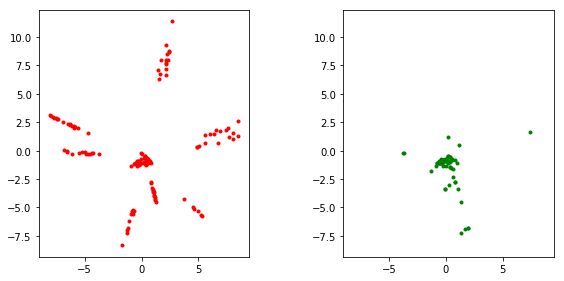

5001 [D loss: 0.480845, acc.: 78.03%] [G loss: 2.375550]
5002 [D loss: 0.468894, acc.: 77.65%] [G loss: 2.129131]
5003 [D loss: 0.509829, acc.: 73.48%] [G loss: 2.176316]
5004 [D loss: 0.506417, acc.: 77.65%] [G loss: 3.014211]
5005 [D loss: 0.500603, acc.: 73.48%] [G loss: 2.684345]
5006 [D loss: 0.467489, acc.: 77.65%] [G loss: 2.687906]
5007 [D loss: 0.491595, acc.: 75.00%] [G loss: 2.455387]
5008 [D loss: 0.497069, acc.: 73.11%] [G loss: 3.028027]
5009 [D loss: 0.489154, acc.: 75.38%] [G loss: 3.145352]
5010 [D loss: 0.520316, acc.: 71.97%] [G loss: 2.694471]
5011 [D loss: 0.570889, acc.: 72.35%] [G loss: 2.716611]
5012 [D loss: 0.507972, acc.: 73.86%] [G loss: 2.307981]
5013 [D loss: 0.439612, acc.: 79.55%] [G loss: 3.096436]
5014 [D loss: 0.546089, acc.: 73.11%] [G loss: 2.653320]
5015 [D loss: 0.466038, acc.: 76.52%] [G loss: 3.259688]
5016 [D loss: 0.499860, acc.: 75.76%] [G loss: 2.749740]
5017 [D loss: 0.466330, acc.: 79.55%] [G loss: 3.099434]
5018 [D loss: 0.558083, acc.: 7

5022 [D loss: 0.551664, acc.: 71.97%] [G loss: 2.640159]
5023 [D loss: 0.504731, acc.: 73.48%] [G loss: 2.884437]
5024 [D loss: 0.521715, acc.: 75.00%] [G loss: 2.971237]
5025 [D loss: 0.512298, acc.: 72.35%] [G loss: 2.881438]
5026 [D loss: 0.523995, acc.: 73.86%] [G loss: 2.510928]
5027 [D loss: 0.493396, acc.: 73.86%] [G loss: 3.003435]
5028 [D loss: 0.518271, acc.: 72.73%] [G loss: 2.790448]
5029 [D loss: 0.493660, acc.: 76.14%] [G loss: 2.823603]
5030 [D loss: 0.506773, acc.: 73.86%] [G loss: 2.659525]
5031 [D loss: 0.496654, acc.: 77.65%] [G loss: 2.527938]
5032 [D loss: 0.497705, acc.: 78.03%] [G loss: 2.553876]
5033 [D loss: 0.503201, acc.: 76.52%] [G loss: 2.975525]
5034 [D loss: 0.510529, acc.: 76.14%] [G loss: 3.502811]
5035 [D loss: 0.467244, acc.: 77.65%] [G loss: 2.558604]
5036 [D loss: 0.484338, acc.: 76.89%] [G loss: 3.402645]
5037 [D loss: 0.518809, acc.: 72.73%] [G loss: 2.903733]
5038 [D loss: 0.427463, acc.: 82.20%] [G loss: 3.335098]
5039 [D loss: 0.495131, acc.: 7

5044 [D loss: 0.459949, acc.: 78.79%] [G loss: 2.893694]
5045 [D loss: 0.445863, acc.: 79.17%] [G loss: 3.998050]
5046 [D loss: 0.484332, acc.: 79.55%] [G loss: 3.802994]
5047 [D loss: 0.551152, acc.: 73.11%] [G loss: 2.596585]
5048 [D loss: 0.463516, acc.: 79.92%] [G loss: 2.387623]
5049 [D loss: 0.489542, acc.: 76.14%] [G loss: 3.171073]
5050 [D loss: 0.445188, acc.: 79.17%] [G loss: 3.131909]
5051 [D loss: 0.462439, acc.: 79.17%] [G loss: 3.280482]
5052 [D loss: 0.508181, acc.: 74.24%] [G loss: 3.195514]
5053 [D loss: 0.462094, acc.: 76.89%] [G loss: 2.741204]
5054 [D loss: 0.535994, acc.: 71.97%] [G loss: 3.038201]
5055 [D loss: 0.479747, acc.: 75.00%] [G loss: 3.099699]
5056 [D loss: 0.506156, acc.: 77.65%] [G loss: 2.843249]
5057 [D loss: 0.533493, acc.: 71.97%] [G loss: 3.396528]
5058 [D loss: 0.453699, acc.: 80.68%] [G loss: 3.147026]
5059 [D loss: 0.517891, acc.: 74.62%] [G loss: 3.085354]
5060 [D loss: 0.477175, acc.: 78.03%] [G loss: 2.937581]
5061 [D loss: 0.496780, acc.: 7

5066 [D loss: 0.544015, acc.: 71.21%] [G loss: 2.739362]
5067 [D loss: 0.482518, acc.: 76.89%] [G loss: 3.058331]
5068 [D loss: 0.486802, acc.: 74.62%] [G loss: 3.251065]
5069 [D loss: 0.443527, acc.: 78.41%] [G loss: 3.249318]
5070 [D loss: 0.477119, acc.: 75.00%] [G loss: 2.936493]
5071 [D loss: 0.457857, acc.: 80.68%] [G loss: 3.254270]
5072 [D loss: 0.483686, acc.: 75.38%] [G loss: 3.128385]
5073 [D loss: 0.525679, acc.: 76.52%] [G loss: 2.385763]
5074 [D loss: 0.477332, acc.: 77.65%] [G loss: 3.359973]
5075 [D loss: 0.470559, acc.: 75.76%] [G loss: 2.694718]
5076 [D loss: 0.493069, acc.: 74.24%] [G loss: 2.639575]
5077 [D loss: 0.560504, acc.: 72.73%] [G loss: 2.908729]
5078 [D loss: 0.522436, acc.: 72.73%] [G loss: 2.768629]
5079 [D loss: 0.494895, acc.: 75.00%] [G loss: 2.730135]
5080 [D loss: 0.527824, acc.: 75.76%] [G loss: 2.087917]
5081 [D loss: 0.453741, acc.: 79.17%] [G loss: 2.693498]
5082 [D loss: 0.503256, acc.: 75.76%] [G loss: 3.228639]
5083 [D loss: 0.523829, acc.: 7

5088 [D loss: 0.493345, acc.: 78.41%] [G loss: 2.984689]
5089 [D loss: 0.550780, acc.: 70.08%] [G loss: 2.529436]
5090 [D loss: 0.533139, acc.: 74.24%] [G loss: 2.320623]
5091 [D loss: 0.549195, acc.: 72.73%] [G loss: 2.326034]
5092 [D loss: 0.487532, acc.: 75.38%] [G loss: 3.373754]
5093 [D loss: 0.446998, acc.: 78.79%] [G loss: 2.941338]
5094 [D loss: 0.457219, acc.: 78.03%] [G loss: 3.103272]
5095 [D loss: 0.532926, acc.: 75.00%] [G loss: 2.834303]
5096 [D loss: 0.493075, acc.: 79.17%] [G loss: 3.625671]
5097 [D loss: 0.584306, acc.: 70.83%] [G loss: 3.089118]
5098 [D loss: 0.548366, acc.: 70.45%] [G loss: 2.782536]
5099 [D loss: 0.511035, acc.: 75.00%] [G loss: 2.585086]
5100 [D loss: 0.515972, acc.: 76.14%] [G loss: 2.851805]
5101 [D loss: 0.538577, acc.: 72.73%] [G loss: 2.353125]
5102 [D loss: 0.528040, acc.: 72.35%] [G loss: 2.734762]
5103 [D loss: 0.466000, acc.: 77.65%] [G loss: 2.955613]
5104 [D loss: 0.544403, acc.: 72.73%] [G loss: 2.704646]
5105 [D loss: 0.517072, acc.: 7

5110 [D loss: 0.494634, acc.: 74.24%] [G loss: 2.404066]
5111 [D loss: 0.493541, acc.: 74.24%] [G loss: 3.149204]
5112 [D loss: 0.487993, acc.: 76.89%] [G loss: 2.705086]
5113 [D loss: 0.510002, acc.: 74.62%] [G loss: 2.676776]
5114 [D loss: 0.510870, acc.: 73.86%] [G loss: 2.803308]
5115 [D loss: 0.470895, acc.: 77.27%] [G loss: 3.193239]
5116 [D loss: 0.479672, acc.: 76.14%] [G loss: 2.826728]
5117 [D loss: 0.497897, acc.: 77.27%] [G loss: 3.141099]
5118 [D loss: 0.513772, acc.: 73.48%] [G loss: 3.096407]
5119 [D loss: 0.523325, acc.: 72.73%] [G loss: 3.002178]
5120 [D loss: 0.533185, acc.: 72.73%] [G loss: 3.246032]
5121 [D loss: 0.595251, acc.: 71.59%] [G loss: 2.558150]
5122 [D loss: 0.484225, acc.: 75.38%] [G loss: 2.523793]
5123 [D loss: 0.505939, acc.: 74.62%] [G loss: 2.695288]
5124 [D loss: 0.502816, acc.: 76.52%] [G loss: 3.364508]
5125 [D loss: 0.487390, acc.: 77.27%] [G loss: 3.083376]
5126 [D loss: 0.482094, acc.: 77.65%] [G loss: 3.511915]
5127 [D loss: 0.475946, acc.: 7

5132 [D loss: 0.502243, acc.: 76.14%] [G loss: 3.014778]
5133 [D loss: 0.445938, acc.: 79.17%] [G loss: 3.133111]
5134 [D loss: 0.513821, acc.: 75.76%] [G loss: 3.137829]
5135 [D loss: 0.500444, acc.: 76.89%] [G loss: 2.983142]
5136 [D loss: 0.498462, acc.: 77.65%] [G loss: 2.760891]
5137 [D loss: 0.480656, acc.: 78.41%] [G loss: 2.573758]
5138 [D loss: 0.535282, acc.: 73.11%] [G loss: 3.052087]
5139 [D loss: 0.463059, acc.: 78.41%] [G loss: 2.992869]
5140 [D loss: 0.559892, acc.: 73.11%] [G loss: 2.593456]
5141 [D loss: 0.490133, acc.: 74.24%] [G loss: 2.708312]
5142 [D loss: 0.530187, acc.: 72.35%] [G loss: 2.541216]
5143 [D loss: 0.449526, acc.: 78.03%] [G loss: 2.988366]
5144 [D loss: 0.516080, acc.: 74.24%] [G loss: 2.616325]
5145 [D loss: 0.509743, acc.: 73.11%] [G loss: 3.090194]
5146 [D loss: 0.504456, acc.: 76.14%] [G loss: 2.623059]
5147 [D loss: 0.487698, acc.: 73.86%] [G loss: 2.494843]
5148 [D loss: 0.499135, acc.: 73.11%] [G loss: 3.131118]
5149 [D loss: 0.487784, acc.: 7

5154 [D loss: 0.478366, acc.: 74.62%] [G loss: 2.437911]
5155 [D loss: 0.501521, acc.: 77.27%] [G loss: 3.199468]
5156 [D loss: 0.483976, acc.: 76.52%] [G loss: 2.581765]
5157 [D loss: 0.516312, acc.: 75.00%] [G loss: 3.542816]
5158 [D loss: 0.506675, acc.: 78.41%] [G loss: 3.098363]
5159 [D loss: 0.520079, acc.: 71.59%] [G loss: 2.928181]
5160 [D loss: 0.476551, acc.: 77.65%] [G loss: 3.080425]
5161 [D loss: 0.469400, acc.: 78.03%] [G loss: 3.015431]
5162 [D loss: 0.505181, acc.: 77.65%] [G loss: 3.274296]
5163 [D loss: 0.466191, acc.: 78.41%] [G loss: 2.915207]
5164 [D loss: 0.455634, acc.: 78.03%] [G loss: 2.627696]
5165 [D loss: 0.459702, acc.: 78.79%] [G loss: 3.305146]
5166 [D loss: 0.533212, acc.: 76.52%] [G loss: 3.335084]
5167 [D loss: 0.508084, acc.: 70.83%] [G loss: 2.995640]
5168 [D loss: 0.480194, acc.: 75.38%] [G loss: 2.602391]
5169 [D loss: 0.463387, acc.: 78.03%] [G loss: 2.739852]
5170 [D loss: 0.496043, acc.: 74.24%] [G loss: 2.725997]
5171 [D loss: 0.449651, acc.: 8

5176 [D loss: 0.519722, acc.: 75.00%] [G loss: 2.729914]
5177 [D loss: 0.520247, acc.: 71.97%] [G loss: 2.880182]
5178 [D loss: 0.461546, acc.: 77.65%] [G loss: 2.699636]
5179 [D loss: 0.482618, acc.: 77.27%] [G loss: 2.338566]
5180 [D loss: 0.545485, acc.: 73.11%] [G loss: 2.672226]
5181 [D loss: 0.512234, acc.: 73.86%] [G loss: 2.857005]
5182 [D loss: 0.531981, acc.: 69.70%] [G loss: 2.180426]
5183 [D loss: 0.509375, acc.: 72.73%] [G loss: 2.209167]
5184 [D loss: 0.479626, acc.: 79.55%] [G loss: 2.947592]
5185 [D loss: 0.470509, acc.: 76.89%] [G loss: 2.404040]
5186 [D loss: 0.467570, acc.: 78.03%] [G loss: 2.770072]
5187 [D loss: 0.481024, acc.: 77.65%] [G loss: 2.844321]
5188 [D loss: 0.481337, acc.: 78.03%] [G loss: 3.148727]
5189 [D loss: 0.524060, acc.: 69.70%] [G loss: 2.350852]
5190 [D loss: 0.504037, acc.: 73.86%] [G loss: 2.550057]
5191 [D loss: 0.479264, acc.: 77.27%] [G loss: 2.462160]
5192 [D loss: 0.477711, acc.: 78.03%] [G loss: 3.327414]
5193 [D loss: 0.522728, acc.: 7

5198 [D loss: 0.535638, acc.: 73.86%] [G loss: 3.472513]
5199 [D loss: 0.505366, acc.: 70.45%] [G loss: 2.980386]
5200 [D loss: 0.513420, acc.: 76.89%] [G loss: 2.678138]
5201 [D loss: 0.484750, acc.: 73.86%] [G loss: 2.882875]
5202 [D loss: 0.452232, acc.: 79.55%] [G loss: 3.385033]
5203 [D loss: 0.510787, acc.: 77.27%] [G loss: 3.356716]
5204 [D loss: 0.486628, acc.: 76.52%] [G loss: 2.987356]
5205 [D loss: 0.536507, acc.: 71.59%] [G loss: 3.174598]
5206 [D loss: 0.558018, acc.: 72.73%] [G loss: 2.759552]
5207 [D loss: 0.488103, acc.: 79.17%] [G loss: 2.329062]
5208 [D loss: 0.476635, acc.: 78.79%] [G loss: 3.127648]
5209 [D loss: 0.527028, acc.: 74.24%] [G loss: 2.953277]
5210 [D loss: 0.452332, acc.: 79.55%] [G loss: 2.694231]
5211 [D loss: 0.562851, acc.: 75.76%] [G loss: 2.793733]
5212 [D loss: 0.505541, acc.: 75.76%] [G loss: 2.569085]
5213 [D loss: 0.458663, acc.: 76.52%] [G loss: 3.050828]
5214 [D loss: 0.519155, acc.: 72.35%] [G loss: 2.647422]
5215 [D loss: 0.497664, acc.: 7

5220 [D loss: 0.511636, acc.: 75.76%] [G loss: 2.768004]
5221 [D loss: 0.497880, acc.: 76.89%] [G loss: 2.991763]
5222 [D loss: 0.494719, acc.: 76.52%] [G loss: 2.852319]
5223 [D loss: 0.469489, acc.: 77.65%] [G loss: 2.576007]
5224 [D loss: 0.480766, acc.: 75.76%] [G loss: 3.283446]
5225 [D loss: 0.563625, acc.: 73.11%] [G loss: 2.728469]
5226 [D loss: 0.487662, acc.: 76.14%] [G loss: 2.502921]
5227 [D loss: 0.481018, acc.: 77.65%] [G loss: 3.216497]
5228 [D loss: 0.496698, acc.: 76.52%] [G loss: 3.093498]
5229 [D loss: 0.527205, acc.: 72.35%] [G loss: 3.167038]
5230 [D loss: 0.510556, acc.: 74.24%] [G loss: 3.309275]
5231 [D loss: 0.513247, acc.: 77.27%] [G loss: 2.588369]
5232 [D loss: 0.476639, acc.: 72.73%] [G loss: 2.257270]
5233 [D loss: 0.520131, acc.: 73.48%] [G loss: 2.575987]
5234 [D loss: 0.486846, acc.: 78.79%] [G loss: 2.788293]
5235 [D loss: 0.494446, acc.: 73.48%] [G loss: 2.686243]
5236 [D loss: 0.509955, acc.: 74.62%] [G loss: 2.913232]
5237 [D loss: 0.549226, acc.: 7

5242 [D loss: 0.491802, acc.: 76.14%] [G loss: 2.524124]
5243 [D loss: 0.495737, acc.: 75.38%] [G loss: 3.047241]
5244 [D loss: 0.536133, acc.: 74.24%] [G loss: 2.395680]
5245 [D loss: 0.451430, acc.: 79.55%] [G loss: 2.892114]
5246 [D loss: 0.477278, acc.: 76.89%] [G loss: 2.768574]
5247 [D loss: 0.576900, acc.: 67.42%] [G loss: 3.101795]
5248 [D loss: 0.528648, acc.: 72.73%] [G loss: 3.057648]
5249 [D loss: 0.518075, acc.: 75.00%] [G loss: 2.392712]
5250 [D loss: 0.472625, acc.: 76.52%] [G loss: 2.478797]
5251 [D loss: 0.549024, acc.: 73.86%] [G loss: 2.312287]
5252 [D loss: 0.519370, acc.: 71.97%] [G loss: 2.641977]
5253 [D loss: 0.505862, acc.: 74.62%] [G loss: 3.095645]
5254 [D loss: 0.449769, acc.: 80.68%] [G loss: 2.676305]
5255 [D loss: 0.560204, acc.: 74.62%] [G loss: 2.969622]
5256 [D loss: 0.558692, acc.: 69.70%] [G loss: 2.505405]
5257 [D loss: 0.561208, acc.: 69.70%] [G loss: 2.507531]
5258 [D loss: 0.551405, acc.: 74.24%] [G loss: 2.589700]
5259 [D loss: 0.446234, acc.: 7

5264 [D loss: 0.490011, acc.: 74.62%] [G loss: 3.128567]
5265 [D loss: 0.495173, acc.: 77.27%] [G loss: 3.018258]
5266 [D loss: 0.521043, acc.: 76.52%] [G loss: 2.892882]
5267 [D loss: 0.506942, acc.: 76.89%] [G loss: 2.947001]
5268 [D loss: 0.458318, acc.: 78.41%] [G loss: 2.795694]
5269 [D loss: 0.537053, acc.: 75.00%] [G loss: 2.905083]
5270 [D loss: 0.520128, acc.: 73.48%] [G loss: 2.863001]
5271 [D loss: 0.480875, acc.: 77.65%] [G loss: 2.766329]
5272 [D loss: 0.514019, acc.: 72.35%] [G loss: 2.768462]
5273 [D loss: 0.552173, acc.: 73.86%] [G loss: 2.980101]
5274 [D loss: 0.560117, acc.: 70.45%] [G loss: 2.518281]
5275 [D loss: 0.480962, acc.: 74.24%] [G loss: 3.087836]
5276 [D loss: 0.494406, acc.: 76.52%] [G loss: 2.661951]
5277 [D loss: 0.551587, acc.: 73.86%] [G loss: 2.946254]
5278 [D loss: 0.536576, acc.: 68.94%] [G loss: 2.777805]
5279 [D loss: 0.494433, acc.: 74.62%] [G loss: 2.784951]
5280 [D loss: 0.590189, acc.: 70.08%] [G loss: 2.107072]
5281 [D loss: 0.572913, acc.: 7

5286 [D loss: 0.517706, acc.: 74.62%] [G loss: 2.604529]
5287 [D loss: 0.453139, acc.: 78.41%] [G loss: 3.394501]
5288 [D loss: 0.521061, acc.: 73.11%] [G loss: 3.055156]
5289 [D loss: 0.580682, acc.: 73.11%] [G loss: 2.301803]
5290 [D loss: 0.514759, acc.: 75.00%] [G loss: 2.857961]
5291 [D loss: 0.489518, acc.: 77.27%] [G loss: 2.528304]
5292 [D loss: 0.552093, acc.: 72.35%] [G loss: 3.003211]
5293 [D loss: 0.463749, acc.: 78.79%] [G loss: 3.013058]
5294 [D loss: 0.527621, acc.: 75.76%] [G loss: 2.346801]
5295 [D loss: 0.565578, acc.: 68.18%] [G loss: 2.366722]
5296 [D loss: 0.523703, acc.: 73.11%] [G loss: 2.415880]
5297 [D loss: 0.530726, acc.: 71.59%] [G loss: 2.395893]
5298 [D loss: 0.519376, acc.: 73.11%] [G loss: 2.348498]
5299 [D loss: 0.486193, acc.: 76.52%] [G loss: 2.303766]
5300 [D loss: 0.528984, acc.: 72.73%] [G loss: 2.979672]
5301 [D loss: 0.507365, acc.: 75.38%] [G loss: 2.361161]
5302 [D loss: 0.523108, acc.: 73.86%] [G loss: 3.254510]
5303 [D loss: 0.526894, acc.: 7

5308 [D loss: 0.486331, acc.: 75.00%] [G loss: 2.442342]
5309 [D loss: 0.550197, acc.: 70.45%] [G loss: 3.104894]
5310 [D loss: 0.514049, acc.: 74.24%] [G loss: 3.268228]
5311 [D loss: 0.485069, acc.: 75.76%] [G loss: 3.048066]
5312 [D loss: 0.481214, acc.: 79.55%] [G loss: 2.883137]
5313 [D loss: 0.487284, acc.: 77.65%] [G loss: 3.028543]
5314 [D loss: 0.508340, acc.: 73.11%] [G loss: 2.879853]
5315 [D loss: 0.507204, acc.: 73.48%] [G loss: 2.072051]
5316 [D loss: 0.573856, acc.: 73.86%] [G loss: 2.683447]
5317 [D loss: 0.502060, acc.: 75.00%] [G loss: 2.138293]
5318 [D loss: 0.521938, acc.: 76.89%] [G loss: 2.370100]
5319 [D loss: 0.530805, acc.: 71.59%] [G loss: 2.457147]
5320 [D loss: 0.517923, acc.: 73.48%] [G loss: 3.320553]
5321 [D loss: 0.533005, acc.: 73.11%] [G loss: 2.637311]
5322 [D loss: 0.477833, acc.: 79.17%] [G loss: 2.925272]
5323 [D loss: 0.501138, acc.: 79.17%] [G loss: 2.961169]
5324 [D loss: 0.518020, acc.: 74.62%] [G loss: 2.513179]
5325 [D loss: 0.483807, acc.: 7

5329 [D loss: 0.481469, acc.: 76.89%] [G loss: 3.211307]
5330 [D loss: 0.468490, acc.: 79.92%] [G loss: 3.253969]
5331 [D loss: 0.484634, acc.: 76.52%] [G loss: 3.166164]
5332 [D loss: 0.487110, acc.: 78.03%] [G loss: 3.306669]
5333 [D loss: 0.536820, acc.: 75.00%] [G loss: 3.004748]
5334 [D loss: 0.610287, acc.: 67.80%] [G loss: 2.715351]
5335 [D loss: 0.514127, acc.: 76.89%] [G loss: 2.340273]
5336 [D loss: 0.503688, acc.: 76.52%] [G loss: 3.368226]
5337 [D loss: 0.529975, acc.: 71.97%] [G loss: 3.300901]
5338 [D loss: 0.475075, acc.: 78.41%] [G loss: 2.849408]
5339 [D loss: 0.451512, acc.: 80.30%] [G loss: 3.265951]
5340 [D loss: 0.618172, acc.: 64.39%] [G loss: 2.232490]
5341 [D loss: 0.506498, acc.: 72.73%] [G loss: 2.617779]
5342 [D loss: 0.516573, acc.: 73.48%] [G loss: 2.647659]
5343 [D loss: 0.528365, acc.: 75.76%] [G loss: 2.661856]
5344 [D loss: 0.526461, acc.: 73.86%] [G loss: 2.682999]
5345 [D loss: 0.572043, acc.: 70.83%] [G loss: 2.871495]
5346 [D loss: 0.502892, acc.: 7

5351 [D loss: 0.587793, acc.: 70.45%] [G loss: 2.395228]
5352 [D loss: 0.492469, acc.: 77.65%] [G loss: 2.347491]
5353 [D loss: 0.496365, acc.: 75.00%] [G loss: 3.264407]
5354 [D loss: 0.537218, acc.: 73.48%] [G loss: 2.634692]
5355 [D loss: 0.535592, acc.: 73.11%] [G loss: 2.816950]
5356 [D loss: 0.475571, acc.: 76.52%] [G loss: 3.279961]
5357 [D loss: 0.523230, acc.: 73.11%] [G loss: 2.267593]
5358 [D loss: 0.491337, acc.: 78.03%] [G loss: 2.912749]
5359 [D loss: 0.534622, acc.: 72.35%] [G loss: 2.839782]
5360 [D loss: 0.497842, acc.: 73.86%] [G loss: 3.032021]
5361 [D loss: 0.508956, acc.: 72.73%] [G loss: 2.833068]
5362 [D loss: 0.514195, acc.: 76.14%] [G loss: 2.776649]
5363 [D loss: 0.577638, acc.: 70.08%] [G loss: 2.501582]
5364 [D loss: 0.501624, acc.: 77.65%] [G loss: 2.673170]
5365 [D loss: 0.512425, acc.: 73.48%] [G loss: 2.982663]
5366 [D loss: 0.526895, acc.: 77.65%] [G loss: 3.244172]
5367 [D loss: 0.509983, acc.: 75.38%] [G loss: 2.583276]
5368 [D loss: 0.521671, acc.: 7

5373 [D loss: 0.494642, acc.: 76.89%] [G loss: 2.599181]
5374 [D loss: 0.543598, acc.: 73.86%] [G loss: 2.115394]
5375 [D loss: 0.533791, acc.: 72.73%] [G loss: 2.780071]
5376 [D loss: 0.519790, acc.: 72.35%] [G loss: 2.936717]
5377 [D loss: 0.499301, acc.: 73.86%] [G loss: 2.754578]
5378 [D loss: 0.489429, acc.: 75.00%] [G loss: 3.086530]
5379 [D loss: 0.483665, acc.: 77.65%] [G loss: 2.815818]
5380 [D loss: 0.533721, acc.: 73.48%] [G loss: 2.762966]
5381 [D loss: 0.518264, acc.: 71.59%] [G loss: 3.177457]
5382 [D loss: 0.566039, acc.: 70.83%] [G loss: 2.695164]
5383 [D loss: 0.494922, acc.: 73.48%] [G loss: 2.867757]
5384 [D loss: 0.506341, acc.: 77.65%] [G loss: 2.611285]
5385 [D loss: 0.552961, acc.: 68.56%] [G loss: 2.545906]
5386 [D loss: 0.494720, acc.: 74.62%] [G loss: 3.713098]
5387 [D loss: 0.500633, acc.: 75.00%] [G loss: 2.984866]
5388 [D loss: 0.532931, acc.: 73.11%] [G loss: 2.545389]
5389 [D loss: 0.513584, acc.: 76.52%] [G loss: 2.944050]
5390 [D loss: 0.485390, acc.: 7

5395 [D loss: 0.477865, acc.: 76.14%] [G loss: 2.774494]
5396 [D loss: 0.456267, acc.: 77.27%] [G loss: 3.478319]
5397 [D loss: 0.492546, acc.: 76.52%] [G loss: 3.416975]
5398 [D loss: 0.541535, acc.: 72.35%] [G loss: 2.808435]
5399 [D loss: 0.473497, acc.: 76.52%] [G loss: 2.718251]
5400 [D loss: 0.528956, acc.: 75.00%] [G loss: 2.449330]
5401 [D loss: 0.515593, acc.: 72.35%] [G loss: 3.070685]
5402 [D loss: 0.473699, acc.: 75.76%] [G loss: 2.633028]
5403 [D loss: 0.500353, acc.: 75.38%] [G loss: 2.897450]
5404 [D loss: 0.438321, acc.: 79.17%] [G loss: 3.404070]
5405 [D loss: 0.518175, acc.: 75.76%] [G loss: 3.413506]
5406 [D loss: 0.454993, acc.: 79.55%] [G loss: 3.741989]
5407 [D loss: 0.477618, acc.: 78.03%] [G loss: 3.026331]
5408 [D loss: 0.506382, acc.: 72.73%] [G loss: 3.740386]
5409 [D loss: 0.454238, acc.: 76.52%] [G loss: 3.424566]
5410 [D loss: 0.539683, acc.: 76.14%] [G loss: 2.973007]
5411 [D loss: 0.526553, acc.: 71.97%] [G loss: 3.307873]
5412 [D loss: 0.532680, acc.: 7

5417 [D loss: 0.458508, acc.: 79.17%] [G loss: 2.796795]
5418 [D loss: 0.499205, acc.: 75.76%] [G loss: 2.557327]
5419 [D loss: 0.516391, acc.: 73.86%] [G loss: 2.467288]
5420 [D loss: 0.513671, acc.: 75.00%] [G loss: 3.009068]
5421 [D loss: 0.474587, acc.: 75.76%] [G loss: 3.146959]
5422 [D loss: 0.543968, acc.: 73.48%] [G loss: 2.546044]
5423 [D loss: 0.537618, acc.: 78.03%] [G loss: 2.850686]
5424 [D loss: 0.472865, acc.: 76.52%] [G loss: 2.409469]
5425 [D loss: 0.467977, acc.: 80.68%] [G loss: 3.187508]
5426 [D loss: 0.525722, acc.: 72.73%] [G loss: 2.284008]
5427 [D loss: 0.544078, acc.: 71.97%] [G loss: 2.597854]
5428 [D loss: 0.527422, acc.: 76.14%] [G loss: 2.644969]
5429 [D loss: 0.504297, acc.: 71.59%] [G loss: 3.061583]
5430 [D loss: 0.497476, acc.: 75.76%] [G loss: 3.383029]
5431 [D loss: 0.542079, acc.: 69.32%] [G loss: 3.319551]
5432 [D loss: 0.477237, acc.: 75.76%] [G loss: 2.760589]
5433 [D loss: 0.577808, acc.: 70.45%] [G loss: 2.783731]
5434 [D loss: 0.485487, acc.: 7

5439 [D loss: 0.492344, acc.: 79.92%] [G loss: 3.042942]
5440 [D loss: 0.509222, acc.: 73.11%] [G loss: 3.016143]
5441 [D loss: 0.496897, acc.: 73.11%] [G loss: 3.059220]
5442 [D loss: 0.515678, acc.: 73.48%] [G loss: 2.794206]
5443 [D loss: 0.497407, acc.: 75.76%] [G loss: 2.871047]
5444 [D loss: 0.470131, acc.: 75.00%] [G loss: 3.525903]
5445 [D loss: 0.483039, acc.: 76.14%] [G loss: 3.183902]
5446 [D loss: 0.524293, acc.: 75.38%] [G loss: 2.887583]
5447 [D loss: 0.488948, acc.: 76.89%] [G loss: 3.252686]
5448 [D loss: 0.574508, acc.: 74.62%] [G loss: 2.792066]
5449 [D loss: 0.583049, acc.: 73.11%] [G loss: 2.381819]
5450 [D loss: 0.497106, acc.: 74.62%] [G loss: 2.699461]
5451 [D loss: 0.459469, acc.: 78.03%] [G loss: 3.074460]
5452 [D loss: 0.444826, acc.: 80.30%] [G loss: 2.795768]
5453 [D loss: 0.517498, acc.: 72.73%] [G loss: 2.773681]
5454 [D loss: 0.570155, acc.: 74.62%] [G loss: 2.853011]
5455 [D loss: 0.565668, acc.: 74.24%] [G loss: 2.617116]
5456 [D loss: 0.501010, acc.: 7

5461 [D loss: 0.550010, acc.: 74.24%] [G loss: 2.471090]
5462 [D loss: 0.473841, acc.: 78.03%] [G loss: 3.083239]
5463 [D loss: 0.518596, acc.: 75.00%] [G loss: 2.642390]
5464 [D loss: 0.465296, acc.: 79.92%] [G loss: 3.681675]
5465 [D loss: 0.514944, acc.: 73.48%] [G loss: 2.753869]
5466 [D loss: 0.504181, acc.: 75.38%] [G loss: 2.670823]
5467 [D loss: 0.514920, acc.: 78.41%] [G loss: 2.687787]
5468 [D loss: 0.504616, acc.: 76.52%] [G loss: 2.395500]
5469 [D loss: 0.529737, acc.: 74.24%] [G loss: 2.516242]
5470 [D loss: 0.536555, acc.: 70.83%] [G loss: 2.145685]
5471 [D loss: 0.549561, acc.: 71.97%] [G loss: 2.094997]
5472 [D loss: 0.479787, acc.: 76.14%] [G loss: 2.166351]
5473 [D loss: 0.505886, acc.: 76.14%] [G loss: 2.603229]
5474 [D loss: 0.508037, acc.: 76.14%] [G loss: 2.890494]
5475 [D loss: 0.537660, acc.: 71.59%] [G loss: 2.856209]
5476 [D loss: 0.535808, acc.: 70.83%] [G loss: 2.854194]
5477 [D loss: 0.507704, acc.: 72.73%] [G loss: 2.376168]
5478 [D loss: 0.547483, acc.: 7

5483 [D loss: 0.532361, acc.: 72.73%] [G loss: 2.858714]
5484 [D loss: 0.526477, acc.: 73.86%] [G loss: 2.418410]
5485 [D loss: 0.505534, acc.: 76.14%] [G loss: 2.698167]
5486 [D loss: 0.483071, acc.: 77.65%] [G loss: 3.160943]
5487 [D loss: 0.617233, acc.: 77.27%] [G loss: 2.431926]
5488 [D loss: 0.499501, acc.: 74.62%] [G loss: 2.869864]
5489 [D loss: 0.488166, acc.: 75.38%] [G loss: 2.781021]
5490 [D loss: 0.548611, acc.: 70.45%] [G loss: 2.748851]
5491 [D loss: 0.508069, acc.: 73.86%] [G loss: 2.373892]
5492 [D loss: 0.562484, acc.: 73.11%] [G loss: 2.885467]
5493 [D loss: 0.465854, acc.: 78.41%] [G loss: 2.766215]
5494 [D loss: 0.431125, acc.: 83.33%] [G loss: 2.533910]
5495 [D loss: 0.510263, acc.: 74.62%] [G loss: 2.337106]
5496 [D loss: 0.520783, acc.: 75.76%] [G loss: 2.881222]
5497 [D loss: 0.581420, acc.: 74.62%] [G loss: 2.861139]
5498 [D loss: 0.506088, acc.: 75.00%] [G loss: 2.853787]
5499 [D loss: 0.563237, acc.: 70.08%] [G loss: 2.645609]
5500 [D loss: 0.567916, acc.: 7

5504 [D loss: 0.493738, acc.: 75.00%] [G loss: 2.694751]
5505 [D loss: 0.491214, acc.: 74.24%] [G loss: 2.551103]
5506 [D loss: 0.524952, acc.: 71.97%] [G loss: 2.822820]
5507 [D loss: 0.519837, acc.: 74.62%] [G loss: 2.495001]
5508 [D loss: 0.516812, acc.: 71.21%] [G loss: 3.423507]
5509 [D loss: 0.473396, acc.: 74.62%] [G loss: 2.907962]
5510 [D loss: 0.523473, acc.: 75.38%] [G loss: 2.658993]
5511 [D loss: 0.459655, acc.: 79.55%] [G loss: 2.519648]
5512 [D loss: 0.553615, acc.: 71.59%] [G loss: 2.647594]
5513 [D loss: 0.442969, acc.: 79.92%] [G loss: 2.625559]
5514 [D loss: 0.488536, acc.: 76.89%] [G loss: 2.770306]
5515 [D loss: 0.492118, acc.: 75.00%] [G loss: 2.525543]
5516 [D loss: 0.537361, acc.: 71.21%] [G loss: 2.642055]
5517 [D loss: 0.503998, acc.: 76.14%] [G loss: 3.252329]
5518 [D loss: 0.478142, acc.: 75.38%] [G loss: 2.838800]
5519 [D loss: 0.496904, acc.: 76.52%] [G loss: 3.261801]
5520 [D loss: 0.487111, acc.: 75.38%] [G loss: 3.409629]
5521 [D loss: 0.543115, acc.: 7

5526 [D loss: 0.556095, acc.: 72.73%] [G loss: 3.144170]
5527 [D loss: 0.493182, acc.: 75.00%] [G loss: 2.921498]
5528 [D loss: 0.487904, acc.: 75.00%] [G loss: 2.570221]
5529 [D loss: 0.511286, acc.: 74.62%] [G loss: 3.019103]
5530 [D loss: 0.522487, acc.: 74.24%] [G loss: 2.935312]
5531 [D loss: 0.474308, acc.: 78.79%] [G loss: 2.663777]
5532 [D loss: 0.540870, acc.: 70.83%] [G loss: 2.540557]
5533 [D loss: 0.525891, acc.: 71.21%] [G loss: 2.737699]
5534 [D loss: 0.482940, acc.: 75.76%] [G loss: 2.891315]
5535 [D loss: 0.485742, acc.: 75.76%] [G loss: 2.931594]
5536 [D loss: 0.487385, acc.: 75.38%] [G loss: 2.973715]
5537 [D loss: 0.523835, acc.: 75.38%] [G loss: 2.747828]
5538 [D loss: 0.462328, acc.: 79.17%] [G loss: 3.540219]
5539 [D loss: 0.514755, acc.: 75.38%] [G loss: 3.093027]
5540 [D loss: 0.505142, acc.: 75.76%] [G loss: 2.636079]
5541 [D loss: 0.528152, acc.: 77.27%] [G loss: 3.331368]
5542 [D loss: 0.493163, acc.: 81.06%] [G loss: 3.215315]
5543 [D loss: 0.543892, acc.: 7

5548 [D loss: 0.514050, acc.: 75.00%] [G loss: 3.771394]
5549 [D loss: 0.521170, acc.: 73.86%] [G loss: 2.467086]
5550 [D loss: 0.484392, acc.: 74.62%] [G loss: 3.024695]
5551 [D loss: 0.532335, acc.: 76.52%] [G loss: 2.834591]
5552 [D loss: 0.500414, acc.: 73.86%] [G loss: 3.079103]
5553 [D loss: 0.593665, acc.: 67.80%] [G loss: 3.172485]
5554 [D loss: 0.501199, acc.: 75.38%] [G loss: 2.408082]
5555 [D loss: 0.544341, acc.: 73.48%] [G loss: 2.518209]
5556 [D loss: 0.493142, acc.: 73.11%] [G loss: 2.564308]
5557 [D loss: 0.525393, acc.: 71.21%] [G loss: 2.959696]
5558 [D loss: 0.519182, acc.: 74.62%] [G loss: 2.829109]
5559 [D loss: 0.483756, acc.: 78.03%] [G loss: 3.181736]
5560 [D loss: 0.536172, acc.: 73.11%] [G loss: 2.989322]
5561 [D loss: 0.564290, acc.: 72.73%] [G loss: 2.746140]
5562 [D loss: 0.572599, acc.: 73.11%] [G loss: 2.275552]
5563 [D loss: 0.530641, acc.: 71.97%] [G loss: 2.332414]
5564 [D loss: 0.560795, acc.: 70.45%] [G loss: 2.609691]
5565 [D loss: 0.511427, acc.: 7

5570 [D loss: 0.514237, acc.: 75.00%] [G loss: 2.548855]
5571 [D loss: 0.581193, acc.: 75.38%] [G loss: 2.261599]
5572 [D loss: 0.505687, acc.: 77.65%] [G loss: 2.542247]
5573 [D loss: 0.519142, acc.: 74.24%] [G loss: 2.952828]
5574 [D loss: 0.499945, acc.: 75.00%] [G loss: 2.901834]
5575 [D loss: 0.460759, acc.: 80.30%] [G loss: 2.211594]
5576 [D loss: 0.559366, acc.: 70.45%] [G loss: 2.663699]
5577 [D loss: 0.475746, acc.: 76.52%] [G loss: 2.415264]
5578 [D loss: 0.496063, acc.: 75.38%] [G loss: 2.692246]
5579 [D loss: 0.497988, acc.: 74.24%] [G loss: 2.743898]
5580 [D loss: 0.497832, acc.: 75.38%] [G loss: 2.824727]
5581 [D loss: 0.478453, acc.: 77.65%] [G loss: 3.091789]
5582 [D loss: 0.505046, acc.: 78.41%] [G loss: 3.040920]
5583 [D loss: 0.502700, acc.: 76.89%] [G loss: 3.282926]
5584 [D loss: 0.480190, acc.: 74.62%] [G loss: 2.592571]
5585 [D loss: 0.567102, acc.: 68.94%] [G loss: 3.054667]
5586 [D loss: 0.494038, acc.: 75.38%] [G loss: 2.453083]
5587 [D loss: 0.496872, acc.: 7

5591 [D loss: 0.456186, acc.: 79.17%] [G loss: 2.718673]
5592 [D loss: 0.571719, acc.: 72.73%] [G loss: 2.948631]
5593 [D loss: 0.490343, acc.: 77.27%] [G loss: 2.807078]
5594 [D loss: 0.464986, acc.: 78.79%] [G loss: 3.203100]
5595 [D loss: 0.554642, acc.: 72.35%] [G loss: 3.403243]
5596 [D loss: 0.501543, acc.: 78.03%] [G loss: 2.860676]
5597 [D loss: 0.467141, acc.: 76.89%] [G loss: 2.795183]
5598 [D loss: 0.457026, acc.: 80.30%] [G loss: 2.745512]
5599 [D loss: 0.583644, acc.: 73.11%] [G loss: 2.917740]
5600 [D loss: 0.501609, acc.: 73.48%] [G loss: 2.138867]
5601 [D loss: 0.527319, acc.: 72.73%] [G loss: 3.099625]
5602 [D loss: 0.602707, acc.: 64.39%] [G loss: 2.223485]
5603 [D loss: 0.507909, acc.: 73.11%] [G loss: 2.677799]
5604 [D loss: 0.517571, acc.: 74.24%] [G loss: 2.984117]
5605 [D loss: 0.505442, acc.: 73.11%] [G loss: 2.834596]
5606 [D loss: 0.526100, acc.: 72.35%] [G loss: 3.069947]
5607 [D loss: 0.479730, acc.: 78.79%] [G loss: 3.190709]
5608 [D loss: 0.523827, acc.: 7

5613 [D loss: 0.513353, acc.: 76.89%] [G loss: 2.886914]
5614 [D loss: 0.481734, acc.: 76.89%] [G loss: 2.507085]
5615 [D loss: 0.543171, acc.: 73.11%] [G loss: 2.810897]
5616 [D loss: 0.526050, acc.: 75.38%] [G loss: 2.894707]
5617 [D loss: 0.558115, acc.: 68.94%] [G loss: 2.360331]
5618 [D loss: 0.570680, acc.: 70.08%] [G loss: 2.504742]
5619 [D loss: 0.522609, acc.: 75.38%] [G loss: 2.507028]
5620 [D loss: 0.528523, acc.: 73.48%] [G loss: 2.282494]
5621 [D loss: 0.521665, acc.: 73.48%] [G loss: 2.994321]
5622 [D loss: 0.481074, acc.: 74.24%] [G loss: 2.754151]
5623 [D loss: 0.494536, acc.: 76.14%] [G loss: 3.344653]
5624 [D loss: 0.481636, acc.: 76.89%] [G loss: 3.706792]
5625 [D loss: 0.524476, acc.: 76.89%] [G loss: 2.651336]
5626 [D loss: 0.555968, acc.: 72.35%] [G loss: 3.220581]
5627 [D loss: 0.487422, acc.: 76.14%] [G loss: 2.483366]
5628 [D loss: 0.481113, acc.: 76.89%] [G loss: 3.994716]
5629 [D loss: 0.504890, acc.: 75.76%] [G loss: 3.472974]
5630 [D loss: 0.531007, acc.: 7

5635 [D loss: 0.505603, acc.: 75.38%] [G loss: 3.351666]
5636 [D loss: 0.499640, acc.: 75.00%] [G loss: 3.236522]
5637 [D loss: 0.492895, acc.: 73.48%] [G loss: 3.453052]
5638 [D loss: 0.473547, acc.: 77.27%] [G loss: 3.395947]
5639 [D loss: 0.486919, acc.: 78.41%] [G loss: 3.014565]
5640 [D loss: 0.469128, acc.: 77.27%] [G loss: 3.496310]
5641 [D loss: 0.510637, acc.: 78.79%] [G loss: 3.127808]
5642 [D loss: 0.535399, acc.: 73.11%] [G loss: 3.304314]
5643 [D loss: 0.464110, acc.: 78.41%] [G loss: 2.644665]
5644 [D loss: 0.492732, acc.: 77.65%] [G loss: 3.043938]
5645 [D loss: 0.504649, acc.: 74.24%] [G loss: 3.027457]
5646 [D loss: 0.601595, acc.: 76.52%] [G loss: 2.177872]
5647 [D loss: 0.534921, acc.: 73.11%] [G loss: 2.504442]
5648 [D loss: 0.582685, acc.: 70.83%] [G loss: 2.683135]
5649 [D loss: 0.506850, acc.: 74.24%] [G loss: 2.579195]
5650 [D loss: 0.524828, acc.: 75.76%] [G loss: 2.680653]
5651 [D loss: 0.516841, acc.: 74.62%] [G loss: 3.613968]
5652 [D loss: 0.533531, acc.: 7

5656 [D loss: 0.546674, acc.: 73.48%] [G loss: 2.957217]
5657 [D loss: 0.494539, acc.: 75.76%] [G loss: 2.767154]
5658 [D loss: 0.561892, acc.: 73.11%] [G loss: 2.459381]
5659 [D loss: 0.485537, acc.: 75.00%] [G loss: 2.623999]
5660 [D loss: 0.616686, acc.: 68.56%] [G loss: 2.673646]
5661 [D loss: 0.507782, acc.: 74.62%] [G loss: 2.273902]
5662 [D loss: 0.501289, acc.: 73.86%] [G loss: 2.155462]
5663 [D loss: 0.483628, acc.: 76.89%] [G loss: 2.421871]
5664 [D loss: 0.491622, acc.: 77.27%] [G loss: 2.584706]
5665 [D loss: 0.514170, acc.: 75.76%] [G loss: 2.575348]
5666 [D loss: 0.510232, acc.: 74.24%] [G loss: 2.367895]
5667 [D loss: 0.537130, acc.: 72.73%] [G loss: 2.852002]
5668 [D loss: 0.502026, acc.: 75.76%] [G loss: 2.267055]
5669 [D loss: 0.563142, acc.: 70.83%] [G loss: 2.658590]
5670 [D loss: 0.505103, acc.: 74.62%] [G loss: 2.346758]
5671 [D loss: 0.521114, acc.: 72.35%] [G loss: 2.531888]
5672 [D loss: 0.487666, acc.: 75.76%] [G loss: 2.911419]
5673 [D loss: 0.502627, acc.: 7

5678 [D loss: 0.506842, acc.: 74.24%] [G loss: 2.242573]
5679 [D loss: 0.521875, acc.: 72.73%] [G loss: 2.443569]
5680 [D loss: 0.499463, acc.: 74.24%] [G loss: 2.600497]
5681 [D loss: 0.530715, acc.: 73.11%] [G loss: 2.717214]
5682 [D loss: 0.548687, acc.: 74.24%] [G loss: 2.468373]
5683 [D loss: 0.539360, acc.: 70.08%] [G loss: 2.482440]
5684 [D loss: 0.486712, acc.: 73.48%] [G loss: 2.800382]
5685 [D loss: 0.497304, acc.: 75.38%] [G loss: 3.415105]
5686 [D loss: 0.542343, acc.: 74.62%] [G loss: 2.613691]
5687 [D loss: 0.515723, acc.: 72.35%] [G loss: 2.689807]
5688 [D loss: 0.496053, acc.: 78.03%] [G loss: 2.752130]
5689 [D loss: 0.573785, acc.: 70.83%] [G loss: 2.307271]
5690 [D loss: 0.498315, acc.: 73.86%] [G loss: 2.874377]
5691 [D loss: 0.512894, acc.: 76.14%] [G loss: 2.599939]
5692 [D loss: 0.541390, acc.: 70.08%] [G loss: 2.047575]
5693 [D loss: 0.535505, acc.: 72.73%] [G loss: 2.650006]
5694 [D loss: 0.498184, acc.: 76.52%] [G loss: 2.468863]
5695 [D loss: 0.511255, acc.: 7

5700 [D loss: 0.542829, acc.: 73.48%] [G loss: 2.848418]
5701 [D loss: 0.520023, acc.: 73.48%] [G loss: 2.925015]
5702 [D loss: 0.495443, acc.: 73.48%] [G loss: 3.334211]
5703 [D loss: 0.512828, acc.: 77.27%] [G loss: 3.072361]
5704 [D loss: 0.493580, acc.: 78.79%] [G loss: 2.380174]
5705 [D loss: 0.566591, acc.: 74.62%] [G loss: 2.266867]
5706 [D loss: 0.505804, acc.: 74.24%] [G loss: 3.033809]
5707 [D loss: 0.548134, acc.: 71.21%] [G loss: 2.341124]
5708 [D loss: 0.542667, acc.: 73.11%] [G loss: 2.606863]
5709 [D loss: 0.530124, acc.: 73.86%] [G loss: 2.143811]
5710 [D loss: 0.498247, acc.: 73.86%] [G loss: 2.397568]
5711 [D loss: 0.556385, acc.: 77.27%] [G loss: 2.518583]
5712 [D loss: 0.502941, acc.: 72.35%] [G loss: 2.336188]
5713 [D loss: 0.501145, acc.: 74.62%] [G loss: 2.701465]
5714 [D loss: 0.519179, acc.: 73.86%] [G loss: 2.604328]
5715 [D loss: 0.492461, acc.: 75.38%] [G loss: 2.985048]
5716 [D loss: 0.441834, acc.: 79.55%] [G loss: 2.716747]
5717 [D loss: 0.497763, acc.: 7

5722 [D loss: 0.542026, acc.: 72.73%] [G loss: 2.309032]
5723 [D loss: 0.490280, acc.: 76.14%] [G loss: 2.603408]
5724 [D loss: 0.491833, acc.: 74.62%] [G loss: 3.066348]
5725 [D loss: 0.471004, acc.: 76.52%] [G loss: 3.298963]
5726 [D loss: 0.507789, acc.: 78.03%] [G loss: 3.141580]
5727 [D loss: 0.499272, acc.: 75.76%] [G loss: 2.786595]
5728 [D loss: 0.497021, acc.: 73.11%] [G loss: 3.442567]
5729 [D loss: 0.472634, acc.: 79.55%] [G loss: 2.737612]
5730 [D loss: 0.543566, acc.: 72.73%] [G loss: 2.403596]
5731 [D loss: 0.503740, acc.: 76.14%] [G loss: 2.600977]
5732 [D loss: 0.518540, acc.: 77.65%] [G loss: 2.623744]
5733 [D loss: 0.529434, acc.: 75.00%] [G loss: 2.956636]
5734 [D loss: 0.491544, acc.: 76.52%] [G loss: 2.753243]
5735 [D loss: 0.535642, acc.: 70.45%] [G loss: 2.868994]
5736 [D loss: 0.478668, acc.: 76.89%] [G loss: 2.719252]
5737 [D loss: 0.521811, acc.: 73.48%] [G loss: 2.144310]
5738 [D loss: 0.538585, acc.: 72.73%] [G loss: 1.982171]
5739 [D loss: 0.501620, acc.: 7

5744 [D loss: 0.466480, acc.: 79.17%] [G loss: 2.764358]
5745 [D loss: 0.520067, acc.: 74.62%] [G loss: 2.765301]
5746 [D loss: 0.518352, acc.: 76.52%] [G loss: 2.270342]
5747 [D loss: 0.526811, acc.: 72.73%] [G loss: 2.677752]
5748 [D loss: 0.483826, acc.: 76.52%] [G loss: 3.006724]
5749 [D loss: 0.650693, acc.: 67.80%] [G loss: 2.233008]
5750 [D loss: 0.555541, acc.: 70.45%] [G loss: 2.016167]
5751 [D loss: 0.510599, acc.: 72.73%] [G loss: 2.206308]
5752 [D loss: 0.544167, acc.: 73.86%] [G loss: 2.864151]
5753 [D loss: 0.504916, acc.: 72.35%] [G loss: 3.069399]
5754 [D loss: 0.542497, acc.: 74.62%] [G loss: 2.666123]
5755 [D loss: 0.527431, acc.: 73.48%] [G loss: 2.823355]
5756 [D loss: 0.513622, acc.: 72.35%] [G loss: 2.636389]
5757 [D loss: 0.459052, acc.: 78.41%] [G loss: 2.418247]
5758 [D loss: 0.506089, acc.: 74.62%] [G loss: 2.777505]
5759 [D loss: 0.467081, acc.: 79.92%] [G loss: 2.200754]
5760 [D loss: 0.525635, acc.: 75.76%] [G loss: 2.505515]
5761 [D loss: 0.517621, acc.: 7

5766 [D loss: 0.516850, acc.: 74.24%] [G loss: 3.159416]
5767 [D loss: 0.495121, acc.: 73.86%] [G loss: 2.347253]
5768 [D loss: 0.464867, acc.: 77.27%] [G loss: 3.135032]
5769 [D loss: 0.568232, acc.: 73.11%] [G loss: 2.332478]
5770 [D loss: 0.474688, acc.: 78.03%] [G loss: 2.882514]
5771 [D loss: 0.424540, acc.: 82.95%] [G loss: 2.926516]
5772 [D loss: 0.483402, acc.: 76.52%] [G loss: 3.195508]
5773 [D loss: 0.492240, acc.: 78.79%] [G loss: 3.173027]
5774 [D loss: 0.491145, acc.: 76.52%] [G loss: 3.963964]
5775 [D loss: 0.506474, acc.: 72.35%] [G loss: 3.619784]
5776 [D loss: 0.524768, acc.: 76.14%] [G loss: 2.413535]
5777 [D loss: 0.494538, acc.: 78.03%] [G loss: 2.903778]
5778 [D loss: 0.521233, acc.: 73.11%] [G loss: 2.953505]
5779 [D loss: 0.547279, acc.: 73.48%] [G loss: 2.494138]
5780 [D loss: 0.538188, acc.: 75.00%] [G loss: 2.730958]
5781 [D loss: 0.500352, acc.: 75.76%] [G loss: 2.245581]
5782 [D loss: 0.471819, acc.: 76.52%] [G loss: 2.472302]
5783 [D loss: 0.505850, acc.: 7

5788 [D loss: 0.582871, acc.: 76.14%] [G loss: 2.830540]
5789 [D loss: 0.509722, acc.: 76.89%] [G loss: 2.788628]
5790 [D loss: 0.464635, acc.: 79.17%] [G loss: 2.962530]
5791 [D loss: 0.540826, acc.: 76.89%] [G loss: 2.469674]
5792 [D loss: 0.568542, acc.: 74.24%] [G loss: 2.493677]
5793 [D loss: 0.561277, acc.: 71.59%] [G loss: 2.753824]
5794 [D loss: 0.527532, acc.: 71.97%] [G loss: 2.460197]
5795 [D loss: 0.559669, acc.: 70.83%] [G loss: 2.364893]
5796 [D loss: 0.521168, acc.: 73.86%] [G loss: 2.500324]
5797 [D loss: 0.510462, acc.: 74.62%] [G loss: 2.718589]
5798 [D loss: 0.554350, acc.: 69.32%] [G loss: 2.156570]
5799 [D loss: 0.477857, acc.: 77.27%] [G loss: 2.792644]
5800 [D loss: 0.523504, acc.: 74.62%] [G loss: 2.435559]
5801 [D loss: 0.545865, acc.: 75.00%] [G loss: 2.671548]
5802 [D loss: 0.493745, acc.: 75.00%] [G loss: 2.498743]
5803 [D loss: 0.502640, acc.: 77.65%] [G loss: 2.206804]
5804 [D loss: 0.486337, acc.: 79.55%] [G loss: 2.624023]
5805 [D loss: 0.529518, acc.: 7

5810 [D loss: 0.585340, acc.: 71.59%] [G loss: 2.399107]
5811 [D loss: 0.539248, acc.: 71.97%] [G loss: 2.553165]
5812 [D loss: 0.505913, acc.: 75.00%] [G loss: 2.594251]
5813 [D loss: 0.501058, acc.: 75.00%] [G loss: 2.713635]
5814 [D loss: 0.557812, acc.: 71.59%] [G loss: 2.665084]
5815 [D loss: 0.529761, acc.: 73.86%] [G loss: 2.848421]
5816 [D loss: 0.521123, acc.: 73.48%] [G loss: 2.256355]
5817 [D loss: 0.465811, acc.: 77.27%] [G loss: 2.678928]
5818 [D loss: 0.520491, acc.: 73.11%] [G loss: 3.011791]
5819 [D loss: 0.539416, acc.: 73.48%] [G loss: 2.662013]
5820 [D loss: 0.502723, acc.: 75.38%] [G loss: 2.262537]
5821 [D loss: 0.527196, acc.: 73.86%] [G loss: 2.775662]
5822 [D loss: 0.513130, acc.: 74.24%] [G loss: 2.701816]
5823 [D loss: 0.536429, acc.: 72.73%] [G loss: 2.314891]
5824 [D loss: 0.538601, acc.: 68.18%] [G loss: 2.194830]
5825 [D loss: 0.501664, acc.: 76.14%] [G loss: 2.365588]
5826 [D loss: 0.481584, acc.: 77.65%] [G loss: 2.322305]
5827 [D loss: 0.501760, acc.: 7

5831 [D loss: 0.503096, acc.: 74.62%] [G loss: 2.572127]
5832 [D loss: 0.483241, acc.: 76.89%] [G loss: 2.953998]
5833 [D loss: 0.485025, acc.: 76.89%] [G loss: 3.159188]
5834 [D loss: 0.503869, acc.: 76.89%] [G loss: 2.650207]
5835 [D loss: 0.536915, acc.: 77.27%] [G loss: 2.879184]
5836 [D loss: 0.481619, acc.: 75.76%] [G loss: 2.662025]
5837 [D loss: 0.501123, acc.: 75.00%] [G loss: 2.953877]
5838 [D loss: 0.466248, acc.: 78.79%] [G loss: 3.585823]
5839 [D loss: 0.491283, acc.: 75.38%] [G loss: 2.632484]
5840 [D loss: 0.478466, acc.: 79.55%] [G loss: 3.106834]
5841 [D loss: 0.622552, acc.: 68.18%] [G loss: 2.392369]
5842 [D loss: 0.491189, acc.: 73.11%] [G loss: 2.758877]
5843 [D loss: 0.589901, acc.: 71.59%] [G loss: 2.963818]
5844 [D loss: 0.501312, acc.: 72.73%] [G loss: 2.828922]
5845 [D loss: 0.499560, acc.: 75.38%] [G loss: 2.583908]
5846 [D loss: 0.497624, acc.: 76.89%] [G loss: 3.108072]
5847 [D loss: 0.480358, acc.: 76.52%] [G loss: 2.477507]
5848 [D loss: 0.481029, acc.: 7

5853 [D loss: 0.527074, acc.: 73.86%] [G loss: 2.316887]
5854 [D loss: 0.529661, acc.: 71.21%] [G loss: 2.348660]
5855 [D loss: 0.530323, acc.: 73.86%] [G loss: 2.636091]
5856 [D loss: 0.511148, acc.: 73.11%] [G loss: 2.553246]
5857 [D loss: 0.600625, acc.: 68.94%] [G loss: 2.188285]
5858 [D loss: 0.527413, acc.: 72.73%] [G loss: 2.699799]
5859 [D loss: 0.552953, acc.: 69.70%] [G loss: 2.336231]
5860 [D loss: 0.491200, acc.: 74.62%] [G loss: 3.044757]
5861 [D loss: 0.502641, acc.: 75.00%] [G loss: 2.416000]
5862 [D loss: 0.553525, acc.: 74.62%] [G loss: 2.698536]
5863 [D loss: 0.554924, acc.: 72.35%] [G loss: 2.418332]
5864 [D loss: 0.519362, acc.: 70.83%] [G loss: 2.010672]
5865 [D loss: 0.469338, acc.: 78.41%] [G loss: 2.536585]
5866 [D loss: 0.526722, acc.: 73.86%] [G loss: 2.762152]
5867 [D loss: 0.554833, acc.: 70.08%] [G loss: 2.025114]
5868 [D loss: 0.507254, acc.: 74.62%] [G loss: 2.369631]
5869 [D loss: 0.486754, acc.: 74.62%] [G loss: 2.827143]
5870 [D loss: 0.497594, acc.: 7

5875 [D loss: 0.550629, acc.: 71.21%] [G loss: 2.723608]
5876 [D loss: 0.499046, acc.: 74.62%] [G loss: 2.439281]
5877 [D loss: 0.510406, acc.: 74.24%] [G loss: 2.685178]
5878 [D loss: 0.610457, acc.: 69.32%] [G loss: 2.465948]
5879 [D loss: 0.545852, acc.: 71.59%] [G loss: 2.397536]
5880 [D loss: 0.502470, acc.: 73.86%] [G loss: 2.644039]
5881 [D loss: 0.541097, acc.: 74.24%] [G loss: 2.061441]
5882 [D loss: 0.512293, acc.: 71.97%] [G loss: 2.234615]
5883 [D loss: 0.499807, acc.: 74.62%] [G loss: 2.640566]
5884 [D loss: 0.551426, acc.: 75.00%] [G loss: 2.054313]
5885 [D loss: 0.497608, acc.: 76.52%] [G loss: 1.985508]
5886 [D loss: 0.487764, acc.: 74.62%] [G loss: 2.400569]
5887 [D loss: 0.549166, acc.: 75.00%] [G loss: 2.606443]
5888 [D loss: 0.492591, acc.: 77.27%] [G loss: 2.688632]
5889 [D loss: 0.460677, acc.: 78.41%] [G loss: 2.647522]
5890 [D loss: 0.453829, acc.: 79.55%] [G loss: 3.512174]
5891 [D loss: 0.492349, acc.: 80.30%] [G loss: 2.523233]
5892 [D loss: 0.487184, acc.: 7

5897 [D loss: 0.513752, acc.: 72.73%] [G loss: 3.181949]
5898 [D loss: 0.483412, acc.: 76.52%] [G loss: 3.772611]
5899 [D loss: 0.453991, acc.: 79.55%] [G loss: 3.231787]
5900 [D loss: 0.580761, acc.: 75.00%] [G loss: 3.101232]
5901 [D loss: 0.558058, acc.: 71.59%] [G loss: 2.158194]
5902 [D loss: 0.482661, acc.: 80.30%] [G loss: 2.727012]
5903 [D loss: 0.489863, acc.: 75.00%] [G loss: 2.250135]
5904 [D loss: 0.537052, acc.: 73.11%] [G loss: 2.658109]
5905 [D loss: 0.439953, acc.: 79.55%] [G loss: 3.073009]
5906 [D loss: 0.474410, acc.: 76.89%] [G loss: 2.959459]
5907 [D loss: 0.535017, acc.: 75.00%] [G loss: 2.591634]
5908 [D loss: 0.521860, acc.: 74.62%] [G loss: 2.309922]
5909 [D loss: 0.511988, acc.: 74.24%] [G loss: 2.743248]
5910 [D loss: 0.501863, acc.: 73.11%] [G loss: 2.877024]
5911 [D loss: 0.510137, acc.: 73.48%] [G loss: 2.856838]
5912 [D loss: 0.625507, acc.: 70.83%] [G loss: 2.515476]
5913 [D loss: 0.513633, acc.: 72.73%] [G loss: 2.367037]
5914 [D loss: 0.497902, acc.: 7

5918 [D loss: 0.551014, acc.: 74.24%] [G loss: 2.334290]
5919 [D loss: 0.502530, acc.: 79.17%] [G loss: 2.492791]
5920 [D loss: 0.595268, acc.: 69.32%] [G loss: 2.008529]
5921 [D loss: 0.544676, acc.: 72.35%] [G loss: 2.980730]
5922 [D loss: 0.487479, acc.: 78.03%] [G loss: 2.737244]
5923 [D loss: 0.509368, acc.: 74.62%] [G loss: 2.552778]
5924 [D loss: 0.574551, acc.: 71.59%] [G loss: 2.631502]
5925 [D loss: 0.468390, acc.: 76.89%] [G loss: 2.840009]
5926 [D loss: 0.511440, acc.: 74.24%] [G loss: 2.555310]
5927 [D loss: 0.494433, acc.: 78.41%] [G loss: 2.506264]
5928 [D loss: 0.569413, acc.: 73.48%] [G loss: 2.465500]
5929 [D loss: 0.496539, acc.: 75.76%] [G loss: 2.978909]
5930 [D loss: 0.524704, acc.: 75.38%] [G loss: 2.670819]
5931 [D loss: 0.511535, acc.: 75.76%] [G loss: 3.360466]
5932 [D loss: 0.510206, acc.: 75.38%] [G loss: 2.692960]
5933 [D loss: 0.511455, acc.: 76.52%] [G loss: 2.486194]
5934 [D loss: 0.543598, acc.: 72.73%] [G loss: 3.161185]
5935 [D loss: 0.488445, acc.: 7

5940 [D loss: 0.498087, acc.: 76.89%] [G loss: 3.571370]
5941 [D loss: 0.645064, acc.: 69.70%] [G loss: 2.678637]
5942 [D loss: 0.488474, acc.: 79.17%] [G loss: 2.520442]
5943 [D loss: 0.479898, acc.: 75.76%] [G loss: 2.416820]
5944 [D loss: 0.522221, acc.: 76.14%] [G loss: 2.558607]
5945 [D loss: 0.480046, acc.: 75.38%] [G loss: 2.856601]
5946 [D loss: 0.519196, acc.: 75.76%] [G loss: 2.482521]
5947 [D loss: 0.531163, acc.: 74.24%] [G loss: 2.594694]
5948 [D loss: 0.521625, acc.: 73.86%] [G loss: 2.793832]
5949 [D loss: 0.676370, acc.: 71.59%] [G loss: 2.401861]
5950 [D loss: 0.544537, acc.: 71.59%] [G loss: 2.295255]
5951 [D loss: 0.476111, acc.: 77.27%] [G loss: 2.956897]
5952 [D loss: 0.533691, acc.: 74.62%] [G loss: 2.320988]
5953 [D loss: 0.525976, acc.: 71.97%] [G loss: 2.286398]
5954 [D loss: 0.543343, acc.: 73.11%] [G loss: 2.295184]
5955 [D loss: 0.547119, acc.: 69.70%] [G loss: 2.360330]
5956 [D loss: 0.574786, acc.: 68.94%] [G loss: 2.808130]
5957 [D loss: 0.495320, acc.: 7

5962 [D loss: 0.567094, acc.: 72.73%] [G loss: 2.494509]
5963 [D loss: 0.514281, acc.: 73.86%] [G loss: 2.573473]
5964 [D loss: 0.459005, acc.: 79.55%] [G loss: 2.707063]
5965 [D loss: 0.505536, acc.: 75.38%] [G loss: 2.456778]
5966 [D loss: 0.550692, acc.: 72.73%] [G loss: 2.763052]
5967 [D loss: 0.493980, acc.: 75.00%] [G loss: 2.980343]
5968 [D loss: 0.553048, acc.: 73.48%] [G loss: 2.669044]
5969 [D loss: 0.562178, acc.: 71.59%] [G loss: 2.750531]
5970 [D loss: 0.516315, acc.: 73.86%] [G loss: 2.518348]
5971 [D loss: 0.523993, acc.: 76.14%] [G loss: 2.632860]
5972 [D loss: 0.489674, acc.: 76.52%] [G loss: 2.163981]
5973 [D loss: 0.502764, acc.: 74.62%] [G loss: 2.276188]
5974 [D loss: 0.519617, acc.: 75.38%] [G loss: 2.803782]
5975 [D loss: 0.490711, acc.: 75.38%] [G loss: 2.822162]
5976 [D loss: 0.510870, acc.: 76.14%] [G loss: 2.555363]
5977 [D loss: 0.542374, acc.: 71.97%] [G loss: 2.278698]
5978 [D loss: 0.524872, acc.: 72.73%] [G loss: 3.363936]
5979 [D loss: 0.501650, acc.: 7

5984 [D loss: 0.517040, acc.: 74.24%] [G loss: 2.820614]
5985 [D loss: 0.538619, acc.: 72.35%] [G loss: 2.135656]
5986 [D loss: 0.458669, acc.: 81.06%] [G loss: 2.308571]
5987 [D loss: 0.503343, acc.: 75.76%] [G loss: 2.621144]
5988 [D loss: 0.515134, acc.: 74.62%] [G loss: 3.066331]
5989 [D loss: 0.497057, acc.: 76.52%] [G loss: 2.626162]
5990 [D loss: 0.509619, acc.: 74.62%] [G loss: 2.458707]
5991 [D loss: 0.508715, acc.: 75.76%] [G loss: 2.826145]
5992 [D loss: 0.497796, acc.: 75.76%] [G loss: 2.866307]
5993 [D loss: 0.466811, acc.: 77.27%] [G loss: 3.089688]
5994 [D loss: 0.467775, acc.: 77.65%] [G loss: 2.873559]
5995 [D loss: 0.532005, acc.: 76.14%] [G loss: 2.908729]
5996 [D loss: 0.492368, acc.: 76.89%] [G loss: 3.168142]
5997 [D loss: 0.512919, acc.: 73.86%] [G loss: 2.783271]
5998 [D loss: 0.484005, acc.: 77.27%] [G loss: 2.851754]
5999 [D loss: 0.476611, acc.: 76.52%] [G loss: 3.115236]
6000 [D loss: 0.577037, acc.: 76.14%] [G loss: 2.959863]


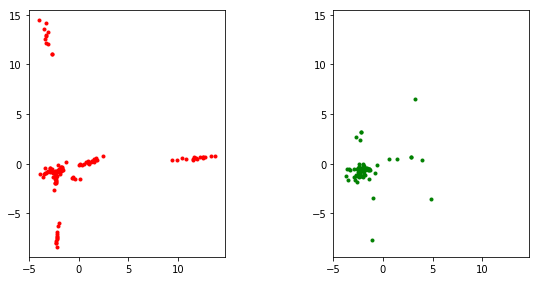

6001 [D loss: 0.502091, acc.: 75.00%] [G loss: 2.722350]
6002 [D loss: 0.544848, acc.: 71.97%] [G loss: 2.837545]
6003 [D loss: 0.531101, acc.: 71.97%] [G loss: 2.389846]
6004 [D loss: 0.490139, acc.: 78.79%] [G loss: 3.450457]
6005 [D loss: 0.553981, acc.: 75.00%] [G loss: 2.628816]
6006 [D loss: 0.547055, acc.: 70.08%] [G loss: 2.820441]
6007 [D loss: 0.529075, acc.: 74.62%] [G loss: 2.827753]
6008 [D loss: 0.540065, acc.: 75.00%] [G loss: 2.993722]
6009 [D loss: 0.502608, acc.: 75.76%] [G loss: 2.623195]
6010 [D loss: 0.468164, acc.: 76.89%] [G loss: 2.418866]
6011 [D loss: 0.468450, acc.: 79.17%] [G loss: 2.405399]
6012 [D loss: 0.535710, acc.: 73.11%] [G loss: 2.395267]
6013 [D loss: 0.485837, acc.: 77.65%] [G loss: 2.622313]
6014 [D loss: 0.507519, acc.: 73.48%] [G loss: 3.024997]
6015 [D loss: 0.504050, acc.: 77.65%] [G loss: 2.719135]
6016 [D loss: 0.525376, acc.: 71.97%] [G loss: 3.003411]
6017 [D loss: 0.476901, acc.: 75.38%] [G loss: 2.919236]
6018 [D loss: 0.512849, acc.: 7

6022 [D loss: 0.551518, acc.: 75.76%] [G loss: 3.365473]
6023 [D loss: 0.571362, acc.: 73.11%] [G loss: 2.354815]
6024 [D loss: 0.499474, acc.: 71.97%] [G loss: 2.221615]
6025 [D loss: 0.547110, acc.: 71.21%] [G loss: 2.483370]
6026 [D loss: 0.548320, acc.: 73.11%] [G loss: 2.848430]
6027 [D loss: 0.525852, acc.: 75.00%] [G loss: 2.050492]
6028 [D loss: 0.511686, acc.: 73.48%] [G loss: 2.201836]
6029 [D loss: 0.478284, acc.: 78.41%] [G loss: 2.622146]
6030 [D loss: 0.509395, acc.: 75.76%] [G loss: 2.154454]
6031 [D loss: 0.504965, acc.: 72.73%] [G loss: 2.906892]
6032 [D loss: 0.540507, acc.: 71.97%] [G loss: 3.113340]
6033 [D loss: 0.506257, acc.: 75.00%] [G loss: 2.975500]
6034 [D loss: 0.486055, acc.: 76.52%] [G loss: 2.579415]
6035 [D loss: 0.529821, acc.: 74.24%] [G loss: 2.448813]
6036 [D loss: 0.518514, acc.: 73.86%] [G loss: 2.594158]
6037 [D loss: 0.528968, acc.: 75.00%] [G loss: 2.749136]
6038 [D loss: 0.484204, acc.: 76.89%] [G loss: 2.762508]
6039 [D loss: 0.502201, acc.: 7

6044 [D loss: 0.493513, acc.: 77.65%] [G loss: 2.752210]
6045 [D loss: 0.499531, acc.: 75.38%] [G loss: 3.573615]
6046 [D loss: 0.506428, acc.: 76.89%] [G loss: 2.647312]
6047 [D loss: 0.474662, acc.: 78.03%] [G loss: 3.269820]
6048 [D loss: 0.493044, acc.: 75.76%] [G loss: 3.361371]
6049 [D loss: 0.604071, acc.: 73.11%] [G loss: 2.777062]
6050 [D loss: 0.532443, acc.: 72.73%] [G loss: 2.679720]
6051 [D loss: 0.508057, acc.: 75.00%] [G loss: 2.591572]
6052 [D loss: 0.557790, acc.: 73.48%] [G loss: 2.880491]
6053 [D loss: 0.568738, acc.: 72.73%] [G loss: 2.607655]
6054 [D loss: 0.543222, acc.: 73.48%] [G loss: 3.006477]
6055 [D loss: 0.575944, acc.: 70.83%] [G loss: 2.478431]
6056 [D loss: 0.496749, acc.: 76.14%] [G loss: 2.549790]
6057 [D loss: 0.503382, acc.: 76.89%] [G loss: 2.541604]
6058 [D loss: 0.520864, acc.: 74.62%] [G loss: 3.028994]
6059 [D loss: 0.464044, acc.: 78.03%] [G loss: 3.219898]
6060 [D loss: 0.553453, acc.: 72.73%] [G loss: 3.039042]
6061 [D loss: 0.521408, acc.: 7

6066 [D loss: 0.507935, acc.: 71.59%] [G loss: 2.596800]
6067 [D loss: 0.514635, acc.: 73.86%] [G loss: 2.954237]
6068 [D loss: 0.521584, acc.: 75.38%] [G loss: 2.320731]
6069 [D loss: 0.517528, acc.: 73.86%] [G loss: 2.862400]
6070 [D loss: 0.449626, acc.: 79.55%] [G loss: 2.799478]
6071 [D loss: 0.490406, acc.: 75.00%] [G loss: 3.075241]
6072 [D loss: 0.507015, acc.: 76.52%] [G loss: 2.470324]
6073 [D loss: 0.557340, acc.: 74.62%] [G loss: 2.506824]
6074 [D loss: 0.501342, acc.: 75.76%] [G loss: 2.754275]
6075 [D loss: 0.532757, acc.: 73.11%] [G loss: 2.641842]
6076 [D loss: 0.506228, acc.: 75.76%] [G loss: 2.409976]
6077 [D loss: 0.516820, acc.: 78.03%] [G loss: 2.685981]
6078 [D loss: 0.491546, acc.: 75.38%] [G loss: 2.689415]
6079 [D loss: 0.480026, acc.: 76.52%] [G loss: 2.873177]
6080 [D loss: 0.514931, acc.: 74.24%] [G loss: 2.297349]
6081 [D loss: 0.521466, acc.: 74.62%] [G loss: 2.419107]
6082 [D loss: 0.531157, acc.: 72.35%] [G loss: 2.509680]
6083 [D loss: 0.594799, acc.: 6

6088 [D loss: 0.530384, acc.: 73.11%] [G loss: 2.448640]
6089 [D loss: 0.560788, acc.: 68.18%] [G loss: 2.378703]
6090 [D loss: 0.511224, acc.: 73.48%] [G loss: 2.329248]
6091 [D loss: 0.552620, acc.: 71.59%] [G loss: 2.298305]
6092 [D loss: 0.518299, acc.: 73.48%] [G loss: 2.264690]
6093 [D loss: 0.480309, acc.: 75.00%] [G loss: 2.241197]
6094 [D loss: 0.511885, acc.: 75.00%] [G loss: 2.647729]
6095 [D loss: 0.515708, acc.: 74.24%] [G loss: 2.579686]
6096 [D loss: 0.537748, acc.: 72.73%] [G loss: 2.319210]
6097 [D loss: 0.527114, acc.: 76.89%] [G loss: 2.254276]
6098 [D loss: 0.513204, acc.: 73.11%] [G loss: 3.076585]
6099 [D loss: 0.532739, acc.: 72.73%] [G loss: 2.941778]
6100 [D loss: 0.483125, acc.: 77.27%] [G loss: 2.673179]
6101 [D loss: 0.516874, acc.: 77.27%] [G loss: 2.521933]
6102 [D loss: 0.485883, acc.: 75.00%] [G loss: 2.427402]
6103 [D loss: 0.536125, acc.: 73.11%] [G loss: 2.530704]
6104 [D loss: 0.535194, acc.: 73.11%] [G loss: 2.412701]
6105 [D loss: 0.501853, acc.: 7

6110 [D loss: 0.474244, acc.: 77.27%] [G loss: 3.235671]
6111 [D loss: 0.445555, acc.: 81.44%] [G loss: 3.769918]
6112 [D loss: 0.572601, acc.: 73.11%] [G loss: 2.792945]
6113 [D loss: 0.516074, acc.: 75.76%] [G loss: 2.724123]
6114 [D loss: 0.486060, acc.: 77.65%] [G loss: 2.918343]
6115 [D loss: 0.503257, acc.: 75.38%] [G loss: 3.153601]
6116 [D loss: 0.528925, acc.: 73.48%] [G loss: 3.125705]
6117 [D loss: 0.474139, acc.: 79.17%] [G loss: 2.581738]
6118 [D loss: 0.519468, acc.: 75.00%] [G loss: 3.302740]
6119 [D loss: 0.543188, acc.: 73.11%] [G loss: 2.759411]
6120 [D loss: 0.525328, acc.: 73.11%] [G loss: 2.183562]
6121 [D loss: 0.590720, acc.: 69.32%] [G loss: 2.299723]
6122 [D loss: 0.521625, acc.: 75.76%] [G loss: 2.549483]
6123 [D loss: 0.516427, acc.: 74.24%] [G loss: 2.291386]
6124 [D loss: 0.488487, acc.: 76.14%] [G loss: 3.151038]
6125 [D loss: 0.527471, acc.: 72.73%] [G loss: 2.610465]
6126 [D loss: 0.539665, acc.: 73.86%] [G loss: 3.093784]
6127 [D loss: 0.454937, acc.: 7

6132 [D loss: 0.527640, acc.: 71.21%] [G loss: 2.787553]
6133 [D loss: 0.619336, acc.: 70.83%] [G loss: 2.785858]
6134 [D loss: 0.521579, acc.: 73.86%] [G loss: 3.160318]
6135 [D loss: 0.485039, acc.: 76.52%] [G loss: 3.214665]
6136 [D loss: 0.528033, acc.: 73.86%] [G loss: 3.328097]
6137 [D loss: 0.495885, acc.: 75.76%] [G loss: 2.541278]
6138 [D loss: 0.489635, acc.: 76.52%] [G loss: 3.186577]
6139 [D loss: 0.521126, acc.: 74.62%] [G loss: 2.876834]
6140 [D loss: 0.469630, acc.: 76.89%] [G loss: 2.750901]
6141 [D loss: 0.507950, acc.: 77.27%] [G loss: 3.166772]
6142 [D loss: 0.575617, acc.: 70.45%] [G loss: 2.507208]
6143 [D loss: 0.523137, acc.: 76.14%] [G loss: 2.332355]
6144 [D loss: 0.477082, acc.: 78.03%] [G loss: 2.343324]
6145 [D loss: 0.496447, acc.: 76.89%] [G loss: 2.607286]
6146 [D loss: 0.490500, acc.: 78.41%] [G loss: 3.026519]
6147 [D loss: 0.535345, acc.: 73.11%] [G loss: 2.871593]
6148 [D loss: 0.538513, acc.: 75.76%] [G loss: 2.521854]
6149 [D loss: 0.542894, acc.: 7

6154 [D loss: 0.505553, acc.: 79.55%] [G loss: 2.639235]
6155 [D loss: 0.491452, acc.: 74.24%] [G loss: 3.102383]
6156 [D loss: 0.515026, acc.: 71.97%] [G loss: 2.686886]
6157 [D loss: 0.510830, acc.: 77.27%] [G loss: 2.778244]
6158 [D loss: 0.512206, acc.: 73.48%] [G loss: 3.079653]
6159 [D loss: 0.526674, acc.: 74.62%] [G loss: 2.570868]
6160 [D loss: 0.528351, acc.: 73.11%] [G loss: 3.025487]
6161 [D loss: 0.522154, acc.: 74.62%] [G loss: 2.278965]
6162 [D loss: 0.521335, acc.: 74.62%] [G loss: 3.182213]
6163 [D loss: 0.494186, acc.: 76.14%] [G loss: 2.808563]
6164 [D loss: 0.491879, acc.: 75.38%] [G loss: 2.678690]
6165 [D loss: 0.537644, acc.: 76.52%] [G loss: 2.544017]
6166 [D loss: 0.500068, acc.: 74.62%] [G loss: 2.375290]
6167 [D loss: 0.510310, acc.: 76.89%] [G loss: 2.755145]
6168 [D loss: 0.507948, acc.: 73.86%] [G loss: 2.613521]
6169 [D loss: 0.464057, acc.: 77.65%] [G loss: 2.892314]
6170 [D loss: 0.529861, acc.: 74.24%] [G loss: 2.598148]
6171 [D loss: 0.518405, acc.: 7

6175 [D loss: 0.520522, acc.: 71.97%] [G loss: 2.362614]
6176 [D loss: 0.544289, acc.: 70.83%] [G loss: 2.684806]
6177 [D loss: 0.523141, acc.: 71.97%] [G loss: 2.835302]
6178 [D loss: 0.494662, acc.: 76.52%] [G loss: 2.469972]
6179 [D loss: 0.537506, acc.: 68.94%] [G loss: 2.892787]
6180 [D loss: 0.577340, acc.: 73.86%] [G loss: 2.729523]
6181 [D loss: 0.483480, acc.: 76.89%] [G loss: 2.887898]
6182 [D loss: 0.504593, acc.: 73.48%] [G loss: 2.767105]
6183 [D loss: 0.537471, acc.: 74.24%] [G loss: 2.473678]
6184 [D loss: 0.518720, acc.: 74.24%] [G loss: 2.536111]
6185 [D loss: 0.510852, acc.: 75.38%] [G loss: 2.852549]
6186 [D loss: 0.528520, acc.: 72.35%] [G loss: 2.104060]
6187 [D loss: 0.528506, acc.: 73.86%] [G loss: 2.318422]
6188 [D loss: 0.559834, acc.: 73.86%] [G loss: 2.609053]
6189 [D loss: 0.497373, acc.: 75.76%] [G loss: 2.093700]
6190 [D loss: 0.495796, acc.: 76.14%] [G loss: 2.563166]
6191 [D loss: 0.482079, acc.: 77.27%] [G loss: 2.636375]
6192 [D loss: 0.540923, acc.: 7

6197 [D loss: 0.449967, acc.: 78.79%] [G loss: 2.520775]
6198 [D loss: 0.531479, acc.: 73.86%] [G loss: 2.712661]
6199 [D loss: 0.537889, acc.: 72.35%] [G loss: 2.430094]
6200 [D loss: 0.537961, acc.: 71.21%] [G loss: 2.441226]
6201 [D loss: 0.529958, acc.: 71.97%] [G loss: 2.890701]
6202 [D loss: 0.579826, acc.: 71.59%] [G loss: 2.352291]
6203 [D loss: 0.574450, acc.: 68.94%] [G loss: 2.653573]
6204 [D loss: 0.488567, acc.: 72.35%] [G loss: 2.487380]
6205 [D loss: 0.496692, acc.: 75.00%] [G loss: 2.662082]
6206 [D loss: 0.510567, acc.: 72.73%] [G loss: 3.220942]
6207 [D loss: 0.520264, acc.: 77.27%] [G loss: 2.583229]
6208 [D loss: 0.478446, acc.: 78.79%] [G loss: 2.267796]
6209 [D loss: 0.509137, acc.: 77.27%] [G loss: 3.147091]
6210 [D loss: 0.525691, acc.: 74.62%] [G loss: 2.883801]
6211 [D loss: 0.488388, acc.: 79.92%] [G loss: 3.175445]
6212 [D loss: 0.496068, acc.: 75.76%] [G loss: 2.967310]
6213 [D loss: 0.557780, acc.: 71.59%] [G loss: 2.743740]
6214 [D loss: 0.485515, acc.: 7

6219 [D loss: 0.492843, acc.: 76.52%] [G loss: 2.700926]
6220 [D loss: 0.490396, acc.: 76.14%] [G loss: 2.708990]
6221 [D loss: 0.433741, acc.: 81.82%] [G loss: 2.947354]
6222 [D loss: 0.538801, acc.: 76.52%] [G loss: 2.338707]
6223 [D loss: 0.520380, acc.: 72.35%] [G loss: 2.547538]
6224 [D loss: 0.532895, acc.: 75.38%] [G loss: 2.819484]
6225 [D loss: 0.494803, acc.: 77.27%] [G loss: 2.904316]
6226 [D loss: 0.477455, acc.: 76.89%] [G loss: 2.645962]
6227 [D loss: 0.515650, acc.: 74.24%] [G loss: 2.495348]
6228 [D loss: 0.524716, acc.: 77.27%] [G loss: 2.598259]
6229 [D loss: 0.593797, acc.: 68.94%] [G loss: 2.521777]
6230 [D loss: 0.537223, acc.: 75.00%] [G loss: 2.604305]
6231 [D loss: 0.475486, acc.: 77.65%] [G loss: 3.751076]
6232 [D loss: 0.519943, acc.: 76.89%] [G loss: 2.993069]
6233 [D loss: 0.598475, acc.: 71.21%] [G loss: 3.185799]
6234 [D loss: 0.492722, acc.: 76.89%] [G loss: 3.191622]
6235 [D loss: 0.527454, acc.: 77.27%] [G loss: 2.861853]
6236 [D loss: 0.508640, acc.: 7

6241 [D loss: 0.469818, acc.: 79.92%] [G loss: 2.505512]
6242 [D loss: 0.494562, acc.: 76.52%] [G loss: 2.783406]
6243 [D loss: 0.568075, acc.: 73.86%] [G loss: 1.976981]
6244 [D loss: 0.510429, acc.: 71.97%] [G loss: 2.846779]
6245 [D loss: 0.493820, acc.: 75.76%] [G loss: 2.944756]
6246 [D loss: 0.539542, acc.: 73.11%] [G loss: 2.396337]
6247 [D loss: 0.522702, acc.: 73.11%] [G loss: 2.429383]
6248 [D loss: 0.508449, acc.: 75.00%] [G loss: 2.639836]
6249 [D loss: 0.517455, acc.: 74.62%] [G loss: 2.330349]
6250 [D loss: 0.552246, acc.: 72.35%] [G loss: 2.510001]
6251 [D loss: 0.544190, acc.: 74.62%] [G loss: 2.322760]
6252 [D loss: 0.532924, acc.: 73.86%] [G loss: 2.469018]
6253 [D loss: 0.509072, acc.: 76.14%] [G loss: 2.792084]
6254 [D loss: 0.593737, acc.: 70.45%] [G loss: 2.818659]
6255 [D loss: 0.475470, acc.: 78.41%] [G loss: 2.994050]
6256 [D loss: 0.489314, acc.: 73.48%] [G loss: 2.620757]
6257 [D loss: 0.557651, acc.: 73.86%] [G loss: 2.593594]
6258 [D loss: 0.497233, acc.: 7

6262 [D loss: 0.523863, acc.: 75.38%] [G loss: 2.322874]
6263 [D loss: 0.497196, acc.: 75.00%] [G loss: 2.410172]
6264 [D loss: 0.498811, acc.: 73.86%] [G loss: 2.717059]
6265 [D loss: 0.540247, acc.: 73.48%] [G loss: 3.058564]
6266 [D loss: 0.520940, acc.: 72.73%] [G loss: 2.522137]
6267 [D loss: 0.480820, acc.: 76.89%] [G loss: 2.935849]
6268 [D loss: 0.528856, acc.: 76.14%] [G loss: 3.121450]
6269 [D loss: 0.524433, acc.: 75.00%] [G loss: 3.023135]
6270 [D loss: 0.534093, acc.: 75.38%] [G loss: 2.821452]
6271 [D loss: 0.569803, acc.: 74.62%] [G loss: 2.667780]
6272 [D loss: 0.532482, acc.: 73.48%] [G loss: 2.265260]
6273 [D loss: 0.532155, acc.: 73.86%] [G loss: 2.933306]
6274 [D loss: 0.471598, acc.: 80.68%] [G loss: 3.265484]
6275 [D loss: 0.519620, acc.: 75.38%] [G loss: 2.877707]
6276 [D loss: 0.495085, acc.: 76.14%] [G loss: 2.722943]
6277 [D loss: 0.519602, acc.: 75.38%] [G loss: 2.212614]
6278 [D loss: 0.542801, acc.: 73.11%] [G loss: 2.372918]
6279 [D loss: 0.554149, acc.: 7

6284 [D loss: 0.467726, acc.: 78.41%] [G loss: 3.223951]
6285 [D loss: 0.533189, acc.: 74.24%] [G loss: 2.485936]
6286 [D loss: 0.523498, acc.: 73.86%] [G loss: 2.728655]
6287 [D loss: 0.539564, acc.: 73.11%] [G loss: 2.573458]
6288 [D loss: 0.561187, acc.: 74.62%] [G loss: 2.960989]
6289 [D loss: 0.501428, acc.: 77.27%] [G loss: 2.417429]
6290 [D loss: 0.518333, acc.: 75.38%] [G loss: 2.595647]
6291 [D loss: 0.549432, acc.: 73.11%] [G loss: 2.534206]
6292 [D loss: 0.575764, acc.: 72.35%] [G loss: 2.583320]
6293 [D loss: 0.513616, acc.: 74.62%] [G loss: 2.986254]
6294 [D loss: 0.535554, acc.: 74.24%] [G loss: 2.603107]
6295 [D loss: 0.489802, acc.: 75.00%] [G loss: 2.109335]
6296 [D loss: 0.493591, acc.: 75.76%] [G loss: 2.704487]
6297 [D loss: 0.578848, acc.: 74.24%] [G loss: 2.510828]
6298 [D loss: 0.509781, acc.: 74.62%] [G loss: 2.551283]
6299 [D loss: 0.504897, acc.: 74.24%] [G loss: 2.538572]
6300 [D loss: 0.445972, acc.: 81.06%] [G loss: 2.865074]
6301 [D loss: 0.513614, acc.: 7

6306 [D loss: 0.473775, acc.: 78.41%] [G loss: 2.622713]
6307 [D loss: 0.480985, acc.: 75.38%] [G loss: 2.932964]
6308 [D loss: 0.496021, acc.: 77.27%] [G loss: 2.758602]
6309 [D loss: 0.516059, acc.: 75.38%] [G loss: 2.914922]
6310 [D loss: 0.491884, acc.: 76.14%] [G loss: 2.372119]
6311 [D loss: 0.501362, acc.: 77.65%] [G loss: 2.691793]
6312 [D loss: 0.516886, acc.: 78.41%] [G loss: 2.979257]
6313 [D loss: 0.504237, acc.: 77.65%] [G loss: 3.254177]
6314 [D loss: 0.553417, acc.: 72.73%] [G loss: 2.692111]
6315 [D loss: 0.473423, acc.: 80.30%] [G loss: 2.588805]
6316 [D loss: 0.525190, acc.: 72.73%] [G loss: 2.284659]
6317 [D loss: 0.498757, acc.: 74.62%] [G loss: 2.749535]
6318 [D loss: 0.562907, acc.: 72.35%] [G loss: 2.650390]
6319 [D loss: 0.538822, acc.: 73.86%] [G loss: 2.660104]
6320 [D loss: 0.532613, acc.: 71.59%] [G loss: 2.769027]
6321 [D loss: 0.511810, acc.: 75.00%] [G loss: 2.881464]
6322 [D loss: 0.551997, acc.: 75.76%] [G loss: 2.893629]
6323 [D loss: 0.534584, acc.: 7

6327 [D loss: 0.573062, acc.: 71.97%] [G loss: 3.064175]
6328 [D loss: 0.494229, acc.: 75.38%] [G loss: 2.926213]
6329 [D loss: 0.528797, acc.: 75.38%] [G loss: 2.932714]
6330 [D loss: 0.503623, acc.: 77.27%] [G loss: 2.501757]
6331 [D loss: 0.508497, acc.: 74.62%] [G loss: 2.951902]
6332 [D loss: 0.518321, acc.: 75.38%] [G loss: 2.450960]
6333 [D loss: 0.471472, acc.: 79.55%] [G loss: 2.797301]
6334 [D loss: 0.522292, acc.: 74.24%] [G loss: 2.710340]
6335 [D loss: 0.520223, acc.: 72.73%] [G loss: 2.363608]
6336 [D loss: 0.532148, acc.: 75.00%] [G loss: 2.685880]
6337 [D loss: 0.521586, acc.: 74.24%] [G loss: 2.917280]
6338 [D loss: 0.506824, acc.: 77.65%] [G loss: 2.766003]
6339 [D loss: 0.468826, acc.: 78.79%] [G loss: 2.815450]
6340 [D loss: 0.475448, acc.: 75.38%] [G loss: 3.092014]
6341 [D loss: 0.490144, acc.: 76.52%] [G loss: 3.867368]
6342 [D loss: 0.573289, acc.: 75.00%] [G loss: 2.870037]
6343 [D loss: 0.553714, acc.: 71.97%] [G loss: 2.974234]
6344 [D loss: 0.521257, acc.: 7

6349 [D loss: 0.475584, acc.: 79.17%] [G loss: 2.835610]
6350 [D loss: 0.547424, acc.: 72.35%] [G loss: 2.881244]
6351 [D loss: 0.519043, acc.: 73.48%] [G loss: 2.580732]
6352 [D loss: 0.524670, acc.: 75.00%] [G loss: 2.800901]
6353 [D loss: 0.508552, acc.: 75.38%] [G loss: 2.556031]
6354 [D loss: 0.494958, acc.: 75.76%] [G loss: 2.771967]
6355 [D loss: 0.494567, acc.: 76.52%] [G loss: 2.452642]
6356 [D loss: 0.530002, acc.: 73.86%] [G loss: 2.582768]
6357 [D loss: 0.525134, acc.: 73.48%] [G loss: 2.880821]
6358 [D loss: 0.504696, acc.: 75.38%] [G loss: 2.380644]
6359 [D loss: 0.562739, acc.: 71.21%] [G loss: 2.217937]
6360 [D loss: 0.536673, acc.: 74.24%] [G loss: 2.225976]
6361 [D loss: 0.492216, acc.: 77.65%] [G loss: 2.447877]
6362 [D loss: 0.549394, acc.: 71.21%] [G loss: 3.068442]
6363 [D loss: 0.507272, acc.: 75.76%] [G loss: 3.265769]
6364 [D loss: 0.447643, acc.: 81.06%] [G loss: 3.122287]
6365 [D loss: 0.544120, acc.: 72.73%] [G loss: 3.084859]
6366 [D loss: 0.539594, acc.: 7

6371 [D loss: 0.464614, acc.: 81.44%] [G loss: 2.716619]
6372 [D loss: 0.533646, acc.: 73.11%] [G loss: 2.415821]
6373 [D loss: 0.482384, acc.: 75.00%] [G loss: 2.846513]
6374 [D loss: 0.582603, acc.: 72.35%] [G loss: 2.710505]
6375 [D loss: 0.473582, acc.: 78.41%] [G loss: 2.758770]
6376 [D loss: 0.477757, acc.: 78.41%] [G loss: 2.445489]
6377 [D loss: 0.534599, acc.: 74.24%] [G loss: 2.704661]
6378 [D loss: 0.505854, acc.: 73.11%] [G loss: 2.694464]
6379 [D loss: 0.492150, acc.: 76.52%] [G loss: 2.229041]
6380 [D loss: 0.551771, acc.: 69.70%] [G loss: 2.649848]
6381 [D loss: 0.506299, acc.: 74.24%] [G loss: 2.360159]
6382 [D loss: 0.547620, acc.: 71.59%] [G loss: 2.307426]
6383 [D loss: 0.514384, acc.: 74.62%] [G loss: 3.382786]
6384 [D loss: 0.530923, acc.: 72.73%] [G loss: 2.635614]
6385 [D loss: 0.490324, acc.: 75.76%] [G loss: 2.716803]
6386 [D loss: 0.502969, acc.: 76.89%] [G loss: 2.880509]
6387 [D loss: 0.480288, acc.: 76.89%] [G loss: 2.784523]
6388 [D loss: 0.542762, acc.: 7

6393 [D loss: 0.546653, acc.: 74.24%] [G loss: 2.544952]
6394 [D loss: 0.537032, acc.: 74.62%] [G loss: 2.423465]
6395 [D loss: 0.474960, acc.: 79.92%] [G loss: 2.511336]
6396 [D loss: 0.580271, acc.: 70.08%] [G loss: 3.045228]
6397 [D loss: 0.523647, acc.: 71.97%] [G loss: 2.628253]
6398 [D loss: 0.494625, acc.: 73.11%] [G loss: 3.318968]
6399 [D loss: 0.491964, acc.: 76.89%] [G loss: 2.363915]
6400 [D loss: 0.495926, acc.: 78.79%] [G loss: 2.628193]
6401 [D loss: 0.468801, acc.: 81.06%] [G loss: 3.055264]
6402 [D loss: 0.501127, acc.: 75.38%] [G loss: 2.914188]
6403 [D loss: 0.505048, acc.: 76.14%] [G loss: 2.504014]
6404 [D loss: 0.586086, acc.: 69.32%] [G loss: 2.170629]
6405 [D loss: 0.510410, acc.: 75.00%] [G loss: 2.266226]
6406 [D loss: 0.497709, acc.: 74.62%] [G loss: 2.271672]
6407 [D loss: 0.544877, acc.: 69.70%] [G loss: 2.527978]
6408 [D loss: 0.480148, acc.: 78.79%] [G loss: 2.570285]
6409 [D loss: 0.483631, acc.: 79.17%] [G loss: 3.088214]
6410 [D loss: 0.555548, acc.: 7

6415 [D loss: 0.556964, acc.: 70.08%] [G loss: 2.618933]
6416 [D loss: 0.514237, acc.: 74.62%] [G loss: 2.395962]
6417 [D loss: 0.534122, acc.: 72.73%] [G loss: 2.456517]
6418 [D loss: 0.512135, acc.: 75.00%] [G loss: 2.353524]
6419 [D loss: 0.552718, acc.: 71.97%] [G loss: 2.565297]
6420 [D loss: 0.541020, acc.: 73.48%] [G loss: 2.635822]
6421 [D loss: 0.505270, acc.: 75.38%] [G loss: 2.283276]
6422 [D loss: 0.511289, acc.: 75.00%] [G loss: 2.752533]
6423 [D loss: 0.505128, acc.: 75.00%] [G loss: 2.498480]
6424 [D loss: 0.472246, acc.: 80.68%] [G loss: 2.548463]
6425 [D loss: 0.534789, acc.: 74.24%] [G loss: 2.977633]
6426 [D loss: 0.540377, acc.: 73.11%] [G loss: 2.229082]
6427 [D loss: 0.488907, acc.: 77.27%] [G loss: 3.040132]
6428 [D loss: 0.512350, acc.: 78.41%] [G loss: 2.658643]
6429 [D loss: 0.580137, acc.: 70.83%] [G loss: 3.072923]
6430 [D loss: 0.507350, acc.: 76.89%] [G loss: 2.821054]
6431 [D loss: 0.633371, acc.: 71.21%] [G loss: 2.787156]
6432 [D loss: 0.522629, acc.: 7

6437 [D loss: 0.501889, acc.: 75.00%] [G loss: 2.847072]
6438 [D loss: 0.632978, acc.: 71.97%] [G loss: 2.179782]
6439 [D loss: 0.516442, acc.: 72.73%] [G loss: 2.440819]
6440 [D loss: 0.501845, acc.: 76.14%] [G loss: 2.514999]
6441 [D loss: 0.482831, acc.: 78.03%] [G loss: 2.650233]
6442 [D loss: 0.535947, acc.: 71.97%] [G loss: 2.550146]
6443 [D loss: 0.505500, acc.: 77.27%] [G loss: 2.191008]
6444 [D loss: 0.510947, acc.: 74.62%] [G loss: 3.163329]
6445 [D loss: 0.472558, acc.: 76.89%] [G loss: 2.522116]
6446 [D loss: 0.567616, acc.: 71.97%] [G loss: 3.045411]
6447 [D loss: 0.468264, acc.: 78.41%] [G loss: 3.319195]
6448 [D loss: 0.530018, acc.: 75.38%] [G loss: 2.591698]
6449 [D loss: 0.480381, acc.: 79.17%] [G loss: 2.607136]
6450 [D loss: 0.522621, acc.: 76.14%] [G loss: 2.704633]
6451 [D loss: 0.525054, acc.: 75.00%] [G loss: 2.640251]
6452 [D loss: 0.493601, acc.: 77.65%] [G loss: 2.691471]
6453 [D loss: 0.514022, acc.: 75.76%] [G loss: 2.485164]
6454 [D loss: 0.500573, acc.: 7

6459 [D loss: 0.509810, acc.: 76.89%] [G loss: 2.996998]
6460 [D loss: 0.542905, acc.: 74.24%] [G loss: 2.624625]
6461 [D loss: 0.545892, acc.: 71.21%] [G loss: 2.292902]
6462 [D loss: 0.519926, acc.: 75.00%] [G loss: 2.644552]
6463 [D loss: 0.548518, acc.: 73.48%] [G loss: 2.138222]
6464 [D loss: 0.509946, acc.: 75.00%] [G loss: 2.504373]
6465 [D loss: 0.521321, acc.: 76.14%] [G loss: 2.194435]
6466 [D loss: 0.487284, acc.: 74.62%] [G loss: 3.685096]
6467 [D loss: 0.541264, acc.: 74.62%] [G loss: 2.508512]
6468 [D loss: 0.469708, acc.: 78.03%] [G loss: 2.960761]
6469 [D loss: 0.538671, acc.: 71.97%] [G loss: 2.459287]
6470 [D loss: 0.544996, acc.: 74.24%] [G loss: 3.097171]
6471 [D loss: 0.523386, acc.: 73.11%] [G loss: 2.778442]
6472 [D loss: 0.543343, acc.: 74.62%] [G loss: 2.572945]
6473 [D loss: 0.525645, acc.: 76.14%] [G loss: 2.327029]
6474 [D loss: 0.523357, acc.: 71.59%] [G loss: 2.894031]
6475 [D loss: 0.496922, acc.: 74.62%] [G loss: 2.729433]
6476 [D loss: 0.544769, acc.: 7

6480 [D loss: 0.535052, acc.: 74.62%] [G loss: 2.795875]
6481 [D loss: 0.530605, acc.: 73.48%] [G loss: 2.591398]
6482 [D loss: 0.477553, acc.: 78.41%] [G loss: 2.804035]
6483 [D loss: 0.588624, acc.: 72.35%] [G loss: 2.389697]
6484 [D loss: 0.491575, acc.: 77.65%] [G loss: 2.392262]
6485 [D loss: 0.543395, acc.: 72.35%] [G loss: 2.948838]
6486 [D loss: 0.492891, acc.: 78.79%] [G loss: 3.467790]
6487 [D loss: 0.511441, acc.: 75.76%] [G loss: 2.422205]
6488 [D loss: 0.531100, acc.: 74.62%] [G loss: 2.640136]
6489 [D loss: 0.509766, acc.: 78.03%] [G loss: 2.901325]
6490 [D loss: 0.466872, acc.: 78.79%] [G loss: 3.161581]
6491 [D loss: 0.505259, acc.: 76.52%] [G loss: 3.244189]
6492 [D loss: 0.562372, acc.: 76.14%] [G loss: 2.936364]
6493 [D loss: 0.436649, acc.: 80.30%] [G loss: 2.925526]
6494 [D loss: 0.538904, acc.: 73.48%] [G loss: 2.550621]
6495 [D loss: 0.502403, acc.: 74.62%] [G loss: 2.289352]
6496 [D loss: 0.491109, acc.: 76.14%] [G loss: 2.816765]
6497 [D loss: 0.492887, acc.: 7

6502 [D loss: 0.471280, acc.: 77.65%] [G loss: 2.775612]
6503 [D loss: 0.494048, acc.: 75.00%] [G loss: 3.276709]
6504 [D loss: 0.528953, acc.: 75.38%] [G loss: 2.699694]
6505 [D loss: 0.596074, acc.: 72.35%] [G loss: 2.759180]
6506 [D loss: 0.502611, acc.: 76.14%] [G loss: 2.387215]
6507 [D loss: 0.499076, acc.: 74.24%] [G loss: 2.304408]
6508 [D loss: 0.553756, acc.: 72.35%] [G loss: 2.623642]
6509 [D loss: 0.511688, acc.: 76.14%] [G loss: 2.405222]
6510 [D loss: 0.475006, acc.: 77.27%] [G loss: 2.422046]
6511 [D loss: 0.531085, acc.: 73.48%] [G loss: 2.003042]
6512 [D loss: 0.521757, acc.: 73.48%] [G loss: 2.329540]
6513 [D loss: 0.528495, acc.: 73.48%] [G loss: 2.510989]
6514 [D loss: 0.465780, acc.: 81.44%] [G loss: 2.405134]
6515 [D loss: 0.492726, acc.: 78.79%] [G loss: 3.020064]
6516 [D loss: 0.525380, acc.: 71.59%] [G loss: 2.678138]
6517 [D loss: 0.529729, acc.: 73.48%] [G loss: 2.753855]
6518 [D loss: 0.577705, acc.: 72.35%] [G loss: 2.663258]
6519 [D loss: 0.527217, acc.: 7

6524 [D loss: 0.534388, acc.: 71.21%] [G loss: 2.666983]
6525 [D loss: 0.501751, acc.: 76.14%] [G loss: 2.434938]
6526 [D loss: 0.528466, acc.: 72.35%] [G loss: 2.686193]
6527 [D loss: 0.571781, acc.: 75.38%] [G loss: 2.534023]
6528 [D loss: 0.463008, acc.: 78.79%] [G loss: 2.918669]
6529 [D loss: 0.482030, acc.: 78.79%] [G loss: 2.964962]
6530 [D loss: 0.482780, acc.: 79.92%] [G loss: 2.590065]
6531 [D loss: 0.514159, acc.: 75.76%] [G loss: 2.885193]
6532 [D loss: 0.559576, acc.: 74.24%] [G loss: 2.365451]
6533 [D loss: 0.521859, acc.: 74.24%] [G loss: 2.456539]
6534 [D loss: 0.535216, acc.: 71.97%] [G loss: 3.085339]
6535 [D loss: 0.477733, acc.: 74.62%] [G loss: 2.666112]
6536 [D loss: 0.520967, acc.: 76.52%] [G loss: 2.494158]
6537 [D loss: 0.502937, acc.: 74.24%] [G loss: 2.769193]
6538 [D loss: 0.504499, acc.: 73.86%] [G loss: 2.838154]
6539 [D loss: 0.543494, acc.: 72.73%] [G loss: 3.191668]
6540 [D loss: 0.551739, acc.: 73.86%] [G loss: 3.580535]
6541 [D loss: 0.551940, acc.: 7

6546 [D loss: 0.582149, acc.: 72.35%] [G loss: 2.162037]
6547 [D loss: 0.567011, acc.: 72.35%] [G loss: 2.367153]
6548 [D loss: 0.533254, acc.: 71.97%] [G loss: 2.525683]
6549 [D loss: 0.549039, acc.: 71.59%] [G loss: 2.570004]
6550 [D loss: 0.497230, acc.: 77.65%] [G loss: 2.539549]
6551 [D loss: 0.531529, acc.: 73.11%] [G loss: 2.476400]
6552 [D loss: 0.549938, acc.: 73.11%] [G loss: 2.422492]
6553 [D loss: 0.476170, acc.: 77.65%] [G loss: 2.604043]
6554 [D loss: 0.493738, acc.: 74.24%] [G loss: 2.657452]
6555 [D loss: 0.436746, acc.: 81.44%] [G loss: 3.299340]
6556 [D loss: 0.534667, acc.: 73.86%] [G loss: 3.518869]
6557 [D loss: 0.555005, acc.: 76.89%] [G loss: 2.315360]
6558 [D loss: 0.488008, acc.: 77.65%] [G loss: 2.752293]
6559 [D loss: 0.525240, acc.: 75.38%] [G loss: 2.070976]
6560 [D loss: 0.508611, acc.: 77.65%] [G loss: 2.556457]
6561 [D loss: 0.543393, acc.: 75.00%] [G loss: 2.710991]
6562 [D loss: 0.572124, acc.: 73.86%] [G loss: 2.959481]
6563 [D loss: 0.507779, acc.: 7

6567 [D loss: 0.490314, acc.: 75.38%] [G loss: 2.732168]
6568 [D loss: 0.545190, acc.: 70.45%] [G loss: 2.719667]
6569 [D loss: 0.478253, acc.: 78.79%] [G loss: 2.884478]
6570 [D loss: 0.502634, acc.: 78.41%] [G loss: 2.699501]
6571 [D loss: 0.522342, acc.: 75.00%] [G loss: 2.550529]
6572 [D loss: 0.521718, acc.: 75.00%] [G loss: 3.120659]
6573 [D loss: 0.441101, acc.: 80.68%] [G loss: 3.210765]
6574 [D loss: 0.568516, acc.: 72.73%] [G loss: 2.810011]
6575 [D loss: 0.447430, acc.: 79.17%] [G loss: 2.686267]
6576 [D loss: 0.548114, acc.: 72.73%] [G loss: 2.912416]
6577 [D loss: 0.538505, acc.: 78.03%] [G loss: 2.853719]
6578 [D loss: 0.521896, acc.: 73.11%] [G loss: 2.437190]
6579 [D loss: 0.572463, acc.: 71.21%] [G loss: 2.335267]
6580 [D loss: 0.523709, acc.: 72.35%] [G loss: 2.737754]
6581 [D loss: 0.566432, acc.: 71.59%] [G loss: 2.438945]
6582 [D loss: 0.530706, acc.: 75.00%] [G loss: 2.365088]
6583 [D loss: 0.518981, acc.: 74.24%] [G loss: 2.726890]
6584 [D loss: 0.536263, acc.: 7

6589 [D loss: 0.564580, acc.: 69.32%] [G loss: 2.556461]
6590 [D loss: 0.490220, acc.: 76.89%] [G loss: 2.688845]
6591 [D loss: 0.537465, acc.: 75.76%] [G loss: 3.005666]
6592 [D loss: 0.525584, acc.: 73.48%] [G loss: 2.702663]
6593 [D loss: 0.480143, acc.: 76.14%] [G loss: 2.314579]
6594 [D loss: 0.486416, acc.: 75.76%] [G loss: 2.947208]
6595 [D loss: 0.539847, acc.: 76.14%] [G loss: 2.528293]
6596 [D loss: 0.513223, acc.: 74.24%] [G loss: 2.514052]
6597 [D loss: 0.477390, acc.: 78.03%] [G loss: 2.742192]
6598 [D loss: 0.525939, acc.: 73.48%] [G loss: 2.610152]
6599 [D loss: 0.547760, acc.: 70.08%] [G loss: 2.346158]
6600 [D loss: 0.535462, acc.: 74.62%] [G loss: 2.445328]
6601 [D loss: 0.522928, acc.: 75.00%] [G loss: 2.485865]
6602 [D loss: 0.561533, acc.: 73.48%] [G loss: 2.877107]
6603 [D loss: 0.530256, acc.: 73.86%] [G loss: 2.910505]
6604 [D loss: 0.528632, acc.: 75.76%] [G loss: 2.373684]
6605 [D loss: 0.469577, acc.: 79.17%] [G loss: 3.133752]
6606 [D loss: 0.592234, acc.: 6

6611 [D loss: 0.531477, acc.: 77.27%] [G loss: 3.092654]
6612 [D loss: 0.510087, acc.: 76.52%] [G loss: 2.207743]
6613 [D loss: 0.527823, acc.: 75.76%] [G loss: 2.571315]
6614 [D loss: 0.539275, acc.: 75.00%] [G loss: 2.778063]
6615 [D loss: 0.528695, acc.: 73.86%] [G loss: 2.445353]
6616 [D loss: 0.491478, acc.: 76.14%] [G loss: 3.016373]
6617 [D loss: 0.519881, acc.: 76.14%] [G loss: 2.837906]
6618 [D loss: 0.532926, acc.: 74.24%] [G loss: 2.141630]
6619 [D loss: 0.521175, acc.: 73.86%] [G loss: 2.785427]
6620 [D loss: 0.535366, acc.: 73.11%] [G loss: 2.810362]
6621 [D loss: 0.476547, acc.: 76.52%] [G loss: 2.356333]
6622 [D loss: 0.516435, acc.: 73.86%] [G loss: 2.693055]
6623 [D loss: 0.509828, acc.: 72.35%] [G loss: 2.971271]
6624 [D loss: 0.527350, acc.: 74.62%] [G loss: 3.575566]
6625 [D loss: 0.506064, acc.: 75.00%] [G loss: 3.375604]
6626 [D loss: 0.505165, acc.: 75.38%] [G loss: 3.073384]
6627 [D loss: 0.494740, acc.: 75.76%] [G loss: 2.934338]
6628 [D loss: 0.569850, acc.: 7

6632 [D loss: 0.526130, acc.: 74.62%] [G loss: 2.456469]
6633 [D loss: 0.507666, acc.: 74.24%] [G loss: 2.967479]
6634 [D loss: 0.520499, acc.: 73.48%] [G loss: 2.989730]
6635 [D loss: 0.515145, acc.: 73.11%] [G loss: 2.798973]
6636 [D loss: 0.498223, acc.: 79.17%] [G loss: 3.080761]
6637 [D loss: 0.501416, acc.: 77.27%] [G loss: 2.180987]
6638 [D loss: 0.533605, acc.: 77.65%] [G loss: 2.999318]
6639 [D loss: 0.512638, acc.: 71.97%] [G loss: 2.376918]
6640 [D loss: 0.557645, acc.: 73.11%] [G loss: 2.353275]
6641 [D loss: 0.552849, acc.: 71.97%] [G loss: 2.923316]
6642 [D loss: 0.519870, acc.: 73.86%] [G loss: 3.078773]
6643 [D loss: 0.513766, acc.: 75.00%] [G loss: 2.770136]
6644 [D loss: 0.533511, acc.: 75.38%] [G loss: 2.978013]
6645 [D loss: 0.487084, acc.: 77.27%] [G loss: 2.263538]
6646 [D loss: 0.550876, acc.: 73.11%] [G loss: 2.865134]
6647 [D loss: 0.533213, acc.: 75.76%] [G loss: 2.550060]
6648 [D loss: 0.520573, acc.: 73.11%] [G loss: 2.728724]
6649 [D loss: 0.531963, acc.: 7

6654 [D loss: 0.515768, acc.: 72.35%] [G loss: 2.375812]
6655 [D loss: 0.494948, acc.: 74.24%] [G loss: 2.283079]
6656 [D loss: 0.550300, acc.: 73.86%] [G loss: 2.433385]
6657 [D loss: 0.526607, acc.: 75.38%] [G loss: 1.960219]
6658 [D loss: 0.512372, acc.: 73.48%] [G loss: 2.416277]
6659 [D loss: 0.529344, acc.: 74.62%] [G loss: 2.581406]
6660 [D loss: 0.508358, acc.: 73.48%] [G loss: 2.669445]
6661 [D loss: 0.489051, acc.: 76.52%] [G loss: 3.510018]
6662 [D loss: 0.524383, acc.: 74.62%] [G loss: 2.961710]
6663 [D loss: 0.522379, acc.: 76.14%] [G loss: 2.794777]
6664 [D loss: 0.543501, acc.: 71.21%] [G loss: 2.780234]
6665 [D loss: 0.504207, acc.: 76.52%] [G loss: 2.970238]
6666 [D loss: 0.545040, acc.: 75.76%] [G loss: 2.955433]
6667 [D loss: 0.456219, acc.: 81.44%] [G loss: 3.223987]
6668 [D loss: 0.496032, acc.: 76.52%] [G loss: 3.193945]
6669 [D loss: 0.623895, acc.: 69.32%] [G loss: 3.350006]
6670 [D loss: 0.553279, acc.: 75.00%] [G loss: 2.828898]
6671 [D loss: 0.568095, acc.: 7

6676 [D loss: 0.560589, acc.: 70.45%] [G loss: 2.387615]
6677 [D loss: 0.471425, acc.: 78.03%] [G loss: 2.319765]
6678 [D loss: 0.509749, acc.: 75.38%] [G loss: 3.276747]
6679 [D loss: 0.565889, acc.: 75.38%] [G loss: 2.662743]
6680 [D loss: 0.524157, acc.: 75.38%] [G loss: 2.732130]
6681 [D loss: 0.554875, acc.: 69.70%] [G loss: 2.198668]
6682 [D loss: 0.573665, acc.: 70.08%] [G loss: 2.454202]
6683 [D loss: 0.572685, acc.: 72.73%] [G loss: 2.210226]
6684 [D loss: 0.520754, acc.: 76.89%] [G loss: 2.740488]
6685 [D loss: 0.490186, acc.: 76.52%] [G loss: 2.053165]
6686 [D loss: 0.551252, acc.: 75.38%] [G loss: 2.810987]
6687 [D loss: 0.489172, acc.: 76.89%] [G loss: 2.705598]
6688 [D loss: 0.539481, acc.: 72.35%] [G loss: 2.504108]
6689 [D loss: 0.498593, acc.: 76.14%] [G loss: 2.262447]
6690 [D loss: 0.613884, acc.: 70.45%] [G loss: 2.048054]
6691 [D loss: 0.516370, acc.: 73.48%] [G loss: 2.679649]
6692 [D loss: 0.496124, acc.: 76.52%] [G loss: 2.284770]
6693 [D loss: 0.513223, acc.: 7

6698 [D loss: 0.556513, acc.: 73.11%] [G loss: 2.133315]
6699 [D loss: 0.504675, acc.: 76.14%] [G loss: 2.094077]
6700 [D loss: 0.513011, acc.: 75.00%] [G loss: 2.733066]
6701 [D loss: 0.456043, acc.: 79.17%] [G loss: 2.374104]
6702 [D loss: 0.518453, acc.: 75.00%] [G loss: 2.281435]
6703 [D loss: 0.620161, acc.: 73.86%] [G loss: 2.416703]
6704 [D loss: 0.529075, acc.: 73.48%] [G loss: 2.693388]
6705 [D loss: 0.563906, acc.: 70.08%] [G loss: 2.336729]
6706 [D loss: 0.554290, acc.: 71.59%] [G loss: 2.264668]
6707 [D loss: 0.514328, acc.: 73.86%] [G loss: 2.591596]
6708 [D loss: 0.525234, acc.: 73.48%] [G loss: 2.281342]
6709 [D loss: 0.506945, acc.: 74.24%] [G loss: 2.844015]
6710 [D loss: 0.567454, acc.: 71.97%] [G loss: 2.443527]
6711 [D loss: 0.520653, acc.: 72.73%] [G loss: 1.962404]
6712 [D loss: 0.503492, acc.: 78.03%] [G loss: 2.195854]
6713 [D loss: 0.517942, acc.: 74.24%] [G loss: 2.737848]
6714 [D loss: 0.598825, acc.: 69.32%] [G loss: 2.600149]
6715 [D loss: 0.495921, acc.: 7

6719 [D loss: 0.531826, acc.: 76.14%] [G loss: 2.671910]
6720 [D loss: 0.537306, acc.: 73.48%] [G loss: 2.775532]
6721 [D loss: 0.554116, acc.: 72.35%] [G loss: 2.537179]
6722 [D loss: 0.542811, acc.: 72.35%] [G loss: 2.593122]
6723 [D loss: 0.496888, acc.: 74.24%] [G loss: 2.516992]
6724 [D loss: 0.501950, acc.: 76.14%] [G loss: 3.213428]
6725 [D loss: 0.551133, acc.: 73.86%] [G loss: 2.736425]
6726 [D loss: 0.577511, acc.: 67.80%] [G loss: 2.408532]
6727 [D loss: 0.525100, acc.: 71.21%] [G loss: 2.605620]
6728 [D loss: 0.515007, acc.: 73.48%] [G loss: 2.684122]
6729 [D loss: 0.520549, acc.: 77.65%] [G loss: 2.690360]
6730 [D loss: 0.487350, acc.: 76.89%] [G loss: 3.290083]
6731 [D loss: 0.548553, acc.: 74.24%] [G loss: 3.010189]
6732 [D loss: 0.457191, acc.: 79.55%] [G loss: 2.916435]
6733 [D loss: 0.566585, acc.: 70.08%] [G loss: 3.126693]
6734 [D loss: 0.506910, acc.: 71.21%] [G loss: 2.514414]
6735 [D loss: 0.494809, acc.: 77.65%] [G loss: 2.983786]
6736 [D loss: 0.513087, acc.: 7

6741 [D loss: 0.559258, acc.: 76.14%] [G loss: 2.797960]
6742 [D loss: 0.501539, acc.: 75.38%] [G loss: 3.140508]
6743 [D loss: 0.508873, acc.: 74.62%] [G loss: 2.981742]
6744 [D loss: 0.534584, acc.: 73.86%] [G loss: 2.774976]
6745 [D loss: 0.512124, acc.: 73.11%] [G loss: 2.643940]
6746 [D loss: 0.509285, acc.: 76.14%] [G loss: 2.651034]
6747 [D loss: 0.564969, acc.: 76.14%] [G loss: 2.357086]
6748 [D loss: 0.514627, acc.: 75.76%] [G loss: 3.267147]
6749 [D loss: 0.492916, acc.: 75.76%] [G loss: 3.049893]
6750 [D loss: 0.480648, acc.: 78.03%] [G loss: 3.056123]
6751 [D loss: 0.542573, acc.: 73.86%] [G loss: 3.141128]
6752 [D loss: 0.497971, acc.: 77.27%] [G loss: 2.893878]
6753 [D loss: 0.524470, acc.: 73.86%] [G loss: 2.826131]
6754 [D loss: 0.539703, acc.: 75.00%] [G loss: 2.667255]
6755 [D loss: 0.559008, acc.: 73.48%] [G loss: 2.799902]
6756 [D loss: 0.528330, acc.: 75.38%] [G loss: 2.591129]
6757 [D loss: 0.554106, acc.: 71.97%] [G loss: 2.254680]
6758 [D loss: 0.473617, acc.: 7

6763 [D loss: 0.577114, acc.: 70.83%] [G loss: 2.950567]
6764 [D loss: 0.460064, acc.: 80.68%] [G loss: 3.015299]
6765 [D loss: 0.481169, acc.: 76.89%] [G loss: 2.493158]
6766 [D loss: 0.558224, acc.: 72.73%] [G loss: 2.531823]
6767 [D loss: 0.515497, acc.: 76.14%] [G loss: 2.924712]
6768 [D loss: 0.522135, acc.: 73.86%] [G loss: 2.613914]
6769 [D loss: 0.506450, acc.: 77.27%] [G loss: 2.503991]
6770 [D loss: 0.591901, acc.: 69.70%] [G loss: 2.148266]
6771 [D loss: 0.513126, acc.: 75.76%] [G loss: 2.528420]
6772 [D loss: 0.556357, acc.: 74.24%] [G loss: 2.471838]
6773 [D loss: 0.499784, acc.: 76.52%] [G loss: 2.381186]
6774 [D loss: 0.515175, acc.: 75.38%] [G loss: 2.599414]
6775 [D loss: 0.546980, acc.: 70.83%] [G loss: 2.216448]
6776 [D loss: 0.546114, acc.: 73.86%] [G loss: 2.710230]
6777 [D loss: 0.581488, acc.: 72.35%] [G loss: 2.626778]
6778 [D loss: 0.508157, acc.: 76.14%] [G loss: 2.731553]
6779 [D loss: 0.500727, acc.: 73.86%] [G loss: 2.568696]
6780 [D loss: 0.546163, acc.: 7

6785 [D loss: 0.465760, acc.: 77.65%] [G loss: 2.798231]
6786 [D loss: 0.507715, acc.: 77.65%] [G loss: 2.366786]
6787 [D loss: 0.489344, acc.: 75.76%] [G loss: 2.505759]
6788 [D loss: 0.508173, acc.: 77.65%] [G loss: 2.536860]
6789 [D loss: 0.589974, acc.: 73.11%] [G loss: 2.270483]
6790 [D loss: 0.492922, acc.: 76.89%] [G loss: 2.275770]
6791 [D loss: 0.540640, acc.: 74.62%] [G loss: 2.121158]
6792 [D loss: 0.512217, acc.: 74.62%] [G loss: 2.495090]
6793 [D loss: 0.449786, acc.: 80.30%] [G loss: 2.687828]
6794 [D loss: 0.483119, acc.: 78.03%] [G loss: 3.343923]
6795 [D loss: 0.577006, acc.: 71.59%] [G loss: 3.359153]
6796 [D loss: 0.458648, acc.: 79.92%] [G loss: 2.773207]
6797 [D loss: 0.526644, acc.: 80.68%] [G loss: 2.735049]
6798 [D loss: 0.515685, acc.: 78.03%] [G loss: 3.172619]
6799 [D loss: 0.547597, acc.: 76.89%] [G loss: 2.576830]
6800 [D loss: 0.549299, acc.: 72.35%] [G loss: 2.625658]
6801 [D loss: 0.593204, acc.: 69.32%] [G loss: 3.030733]
6802 [D loss: 0.503278, acc.: 7

6807 [D loss: 0.660246, acc.: 67.42%] [G loss: 2.011669]
6808 [D loss: 0.504288, acc.: 74.62%] [G loss: 2.454411]
6809 [D loss: 0.537848, acc.: 73.86%] [G loss: 2.590407]
6810 [D loss: 0.573580, acc.: 73.11%] [G loss: 2.277159]
6811 [D loss: 0.489684, acc.: 78.03%] [G loss: 2.355045]
6812 [D loss: 0.571701, acc.: 72.73%] [G loss: 2.709211]
6813 [D loss: 0.519943, acc.: 77.65%] [G loss: 2.403780]
6814 [D loss: 0.510289, acc.: 75.76%] [G loss: 2.435153]
6815 [D loss: 0.540681, acc.: 69.32%] [G loss: 2.293735]
6816 [D loss: 0.540846, acc.: 74.24%] [G loss: 2.613348]
6817 [D loss: 0.591781, acc.: 69.32%] [G loss: 2.332669]
6818 [D loss: 0.481593, acc.: 76.52%] [G loss: 2.712190]
6819 [D loss: 0.529179, acc.: 79.17%] [G loss: 2.289699]
6820 [D loss: 0.525032, acc.: 72.73%] [G loss: 2.635309]
6821 [D loss: 0.619837, acc.: 70.08%] [G loss: 1.906571]
6822 [D loss: 0.539406, acc.: 71.59%] [G loss: 2.264764]
6823 [D loss: 0.536726, acc.: 74.24%] [G loss: 2.146893]
6824 [D loss: 0.550275, acc.: 7

6829 [D loss: 0.514291, acc.: 74.62%] [G loss: 2.338067]
6830 [D loss: 0.518630, acc.: 74.24%] [G loss: 3.066110]
6831 [D loss: 0.518662, acc.: 75.00%] [G loss: 2.579263]
6832 [D loss: 0.496609, acc.: 76.52%] [G loss: 2.482181]
6833 [D loss: 0.558317, acc.: 76.14%] [G loss: 2.534965]
6834 [D loss: 0.480239, acc.: 78.41%] [G loss: 3.213591]
6835 [D loss: 0.479471, acc.: 79.17%] [G loss: 2.407781]
6836 [D loss: 0.526369, acc.: 76.52%] [G loss: 2.875677]
6837 [D loss: 0.553107, acc.: 74.24%] [G loss: 2.702919]
6838 [D loss: 0.482607, acc.: 76.14%] [G loss: 3.007607]
6839 [D loss: 0.459397, acc.: 79.55%] [G loss: 3.131354]
6840 [D loss: 0.544673, acc.: 76.14%] [G loss: 2.572109]
6841 [D loss: 0.500368, acc.: 76.89%] [G loss: 3.042055]
6842 [D loss: 0.562530, acc.: 75.00%] [G loss: 2.360699]
6843 [D loss: 0.481586, acc.: 76.89%] [G loss: 2.364796]
6844 [D loss: 0.591281, acc.: 77.65%] [G loss: 2.186385]
6845 [D loss: 0.538598, acc.: 73.48%] [G loss: 2.254276]
6846 [D loss: 0.505569, acc.: 7

6851 [D loss: 0.535946, acc.: 76.52%] [G loss: 2.455069]
6852 [D loss: 0.520193, acc.: 75.76%] [G loss: 2.638908]
6853 [D loss: 0.528380, acc.: 74.24%] [G loss: 2.666761]
6854 [D loss: 0.559422, acc.: 71.97%] [G loss: 2.560442]
6855 [D loss: 0.536202, acc.: 73.86%] [G loss: 2.265493]
6856 [D loss: 0.502028, acc.: 76.52%] [G loss: 1.911007]
6857 [D loss: 0.540366, acc.: 78.03%] [G loss: 2.721284]
6858 [D loss: 0.484193, acc.: 79.17%] [G loss: 2.664510]
6859 [D loss: 0.557908, acc.: 75.00%] [G loss: 2.274420]
6860 [D loss: 0.483314, acc.: 76.52%] [G loss: 2.457716]
6861 [D loss: 0.552266, acc.: 71.21%] [G loss: 1.880044]
6862 [D loss: 0.541089, acc.: 71.59%] [G loss: 2.621647]
6863 [D loss: 0.564858, acc.: 76.89%] [G loss: 2.221898]
6864 [D loss: 0.539079, acc.: 76.52%] [G loss: 2.811803]
6865 [D loss: 0.539160, acc.: 71.97%] [G loss: 2.208506]
6866 [D loss: 0.571521, acc.: 72.35%] [G loss: 2.241442]
6867 [D loss: 0.539622, acc.: 75.00%] [G loss: 2.879725]
6868 [D loss: 0.500271, acc.: 7

6873 [D loss: 0.534991, acc.: 71.97%] [G loss: 3.381759]
6874 [D loss: 0.488761, acc.: 79.17%] [G loss: 2.459100]
6875 [D loss: 0.508646, acc.: 75.38%] [G loss: 2.377404]
6876 [D loss: 0.524942, acc.: 76.14%] [G loss: 2.433855]
6877 [D loss: 0.576596, acc.: 70.08%] [G loss: 2.224255]
6878 [D loss: 0.566085, acc.: 71.59%] [G loss: 2.061119]
6879 [D loss: 0.517975, acc.: 73.48%] [G loss: 2.606704]
6880 [D loss: 0.528739, acc.: 73.48%] [G loss: 2.347795]
6881 [D loss: 0.653257, acc.: 69.32%] [G loss: 2.247448]
6882 [D loss: 0.538396, acc.: 74.62%] [G loss: 2.376287]
6883 [D loss: 0.545300, acc.: 70.45%] [G loss: 2.251016]
6884 [D loss: 0.510569, acc.: 72.35%] [G loss: 2.096229]
6885 [D loss: 0.522802, acc.: 73.86%] [G loss: 2.075128]
6886 [D loss: 0.560987, acc.: 71.97%] [G loss: 2.875642]
6887 [D loss: 0.616447, acc.: 69.32%] [G loss: 3.017528]
6888 [D loss: 0.545726, acc.: 73.86%] [G loss: 2.495636]
6889 [D loss: 0.592672, acc.: 71.21%] [G loss: 1.985421]
6890 [D loss: 0.520093, acc.: 7

6895 [D loss: 0.509750, acc.: 76.89%] [G loss: 2.808465]
6896 [D loss: 0.501563, acc.: 76.89%] [G loss: 2.401779]
6897 [D loss: 0.604897, acc.: 73.48%] [G loss: 2.372256]
6898 [D loss: 0.496393, acc.: 78.79%] [G loss: 3.002303]
6899 [D loss: 0.492063, acc.: 78.41%] [G loss: 2.446247]
6900 [D loss: 0.550592, acc.: 76.52%] [G loss: 2.895858]
6901 [D loss: 0.499229, acc.: 77.65%] [G loss: 3.015227]
6902 [D loss: 0.531344, acc.: 77.27%] [G loss: 2.799900]
6903 [D loss: 0.557272, acc.: 75.38%] [G loss: 2.591813]
6904 [D loss: 0.472214, acc.: 78.03%] [G loss: 3.070254]
6905 [D loss: 0.588233, acc.: 73.11%] [G loss: 2.726336]
6906 [D loss: 0.522030, acc.: 74.62%] [G loss: 2.461057]
6907 [D loss: 0.532042, acc.: 73.11%] [G loss: 2.317139]
6908 [D loss: 0.508332, acc.: 78.79%] [G loss: 2.952983]
6909 [D loss: 0.463971, acc.: 80.30%] [G loss: 2.954502]
6910 [D loss: 0.518546, acc.: 75.76%] [G loss: 2.588130]
6911 [D loss: 0.496161, acc.: 74.24%] [G loss: 2.753318]
6912 [D loss: 0.513852, acc.: 7

6917 [D loss: 0.461892, acc.: 77.27%] [G loss: 2.934654]
6918 [D loss: 0.510292, acc.: 75.76%] [G loss: 2.604129]
6919 [D loss: 0.563551, acc.: 73.86%] [G loss: 2.395427]
6920 [D loss: 0.566915, acc.: 72.35%] [G loss: 2.644356]
6921 [D loss: 0.506500, acc.: 75.38%] [G loss: 2.845972]
6922 [D loss: 0.549514, acc.: 72.73%] [G loss: 2.660597]
6923 [D loss: 0.507844, acc.: 74.62%] [G loss: 2.189347]
6924 [D loss: 0.577896, acc.: 71.21%] [G loss: 2.590998]
6925 [D loss: 0.556845, acc.: 74.62%] [G loss: 2.547723]
6926 [D loss: 0.498180, acc.: 77.27%] [G loss: 2.785262]
6927 [D loss: 0.569103, acc.: 71.59%] [G loss: 2.457715]
6928 [D loss: 0.526191, acc.: 72.73%] [G loss: 2.693423]
6929 [D loss: 0.473672, acc.: 76.52%] [G loss: 2.668403]
6930 [D loss: 0.588632, acc.: 78.03%] [G loss: 2.609321]
6931 [D loss: 0.569126, acc.: 71.97%] [G loss: 2.507290]
6932 [D loss: 0.473224, acc.: 80.30%] [G loss: 2.434640]
6933 [D loss: 0.543040, acc.: 74.24%] [G loss: 2.396358]
6934 [D loss: 0.554463, acc.: 7

6939 [D loss: 0.571746, acc.: 71.21%] [G loss: 2.268165]
6940 [D loss: 0.567897, acc.: 75.38%] [G loss: 2.434195]
6941 [D loss: 0.536193, acc.: 73.48%] [G loss: 2.514539]
6942 [D loss: 0.480893, acc.: 75.00%] [G loss: 3.015337]
6943 [D loss: 0.504024, acc.: 77.65%] [G loss: 2.707556]
6944 [D loss: 0.530019, acc.: 73.48%] [G loss: 3.142605]
6945 [D loss: 0.502682, acc.: 76.89%] [G loss: 3.058571]
6946 [D loss: 0.491700, acc.: 75.76%] [G loss: 2.728180]
6947 [D loss: 0.433936, acc.: 81.82%] [G loss: 2.545309]
6948 [D loss: 0.547158, acc.: 73.48%] [G loss: 2.568631]
6949 [D loss: 0.540059, acc.: 73.11%] [G loss: 2.449003]
6950 [D loss: 0.519085, acc.: 75.76%] [G loss: 2.617067]
6951 [D loss: 0.568642, acc.: 74.62%] [G loss: 2.717937]
6952 [D loss: 0.494565, acc.: 77.65%] [G loss: 2.512963]
6953 [D loss: 0.512373, acc.: 76.14%] [G loss: 2.492958]
6954 [D loss: 0.480618, acc.: 77.65%] [G loss: 2.840592]
6955 [D loss: 0.553894, acc.: 75.38%] [G loss: 3.039413]
6956 [D loss: 0.518817, acc.: 7

6961 [D loss: 0.533011, acc.: 75.76%] [G loss: 2.543998]
6962 [D loss: 0.534825, acc.: 73.86%] [G loss: 2.494660]
6963 [D loss: 0.550414, acc.: 71.21%] [G loss: 2.187129]
6964 [D loss: 0.509886, acc.: 75.76%] [G loss: 2.866405]
6965 [D loss: 0.507131, acc.: 75.76%] [G loss: 2.919109]
6966 [D loss: 0.494538, acc.: 77.27%] [G loss: 2.688147]
6967 [D loss: 0.487064, acc.: 78.41%] [G loss: 2.643897]
6968 [D loss: 0.528645, acc.: 74.62%] [G loss: 2.529397]
6969 [D loss: 0.504939, acc.: 75.76%] [G loss: 2.939195]
6970 [D loss: 0.508157, acc.: 76.89%] [G loss: 2.799143]
6971 [D loss: 0.507880, acc.: 76.14%] [G loss: 2.885758]
6972 [D loss: 0.539443, acc.: 70.45%] [G loss: 2.737940]
6973 [D loss: 0.450994, acc.: 78.79%] [G loss: 2.441495]
6974 [D loss: 0.554213, acc.: 73.11%] [G loss: 2.422770]
6975 [D loss: 0.518157, acc.: 73.48%] [G loss: 2.769396]
6976 [D loss: 0.561146, acc.: 73.48%] [G loss: 2.646134]
6977 [D loss: 0.487615, acc.: 79.17%] [G loss: 2.440304]
6978 [D loss: 0.538535, acc.: 7

6983 [D loss: 0.516576, acc.: 77.27%] [G loss: 3.395403]
6984 [D loss: 0.531057, acc.: 73.11%] [G loss: 2.929857]
6985 [D loss: 0.551942, acc.: 74.62%] [G loss: 2.606847]
6986 [D loss: 0.590952, acc.: 76.52%] [G loss: 2.498743]
6987 [D loss: 0.567455, acc.: 73.86%] [G loss: 2.334344]
6988 [D loss: 0.524944, acc.: 75.76%] [G loss: 2.304338]
6989 [D loss: 0.605465, acc.: 73.86%] [G loss: 2.921350]
6990 [D loss: 0.521752, acc.: 74.24%] [G loss: 2.441713]
6991 [D loss: 0.545348, acc.: 74.62%] [G loss: 2.069416]
6992 [D loss: 0.526286, acc.: 76.52%] [G loss: 2.572336]
6993 [D loss: 0.463651, acc.: 80.68%] [G loss: 2.860718]
6994 [D loss: 0.540543, acc.: 76.89%] [G loss: 2.654752]
6995 [D loss: 0.444459, acc.: 80.30%] [G loss: 3.210835]
6996 [D loss: 0.633295, acc.: 76.52%] [G loss: 2.984731]
6997 [D loss: 0.506537, acc.: 77.65%] [G loss: 3.286412]
6998 [D loss: 0.519273, acc.: 74.62%] [G loss: 2.803218]
6999 [D loss: 0.563970, acc.: 73.48%] [G loss: 3.019771]
7000 [D loss: 0.496516, acc.: 7

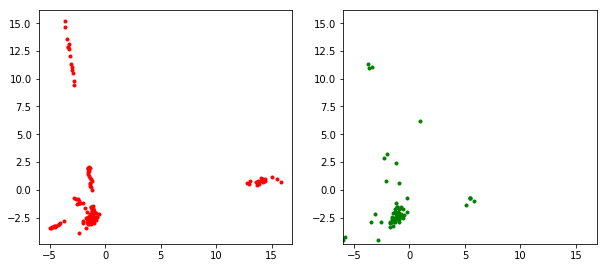

7001 [D loss: 0.511497, acc.: 78.03%] [G loss: 2.459713]
7002 [D loss: 0.485918, acc.: 78.03%] [G loss: 3.049857]
7003 [D loss: 0.561252, acc.: 76.14%] [G loss: 3.128882]
7004 [D loss: 0.461067, acc.: 79.17%] [G loss: 3.022438]
7005 [D loss: 0.582033, acc.: 73.48%] [G loss: 2.553853]
7006 [D loss: 0.530322, acc.: 78.03%] [G loss: 2.737304]
7007 [D loss: 0.495559, acc.: 75.38%] [G loss: 2.477069]
7008 [D loss: 0.583148, acc.: 76.52%] [G loss: 2.794010]
7009 [D loss: 0.528092, acc.: 75.00%] [G loss: 2.372184]
7010 [D loss: 0.517256, acc.: 73.86%] [G loss: 2.646279]
7011 [D loss: 0.511954, acc.: 76.52%] [G loss: 3.018943]
7012 [D loss: 0.509324, acc.: 76.14%] [G loss: 2.686142]
7013 [D loss: 0.524797, acc.: 75.00%] [G loss: 2.963663]
7014 [D loss: 0.501059, acc.: 76.14%] [G loss: 2.740103]
7015 [D loss: 0.553501, acc.: 74.62%] [G loss: 2.934498]
7016 [D loss: 0.537098, acc.: 74.24%] [G loss: 3.116153]
7017 [D loss: 0.555226, acc.: 72.73%] [G loss: 2.169551]
7018 [D loss: 0.505974, acc.: 7

7022 [D loss: 0.484658, acc.: 76.89%] [G loss: 2.484631]
7023 [D loss: 0.553690, acc.: 71.97%] [G loss: 2.791913]
7024 [D loss: 0.484680, acc.: 79.17%] [G loss: 2.418078]
7025 [D loss: 0.448893, acc.: 79.55%] [G loss: 2.540848]
7026 [D loss: 0.520773, acc.: 73.11%] [G loss: 2.575484]
7027 [D loss: 0.540223, acc.: 73.86%] [G loss: 3.010730]
7028 [D loss: 0.553762, acc.: 78.03%] [G loss: 2.309469]
7029 [D loss: 0.621773, acc.: 67.42%] [G loss: 2.144611]
7030 [D loss: 0.518396, acc.: 74.62%] [G loss: 2.128388]
7031 [D loss: 0.491051, acc.: 77.65%] [G loss: 2.824343]
7032 [D loss: 0.467637, acc.: 78.41%] [G loss: 2.614882]
7033 [D loss: 0.468129, acc.: 77.65%] [G loss: 2.678902]
7034 [D loss: 0.545472, acc.: 73.86%] [G loss: 2.450371]
7035 [D loss: 0.530090, acc.: 74.24%] [G loss: 2.507962]
7036 [D loss: 0.494534, acc.: 77.27%] [G loss: 2.500239]
7037 [D loss: 0.452646, acc.: 81.06%] [G loss: 2.869397]
7038 [D loss: 0.494288, acc.: 75.00%] [G loss: 2.827772]
7039 [D loss: 0.494614, acc.: 7

7044 [D loss: 0.522369, acc.: 75.38%] [G loss: 2.348816]
7045 [D loss: 0.556700, acc.: 71.97%] [G loss: 2.686321]
7046 [D loss: 0.496340, acc.: 75.00%] [G loss: 2.613648]
7047 [D loss: 0.533138, acc.: 75.38%] [G loss: 2.537929]
7048 [D loss: 0.497741, acc.: 78.03%] [G loss: 1.870328]
7049 [D loss: 0.531886, acc.: 76.52%] [G loss: 3.090421]
7050 [D loss: 0.492906, acc.: 76.89%] [G loss: 2.848099]
7051 [D loss: 0.588084, acc.: 76.14%] [G loss: 2.654911]
7052 [D loss: 0.509694, acc.: 76.89%] [G loss: 2.320533]
7053 [D loss: 0.505477, acc.: 74.24%] [G loss: 2.669909]
7054 [D loss: 0.541072, acc.: 72.35%] [G loss: 2.766695]
7055 [D loss: 0.491286, acc.: 76.14%] [G loss: 2.409374]
7056 [D loss: 0.553976, acc.: 74.24%] [G loss: 3.173907]
7057 [D loss: 0.485052, acc.: 76.52%] [G loss: 3.409993]
7058 [D loss: 0.451800, acc.: 78.79%] [G loss: 2.633259]
7059 [D loss: 0.452032, acc.: 78.79%] [G loss: 2.951099]
7060 [D loss: 0.549792, acc.: 73.48%] [G loss: 2.746990]
7061 [D loss: 0.461987, acc.: 8

7066 [D loss: 0.540420, acc.: 78.79%] [G loss: 2.153337]
7067 [D loss: 0.568152, acc.: 73.48%] [G loss: 2.076828]
7068 [D loss: 0.543800, acc.: 74.62%] [G loss: 2.271927]
7069 [D loss: 0.492336, acc.: 76.14%] [G loss: 2.631735]
7070 [D loss: 0.449615, acc.: 82.95%] [G loss: 2.838034]
7071 [D loss: 0.490614, acc.: 78.03%] [G loss: 2.747103]
7072 [D loss: 0.579248, acc.: 77.65%] [G loss: 2.402349]
7073 [D loss: 0.477266, acc.: 79.17%] [G loss: 2.696968]
7074 [D loss: 0.489315, acc.: 76.89%] [G loss: 2.821851]
7075 [D loss: 0.560431, acc.: 71.97%] [G loss: 2.125864]
7076 [D loss: 0.522116, acc.: 75.38%] [G loss: 2.730711]
7077 [D loss: 0.539549, acc.: 73.86%] [G loss: 2.747294]
7078 [D loss: 0.471168, acc.: 78.79%] [G loss: 2.965186]
7079 [D loss: 0.555915, acc.: 72.35%] [G loss: 2.606700]
7080 [D loss: 0.492397, acc.: 79.17%] [G loss: 2.661451]
7081 [D loss: 0.539582, acc.: 72.35%] [G loss: 2.708848]
7082 [D loss: 0.576346, acc.: 71.59%] [G loss: 2.519786]
7083 [D loss: 0.594640, acc.: 7

7088 [D loss: 0.507166, acc.: 75.76%] [G loss: 2.632108]
7089 [D loss: 0.550498, acc.: 73.86%] [G loss: 3.054168]
7090 [D loss: 0.538910, acc.: 73.48%] [G loss: 2.683684]
7091 [D loss: 0.587290, acc.: 71.59%] [G loss: 2.356032]
7092 [D loss: 0.518397, acc.: 75.00%] [G loss: 2.617868]
7093 [D loss: 0.539484, acc.: 75.38%] [G loss: 2.232512]
7094 [D loss: 0.513288, acc.: 75.00%] [G loss: 2.206820]
7095 [D loss: 0.500415, acc.: 75.76%] [G loss: 2.778858]
7096 [D loss: 0.488574, acc.: 78.41%] [G loss: 2.450329]
7097 [D loss: 0.452779, acc.: 79.55%] [G loss: 3.044739]
7098 [D loss: 0.484590, acc.: 78.03%] [G loss: 2.516790]
7099 [D loss: 0.511236, acc.: 77.65%] [G loss: 2.402631]
7100 [D loss: 0.525000, acc.: 76.89%] [G loss: 3.593020]
7101 [D loss: 0.453492, acc.: 78.79%] [G loss: 3.044253]
7102 [D loss: 0.488922, acc.: 78.79%] [G loss: 3.015865]
7103 [D loss: 0.487436, acc.: 78.03%] [G loss: 2.793876]
7104 [D loss: 0.531970, acc.: 73.48%] [G loss: 3.082744]
7105 [D loss: 0.542319, acc.: 7

7110 [D loss: 0.525218, acc.: 75.00%] [G loss: 2.202532]
7111 [D loss: 0.472406, acc.: 80.68%] [G loss: 2.658541]
7112 [D loss: 0.550896, acc.: 70.08%] [G loss: 3.102363]
7113 [D loss: 0.522438, acc.: 72.35%] [G loss: 2.340567]
7114 [D loss: 0.497717, acc.: 77.27%] [G loss: 2.682592]
7115 [D loss: 0.546383, acc.: 74.24%] [G loss: 2.613552]
7116 [D loss: 0.540536, acc.: 74.62%] [G loss: 2.449740]
7117 [D loss: 0.511271, acc.: 75.38%] [G loss: 2.789408]
7118 [D loss: 0.466485, acc.: 79.55%] [G loss: 3.059488]
7119 [D loss: 0.549690, acc.: 71.97%] [G loss: 2.521439]
7120 [D loss: 0.535073, acc.: 75.76%] [G loss: 2.834096]
7121 [D loss: 0.535487, acc.: 72.35%] [G loss: 2.702557]
7122 [D loss: 0.588500, acc.: 69.70%] [G loss: 2.157928]
7123 [D loss: 0.547789, acc.: 72.73%] [G loss: 2.062876]
7124 [D loss: 0.529730, acc.: 73.48%] [G loss: 1.866637]
7125 [D loss: 0.522620, acc.: 75.00%] [G loss: 2.212088]
7126 [D loss: 0.481491, acc.: 78.03%] [G loss: 2.592546]
7127 [D loss: 0.482912, acc.: 7

7132 [D loss: 0.537471, acc.: 75.00%] [G loss: 2.936113]
7133 [D loss: 0.558667, acc.: 74.24%] [G loss: 2.626229]
7134 [D loss: 0.561570, acc.: 73.11%] [G loss: 3.322118]
7135 [D loss: 0.522284, acc.: 75.00%] [G loss: 3.218307]
7136 [D loss: 0.508426, acc.: 76.14%] [G loss: 2.781746]
7137 [D loss: 0.542285, acc.: 73.48%] [G loss: 2.628084]
7138 [D loss: 0.513924, acc.: 78.03%] [G loss: 2.438490]
7139 [D loss: 0.509655, acc.: 76.14%] [G loss: 2.438951]
7140 [D loss: 0.568777, acc.: 74.62%] [G loss: 2.496719]
7141 [D loss: 0.608243, acc.: 68.18%] [G loss: 2.654335]
7142 [D loss: 0.549666, acc.: 71.97%] [G loss: 2.616044]
7143 [D loss: 0.473266, acc.: 79.17%] [G loss: 2.795521]
7144 [D loss: 0.480028, acc.: 78.03%] [G loss: 3.050090]
7145 [D loss: 0.478449, acc.: 78.03%] [G loss: 3.501523]
7146 [D loss: 0.575108, acc.: 78.03%] [G loss: 2.899669]
7147 [D loss: 0.586949, acc.: 72.35%] [G loss: 2.706944]
7148 [D loss: 0.546377, acc.: 76.14%] [G loss: 2.736886]
7149 [D loss: 0.571324, acc.: 7

7154 [D loss: 0.578392, acc.: 71.59%] [G loss: 2.045099]
7155 [D loss: 0.501531, acc.: 77.65%] [G loss: 2.441517]
7156 [D loss: 0.539663, acc.: 72.73%] [G loss: 2.420232]
7157 [D loss: 0.478758, acc.: 78.79%] [G loss: 2.779527]
7158 [D loss: 0.542490, acc.: 74.62%] [G loss: 2.476460]
7159 [D loss: 0.518299, acc.: 72.73%] [G loss: 2.631122]
7160 [D loss: 0.553125, acc.: 73.86%] [G loss: 2.746326]
7161 [D loss: 0.499259, acc.: 76.14%] [G loss: 2.715760]
7162 [D loss: 0.555847, acc.: 71.59%] [G loss: 2.039454]
7163 [D loss: 0.539735, acc.: 73.86%] [G loss: 2.806026]
7164 [D loss: 0.551564, acc.: 75.00%] [G loss: 1.919189]
7165 [D loss: 0.520390, acc.: 73.11%] [G loss: 2.169169]
7166 [D loss: 0.495094, acc.: 80.30%] [G loss: 2.174946]
7167 [D loss: 0.481329, acc.: 76.52%] [G loss: 2.700503]
7168 [D loss: 0.528913, acc.: 75.38%] [G loss: 2.580261]
7169 [D loss: 0.503426, acc.: 75.38%] [G loss: 2.500115]
7170 [D loss: 0.516652, acc.: 75.76%] [G loss: 2.960218]
7171 [D loss: 0.502713, acc.: 7

7176 [D loss: 0.523584, acc.: 74.62%] [G loss: 2.492184]
7177 [D loss: 0.539780, acc.: 74.62%] [G loss: 2.177203]
7178 [D loss: 0.559559, acc.: 73.11%] [G loss: 2.332648]
7179 [D loss: 0.532986, acc.: 70.83%] [G loss: 2.496691]
7180 [D loss: 0.524908, acc.: 76.14%] [G loss: 1.977926]
7181 [D loss: 0.561279, acc.: 71.21%] [G loss: 2.807866]
7182 [D loss: 0.474948, acc.: 76.14%] [G loss: 2.707533]
7183 [D loss: 0.524523, acc.: 78.03%] [G loss: 2.828908]
7184 [D loss: 0.492116, acc.: 76.14%] [G loss: 2.813215]
7185 [D loss: 0.571307, acc.: 73.11%] [G loss: 2.335650]
7186 [D loss: 0.552879, acc.: 74.62%] [G loss: 2.305195]
7187 [D loss: 0.455730, acc.: 79.55%] [G loss: 2.118213]
7188 [D loss: 0.495807, acc.: 76.14%] [G loss: 2.519226]
7189 [D loss: 0.524398, acc.: 75.00%] [G loss: 2.406981]
7190 [D loss: 0.480545, acc.: 79.92%] [G loss: 2.641970]
7191 [D loss: 0.510488, acc.: 77.65%] [G loss: 2.784456]
7192 [D loss: 0.423091, acc.: 82.58%] [G loss: 2.718022]
7193 [D loss: 0.517913, acc.: 7

7198 [D loss: 0.593590, acc.: 71.59%] [G loss: 2.479951]
7199 [D loss: 0.511947, acc.: 76.89%] [G loss: 2.437340]
7200 [D loss: 0.493090, acc.: 76.89%] [G loss: 2.641045]
7201 [D loss: 0.522375, acc.: 75.00%] [G loss: 2.746424]
7202 [D loss: 0.602848, acc.: 71.21%] [G loss: 2.358562]
7203 [D loss: 0.482955, acc.: 76.89%] [G loss: 2.348194]
7204 [D loss: 0.559881, acc.: 75.76%] [G loss: 2.243032]
7205 [D loss: 0.492566, acc.: 76.89%] [G loss: 2.355493]
7206 [D loss: 0.548889, acc.: 70.83%] [G loss: 2.454036]
7207 [D loss: 0.566514, acc.: 75.76%] [G loss: 2.265920]
7208 [D loss: 0.481582, acc.: 76.52%] [G loss: 2.313269]
7209 [D loss: 0.498420, acc.: 75.76%] [G loss: 2.516819]
7210 [D loss: 0.545381, acc.: 76.89%] [G loss: 2.449549]
7211 [D loss: 0.556919, acc.: 74.62%] [G loss: 2.476532]
7212 [D loss: 0.629109, acc.: 71.97%] [G loss: 2.453939]
7213 [D loss: 0.511978, acc.: 73.48%] [G loss: 2.279937]
7214 [D loss: 0.524951, acc.: 74.62%] [G loss: 2.113925]
7215 [D loss: 0.502868, acc.: 8

7219 [D loss: 0.527713, acc.: 74.62%] [G loss: 2.449134]
7220 [D loss: 0.533845, acc.: 76.52%] [G loss: 2.716089]
7221 [D loss: 0.634203, acc.: 70.08%] [G loss: 2.074927]
7222 [D loss: 0.540142, acc.: 73.11%] [G loss: 2.358710]
7223 [D loss: 0.498253, acc.: 78.41%] [G loss: 2.503034]
7224 [D loss: 0.550051, acc.: 72.35%] [G loss: 2.478433]
7225 [D loss: 0.563388, acc.: 72.35%] [G loss: 2.440092]
7226 [D loss: 0.556953, acc.: 72.73%] [G loss: 2.445688]
7227 [D loss: 0.508120, acc.: 75.00%] [G loss: 2.381462]
7228 [D loss: 0.486537, acc.: 80.68%] [G loss: 2.754990]
7229 [D loss: 0.525595, acc.: 77.27%] [G loss: 2.710415]
7230 [D loss: 0.497197, acc.: 76.52%] [G loss: 2.700161]
7231 [D loss: 0.534988, acc.: 74.62%] [G loss: 2.759025]
7232 [D loss: 0.540152, acc.: 81.82%] [G loss: 2.524999]
7233 [D loss: 0.524483, acc.: 74.62%] [G loss: 1.954083]
7234 [D loss: 0.508343, acc.: 76.52%] [G loss: 2.769868]
7235 [D loss: 0.516616, acc.: 73.86%] [G loss: 2.255502]
7236 [D loss: 0.568522, acc.: 7

7241 [D loss: 0.542335, acc.: 75.38%] [G loss: 2.234910]
7242 [D loss: 0.554321, acc.: 72.35%] [G loss: 1.896674]
7243 [D loss: 0.550197, acc.: 72.73%] [G loss: 2.240837]
7244 [D loss: 0.493431, acc.: 74.62%] [G loss: 1.863232]
7245 [D loss: 0.534647, acc.: 74.62%] [G loss: 2.138678]
7246 [D loss: 0.504654, acc.: 77.27%] [G loss: 2.716815]
7247 [D loss: 0.537992, acc.: 71.21%] [G loss: 2.473001]
7248 [D loss: 0.484884, acc.: 78.41%] [G loss: 2.136816]
7249 [D loss: 0.532080, acc.: 73.86%] [G loss: 2.499650]
7250 [D loss: 0.514911, acc.: 76.89%] [G loss: 2.121259]
7251 [D loss: 0.515149, acc.: 78.03%] [G loss: 2.515650]
7252 [D loss: 0.539903, acc.: 70.83%] [G loss: 2.400582]
7253 [D loss: 0.490025, acc.: 77.65%] [G loss: 2.364540]
7254 [D loss: 0.469963, acc.: 77.27%] [G loss: 2.323838]
7255 [D loss: 0.495691, acc.: 76.52%] [G loss: 2.712075]
7256 [D loss: 0.503241, acc.: 79.55%] [G loss: 2.850094]
7257 [D loss: 0.504261, acc.: 79.17%] [G loss: 2.977865]
7258 [D loss: 0.543905, acc.: 7

7263 [D loss: 0.562622, acc.: 74.24%] [G loss: 2.504490]
7264 [D loss: 0.516542, acc.: 76.52%] [G loss: 2.366350]
7265 [D loss: 0.500248, acc.: 75.76%] [G loss: 2.636278]
7266 [D loss: 0.467849, acc.: 79.55%] [G loss: 2.646299]
7267 [D loss: 0.564397, acc.: 75.76%] [G loss: 1.934092]
7268 [D loss: 0.578988, acc.: 70.83%] [G loss: 2.255929]
7269 [D loss: 0.550591, acc.: 75.38%] [G loss: 2.318734]
7270 [D loss: 0.507556, acc.: 79.55%] [G loss: 2.559758]
7271 [D loss: 0.505933, acc.: 79.17%] [G loss: 2.591266]
7272 [D loss: 0.458609, acc.: 78.41%] [G loss: 2.896575]
7273 [D loss: 0.541252, acc.: 75.38%] [G loss: 3.033345]
7274 [D loss: 0.536996, acc.: 76.14%] [G loss: 2.542098]
7275 [D loss: 0.543218, acc.: 75.00%] [G loss: 2.750258]
7276 [D loss: 0.483605, acc.: 77.65%] [G loss: 2.884179]
7277 [D loss: 0.559307, acc.: 74.62%] [G loss: 2.776114]
7278 [D loss: 0.503573, acc.: 76.14%] [G loss: 2.705280]
7279 [D loss: 0.537963, acc.: 75.38%] [G loss: 2.695004]
7280 [D loss: 0.615548, acc.: 7

7285 [D loss: 0.568649, acc.: 71.59%] [G loss: 2.642336]
7286 [D loss: 0.506867, acc.: 74.62%] [G loss: 2.039617]
7287 [D loss: 0.501307, acc.: 78.03%] [G loss: 2.431951]
7288 [D loss: 0.590709, acc.: 70.45%] [G loss: 2.160672]
7289 [D loss: 0.507795, acc.: 75.38%] [G loss: 2.257224]
7290 [D loss: 0.490526, acc.: 76.14%] [G loss: 2.793999]
7291 [D loss: 0.499353, acc.: 80.30%] [G loss: 2.326917]
7292 [D loss: 0.590934, acc.: 72.73%] [G loss: 2.537649]
7293 [D loss: 0.472072, acc.: 78.41%] [G loss: 2.375150]
7294 [D loss: 0.555302, acc.: 75.00%] [G loss: 2.327473]
7295 [D loss: 0.524826, acc.: 73.48%] [G loss: 2.677532]
7296 [D loss: 0.532925, acc.: 74.24%] [G loss: 2.540375]
7297 [D loss: 0.505562, acc.: 75.38%] [G loss: 2.963849]
7298 [D loss: 0.494268, acc.: 78.03%] [G loss: 2.396950]
7299 [D loss: 0.528422, acc.: 76.52%] [G loss: 2.065492]
7300 [D loss: 0.497091, acc.: 78.03%] [G loss: 2.802022]
7301 [D loss: 0.545168, acc.: 74.62%] [G loss: 2.788805]
7302 [D loss: 0.516302, acc.: 7

7307 [D loss: 0.502442, acc.: 78.03%] [G loss: 2.756002]
7308 [D loss: 0.543529, acc.: 71.21%] [G loss: 2.799315]
7309 [D loss: 0.488478, acc.: 76.89%] [G loss: 2.670844]
7310 [D loss: 0.543267, acc.: 73.48%] [G loss: 2.588365]
7311 [D loss: 0.485361, acc.: 80.68%] [G loss: 2.099820]
7312 [D loss: 0.518888, acc.: 75.00%] [G loss: 2.205721]
7313 [D loss: 0.472010, acc.: 78.41%] [G loss: 2.972737]
7314 [D loss: 0.607243, acc.: 72.35%] [G loss: 2.239714]
7315 [D loss: 0.561849, acc.: 75.76%] [G loss: 2.742875]
7316 [D loss: 0.550721, acc.: 76.14%] [G loss: 2.813237]
7317 [D loss: 0.482161, acc.: 79.17%] [G loss: 2.376834]
7318 [D loss: 0.498147, acc.: 77.65%] [G loss: 2.633621]
7319 [D loss: 0.479694, acc.: 77.65%] [G loss: 2.726353]
7320 [D loss: 0.501952, acc.: 79.17%] [G loss: 2.660282]
7321 [D loss: 0.524105, acc.: 77.27%] [G loss: 3.078208]
7322 [D loss: 0.531466, acc.: 73.11%] [G loss: 2.631891]
7323 [D loss: 0.519027, acc.: 73.86%] [G loss: 2.674639]
7324 [D loss: 0.490517, acc.: 7

7329 [D loss: 0.552971, acc.: 74.24%] [G loss: 2.570675]
7330 [D loss: 0.499392, acc.: 77.65%] [G loss: 2.732075]
7331 [D loss: 0.531048, acc.: 72.35%] [G loss: 2.405494]
7332 [D loss: 0.510372, acc.: 74.24%] [G loss: 2.769679]
7333 [D loss: 0.501665, acc.: 73.86%] [G loss: 2.692146]
7334 [D loss: 0.494696, acc.: 79.92%] [G loss: 2.740862]
7335 [D loss: 0.568544, acc.: 73.11%] [G loss: 2.352787]
7336 [D loss: 0.476505, acc.: 78.03%] [G loss: 2.391484]
7337 [D loss: 0.516541, acc.: 75.00%] [G loss: 2.789394]
7338 [D loss: 0.560480, acc.: 73.11%] [G loss: 2.596780]
7339 [D loss: 0.468394, acc.: 80.30%] [G loss: 2.150067]
7340 [D loss: 0.504729, acc.: 75.38%] [G loss: 2.771468]
7341 [D loss: 0.550609, acc.: 71.59%] [G loss: 2.360106]
7342 [D loss: 0.508029, acc.: 77.65%] [G loss: 2.208493]
7343 [D loss: 0.591791, acc.: 72.35%] [G loss: 2.467501]
7344 [D loss: 0.487212, acc.: 76.14%] [G loss: 2.336059]
7345 [D loss: 0.581965, acc.: 68.94%] [G loss: 2.216140]
7346 [D loss: 0.525973, acc.: 7

7350 [D loss: 0.503201, acc.: 75.76%] [G loss: 2.214019]
7351 [D loss: 0.480181, acc.: 77.27%] [G loss: 2.668427]
7352 [D loss: 0.529534, acc.: 73.11%] [G loss: 2.231487]
7353 [D loss: 0.485314, acc.: 76.52%] [G loss: 2.290071]
7354 [D loss: 0.490823, acc.: 77.27%] [G loss: 2.310934]
7355 [D loss: 0.498494, acc.: 76.89%] [G loss: 2.562810]
7356 [D loss: 0.580789, acc.: 72.35%] [G loss: 2.771941]
7357 [D loss: 0.523961, acc.: 75.38%] [G loss: 2.239646]
7358 [D loss: 0.518444, acc.: 75.00%] [G loss: 2.445325]
7359 [D loss: 0.560260, acc.: 70.83%] [G loss: 2.092239]
7360 [D loss: 0.595724, acc.: 70.83%] [G loss: 2.075267]
7361 [D loss: 0.488535, acc.: 76.14%] [G loss: 2.313640]
7362 [D loss: 0.577899, acc.: 73.11%] [G loss: 2.508181]
7363 [D loss: 0.531789, acc.: 77.27%] [G loss: 2.650198]
7364 [D loss: 0.490668, acc.: 78.79%] [G loss: 2.519078]
7365 [D loss: 0.546455, acc.: 75.38%] [G loss: 2.110189]
7366 [D loss: 0.522741, acc.: 72.35%] [G loss: 2.585635]
7367 [D loss: 0.520910, acc.: 7

7372 [D loss: 0.538527, acc.: 72.35%] [G loss: 2.859287]
7373 [D loss: 0.524246, acc.: 76.14%] [G loss: 2.431385]
7374 [D loss: 0.553903, acc.: 72.73%] [G loss: 2.237395]
7375 [D loss: 0.442838, acc.: 81.06%] [G loss: 2.496821]
7376 [D loss: 0.540442, acc.: 75.00%] [G loss: 2.528658]
7377 [D loss: 0.543541, acc.: 73.48%] [G loss: 2.388952]
7378 [D loss: 0.500865, acc.: 75.76%] [G loss: 2.218582]
7379 [D loss: 0.584806, acc.: 73.86%] [G loss: 2.785679]
7380 [D loss: 0.463096, acc.: 82.95%] [G loss: 2.817291]
7381 [D loss: 0.512126, acc.: 78.41%] [G loss: 2.627834]
7382 [D loss: 0.571481, acc.: 71.21%] [G loss: 2.694863]
7383 [D loss: 0.484208, acc.: 76.89%] [G loss: 2.883999]
7384 [D loss: 0.491833, acc.: 74.62%] [G loss: 2.267115]
7385 [D loss: 0.530789, acc.: 77.65%] [G loss: 2.464028]
7386 [D loss: 0.529123, acc.: 73.86%] [G loss: 2.854398]
7387 [D loss: 0.492048, acc.: 79.55%] [G loss: 2.425167]
7388 [D loss: 0.523883, acc.: 76.89%] [G loss: 2.642667]
7389 [D loss: 0.538383, acc.: 7

7394 [D loss: 0.555159, acc.: 73.86%] [G loss: 2.395119]
7395 [D loss: 0.528981, acc.: 73.86%] [G loss: 2.167888]
7396 [D loss: 0.510316, acc.: 77.27%] [G loss: 2.470298]
7397 [D loss: 0.516521, acc.: 73.86%] [G loss: 2.059448]
7398 [D loss: 0.496371, acc.: 74.24%] [G loss: 2.564228]
7399 [D loss: 0.511653, acc.: 76.52%] [G loss: 2.641807]
7400 [D loss: 0.484148, acc.: 78.79%] [G loss: 2.722460]
7401 [D loss: 0.553334, acc.: 76.14%] [G loss: 2.358280]
7402 [D loss: 0.504812, acc.: 77.27%] [G loss: 2.569968]
7403 [D loss: 0.530232, acc.: 75.00%] [G loss: 2.383050]
7404 [D loss: 0.585196, acc.: 71.59%] [G loss: 2.163956]
7405 [D loss: 0.517748, acc.: 73.11%] [G loss: 2.233405]
7406 [D loss: 0.545625, acc.: 73.48%] [G loss: 2.736899]
7407 [D loss: 0.524557, acc.: 77.27%] [G loss: 2.368346]
7408 [D loss: 0.583579, acc.: 71.97%] [G loss: 2.289181]
7409 [D loss: 0.508670, acc.: 75.38%] [G loss: 2.765573]
7410 [D loss: 0.482414, acc.: 77.27%] [G loss: 2.518206]
7411 [D loss: 0.505073, acc.: 7

7415 [D loss: 0.499104, acc.: 75.76%] [G loss: 2.809186]
7416 [D loss: 0.538953, acc.: 75.76%] [G loss: 2.894549]
7417 [D loss: 0.511252, acc.: 77.65%] [G loss: 2.541284]
7418 [D loss: 0.519041, acc.: 78.03%] [G loss: 2.668974]
7419 [D loss: 0.548473, acc.: 75.76%] [G loss: 2.594344]
7420 [D loss: 0.571383, acc.: 75.76%] [G loss: 2.938762]
7421 [D loss: 0.548832, acc.: 72.35%] [G loss: 2.176140]
7422 [D loss: 0.528882, acc.: 71.97%] [G loss: 2.175156]
7423 [D loss: 0.577525, acc.: 71.59%] [G loss: 1.809813]
7424 [D loss: 0.514399, acc.: 73.86%] [G loss: 2.568141]
7425 [D loss: 0.479886, acc.: 75.38%] [G loss: 2.496837]
7426 [D loss: 0.532659, acc.: 75.38%] [G loss: 2.396549]
7427 [D loss: 0.502347, acc.: 77.65%] [G loss: 2.623806]
7428 [D loss: 0.578829, acc.: 71.59%] [G loss: 2.236475]
7429 [D loss: 0.543403, acc.: 71.59%] [G loss: 2.517667]
7430 [D loss: 0.558042, acc.: 77.27%] [G loss: 2.748020]
7431 [D loss: 0.517675, acc.: 77.65%] [G loss: 2.586973]
7432 [D loss: 0.496022, acc.: 7

7437 [D loss: 0.553830, acc.: 72.73%] [G loss: 2.485394]
7438 [D loss: 0.523919, acc.: 74.24%] [G loss: 2.600971]
7439 [D loss: 0.567104, acc.: 71.59%] [G loss: 1.862088]
7440 [D loss: 0.533943, acc.: 74.62%] [G loss: 2.608717]
7441 [D loss: 0.476766, acc.: 76.89%] [G loss: 1.847113]
7442 [D loss: 0.552251, acc.: 74.62%] [G loss: 2.537341]
7443 [D loss: 0.504751, acc.: 74.24%] [G loss: 2.165881]
7444 [D loss: 0.509722, acc.: 75.76%] [G loss: 2.441958]
7445 [D loss: 0.573905, acc.: 73.48%] [G loss: 2.541155]
7446 [D loss: 0.603610, acc.: 70.83%] [G loss: 2.532773]
7447 [D loss: 0.498791, acc.: 76.52%] [G loss: 2.397010]
7448 [D loss: 0.527260, acc.: 73.11%] [G loss: 2.485547]
7449 [D loss: 0.495708, acc.: 78.41%] [G loss: 2.474687]
7450 [D loss: 0.536156, acc.: 71.97%] [G loss: 2.384255]
7451 [D loss: 0.559157, acc.: 74.24%] [G loss: 3.177682]
7452 [D loss: 0.505216, acc.: 75.38%] [G loss: 2.263586]
7453 [D loss: 0.565537, acc.: 73.11%] [G loss: 2.042586]
7454 [D loss: 0.517080, acc.: 7

7459 [D loss: 0.466833, acc.: 78.41%] [G loss: 2.485579]
7460 [D loss: 0.548199, acc.: 75.00%] [G loss: 2.518768]
7461 [D loss: 0.532436, acc.: 75.76%] [G loss: 2.632400]
7462 [D loss: 0.515096, acc.: 74.24%] [G loss: 2.712828]
7463 [D loss: 0.601654, acc.: 72.73%] [G loss: 2.648077]
7464 [D loss: 0.559211, acc.: 74.24%] [G loss: 2.595567]
7465 [D loss: 0.601682, acc.: 72.73%] [G loss: 2.274410]
7466 [D loss: 0.530971, acc.: 71.97%] [G loss: 2.248860]
7467 [D loss: 0.512601, acc.: 76.52%] [G loss: 2.117576]
7468 [D loss: 0.560411, acc.: 74.24%] [G loss: 2.546468]
7469 [D loss: 0.527127, acc.: 75.76%] [G loss: 2.376608]
7470 [D loss: 0.513791, acc.: 76.52%] [G loss: 2.363131]
7471 [D loss: 0.521260, acc.: 77.27%] [G loss: 2.391153]
7472 [D loss: 0.463182, acc.: 78.79%] [G loss: 2.713999]
7473 [D loss: 0.532549, acc.: 72.35%] [G loss: 2.428587]
7474 [D loss: 0.523109, acc.: 76.14%] [G loss: 2.567949]
7475 [D loss: 0.601426, acc.: 74.24%] [G loss: 2.510335]
7476 [D loss: 0.525095, acc.: 7

7481 [D loss: 0.536991, acc.: 73.48%] [G loss: 2.311286]
7482 [D loss: 0.457965, acc.: 78.79%] [G loss: 2.413999]
7483 [D loss: 0.539295, acc.: 73.11%] [G loss: 2.494457]
7484 [D loss: 0.496664, acc.: 78.79%] [G loss: 2.390742]
7485 [D loss: 0.504238, acc.: 78.03%] [G loss: 2.408791]
7486 [D loss: 0.540693, acc.: 76.89%] [G loss: 2.458919]
7487 [D loss: 0.527919, acc.: 75.38%] [G loss: 2.588420]
7488 [D loss: 0.488139, acc.: 75.00%] [G loss: 2.445506]
7489 [D loss: 0.592360, acc.: 71.59%] [G loss: 2.326135]
7490 [D loss: 0.534094, acc.: 74.24%] [G loss: 2.620584]
7491 [D loss: 0.545738, acc.: 73.11%] [G loss: 2.238692]
7492 [D loss: 0.571136, acc.: 73.48%] [G loss: 2.099647]
7493 [D loss: 0.489343, acc.: 77.65%] [G loss: 2.830032]
7494 [D loss: 0.515995, acc.: 73.86%] [G loss: 2.294053]
7495 [D loss: 0.463212, acc.: 78.03%] [G loss: 2.750562]
7496 [D loss: 0.502834, acc.: 76.14%] [G loss: 2.771056]
7497 [D loss: 0.494329, acc.: 79.92%] [G loss: 2.608583]
7498 [D loss: 0.530907, acc.: 7

7503 [D loss: 0.515591, acc.: 73.48%] [G loss: 2.730833]
7504 [D loss: 0.524675, acc.: 75.38%] [G loss: 3.051272]
7505 [D loss: 0.515908, acc.: 74.24%] [G loss: 2.695557]
7506 [D loss: 0.485962, acc.: 75.76%] [G loss: 2.608151]
7507 [D loss: 0.588860, acc.: 70.45%] [G loss: 2.301014]
7508 [D loss: 0.542434, acc.: 72.35%] [G loss: 2.185875]
7509 [D loss: 0.550315, acc.: 71.59%] [G loss: 2.065940]
7510 [D loss: 0.475711, acc.: 78.03%] [G loss: 2.891223]
7511 [D loss: 0.498725, acc.: 76.14%] [G loss: 2.414275]
7512 [D loss: 0.469913, acc.: 79.92%] [G loss: 3.056094]
7513 [D loss: 0.531577, acc.: 76.89%] [G loss: 3.230692]
7514 [D loss: 0.517827, acc.: 77.27%] [G loss: 3.126290]
7515 [D loss: 0.539804, acc.: 75.76%] [G loss: 2.735561]
7516 [D loss: 0.526014, acc.: 73.86%] [G loss: 2.713473]
7517 [D loss: 0.524596, acc.: 81.44%] [G loss: 2.878137]
7518 [D loss: 0.613991, acc.: 73.48%] [G loss: 2.066190]
7519 [D loss: 0.547233, acc.: 76.89%] [G loss: 2.575104]
7520 [D loss: 0.534458, acc.: 7

7524 [D loss: 0.609036, acc.: 76.14%] [G loss: 2.382600]
7525 [D loss: 0.516190, acc.: 73.11%] [G loss: 2.449900]
7526 [D loss: 0.519207, acc.: 73.48%] [G loss: 2.101320]
7527 [D loss: 0.507007, acc.: 74.24%] [G loss: 2.309327]
7528 [D loss: 0.614491, acc.: 70.45%] [G loss: 2.142991]
7529 [D loss: 0.538762, acc.: 73.11%] [G loss: 2.238718]
7530 [D loss: 0.549821, acc.: 72.73%] [G loss: 2.379931]
7531 [D loss: 0.534707, acc.: 74.24%] [G loss: 2.140968]
7532 [D loss: 0.600724, acc.: 72.35%] [G loss: 1.473821]
7533 [D loss: 0.523307, acc.: 75.00%] [G loss: 2.450717]
7534 [D loss: 0.505797, acc.: 73.48%] [G loss: 2.240234]
7535 [D loss: 0.534009, acc.: 76.52%] [G loss: 2.306952]
7536 [D loss: 0.515773, acc.: 76.14%] [G loss: 2.196937]
7537 [D loss: 0.509442, acc.: 75.76%] [G loss: 2.893424]
7538 [D loss: 0.521174, acc.: 76.52%] [G loss: 2.496812]
7539 [D loss: 0.511271, acc.: 77.27%] [G loss: 2.456140]
7540 [D loss: 0.523423, acc.: 73.11%] [G loss: 3.131178]
7541 [D loss: 0.497682, acc.: 7

7546 [D loss: 0.515683, acc.: 74.62%] [G loss: 2.507592]
7547 [D loss: 0.519488, acc.: 77.27%] [G loss: 2.551879]
7548 [D loss: 0.537744, acc.: 75.00%] [G loss: 2.038991]
7549 [D loss: 0.541896, acc.: 74.24%] [G loss: 2.242450]
7550 [D loss: 0.465077, acc.: 77.65%] [G loss: 2.541617]
7551 [D loss: 0.588501, acc.: 68.94%] [G loss: 2.337572]
7552 [D loss: 0.517523, acc.: 78.41%] [G loss: 2.757028]
7553 [D loss: 0.559151, acc.: 73.11%] [G loss: 2.384599]
7554 [D loss: 0.535104, acc.: 75.00%] [G loss: 2.165457]
7555 [D loss: 0.480529, acc.: 76.89%] [G loss: 2.894522]
7556 [D loss: 0.501058, acc.: 76.89%] [G loss: 2.878584]
7557 [D loss: 0.502310, acc.: 76.14%] [G loss: 3.388094]
7558 [D loss: 0.550117, acc.: 74.24%] [G loss: 2.661526]
7559 [D loss: 0.612819, acc.: 70.83%] [G loss: 2.777704]
7560 [D loss: 0.476900, acc.: 79.55%] [G loss: 2.617009]
7561 [D loss: 0.545094, acc.: 74.24%] [G loss: 2.852047]
7562 [D loss: 0.526997, acc.: 77.65%] [G loss: 2.564822]
7563 [D loss: 0.571153, acc.: 7

7568 [D loss: 0.551734, acc.: 71.97%] [G loss: 2.898267]
7569 [D loss: 0.514089, acc.: 77.27%] [G loss: 2.691697]
7570 [D loss: 0.559689, acc.: 71.97%] [G loss: 2.486096]
7571 [D loss: 0.494567, acc.: 76.89%] [G loss: 2.186910]
7572 [D loss: 0.554884, acc.: 70.45%] [G loss: 1.994413]
7573 [D loss: 0.452646, acc.: 81.44%] [G loss: 2.282872]
7574 [D loss: 0.466658, acc.: 78.79%] [G loss: 2.625955]
7575 [D loss: 0.509860, acc.: 78.03%] [G loss: 2.161060]
7576 [D loss: 0.560067, acc.: 73.48%] [G loss: 2.059845]
7577 [D loss: 0.524166, acc.: 73.86%] [G loss: 2.173247]
7578 [D loss: 0.538553, acc.: 74.24%] [G loss: 2.282095]
7579 [D loss: 0.517932, acc.: 74.62%] [G loss: 2.243209]
7580 [D loss: 0.558605, acc.: 73.11%] [G loss: 2.258503]
7581 [D loss: 0.568588, acc.: 71.59%] [G loss: 2.245415]
7582 [D loss: 0.519601, acc.: 77.27%] [G loss: 2.509866]
7583 [D loss: 0.515709, acc.: 75.38%] [G loss: 2.612129]
7584 [D loss: 0.528987, acc.: 73.11%] [G loss: 2.547561]
7585 [D loss: 0.582696, acc.: 7

7590 [D loss: 0.543638, acc.: 74.62%] [G loss: 1.909307]
7591 [D loss: 0.512474, acc.: 76.14%] [G loss: 2.053044]
7592 [D loss: 0.497410, acc.: 75.00%] [G loss: 2.452696]
7593 [D loss: 0.551855, acc.: 75.38%] [G loss: 2.591429]
7594 [D loss: 0.516609, acc.: 75.38%] [G loss: 2.260900]
7595 [D loss: 0.518448, acc.: 77.65%] [G loss: 2.492212]
7596 [D loss: 0.532418, acc.: 79.55%] [G loss: 2.382072]
7597 [D loss: 0.521104, acc.: 76.14%] [G loss: 2.884058]
7598 [D loss: 0.503748, acc.: 76.52%] [G loss: 2.669077]
7599 [D loss: 0.503760, acc.: 77.65%] [G loss: 2.511302]
7600 [D loss: 0.504283, acc.: 76.89%] [G loss: 2.550947]
7601 [D loss: 0.497214, acc.: 76.52%] [G loss: 2.356004]
7602 [D loss: 0.499251, acc.: 76.89%] [G loss: 2.471728]
7603 [D loss: 0.504280, acc.: 77.65%] [G loss: 2.198933]
7604 [D loss: 0.589617, acc.: 73.86%] [G loss: 3.143370]
7605 [D loss: 0.521425, acc.: 76.14%] [G loss: 2.781476]
7606 [D loss: 0.525300, acc.: 76.89%] [G loss: 2.196918]
7607 [D loss: 0.565093, acc.: 7

7612 [D loss: 0.546676, acc.: 74.24%] [G loss: 2.023401]
7613 [D loss: 0.503874, acc.: 79.17%] [G loss: 2.237442]
7614 [D loss: 0.562482, acc.: 73.48%] [G loss: 2.204647]
7615 [D loss: 0.455429, acc.: 79.55%] [G loss: 2.726002]
7616 [D loss: 0.568041, acc.: 73.86%] [G loss: 2.286703]
7617 [D loss: 0.544069, acc.: 73.86%] [G loss: 2.141210]
7618 [D loss: 0.500550, acc.: 74.62%] [G loss: 2.511602]
7619 [D loss: 0.585580, acc.: 70.83%] [G loss: 1.901463]
7620 [D loss: 0.547260, acc.: 73.11%] [G loss: 2.077589]
7621 [D loss: 0.553043, acc.: 73.11%] [G loss: 2.635804]
7622 [D loss: 0.578431, acc.: 73.11%] [G loss: 1.651644]
7623 [D loss: 0.554868, acc.: 73.86%] [G loss: 1.962325]
7624 [D loss: 0.517954, acc.: 76.89%] [G loss: 2.315078]
7625 [D loss: 0.513962, acc.: 77.27%] [G loss: 2.623136]
7626 [D loss: 0.585682, acc.: 71.21%] [G loss: 2.520758]
7627 [D loss: 0.564247, acc.: 75.76%] [G loss: 2.424634]
7628 [D loss: 0.473245, acc.: 79.17%] [G loss: 2.846033]
7629 [D loss: 0.507847, acc.: 7

7634 [D loss: 0.554477, acc.: 70.08%] [G loss: 2.828792]
7635 [D loss: 0.520842, acc.: 75.76%] [G loss: 2.653510]
7636 [D loss: 0.454637, acc.: 79.92%] [G loss: 2.456833]
7637 [D loss: 0.466609, acc.: 79.92%] [G loss: 2.382763]
7638 [D loss: 0.497709, acc.: 76.14%] [G loss: 2.642516]
7639 [D loss: 0.474971, acc.: 78.03%] [G loss: 2.605408]
7640 [D loss: 0.489795, acc.: 81.44%] [G loss: 2.935704]
7641 [D loss: 0.526372, acc.: 78.41%] [G loss: 3.087156]
7642 [D loss: 0.504950, acc.: 78.41%] [G loss: 2.325666]
7643 [D loss: 0.523112, acc.: 76.52%] [G loss: 3.243678]
7644 [D loss: 0.573887, acc.: 74.24%] [G loss: 2.811455]
7645 [D loss: 0.469033, acc.: 79.55%] [G loss: 2.566828]
7646 [D loss: 0.553650, acc.: 76.89%] [G loss: 2.236728]
7647 [D loss: 0.660022, acc.: 70.45%] [G loss: 2.254956]
7648 [D loss: 0.504654, acc.: 75.38%] [G loss: 2.450214]
7649 [D loss: 0.572025, acc.: 74.62%] [G loss: 1.926863]
7650 [D loss: 0.557276, acc.: 75.76%] [G loss: 2.310941]
7651 [D loss: 0.475678, acc.: 7

7656 [D loss: 0.524322, acc.: 75.76%] [G loss: 2.503798]
7657 [D loss: 0.506708, acc.: 75.76%] [G loss: 2.129871]
7658 [D loss: 0.549501, acc.: 70.83%] [G loss: 2.313423]
7659 [D loss: 0.468487, acc.: 79.55%] [G loss: 2.271396]
7660 [D loss: 0.556836, acc.: 78.79%] [G loss: 2.246180]
7661 [D loss: 0.545771, acc.: 71.59%] [G loss: 2.537014]
7662 [D loss: 0.567294, acc.: 72.35%] [G loss: 2.192553]
7663 [D loss: 0.509193, acc.: 77.65%] [G loss: 2.306457]
7664 [D loss: 0.533856, acc.: 75.00%] [G loss: 2.294650]
7665 [D loss: 0.598422, acc.: 71.59%] [G loss: 2.280706]
7666 [D loss: 0.474760, acc.: 78.41%] [G loss: 2.750362]
7667 [D loss: 0.545289, acc.: 75.38%] [G loss: 2.561061]
7668 [D loss: 0.531063, acc.: 77.65%] [G loss: 2.361109]
7669 [D loss: 0.494389, acc.: 76.89%] [G loss: 2.206366]
7670 [D loss: 0.549484, acc.: 75.76%] [G loss: 2.404356]
7671 [D loss: 0.512506, acc.: 76.52%] [G loss: 2.665461]
7672 [D loss: 0.528894, acc.: 74.24%] [G loss: 2.380974]
7673 [D loss: 0.522641, acc.: 7

7678 [D loss: 0.470346, acc.: 79.17%] [G loss: 2.597573]
7679 [D loss: 0.486098, acc.: 76.89%] [G loss: 1.969284]
7680 [D loss: 0.546972, acc.: 76.52%] [G loss: 3.152188]
7681 [D loss: 0.499968, acc.: 77.27%] [G loss: 2.674946]
7682 [D loss: 0.506923, acc.: 79.17%] [G loss: 2.668295]
7683 [D loss: 0.541178, acc.: 72.73%] [G loss: 2.681226]
7684 [D loss: 0.541392, acc.: 73.48%] [G loss: 2.468023]
7685 [D loss: 0.563644, acc.: 71.59%] [G loss: 2.225157]
7686 [D loss: 0.558983, acc.: 71.97%] [G loss: 1.652075]
7687 [D loss: 0.485980, acc.: 77.65%] [G loss: 2.627432]
7688 [D loss: 0.616201, acc.: 71.21%] [G loss: 2.554997]
7689 [D loss: 0.514103, acc.: 74.62%] [G loss: 2.356234]
7690 [D loss: 0.506678, acc.: 77.65%] [G loss: 2.197526]
7691 [D loss: 0.489479, acc.: 80.30%] [G loss: 2.848685]
7692 [D loss: 0.489399, acc.: 78.41%] [G loss: 2.254505]
7693 [D loss: 0.546118, acc.: 74.24%] [G loss: 2.831405]
7694 [D loss: 0.565534, acc.: 71.97%] [G loss: 2.288247]
7695 [D loss: 0.575209, acc.: 7

7700 [D loss: 0.486076, acc.: 78.03%] [G loss: 3.058513]
7701 [D loss: 0.555939, acc.: 72.35%] [G loss: 2.089455]
7702 [D loss: 0.504318, acc.: 79.17%] [G loss: 2.280553]
7703 [D loss: 0.518839, acc.: 74.62%] [G loss: 2.771986]
7704 [D loss: 0.489724, acc.: 78.41%] [G loss: 2.586269]
7705 [D loss: 0.520947, acc.: 72.35%] [G loss: 2.716387]
7706 [D loss: 0.536772, acc.: 76.89%] [G loss: 2.257745]
7707 [D loss: 0.550198, acc.: 72.35%] [G loss: 2.497277]
7708 [D loss: 0.496564, acc.: 74.62%] [G loss: 2.135613]
7709 [D loss: 0.504655, acc.: 76.89%] [G loss: 2.586591]
7710 [D loss: 0.500797, acc.: 73.86%] [G loss: 2.778970]
7711 [D loss: 0.570862, acc.: 74.24%] [G loss: 2.407949]
7712 [D loss: 0.597926, acc.: 76.52%] [G loss: 2.047371]
7713 [D loss: 0.513177, acc.: 75.76%] [G loss: 2.135005]
7714 [D loss: 0.539994, acc.: 73.11%] [G loss: 1.899872]
7715 [D loss: 0.503274, acc.: 75.38%] [G loss: 2.530440]
7716 [D loss: 0.543748, acc.: 74.24%] [G loss: 2.613523]
7717 [D loss: 0.512062, acc.: 7

7722 [D loss: 0.504267, acc.: 75.76%] [G loss: 2.786232]
7723 [D loss: 0.555987, acc.: 75.38%] [G loss: 2.346484]
7724 [D loss: 0.536705, acc.: 75.38%] [G loss: 2.236490]
7725 [D loss: 0.532238, acc.: 77.27%] [G loss: 2.315990]
7726 [D loss: 0.526464, acc.: 74.62%] [G loss: 2.784139]
7727 [D loss: 0.479981, acc.: 79.92%] [G loss: 2.475199]
7728 [D loss: 0.494561, acc.: 78.03%] [G loss: 2.225730]
7729 [D loss: 0.509392, acc.: 75.38%] [G loss: 2.338496]
7730 [D loss: 0.516351, acc.: 76.14%] [G loss: 2.699842]
7731 [D loss: 0.512165, acc.: 74.24%] [G loss: 2.837793]
7732 [D loss: 0.499819, acc.: 77.27%] [G loss: 2.576608]
7733 [D loss: 0.522104, acc.: 75.76%] [G loss: 2.779531]
7734 [D loss: 0.583362, acc.: 73.11%] [G loss: 2.924615]
7735 [D loss: 0.474462, acc.: 77.65%] [G loss: 2.646596]
7736 [D loss: 0.533548, acc.: 75.38%] [G loss: 2.308632]
7737 [D loss: 0.543309, acc.: 74.62%] [G loss: 2.544313]
7738 [D loss: 0.594730, acc.: 73.86%] [G loss: 1.734625]
7739 [D loss: 0.500850, acc.: 7

7744 [D loss: 0.551039, acc.: 73.11%] [G loss: 2.361054]
7745 [D loss: 0.513100, acc.: 75.76%] [G loss: 1.895289]
7746 [D loss: 0.559692, acc.: 70.83%] [G loss: 2.041933]
7747 [D loss: 0.499469, acc.: 75.76%] [G loss: 2.243423]
7748 [D loss: 0.546477, acc.: 73.11%] [G loss: 2.212679]
7749 [D loss: 0.563877, acc.: 74.62%] [G loss: 2.394406]
7750 [D loss: 0.559535, acc.: 70.45%] [G loss: 2.135581]
7751 [D loss: 0.499079, acc.: 76.52%] [G loss: 2.182810]
7752 [D loss: 0.448931, acc.: 80.30%] [G loss: 2.235735]
7753 [D loss: 0.586067, acc.: 73.86%] [G loss: 2.167352]
7754 [D loss: 0.501695, acc.: 77.27%] [G loss: 2.070449]
7755 [D loss: 0.575483, acc.: 73.48%] [G loss: 2.098126]
7756 [D loss: 0.557524, acc.: 72.73%] [G loss: 2.152256]
7757 [D loss: 0.496818, acc.: 75.76%] [G loss: 2.494682]
7758 [D loss: 0.465084, acc.: 77.65%] [G loss: 2.739693]
7759 [D loss: 0.517763, acc.: 74.62%] [G loss: 2.342361]
7760 [D loss: 0.575966, acc.: 73.86%] [G loss: 2.278121]
7761 [D loss: 0.500032, acc.: 7

7766 [D loss: 0.516065, acc.: 76.14%] [G loss: 2.659890]
7767 [D loss: 0.484008, acc.: 79.17%] [G loss: 2.413693]
7768 [D loss: 0.546506, acc.: 74.24%] [G loss: 2.770252]
7769 [D loss: 0.511093, acc.: 76.14%] [G loss: 2.616249]
7770 [D loss: 0.517469, acc.: 75.38%] [G loss: 2.663208]
7771 [D loss: 0.578264, acc.: 71.21%] [G loss: 2.064994]
7772 [D loss: 0.542341, acc.: 71.59%] [G loss: 2.088749]
7773 [D loss: 0.518434, acc.: 78.41%] [G loss: 2.414129]
7774 [D loss: 0.553286, acc.: 75.00%] [G loss: 2.355209]
7775 [D loss: 0.529340, acc.: 75.76%] [G loss: 2.338183]
7776 [D loss: 0.505590, acc.: 77.65%] [G loss: 2.597049]
7777 [D loss: 0.527539, acc.: 75.00%] [G loss: 2.547634]
7778 [D loss: 0.501868, acc.: 75.76%] [G loss: 2.270680]
7779 [D loss: 0.499696, acc.: 78.79%] [G loss: 2.702126]
7780 [D loss: 0.520982, acc.: 76.52%] [G loss: 2.143556]
7781 [D loss: 0.516589, acc.: 78.03%] [G loss: 2.430467]
7782 [D loss: 0.533770, acc.: 73.86%] [G loss: 2.589566]
7783 [D loss: 0.492543, acc.: 7

7788 [D loss: 0.507628, acc.: 75.76%] [G loss: 2.603052]
7789 [D loss: 0.509285, acc.: 76.89%] [G loss: 2.213873]
7790 [D loss: 0.506600, acc.: 76.89%] [G loss: 2.777191]
7791 [D loss: 0.514191, acc.: 75.00%] [G loss: 2.293566]
7792 [D loss: 0.534328, acc.: 71.21%] [G loss: 2.680684]
7793 [D loss: 0.502555, acc.: 76.52%] [G loss: 2.436717]
7794 [D loss: 0.534233, acc.: 74.62%] [G loss: 2.727973]
7795 [D loss: 0.545160, acc.: 69.32%] [G loss: 2.583542]
7796 [D loss: 0.519147, acc.: 74.62%] [G loss: 2.407580]
7797 [D loss: 0.530132, acc.: 73.11%] [G loss: 2.432489]
7798 [D loss: 0.530505, acc.: 75.38%] [G loss: 2.340805]
7799 [D loss: 0.508099, acc.: 73.86%] [G loss: 1.981280]
7800 [D loss: 0.522102, acc.: 74.62%] [G loss: 2.970284]
7801 [D loss: 0.537766, acc.: 77.65%] [G loss: 2.135075]
7802 [D loss: 0.555961, acc.: 73.48%] [G loss: 2.639722]
7803 [D loss: 0.554114, acc.: 72.35%] [G loss: 2.806428]
7804 [D loss: 0.503922, acc.: 74.62%] [G loss: 2.910064]
7805 [D loss: 0.477300, acc.: 7

7810 [D loss: 0.512742, acc.: 77.27%] [G loss: 2.503900]
7811 [D loss: 0.533112, acc.: 76.52%] [G loss: 2.350604]
7812 [D loss: 0.549801, acc.: 73.11%] [G loss: 2.406719]
7813 [D loss: 0.465746, acc.: 83.33%] [G loss: 2.761932]
7814 [D loss: 0.531142, acc.: 73.48%] [G loss: 2.604073]
7815 [D loss: 0.541753, acc.: 73.11%] [G loss: 2.620649]
7816 [D loss: 0.524211, acc.: 72.35%] [G loss: 2.362829]
7817 [D loss: 0.479094, acc.: 78.03%] [G loss: 2.342245]
7818 [D loss: 0.459508, acc.: 78.41%] [G loss: 2.889553]
7819 [D loss: 0.563649, acc.: 76.89%] [G loss: 2.633417]
7820 [D loss: 0.529617, acc.: 77.27%] [G loss: 2.535688]
7821 [D loss: 0.668302, acc.: 68.94%] [G loss: 2.449921]
7822 [D loss: 0.523791, acc.: 73.86%] [G loss: 1.793736]
7823 [D loss: 0.568334, acc.: 73.11%] [G loss: 1.721750]
7824 [D loss: 0.495111, acc.: 76.89%] [G loss: 3.200193]
7825 [D loss: 0.486243, acc.: 78.79%] [G loss: 2.630553]
7826 [D loss: 0.501723, acc.: 75.76%] [G loss: 2.654062]
7827 [D loss: 0.501163, acc.: 7

7832 [D loss: 0.560943, acc.: 71.97%] [G loss: 2.230042]
7833 [D loss: 0.493430, acc.: 78.79%] [G loss: 2.739292]
7834 [D loss: 0.532040, acc.: 75.38%] [G loss: 2.564438]
7835 [D loss: 0.560148, acc.: 75.76%] [G loss: 2.017120]
7836 [D loss: 0.494545, acc.: 77.27%] [G loss: 2.080456]
7837 [D loss: 0.499402, acc.: 76.52%] [G loss: 2.478563]
7838 [D loss: 0.495857, acc.: 78.03%] [G loss: 2.465018]
7839 [D loss: 0.531148, acc.: 76.14%] [G loss: 2.801044]
7840 [D loss: 0.522660, acc.: 76.14%] [G loss: 2.840549]
7841 [D loss: 0.532073, acc.: 76.14%] [G loss: 2.078157]
7842 [D loss: 0.533790, acc.: 75.76%] [G loss: 2.699369]
7843 [D loss: 0.473728, acc.: 77.27%] [G loss: 2.102667]
7844 [D loss: 0.601067, acc.: 71.59%] [G loss: 2.719588]
7845 [D loss: 0.483714, acc.: 76.52%] [G loss: 2.390580]
7846 [D loss: 0.568759, acc.: 71.97%] [G loss: 2.288611]
7847 [D loss: 0.485960, acc.: 78.79%] [G loss: 2.905796]
7848 [D loss: 0.527420, acc.: 76.14%] [G loss: 2.861252]
7849 [D loss: 0.532075, acc.: 7

7854 [D loss: 0.517287, acc.: 76.52%] [G loss: 2.152827]
7855 [D loss: 0.510049, acc.: 75.76%] [G loss: 2.250078]
7856 [D loss: 0.569802, acc.: 73.48%] [G loss: 2.323724]
7857 [D loss: 0.570316, acc.: 69.70%] [G loss: 2.310506]
7858 [D loss: 0.550950, acc.: 75.00%] [G loss: 2.231650]
7859 [D loss: 0.515888, acc.: 77.27%] [G loss: 2.361637]
7860 [D loss: 0.531085, acc.: 74.62%] [G loss: 2.083487]
7861 [D loss: 0.473754, acc.: 78.41%] [G loss: 2.507356]
7862 [D loss: 0.580466, acc.: 77.27%] [G loss: 2.631035]
7863 [D loss: 0.529983, acc.: 74.62%] [G loss: 2.241375]
7864 [D loss: 0.525288, acc.: 73.48%] [G loss: 2.749725]
7865 [D loss: 0.560371, acc.: 70.08%] [G loss: 2.685023]
7866 [D loss: 0.481394, acc.: 78.41%] [G loss: 3.000221]
7867 [D loss: 0.554128, acc.: 72.35%] [G loss: 2.212597]
7868 [D loss: 0.458389, acc.: 79.92%] [G loss: 2.850824]
7869 [D loss: 0.514426, acc.: 73.86%] [G loss: 2.215601]
7870 [D loss: 0.662614, acc.: 70.45%] [G loss: 2.244372]
7871 [D loss: 0.584398, acc.: 7

7875 [D loss: 0.517438, acc.: 76.52%] [G loss: 2.375789]
7876 [D loss: 0.559050, acc.: 73.11%] [G loss: 1.866172]
7877 [D loss: 0.455755, acc.: 79.92%] [G loss: 3.039099]
7878 [D loss: 0.516540, acc.: 78.03%] [G loss: 2.606292]
7879 [D loss: 0.512125, acc.: 76.14%] [G loss: 2.146984]
7880 [D loss: 0.530927, acc.: 76.52%] [G loss: 2.253048]
7881 [D loss: 0.588991, acc.: 73.11%] [G loss: 1.834556]
7882 [D loss: 0.528738, acc.: 75.76%] [G loss: 2.147225]
7883 [D loss: 0.485341, acc.: 77.65%] [G loss: 2.192955]
7884 [D loss: 0.492025, acc.: 78.41%] [G loss: 2.371945]
7885 [D loss: 0.494208, acc.: 78.79%] [G loss: 2.897919]
7886 [D loss: 0.526295, acc.: 73.11%] [G loss: 2.726120]
7887 [D loss: 0.533916, acc.: 75.76%] [G loss: 2.261924]
7888 [D loss: 0.516886, acc.: 77.27%] [G loss: 2.392191]
7889 [D loss: 0.509117, acc.: 78.03%] [G loss: 2.856630]
7890 [D loss: 0.508885, acc.: 76.14%] [G loss: 2.413640]
7891 [D loss: 0.512003, acc.: 74.62%] [G loss: 2.472758]
7892 [D loss: 0.483116, acc.: 7

7897 [D loss: 0.474865, acc.: 78.79%] [G loss: 2.320819]
7898 [D loss: 0.499530, acc.: 76.14%] [G loss: 2.628792]
7899 [D loss: 0.512741, acc.: 73.48%] [G loss: 2.565289]
7900 [D loss: 0.544082, acc.: 75.38%] [G loss: 2.347140]
7901 [D loss: 0.510617, acc.: 76.14%] [G loss: 2.102367]
7902 [D loss: 0.450413, acc.: 82.58%] [G loss: 2.123303]
7903 [D loss: 0.502313, acc.: 75.76%] [G loss: 3.034670]
7904 [D loss: 0.487948, acc.: 76.89%] [G loss: 2.543348]
7905 [D loss: 0.549757, acc.: 75.00%] [G loss: 2.533729]
7906 [D loss: 0.507170, acc.: 74.24%] [G loss: 2.314877]
7907 [D loss: 0.494053, acc.: 76.14%] [G loss: 2.423609]
7908 [D loss: 0.517666, acc.: 76.52%] [G loss: 2.748351]
7909 [D loss: 0.500669, acc.: 76.14%] [G loss: 2.519814]
7910 [D loss: 0.535862, acc.: 73.86%] [G loss: 2.539564]
7911 [D loss: 0.455466, acc.: 79.17%] [G loss: 2.986475]
7912 [D loss: 0.473432, acc.: 79.55%] [G loss: 2.939158]
7913 [D loss: 0.548696, acc.: 73.86%] [G loss: 2.538893]
7914 [D loss: 0.538461, acc.: 7

7919 [D loss: 0.531629, acc.: 75.76%] [G loss: 2.289073]
7920 [D loss: 0.542590, acc.: 72.35%] [G loss: 2.137135]
7921 [D loss: 0.523790, acc.: 74.62%] [G loss: 2.566123]
7922 [D loss: 0.552473, acc.: 73.86%] [G loss: 2.335755]
7923 [D loss: 0.515610, acc.: 76.52%] [G loss: 2.110701]
7924 [D loss: 0.525568, acc.: 72.73%] [G loss: 2.465203]
7925 [D loss: 0.486617, acc.: 78.03%] [G loss: 2.251485]
7926 [D loss: 0.511401, acc.: 76.52%] [G loss: 2.293718]
7927 [D loss: 0.526552, acc.: 76.52%] [G loss: 2.868610]
7928 [D loss: 0.538031, acc.: 75.00%] [G loss: 2.195349]
7929 [D loss: 0.532565, acc.: 75.00%] [G loss: 2.054062]
7930 [D loss: 0.546550, acc.: 73.86%] [G loss: 1.915606]
7931 [D loss: 0.487397, acc.: 76.52%] [G loss: 2.603504]
7932 [D loss: 0.571923, acc.: 75.00%] [G loss: 2.630481]
7933 [D loss: 0.507781, acc.: 77.27%] [G loss: 2.425338]
7934 [D loss: 0.498654, acc.: 76.52%] [G loss: 2.495635]
7935 [D loss: 0.544460, acc.: 73.48%] [G loss: 2.534785]
7936 [D loss: 0.513248, acc.: 7

7941 [D loss: 0.500785, acc.: 76.52%] [G loss: 2.497739]
7942 [D loss: 0.537317, acc.: 71.97%] [G loss: 2.934073]
7943 [D loss: 0.497379, acc.: 76.14%] [G loss: 2.954113]
7944 [D loss: 0.531548, acc.: 76.89%] [G loss: 2.103153]
7945 [D loss: 0.473305, acc.: 77.27%] [G loss: 2.629720]
7946 [D loss: 0.524480, acc.: 76.89%] [G loss: 2.546971]
7947 [D loss: 0.591463, acc.: 70.83%] [G loss: 2.151803]
7948 [D loss: 0.437524, acc.: 83.33%] [G loss: 2.428160]
7949 [D loss: 0.534797, acc.: 76.14%] [G loss: 2.436218]
7950 [D loss: 0.510992, acc.: 74.62%] [G loss: 2.678661]
7951 [D loss: 0.543689, acc.: 71.97%] [G loss: 2.385315]
7952 [D loss: 0.539961, acc.: 75.38%] [G loss: 2.463615]
7953 [D loss: 0.504951, acc.: 75.00%] [G loss: 2.988831]
7954 [D loss: 0.512996, acc.: 76.14%] [G loss: 2.779878]
7955 [D loss: 0.521928, acc.: 75.00%] [G loss: 3.023069]
7956 [D loss: 0.568368, acc.: 70.83%] [G loss: 2.523085]
7957 [D loss: 0.514254, acc.: 78.79%] [G loss: 2.381582]
7958 [D loss: 0.536956, acc.: 7

7963 [D loss: 0.553222, acc.: 77.65%] [G loss: 2.021316]
7964 [D loss: 0.473040, acc.: 78.79%] [G loss: 2.244425]
7965 [D loss: 0.485972, acc.: 78.03%] [G loss: 2.652407]
7966 [D loss: 0.487719, acc.: 76.89%] [G loss: 2.706722]
7967 [D loss: 0.492813, acc.: 80.68%] [G loss: 2.813702]
7968 [D loss: 0.489122, acc.: 80.68%] [G loss: 3.033527]
7969 [D loss: 0.496906, acc.: 77.65%] [G loss: 2.181998]
7970 [D loss: 0.476002, acc.: 78.41%] [G loss: 2.542728]
7971 [D loss: 0.519208, acc.: 75.76%] [G loss: 2.960980]
7972 [D loss: 0.510590, acc.: 75.76%] [G loss: 3.049477]
7973 [D loss: 0.466134, acc.: 79.55%] [G loss: 2.191389]
7974 [D loss: 0.456624, acc.: 80.30%] [G loss: 3.095738]
7975 [D loss: 0.501734, acc.: 78.41%] [G loss: 2.944432]
7976 [D loss: 0.631223, acc.: 69.32%] [G loss: 2.892962]
7977 [D loss: 0.521437, acc.: 81.06%] [G loss: 2.925805]
7978 [D loss: 0.544463, acc.: 73.48%] [G loss: 2.296357]
7979 [D loss: 0.512540, acc.: 75.38%] [G loss: 2.605213]
7980 [D loss: 0.513609, acc.: 7

7985 [D loss: 0.534574, acc.: 77.65%] [G loss: 2.050651]
7986 [D loss: 0.539673, acc.: 77.27%] [G loss: 2.074927]
7987 [D loss: 0.512826, acc.: 74.62%] [G loss: 2.402160]
7988 [D loss: 0.480650, acc.: 78.79%] [G loss: 2.397123]
7989 [D loss: 0.547008, acc.: 75.00%] [G loss: 2.986182]
7990 [D loss: 0.621002, acc.: 70.08%] [G loss: 2.097449]
7991 [D loss: 0.544794, acc.: 73.86%] [G loss: 2.928732]
7992 [D loss: 0.465399, acc.: 79.92%] [G loss: 2.426626]
7993 [D loss: 0.497037, acc.: 75.38%] [G loss: 2.707683]
7994 [D loss: 0.510483, acc.: 78.79%] [G loss: 2.394456]
7995 [D loss: 0.462792, acc.: 79.92%] [G loss: 2.358927]
7996 [D loss: 0.526858, acc.: 76.14%] [G loss: 2.848584]
7997 [D loss: 0.505471, acc.: 76.89%] [G loss: 2.379419]
7998 [D loss: 0.546083, acc.: 74.62%] [G loss: 2.274606]
7999 [D loss: 0.500866, acc.: 76.14%] [G loss: 2.456353]
8000 [D loss: 0.570159, acc.: 71.59%] [G loss: 2.639130]


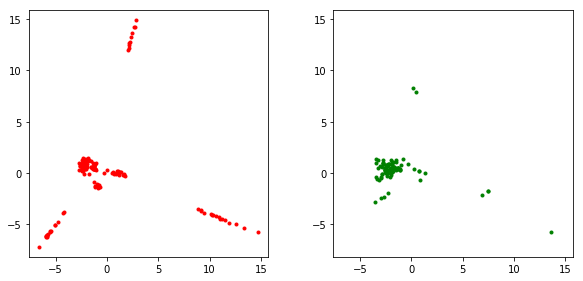

8001 [D loss: 0.523402, acc.: 78.03%] [G loss: 2.645784]
8002 [D loss: 0.491755, acc.: 77.27%] [G loss: 2.462384]
8003 [D loss: 0.555556, acc.: 75.38%] [G loss: 2.696428]
8004 [D loss: 0.517513, acc.: 76.14%] [G loss: 2.474132]
8005 [D loss: 0.471461, acc.: 81.44%] [G loss: 3.153317]
8006 [D loss: 0.541388, acc.: 77.65%] [G loss: 2.890470]
8007 [D loss: 0.539312, acc.: 77.65%] [G loss: 2.423357]
8008 [D loss: 0.504466, acc.: 78.41%] [G loss: 3.437519]
8009 [D loss: 0.513448, acc.: 78.41%] [G loss: 2.476192]
8010 [D loss: 0.469918, acc.: 78.79%] [G loss: 2.724838]
8011 [D loss: 0.541198, acc.: 73.86%] [G loss: 2.882216]
8012 [D loss: 0.564351, acc.: 73.86%] [G loss: 2.278545]
8013 [D loss: 0.521110, acc.: 74.24%] [G loss: 2.477213]
8014 [D loss: 0.519448, acc.: 72.35%] [G loss: 2.241568]
8015 [D loss: 0.571752, acc.: 67.05%] [G loss: 2.213840]
8016 [D loss: 0.535947, acc.: 75.38%] [G loss: 2.195001]
8017 [D loss: 0.474375, acc.: 78.03%] [G loss: 2.292562]
8018 [D loss: 0.493900, acc.: 7

8022 [D loss: 0.531320, acc.: 77.65%] [G loss: 2.317063]
8023 [D loss: 0.535036, acc.: 76.14%] [G loss: 3.121438]
8024 [D loss: 0.539226, acc.: 75.76%] [G loss: 2.553479]
8025 [D loss: 0.525362, acc.: 75.38%] [G loss: 2.152349]
8026 [D loss: 0.540980, acc.: 72.73%] [G loss: 2.367862]
8027 [D loss: 0.495424, acc.: 78.41%] [G loss: 2.338648]
8028 [D loss: 0.502107, acc.: 76.89%] [G loss: 2.818201]
8029 [D loss: 0.517954, acc.: 76.14%] [G loss: 2.460241]
8030 [D loss: 0.506405, acc.: 75.38%] [G loss: 2.749131]
8031 [D loss: 0.534112, acc.: 74.24%] [G loss: 2.254090]
8032 [D loss: 0.547024, acc.: 75.38%] [G loss: 2.128747]
8033 [D loss: 0.527584, acc.: 72.35%] [G loss: 1.818056]
8034 [D loss: 0.456124, acc.: 79.92%] [G loss: 1.990852]
8035 [D loss: 0.561019, acc.: 73.48%] [G loss: 2.488832]
8036 [D loss: 0.554902, acc.: 76.14%] [G loss: 2.928983]
8037 [D loss: 0.580675, acc.: 71.97%] [G loss: 2.267786]
8038 [D loss: 0.539734, acc.: 74.24%] [G loss: 2.369326]
8039 [D loss: 0.481504, acc.: 8

8044 [D loss: 0.483459, acc.: 79.55%] [G loss: 2.330352]
8045 [D loss: 0.493773, acc.: 76.52%] [G loss: 2.568690]
8046 [D loss: 0.539220, acc.: 73.11%] [G loss: 2.635062]
8047 [D loss: 0.512481, acc.: 77.65%] [G loss: 2.499133]
8048 [D loss: 0.527718, acc.: 73.48%] [G loss: 2.369822]
8049 [D loss: 0.539781, acc.: 73.48%] [G loss: 2.411317]
8050 [D loss: 0.579086, acc.: 71.21%] [G loss: 2.703440]
8051 [D loss: 0.468942, acc.: 78.41%] [G loss: 2.551272]
8052 [D loss: 0.516831, acc.: 75.76%] [G loss: 2.464072]
8053 [D loss: 0.503601, acc.: 74.24%] [G loss: 2.346709]
8054 [D loss: 0.464764, acc.: 79.17%] [G loss: 2.892643]
8055 [D loss: 0.537624, acc.: 76.52%] [G loss: 3.040252]
8056 [D loss: 0.550344, acc.: 78.03%] [G loss: 2.683009]
8057 [D loss: 0.510989, acc.: 78.03%] [G loss: 2.973465]
8058 [D loss: 0.487625, acc.: 79.17%] [G loss: 2.414807]
8059 [D loss: 0.508762, acc.: 76.52%] [G loss: 2.208042]
8060 [D loss: 0.468302, acc.: 80.30%] [G loss: 2.402574]
8061 [D loss: 0.529149, acc.: 7

8066 [D loss: 0.530511, acc.: 78.41%] [G loss: 2.570841]
8067 [D loss: 0.539778, acc.: 75.76%] [G loss: 2.899410]
8068 [D loss: 0.490731, acc.: 78.41%] [G loss: 2.346064]
8069 [D loss: 0.519303, acc.: 76.89%] [G loss: 2.703711]
8070 [D loss: 0.487686, acc.: 79.55%] [G loss: 2.160427]
8071 [D loss: 0.545679, acc.: 77.65%] [G loss: 2.360107]
8072 [D loss: 0.532102, acc.: 76.52%] [G loss: 2.580895]
8073 [D loss: 0.529072, acc.: 74.62%] [G loss: 2.288113]
8074 [D loss: 0.543321, acc.: 73.11%] [G loss: 2.311863]
8075 [D loss: 0.493911, acc.: 78.03%] [G loss: 2.318480]
8076 [D loss: 0.524340, acc.: 74.24%] [G loss: 2.636361]
8077 [D loss: 0.538610, acc.: 72.73%] [G loss: 2.143492]
8078 [D loss: 0.515060, acc.: 76.52%] [G loss: 2.072623]
8079 [D loss: 0.534446, acc.: 70.45%] [G loss: 2.832386]
8080 [D loss: 0.496351, acc.: 76.52%] [G loss: 2.191616]
8081 [D loss: 0.528142, acc.: 74.62%] [G loss: 2.113661]
8082 [D loss: 0.549354, acc.: 72.73%] [G loss: 2.048026]
8083 [D loss: 0.465212, acc.: 8

8087 [D loss: 0.594403, acc.: 72.73%] [G loss: 1.973685]
8088 [D loss: 0.551657, acc.: 71.59%] [G loss: 2.516329]
8089 [D loss: 0.497071, acc.: 76.89%] [G loss: 2.621587]
8090 [D loss: 0.536749, acc.: 73.48%] [G loss: 2.443025]
8091 [D loss: 0.509596, acc.: 76.89%] [G loss: 2.560033]
8092 [D loss: 0.507554, acc.: 77.27%] [G loss: 2.399120]
8093 [D loss: 0.592355, acc.: 68.18%] [G loss: 2.071653]
8094 [D loss: 0.458072, acc.: 79.92%] [G loss: 2.590015]
8095 [D loss: 0.505775, acc.: 74.62%] [G loss: 2.605044]
8096 [D loss: 0.486140, acc.: 77.27%] [G loss: 2.488183]
8097 [D loss: 0.529032, acc.: 75.00%] [G loss: 2.387075]
8098 [D loss: 0.514592, acc.: 79.55%] [G loss: 2.312123]
8099 [D loss: 0.503365, acc.: 78.79%] [G loss: 1.905049]
8100 [D loss: 0.548884, acc.: 72.35%] [G loss: 2.212371]
8101 [D loss: 0.538395, acc.: 77.27%] [G loss: 2.441126]
8102 [D loss: 0.513881, acc.: 72.35%] [G loss: 2.611128]
8103 [D loss: 0.483620, acc.: 78.03%] [G loss: 2.290651]
8104 [D loss: 0.481213, acc.: 7

8109 [D loss: 0.463914, acc.: 79.92%] [G loss: 2.719162]
8110 [D loss: 0.511739, acc.: 71.97%] [G loss: 2.421942]
8111 [D loss: 0.504661, acc.: 76.89%] [G loss: 2.210284]
8112 [D loss: 0.582677, acc.: 73.48%] [G loss: 2.222726]
8113 [D loss: 0.511922, acc.: 78.79%] [G loss: 2.136307]
8114 [D loss: 0.513102, acc.: 76.89%] [G loss: 2.577818]
8115 [D loss: 0.492581, acc.: 75.76%] [G loss: 2.676986]
8116 [D loss: 0.544620, acc.: 75.38%] [G loss: 2.562168]
8117 [D loss: 0.498555, acc.: 76.52%] [G loss: 2.541637]
8118 [D loss: 0.545344, acc.: 73.48%] [G loss: 2.045437]
8119 [D loss: 0.506752, acc.: 77.27%] [G loss: 2.405030]
8120 [D loss: 0.542247, acc.: 74.62%] [G loss: 2.406171]
8121 [D loss: 0.531149, acc.: 75.38%] [G loss: 2.489935]
8122 [D loss: 0.497202, acc.: 77.65%] [G loss: 2.331452]
8123 [D loss: 0.496038, acc.: 79.92%] [G loss: 2.447456]
8124 [D loss: 0.517957, acc.: 75.38%] [G loss: 2.220431]
8125 [D loss: 0.483677, acc.: 78.79%] [G loss: 2.928775]
8126 [D loss: 0.508841, acc.: 7

8131 [D loss: 0.623071, acc.: 70.83%] [G loss: 2.323027]
8132 [D loss: 0.484007, acc.: 77.65%] [G loss: 2.042465]
8133 [D loss: 0.604538, acc.: 72.35%] [G loss: 1.998184]
8134 [D loss: 0.597863, acc.: 73.48%] [G loss: 1.968308]
8135 [D loss: 0.504825, acc.: 74.62%] [G loss: 1.905374]
8136 [D loss: 0.482258, acc.: 75.76%] [G loss: 1.956161]
8137 [D loss: 0.537302, acc.: 73.11%] [G loss: 2.274823]
8138 [D loss: 0.537229, acc.: 73.11%] [G loss: 2.395132]
8139 [D loss: 0.510568, acc.: 74.62%] [G loss: 2.339980]
8140 [D loss: 0.536492, acc.: 73.11%] [G loss: 2.294946]
8141 [D loss: 0.501350, acc.: 76.52%] [G loss: 2.075599]
8142 [D loss: 0.530663, acc.: 72.35%] [G loss: 2.245127]
8143 [D loss: 0.524659, acc.: 75.76%] [G loss: 2.188754]
8144 [D loss: 0.508565, acc.: 76.89%] [G loss: 2.667570]
8145 [D loss: 0.569737, acc.: 75.00%] [G loss: 2.237327]
8146 [D loss: 0.579384, acc.: 70.83%] [G loss: 1.900919]
8147 [D loss: 0.460649, acc.: 79.92%] [G loss: 2.486030]
8148 [D loss: 0.512381, acc.: 7

8152 [D loss: 0.526067, acc.: 72.35%] [G loss: 2.691010]
8153 [D loss: 0.537811, acc.: 74.24%] [G loss: 1.825701]
8154 [D loss: 0.475545, acc.: 80.68%] [G loss: 2.535146]
8155 [D loss: 0.490616, acc.: 77.27%] [G loss: 2.442629]
8156 [D loss: 0.466381, acc.: 80.30%] [G loss: 2.665929]
8157 [D loss: 0.530790, acc.: 74.62%] [G loss: 2.688724]
8158 [D loss: 0.573097, acc.: 74.24%] [G loss: 2.412273]
8159 [D loss: 0.503171, acc.: 76.14%] [G loss: 2.331882]
8160 [D loss: 0.474110, acc.: 78.79%] [G loss: 2.611214]
8161 [D loss: 0.535058, acc.: 75.76%] [G loss: 2.516485]
8162 [D loss: 0.545916, acc.: 75.38%] [G loss: 2.476677]
8163 [D loss: 0.492115, acc.: 77.27%] [G loss: 2.514145]
8164 [D loss: 0.494967, acc.: 75.38%] [G loss: 2.779887]
8165 [D loss: 0.523639, acc.: 77.65%] [G loss: 2.258457]
8166 [D loss: 0.550734, acc.: 75.38%] [G loss: 2.813691]
8167 [D loss: 0.566500, acc.: 73.86%] [G loss: 2.469646]
8168 [D loss: 0.596865, acc.: 73.48%] [G loss: 2.126644]
8169 [D loss: 0.544739, acc.: 7

8174 [D loss: 0.553148, acc.: 74.62%] [G loss: 2.680634]
8175 [D loss: 0.510607, acc.: 72.73%] [G loss: 2.207154]
8176 [D loss: 0.520981, acc.: 80.68%] [G loss: 2.317596]
8177 [D loss: 0.505196, acc.: 75.38%] [G loss: 2.894713]
8178 [D loss: 0.570656, acc.: 75.76%] [G loss: 2.866311]
8179 [D loss: 0.559536, acc.: 74.24%] [G loss: 1.901916]
8180 [D loss: 0.534278, acc.: 74.24%] [G loss: 2.627058]
8181 [D loss: 0.508600, acc.: 75.00%] [G loss: 2.760043]
8182 [D loss: 0.485012, acc.: 79.92%] [G loss: 2.749750]
8183 [D loss: 0.532057, acc.: 75.00%] [G loss: 2.674373]
8184 [D loss: 0.557959, acc.: 73.11%] [G loss: 1.926218]
8185 [D loss: 0.527142, acc.: 76.89%] [G loss: 2.390019]
8186 [D loss: 0.595787, acc.: 71.59%] [G loss: 2.660484]
8187 [D loss: 0.523951, acc.: 73.86%] [G loss: 2.402447]
8188 [D loss: 0.546772, acc.: 73.48%] [G loss: 2.194933]
8189 [D loss: 0.557054, acc.: 71.59%] [G loss: 1.896013]
8190 [D loss: 0.496797, acc.: 76.89%] [G loss: 1.982136]
8191 [D loss: 0.471731, acc.: 7

8196 [D loss: 0.512357, acc.: 75.76%] [G loss: 2.234811]
8197 [D loss: 0.542418, acc.: 71.97%] [G loss: 2.002924]
8198 [D loss: 0.516817, acc.: 74.62%] [G loss: 2.572246]
8199 [D loss: 0.483897, acc.: 78.79%] [G loss: 2.352248]
8200 [D loss: 0.512937, acc.: 75.76%] [G loss: 2.388531]
8201 [D loss: 0.484007, acc.: 76.89%] [G loss: 2.618601]
8202 [D loss: 0.528785, acc.: 73.86%] [G loss: 2.269388]
8203 [D loss: 0.559582, acc.: 75.38%] [G loss: 2.200655]
8204 [D loss: 0.585496, acc.: 70.45%] [G loss: 1.919131]
8205 [D loss: 0.549161, acc.: 70.45%] [G loss: 1.982841]
8206 [D loss: 0.523972, acc.: 73.86%] [G loss: 2.074587]
8207 [D loss: 0.552690, acc.: 70.83%] [G loss: 2.142704]
8208 [D loss: 0.497696, acc.: 76.89%] [G loss: 2.623577]
8209 [D loss: 0.539120, acc.: 75.00%] [G loss: 2.431813]
8210 [D loss: 0.479459, acc.: 79.17%] [G loss: 2.150983]
8211 [D loss: 0.543135, acc.: 73.11%] [G loss: 2.270677]
8212 [D loss: 0.582271, acc.: 69.32%] [G loss: 2.824721]
8213 [D loss: 0.520769, acc.: 7

8218 [D loss: 0.597641, acc.: 76.52%] [G loss: 2.268263]
8219 [D loss: 0.484791, acc.: 78.79%] [G loss: 1.938421]
8220 [D loss: 0.573014, acc.: 75.00%] [G loss: 2.462921]
8221 [D loss: 0.616034, acc.: 74.62%] [G loss: 2.546024]
8222 [D loss: 0.465468, acc.: 77.65%] [G loss: 2.415637]
8223 [D loss: 0.539172, acc.: 73.11%] [G loss: 2.555396]
8224 [D loss: 0.521967, acc.: 74.62%] [G loss: 2.324330]
8225 [D loss: 0.573713, acc.: 71.59%] [G loss: 2.462409]
8226 [D loss: 0.487276, acc.: 79.92%] [G loss: 2.496482]
8227 [D loss: 0.514681, acc.: 77.65%] [G loss: 2.196229]
8228 [D loss: 0.458324, acc.: 78.41%] [G loss: 2.343785]
8229 [D loss: 0.475890, acc.: 79.92%] [G loss: 3.025581]
8230 [D loss: 0.534426, acc.: 74.24%] [G loss: 2.549587]
8231 [D loss: 0.530203, acc.: 75.38%] [G loss: 2.507526]
8232 [D loss: 0.529363, acc.: 75.38%] [G loss: 2.843078]
8233 [D loss: 0.511293, acc.: 78.03%] [G loss: 2.926604]
8234 [D loss: 0.470955, acc.: 79.55%] [G loss: 2.649899]
8235 [D loss: 0.536494, acc.: 7

8240 [D loss: 0.569019, acc.: 76.52%] [G loss: 2.312698]
8241 [D loss: 0.472394, acc.: 80.30%] [G loss: 2.293927]
8242 [D loss: 0.470134, acc.: 79.92%] [G loss: 2.221714]
8243 [D loss: 0.500449, acc.: 76.52%] [G loss: 2.948669]
8244 [D loss: 0.535043, acc.: 74.24%] [G loss: 2.220909]
8245 [D loss: 0.532036, acc.: 73.86%] [G loss: 2.513527]
8246 [D loss: 0.524936, acc.: 73.86%] [G loss: 2.566357]
8247 [D loss: 0.499533, acc.: 76.52%] [G loss: 2.148600]
8248 [D loss: 0.505955, acc.: 75.38%] [G loss: 2.788718]
8249 [D loss: 0.558705, acc.: 73.86%] [G loss: 2.698584]
8250 [D loss: 0.517418, acc.: 76.52%] [G loss: 2.443756]
8251 [D loss: 0.454802, acc.: 82.58%] [G loss: 2.191586]
8252 [D loss: 0.487196, acc.: 76.14%] [G loss: 2.263958]
8253 [D loss: 0.500163, acc.: 76.52%] [G loss: 2.953497]
8254 [D loss: 0.480175, acc.: 79.55%] [G loss: 2.415014]
8255 [D loss: 0.567721, acc.: 77.27%] [G loss: 2.618670]
8256 [D loss: 0.501664, acc.: 77.65%] [G loss: 2.471886]
8257 [D loss: 0.542444, acc.: 7

8262 [D loss: 0.564287, acc.: 77.27%] [G loss: 2.310170]
8263 [D loss: 0.514503, acc.: 77.65%] [G loss: 2.691942]
8264 [D loss: 0.495038, acc.: 77.27%] [G loss: 2.218271]
8265 [D loss: 0.493915, acc.: 77.27%] [G loss: 2.200566]
8266 [D loss: 0.603286, acc.: 75.76%] [G loss: 2.005627]
8267 [D loss: 0.514317, acc.: 77.65%] [G loss: 2.898771]
8268 [D loss: 0.561629, acc.: 73.11%] [G loss: 2.140041]
8269 [D loss: 0.575783, acc.: 74.24%] [G loss: 2.033024]
8270 [D loss: 0.540300, acc.: 76.14%] [G loss: 2.977923]
8271 [D loss: 0.580226, acc.: 72.35%] [G loss: 2.502371]
8272 [D loss: 0.513853, acc.: 75.00%] [G loss: 2.206774]
8273 [D loss: 0.498606, acc.: 77.65%] [G loss: 2.196817]
8274 [D loss: 0.561608, acc.: 71.59%] [G loss: 2.463602]
8275 [D loss: 0.541813, acc.: 78.03%] [G loss: 2.622828]
8276 [D loss: 0.559882, acc.: 76.14%] [G loss: 2.316282]
8277 [D loss: 0.545706, acc.: 72.73%] [G loss: 2.235557]
8278 [D loss: 0.492638, acc.: 76.89%] [G loss: 2.511567]
8279 [D loss: 0.524785, acc.: 7

8284 [D loss: 0.490439, acc.: 79.17%] [G loss: 1.915196]
8285 [D loss: 0.527148, acc.: 74.24%] [G loss: 2.279753]
8286 [D loss: 0.514700, acc.: 73.11%] [G loss: 2.905505]
8287 [D loss: 0.516245, acc.: 73.48%] [G loss: 2.456952]
8288 [D loss: 0.475992, acc.: 79.92%] [G loss: 2.165932]
8289 [D loss: 0.532675, acc.: 76.14%] [G loss: 2.315526]
8290 [D loss: 0.588253, acc.: 73.11%] [G loss: 2.331211]
8291 [D loss: 0.521209, acc.: 73.11%] [G loss: 2.281874]
8292 [D loss: 0.544998, acc.: 73.48%] [G loss: 2.118017]
8293 [D loss: 0.534376, acc.: 76.52%] [G loss: 2.588546]
8294 [D loss: 0.545674, acc.: 73.11%] [G loss: 2.248703]
8295 [D loss: 0.556797, acc.: 76.52%] [G loss: 2.479971]
8296 [D loss: 0.477635, acc.: 78.03%] [G loss: 2.586705]
8297 [D loss: 0.509637, acc.: 74.62%] [G loss: 2.289603]
8298 [D loss: 0.505302, acc.: 77.27%] [G loss: 2.071262]
8299 [D loss: 0.516957, acc.: 78.41%] [G loss: 2.382717]
8300 [D loss: 0.567492, acc.: 73.11%] [G loss: 2.692755]
8301 [D loss: 0.538529, acc.: 7

8306 [D loss: 0.539357, acc.: 78.03%] [G loss: 2.441899]
8307 [D loss: 0.504480, acc.: 75.76%] [G loss: 2.563337]
8308 [D loss: 0.543902, acc.: 79.55%] [G loss: 2.682716]
8309 [D loss: 0.526193, acc.: 76.14%] [G loss: 2.847028]
8310 [D loss: 0.502507, acc.: 79.17%] [G loss: 2.448550]
8311 [D loss: 0.524585, acc.: 75.76%] [G loss: 2.030622]
8312 [D loss: 0.469380, acc.: 80.30%] [G loss: 2.020365]
8313 [D loss: 0.543310, acc.: 73.11%] [G loss: 2.335078]
8314 [D loss: 0.501623, acc.: 75.38%] [G loss: 2.361742]
8315 [D loss: 0.500869, acc.: 78.03%] [G loss: 2.726829]
8316 [D loss: 0.469527, acc.: 82.20%] [G loss: 2.803326]
8317 [D loss: 0.615867, acc.: 75.00%] [G loss: 3.355935]
8318 [D loss: 0.536145, acc.: 78.41%] [G loss: 2.256705]
8319 [D loss: 0.525524, acc.: 75.00%] [G loss: 2.532722]
8320 [D loss: 0.517369, acc.: 78.41%] [G loss: 2.837156]
8321 [D loss: 0.500058, acc.: 78.41%] [G loss: 2.686568]
8322 [D loss: 0.531370, acc.: 74.24%] [G loss: 2.203197]
8323 [D loss: 0.535008, acc.: 7

8328 [D loss: 0.635671, acc.: 70.83%] [G loss: 2.306992]
8329 [D loss: 0.579979, acc.: 70.45%] [G loss: 2.297798]
8330 [D loss: 0.542515, acc.: 73.48%] [G loss: 1.936803]
8331 [D loss: 0.497565, acc.: 78.03%] [G loss: 2.141926]
8332 [D loss: 0.497315, acc.: 77.65%] [G loss: 2.861379]
8333 [D loss: 0.500080, acc.: 76.52%] [G loss: 2.813305]
8334 [D loss: 0.508709, acc.: 76.52%] [G loss: 3.009342]
8335 [D loss: 0.484150, acc.: 79.17%] [G loss: 2.526295]
8336 [D loss: 0.570626, acc.: 78.41%] [G loss: 1.935267]
8337 [D loss: 0.518463, acc.: 73.48%] [G loss: 2.363107]
8338 [D loss: 0.537978, acc.: 76.52%] [G loss: 2.204710]
8339 [D loss: 0.491159, acc.: 73.48%] [G loss: 2.936004]
8340 [D loss: 0.553086, acc.: 77.65%] [G loss: 2.585494]
8341 [D loss: 0.545406, acc.: 79.17%] [G loss: 2.161047]
8342 [D loss: 0.581766, acc.: 71.97%] [G loss: 2.194834]
8343 [D loss: 0.498154, acc.: 76.52%] [G loss: 2.091838]
8344 [D loss: 0.534002, acc.: 73.11%] [G loss: 2.204149]
8345 [D loss: 0.521308, acc.: 7

8350 [D loss: 0.562567, acc.: 74.62%] [G loss: 2.454623]
8351 [D loss: 0.520695, acc.: 77.27%] [G loss: 2.341128]
8352 [D loss: 0.517980, acc.: 75.38%] [G loss: 2.404294]
8353 [D loss: 0.560587, acc.: 70.08%] [G loss: 2.583090]
8354 [D loss: 0.530050, acc.: 72.35%] [G loss: 2.515149]
8355 [D loss: 0.545617, acc.: 71.59%] [G loss: 2.213981]
8356 [D loss: 0.523552, acc.: 72.73%] [G loss: 2.656089]
8357 [D loss: 0.491258, acc.: 78.03%] [G loss: 3.015535]
8358 [D loss: 0.526632, acc.: 76.89%] [G loss: 2.609744]
8359 [D loss: 0.547277, acc.: 74.62%] [G loss: 2.228666]
8360 [D loss: 0.581819, acc.: 70.08%] [G loss: 2.244815]
8361 [D loss: 0.575111, acc.: 73.48%] [G loss: 1.882514]
8362 [D loss: 0.515568, acc.: 75.38%] [G loss: 2.328416]
8363 [D loss: 0.550606, acc.: 72.35%] [G loss: 2.898222]
8364 [D loss: 0.543209, acc.: 75.38%] [G loss: 2.312474]
8365 [D loss: 0.609678, acc.: 76.14%] [G loss: 2.355793]
8366 [D loss: 0.552193, acc.: 75.38%] [G loss: 1.702422]
8367 [D loss: 0.535944, acc.: 7

8372 [D loss: 0.502256, acc.: 77.27%] [G loss: 2.831758]
8373 [D loss: 0.520191, acc.: 72.35%] [G loss: 2.766974]
8374 [D loss: 0.455397, acc.: 82.95%] [G loss: 3.606289]
8375 [D loss: 0.507043, acc.: 76.89%] [G loss: 3.178542]
8376 [D loss: 0.585236, acc.: 73.86%] [G loss: 2.093749]
8377 [D loss: 0.511655, acc.: 76.14%] [G loss: 2.243254]
8378 [D loss: 0.546032, acc.: 75.38%] [G loss: 2.627268]
8379 [D loss: 0.503321, acc.: 78.41%] [G loss: 2.600898]
8380 [D loss: 0.552420, acc.: 74.24%] [G loss: 2.753913]
8381 [D loss: 0.455823, acc.: 78.79%] [G loss: 2.528963]
8382 [D loss: 0.554645, acc.: 75.76%] [G loss: 2.778747]
8383 [D loss: 0.504205, acc.: 74.24%] [G loss: 2.867109]
8384 [D loss: 0.527151, acc.: 75.00%] [G loss: 2.421824]
8385 [D loss: 0.554749, acc.: 76.52%] [G loss: 2.226205]
8386 [D loss: 0.595314, acc.: 67.42%] [G loss: 2.019073]
8387 [D loss: 0.509513, acc.: 74.62%] [G loss: 2.232772]
8388 [D loss: 0.475070, acc.: 79.55%] [G loss: 2.019694]
8389 [D loss: 0.498853, acc.: 7

8394 [D loss: 0.522534, acc.: 75.38%] [G loss: 2.561133]
8395 [D loss: 0.485976, acc.: 79.17%] [G loss: 3.072599]
8396 [D loss: 0.525456, acc.: 74.24%] [G loss: 2.870144]
8397 [D loss: 0.550023, acc.: 73.11%] [G loss: 2.842444]
8398 [D loss: 0.535001, acc.: 76.89%] [G loss: 2.423772]
8399 [D loss: 0.503500, acc.: 79.92%] [G loss: 2.536017]
8400 [D loss: 0.499789, acc.: 78.41%] [G loss: 2.336490]
8401 [D loss: 0.528523, acc.: 73.86%] [G loss: 2.150699]
8402 [D loss: 0.531647, acc.: 75.00%] [G loss: 2.658221]
8403 [D loss: 0.535724, acc.: 76.14%] [G loss: 2.195153]
8404 [D loss: 0.486202, acc.: 76.14%] [G loss: 2.152457]
8405 [D loss: 0.489941, acc.: 75.76%] [G loss: 2.290724]
8406 [D loss: 0.498980, acc.: 77.65%] [G loss: 3.052226]
8407 [D loss: 0.460158, acc.: 78.03%] [G loss: 3.228585]
8408 [D loss: 0.614312, acc.: 73.11%] [G loss: 2.713396]
8409 [D loss: 0.497359, acc.: 78.79%] [G loss: 2.367848]
8410 [D loss: 0.646791, acc.: 71.21%] [G loss: 2.421992]
8411 [D loss: 0.515875, acc.: 7

8416 [D loss: 0.550899, acc.: 74.62%] [G loss: 2.424972]
8417 [D loss: 0.449489, acc.: 81.44%] [G loss: 2.958304]
8418 [D loss: 0.520824, acc.: 75.76%] [G loss: 2.893717]
8419 [D loss: 0.531373, acc.: 77.65%] [G loss: 2.410424]
8420 [D loss: 0.538085, acc.: 75.76%] [G loss: 2.228742]
8421 [D loss: 0.538399, acc.: 73.48%] [G loss: 2.594317]
8422 [D loss: 0.570231, acc.: 72.73%] [G loss: 2.392975]
8423 [D loss: 0.535709, acc.: 75.38%] [G loss: 2.135810]
8424 [D loss: 0.504601, acc.: 78.41%] [G loss: 2.659415]
8425 [D loss: 0.492151, acc.: 77.65%] [G loss: 2.650177]
8426 [D loss: 0.538852, acc.: 76.89%] [G loss: 2.217816]
8427 [D loss: 0.527052, acc.: 74.24%] [G loss: 2.912513]
8428 [D loss: 0.539104, acc.: 74.62%] [G loss: 2.081373]
8429 [D loss: 0.546472, acc.: 77.27%] [G loss: 2.252842]
8430 [D loss: 0.493555, acc.: 76.89%] [G loss: 2.620318]
8431 [D loss: 0.506050, acc.: 78.03%] [G loss: 2.743545]
8432 [D loss: 0.517539, acc.: 75.76%] [G loss: 2.631189]
8433 [D loss: 0.477924, acc.: 7

8437 [D loss: 0.474056, acc.: 79.17%] [G loss: 2.742233]
8438 [D loss: 0.532878, acc.: 75.76%] [G loss: 2.351268]
8439 [D loss: 0.556878, acc.: 71.21%] [G loss: 2.453008]
8440 [D loss: 0.489795, acc.: 79.92%] [G loss: 2.910900]
8441 [D loss: 0.515958, acc.: 77.27%] [G loss: 2.659080]
8442 [D loss: 0.536813, acc.: 75.76%] [G loss: 2.461901]
8443 [D loss: 0.551866, acc.: 71.59%] [G loss: 2.166976]
8444 [D loss: 0.500838, acc.: 76.52%] [G loss: 2.592515]
8445 [D loss: 0.494717, acc.: 76.52%] [G loss: 2.317092]
8446 [D loss: 0.544827, acc.: 73.11%] [G loss: 3.072164]
8447 [D loss: 0.470386, acc.: 81.06%] [G loss: 2.983859]
8448 [D loss: 0.506248, acc.: 76.14%] [G loss: 2.682699]
8449 [D loss: 0.551907, acc.: 74.24%] [G loss: 2.781895]
8450 [D loss: 0.546233, acc.: 76.14%] [G loss: 3.043714]
8451 [D loss: 0.511486, acc.: 77.65%] [G loss: 2.496001]
8452 [D loss: 0.484820, acc.: 78.41%] [G loss: 2.581019]
8453 [D loss: 0.522019, acc.: 77.65%] [G loss: 2.251385]
8454 [D loss: 0.543049, acc.: 7

8459 [D loss: 0.531393, acc.: 76.14%] [G loss: 2.154864]
8460 [D loss: 0.522527, acc.: 76.89%] [G loss: 2.625831]
8461 [D loss: 0.527379, acc.: 74.24%] [G loss: 2.313751]
8462 [D loss: 0.544993, acc.: 75.00%] [G loss: 2.250401]
8463 [D loss: 0.521133, acc.: 76.52%] [G loss: 2.152110]
8464 [D loss: 0.522415, acc.: 73.86%] [G loss: 2.575412]
8465 [D loss: 0.516355, acc.: 74.24%] [G loss: 3.072645]
8466 [D loss: 0.511367, acc.: 76.52%] [G loss: 2.495428]
8467 [D loss: 0.546089, acc.: 75.38%] [G loss: 2.674886]
8468 [D loss: 0.578171, acc.: 70.45%] [G loss: 2.546191]
8469 [D loss: 0.530642, acc.: 73.86%] [G loss: 2.045257]
8470 [D loss: 0.482853, acc.: 77.27%] [G loss: 2.391228]
8471 [D loss: 0.447793, acc.: 82.95%] [G loss: 2.700742]
8472 [D loss: 0.495660, acc.: 77.65%] [G loss: 2.535267]
8473 [D loss: 0.510768, acc.: 80.30%] [G loss: 2.474888]
8474 [D loss: 0.570475, acc.: 71.97%] [G loss: 2.614043]
8475 [D loss: 0.530787, acc.: 76.14%] [G loss: 2.650797]
8476 [D loss: 0.481259, acc.: 7

8481 [D loss: 0.512079, acc.: 76.52%] [G loss: 2.093916]
8482 [D loss: 0.480333, acc.: 79.92%] [G loss: 2.349547]
8483 [D loss: 0.475467, acc.: 76.89%] [G loss: 2.418414]
8484 [D loss: 0.542055, acc.: 76.52%] [G loss: 2.588513]
8485 [D loss: 0.551404, acc.: 71.97%] [G loss: 2.261978]
8486 [D loss: 0.517048, acc.: 74.62%] [G loss: 2.542929]
8487 [D loss: 0.506041, acc.: 75.76%] [G loss: 2.418950]
8488 [D loss: 0.484939, acc.: 76.89%] [G loss: 2.773377]
8489 [D loss: 0.593667, acc.: 73.48%] [G loss: 2.522955]
8490 [D loss: 0.526553, acc.: 74.24%] [G loss: 1.934408]
8491 [D loss: 0.500293, acc.: 75.38%] [G loss: 2.592585]
8492 [D loss: 0.484352, acc.: 75.76%] [G loss: 2.409567]
8493 [D loss: 0.511044, acc.: 73.11%] [G loss: 2.709153]
8494 [D loss: 0.537339, acc.: 76.89%] [G loss: 2.416735]
8495 [D loss: 0.506121, acc.: 73.86%] [G loss: 2.668955]
8496 [D loss: 0.551291, acc.: 75.00%] [G loss: 2.430173]
8497 [D loss: 0.520856, acc.: 74.24%] [G loss: 2.134945]
8498 [D loss: 0.480892, acc.: 7

8503 [D loss: 0.553981, acc.: 76.89%] [G loss: 2.345187]
8504 [D loss: 0.508282, acc.: 76.52%] [G loss: 2.530660]
8505 [D loss: 0.576179, acc.: 72.35%] [G loss: 2.007873]
8506 [D loss: 0.458409, acc.: 79.92%] [G loss: 3.116282]
8507 [D loss: 0.483494, acc.: 81.06%] [G loss: 2.396430]
8508 [D loss: 0.464261, acc.: 81.44%] [G loss: 2.807524]
8509 [D loss: 0.593808, acc.: 74.62%] [G loss: 2.089236]
8510 [D loss: 0.560834, acc.: 72.73%] [G loss: 2.096320]
8511 [D loss: 0.461570, acc.: 79.55%] [G loss: 1.909454]
8512 [D loss: 0.519534, acc.: 75.38%] [G loss: 2.273409]
8513 [D loss: 0.566215, acc.: 71.97%] [G loss: 2.225935]
8514 [D loss: 0.457888, acc.: 81.06%] [G loss: 2.256158]
8515 [D loss: 0.534093, acc.: 71.97%] [G loss: 2.273619]
8516 [D loss: 0.487072, acc.: 77.65%] [G loss: 2.509574]
8517 [D loss: 0.558655, acc.: 71.21%] [G loss: 2.000070]
8518 [D loss: 0.561952, acc.: 73.11%] [G loss: 2.035146]
8519 [D loss: 0.520105, acc.: 74.24%] [G loss: 2.596301]
8520 [D loss: 0.519223, acc.: 7

8525 [D loss: 0.525390, acc.: 79.92%] [G loss: 2.525831]
8526 [D loss: 0.544413, acc.: 71.97%] [G loss: 2.014024]
8527 [D loss: 0.514717, acc.: 78.03%] [G loss: 2.387787]
8528 [D loss: 0.490147, acc.: 76.89%] [G loss: 2.625562]
8529 [D loss: 0.468711, acc.: 78.03%] [G loss: 2.560851]
8530 [D loss: 0.516233, acc.: 73.86%] [G loss: 2.525830]
8531 [D loss: 0.512006, acc.: 75.38%] [G loss: 2.213420]
8532 [D loss: 0.531017, acc.: 75.00%] [G loss: 2.635751]
8533 [D loss: 0.486278, acc.: 77.65%] [G loss: 2.664616]
8534 [D loss: 0.535752, acc.: 73.11%] [G loss: 2.524290]
8535 [D loss: 0.489895, acc.: 79.55%] [G loss: 2.524147]
8536 [D loss: 0.502667, acc.: 76.14%] [G loss: 2.203815]
8537 [D loss: 0.505145, acc.: 77.27%] [G loss: 2.312321]
8538 [D loss: 0.547929, acc.: 73.11%] [G loss: 3.037874]
8539 [D loss: 0.567477, acc.: 70.45%] [G loss: 3.051486]
8540 [D loss: 0.526721, acc.: 75.00%] [G loss: 2.294220]
8541 [D loss: 0.514836, acc.: 78.03%] [G loss: 2.311277]
8542 [D loss: 0.504950, acc.: 7

8547 [D loss: 0.522990, acc.: 76.89%] [G loss: 2.258095]
8548 [D loss: 0.529883, acc.: 76.52%] [G loss: 2.566620]
8549 [D loss: 0.539800, acc.: 73.48%] [G loss: 2.123274]
8550 [D loss: 0.490995, acc.: 78.79%] [G loss: 1.854376]
8551 [D loss: 0.511221, acc.: 78.79%] [G loss: 2.235928]
8552 [D loss: 0.448588, acc.: 79.55%] [G loss: 2.647898]
8553 [D loss: 0.499396, acc.: 76.89%] [G loss: 2.571748]
8554 [D loss: 0.588367, acc.: 73.86%] [G loss: 2.557559]
8555 [D loss: 0.520758, acc.: 76.14%] [G loss: 2.443929]
8556 [D loss: 0.552956, acc.: 74.62%] [G loss: 2.623848]
8557 [D loss: 0.472451, acc.: 81.44%] [G loss: 2.201350]
8558 [D loss: 0.538273, acc.: 79.17%] [G loss: 2.180609]
8559 [D loss: 0.519564, acc.: 73.11%] [G loss: 2.445786]
8560 [D loss: 0.536496, acc.: 75.76%] [G loss: 2.358818]
8561 [D loss: 0.586664, acc.: 73.86%] [G loss: 2.270116]
8562 [D loss: 0.499455, acc.: 75.00%] [G loss: 2.422647]
8563 [D loss: 0.511409, acc.: 74.24%] [G loss: 2.404330]
8564 [D loss: 0.510722, acc.: 7

8569 [D loss: 0.522497, acc.: 76.52%] [G loss: 2.346352]
8570 [D loss: 0.538663, acc.: 74.24%] [G loss: 2.022272]
8571 [D loss: 0.496221, acc.: 78.03%] [G loss: 2.316146]
8572 [D loss: 0.477306, acc.: 78.79%] [G loss: 2.793156]
8573 [D loss: 0.512880, acc.: 74.62%] [G loss: 2.459368]
8574 [D loss: 0.483649, acc.: 78.41%] [G loss: 2.683470]
8575 [D loss: 0.546517, acc.: 72.35%] [G loss: 2.665767]
8576 [D loss: 0.514999, acc.: 75.00%] [G loss: 2.669351]
8577 [D loss: 0.529796, acc.: 76.14%] [G loss: 2.528677]
8578 [D loss: 0.528544, acc.: 75.38%] [G loss: 2.132902]
8579 [D loss: 0.601334, acc.: 74.62%] [G loss: 2.271884]
8580 [D loss: 0.481248, acc.: 78.79%] [G loss: 2.380986]
8581 [D loss: 0.528364, acc.: 75.00%] [G loss: 2.572116]
8582 [D loss: 0.486239, acc.: 78.03%] [G loss: 2.577613]
8583 [D loss: 0.548197, acc.: 77.27%] [G loss: 2.269927]
8584 [D loss: 0.545262, acc.: 71.59%] [G loss: 2.538236]
8585 [D loss: 0.517384, acc.: 75.00%] [G loss: 3.230267]
8586 [D loss: 0.549016, acc.: 7

8591 [D loss: 0.545503, acc.: 75.76%] [G loss: 2.756496]
8592 [D loss: 0.541871, acc.: 76.52%] [G loss: 2.541854]
8593 [D loss: 0.577043, acc.: 73.11%] [G loss: 1.671446]
8594 [D loss: 0.552260, acc.: 71.97%] [G loss: 2.212051]
8595 [D loss: 0.493463, acc.: 78.79%] [G loss: 2.614318]
8596 [D loss: 0.553439, acc.: 72.73%] [G loss: 2.487659]
8597 [D loss: 0.549274, acc.: 73.48%] [G loss: 2.450845]
8598 [D loss: 0.506581, acc.: 78.41%] [G loss: 2.455029]
8599 [D loss: 0.572356, acc.: 75.76%] [G loss: 2.203354]
8600 [D loss: 0.490012, acc.: 77.27%] [G loss: 2.184774]
8601 [D loss: 0.527746, acc.: 75.38%] [G loss: 2.361704]
8602 [D loss: 0.528162, acc.: 75.00%] [G loss: 2.432339]
8603 [D loss: 0.557008, acc.: 72.73%] [G loss: 2.240443]
8604 [D loss: 0.513001, acc.: 75.76%] [G loss: 2.450927]
8605 [D loss: 0.483414, acc.: 75.00%] [G loss: 2.065037]
8606 [D loss: 0.451949, acc.: 81.06%] [G loss: 2.588279]
8607 [D loss: 0.505982, acc.: 75.76%] [G loss: 3.125125]
8608 [D loss: 0.523906, acc.: 7

8613 [D loss: 0.525469, acc.: 78.03%] [G loss: 2.662330]
8614 [D loss: 0.475048, acc.: 78.41%] [G loss: 2.491494]
8615 [D loss: 0.533539, acc.: 78.03%] [G loss: 2.156909]
8616 [D loss: 0.516888, acc.: 75.38%] [G loss: 2.424359]
8617 [D loss: 0.544817, acc.: 73.48%] [G loss: 2.699761]
8618 [D loss: 0.489725, acc.: 76.52%] [G loss: 2.657951]
8619 [D loss: 0.463643, acc.: 80.30%] [G loss: 2.991381]
8620 [D loss: 0.515188, acc.: 75.38%] [G loss: 2.684176]
8621 [D loss: 0.541219, acc.: 77.27%] [G loss: 2.871171]
8622 [D loss: 0.512094, acc.: 79.55%] [G loss: 2.771579]
8623 [D loss: 0.508922, acc.: 77.27%] [G loss: 2.518374]
8624 [D loss: 0.516154, acc.: 78.79%] [G loss: 2.225810]
8625 [D loss: 0.507264, acc.: 75.76%] [G loss: 2.694587]
8626 [D loss: 0.520137, acc.: 74.62%] [G loss: 2.855283]
8627 [D loss: 0.522815, acc.: 75.00%] [G loss: 2.817827]
8628 [D loss: 0.561898, acc.: 72.35%] [G loss: 2.211358]
8629 [D loss: 0.454565, acc.: 80.68%] [G loss: 2.472291]
8630 [D loss: 0.601006, acc.: 7

8635 [D loss: 0.509910, acc.: 76.14%] [G loss: 2.520108]
8636 [D loss: 0.558959, acc.: 72.35%] [G loss: 2.154928]
8637 [D loss: 0.503361, acc.: 73.86%] [G loss: 2.818815]
8638 [D loss: 0.516775, acc.: 74.62%] [G loss: 2.240361]
8639 [D loss: 0.468345, acc.: 79.55%] [G loss: 2.242328]
8640 [D loss: 0.488224, acc.: 79.92%] [G loss: 2.012426]
8641 [D loss: 0.527759, acc.: 76.14%] [G loss: 2.449203]
8642 [D loss: 0.449651, acc.: 80.68%] [G loss: 2.535766]
8643 [D loss: 0.527491, acc.: 73.86%] [G loss: 2.651437]
8644 [D loss: 0.541448, acc.: 75.00%] [G loss: 2.422437]
8645 [D loss: 0.533543, acc.: 76.89%] [G loss: 2.116586]
8646 [D loss: 0.524969, acc.: 78.03%] [G loss: 2.384325]
8647 [D loss: 0.536362, acc.: 76.14%] [G loss: 2.584695]
8648 [D loss: 0.508856, acc.: 76.14%] [G loss: 1.869803]
8649 [D loss: 0.483748, acc.: 76.89%] [G loss: 2.468939]
8650 [D loss: 0.563614, acc.: 76.89%] [G loss: 2.229903]
8651 [D loss: 0.559373, acc.: 76.52%] [G loss: 2.082179]
8652 [D loss: 0.536698, acc.: 7

8657 [D loss: 0.542821, acc.: 73.48%] [G loss: 2.185560]
8658 [D loss: 0.560275, acc.: 76.89%] [G loss: 1.979134]
8659 [D loss: 0.495742, acc.: 78.41%] [G loss: 1.800331]
8660 [D loss: 0.508548, acc.: 77.65%] [G loss: 1.864582]
8661 [D loss: 0.512434, acc.: 77.27%] [G loss: 2.753466]
8662 [D loss: 0.544358, acc.: 76.52%] [G loss: 2.206068]
8663 [D loss: 0.557098, acc.: 74.62%] [G loss: 2.197301]
8664 [D loss: 0.495304, acc.: 76.89%] [G loss: 2.504873]
8665 [D loss: 0.528056, acc.: 78.03%] [G loss: 1.811710]
8666 [D loss: 0.490185, acc.: 78.03%] [G loss: 2.545634]
8667 [D loss: 0.477306, acc.: 79.55%] [G loss: 2.074787]
8668 [D loss: 0.573266, acc.: 76.14%] [G loss: 2.667598]
8669 [D loss: 0.519376, acc.: 77.65%] [G loss: 2.096052]
8670 [D loss: 0.527563, acc.: 77.27%] [G loss: 2.437777]
8671 [D loss: 0.530125, acc.: 73.48%] [G loss: 2.526477]
8672 [D loss: 0.500830, acc.: 76.14%] [G loss: 2.193893]
8673 [D loss: 0.510298, acc.: 79.92%] [G loss: 2.425827]
8674 [D loss: 0.459033, acc.: 7

8678 [D loss: 0.503202, acc.: 78.41%] [G loss: 2.642643]
8679 [D loss: 0.498689, acc.: 78.41%] [G loss: 2.648346]
8680 [D loss: 0.474437, acc.: 80.30%] [G loss: 2.916053]
8681 [D loss: 0.524786, acc.: 76.52%] [G loss: 2.520658]
8682 [D loss: 0.549895, acc.: 78.79%] [G loss: 2.434067]
8683 [D loss: 0.508989, acc.: 77.65%] [G loss: 2.293840]
8684 [D loss: 0.507589, acc.: 75.00%] [G loss: 2.162944]
8685 [D loss: 0.513829, acc.: 73.86%] [G loss: 2.262254]
8686 [D loss: 0.494306, acc.: 78.03%] [G loss: 2.398201]
8687 [D loss: 0.490805, acc.: 78.79%] [G loss: 2.933359]
8688 [D loss: 0.579810, acc.: 73.48%] [G loss: 2.298659]
8689 [D loss: 0.564362, acc.: 75.38%] [G loss: 2.613399]
8690 [D loss: 0.492839, acc.: 77.27%] [G loss: 2.296891]
8691 [D loss: 0.577806, acc.: 75.00%] [G loss: 1.912911]
8692 [D loss: 0.553839, acc.: 71.21%] [G loss: 2.416298]
8693 [D loss: 0.492801, acc.: 78.03%] [G loss: 2.391362]
8694 [D loss: 0.496317, acc.: 75.38%] [G loss: 2.387425]
8695 [D loss: 0.514083, acc.: 7

8700 [D loss: 0.513904, acc.: 73.48%] [G loss: 2.207599]
8701 [D loss: 0.495795, acc.: 76.52%] [G loss: 2.607353]
8702 [D loss: 0.534067, acc.: 76.52%] [G loss: 3.046702]
8703 [D loss: 0.534033, acc.: 75.38%] [G loss: 2.509694]
8704 [D loss: 0.589104, acc.: 69.70%] [G loss: 2.514627]
8705 [D loss: 0.498154, acc.: 76.52%] [G loss: 2.317410]
8706 [D loss: 0.533795, acc.: 71.59%] [G loss: 2.111323]
8707 [D loss: 0.520996, acc.: 78.03%] [G loss: 2.693042]
8708 [D loss: 0.531625, acc.: 73.11%] [G loss: 1.959665]
8709 [D loss: 0.533151, acc.: 75.76%] [G loss: 2.374860]
8710 [D loss: 0.533252, acc.: 75.00%] [G loss: 2.685073]
8711 [D loss: 0.542648, acc.: 71.97%] [G loss: 2.301126]
8712 [D loss: 0.583070, acc.: 76.52%] [G loss: 2.727827]
8713 [D loss: 0.507800, acc.: 77.65%] [G loss: 2.488019]
8714 [D loss: 0.557325, acc.: 72.73%] [G loss: 2.641838]
8715 [D loss: 0.444050, acc.: 80.68%] [G loss: 2.134615]
8716 [D loss: 0.531901, acc.: 78.03%] [G loss: 2.507881]
8717 [D loss: 0.463559, acc.: 8

8722 [D loss: 0.466131, acc.: 79.92%] [G loss: 2.560929]
8723 [D loss: 0.508868, acc.: 77.65%] [G loss: 2.664439]
8724 [D loss: 0.588624, acc.: 73.11%] [G loss: 2.362686]
8725 [D loss: 0.498260, acc.: 76.14%] [G loss: 2.173842]
8726 [D loss: 0.523540, acc.: 75.00%] [G loss: 2.295551]
8727 [D loss: 0.590040, acc.: 74.62%] [G loss: 2.160692]
8728 [D loss: 0.521030, acc.: 78.03%] [G loss: 2.334271]
8729 [D loss: 0.526433, acc.: 77.65%] [G loss: 2.597763]
8730 [D loss: 0.524370, acc.: 75.38%] [G loss: 2.094233]
8731 [D loss: 0.537036, acc.: 75.00%] [G loss: 2.207780]
8732 [D loss: 0.549397, acc.: 74.62%] [G loss: 2.213068]
8733 [D loss: 0.507148, acc.: 74.24%] [G loss: 1.943363]
8734 [D loss: 0.505112, acc.: 75.76%] [G loss: 2.541552]
8735 [D loss: 0.553050, acc.: 76.52%] [G loss: 2.228050]
8736 [D loss: 0.582696, acc.: 70.45%] [G loss: 2.548659]
8737 [D loss: 0.504670, acc.: 78.03%] [G loss: 2.281805]
8738 [D loss: 0.504989, acc.: 81.06%] [G loss: 2.967027]
8739 [D loss: 0.554072, acc.: 7

8744 [D loss: 0.473905, acc.: 77.65%] [G loss: 2.005031]
8745 [D loss: 0.569453, acc.: 76.14%] [G loss: 2.437094]
8746 [D loss: 0.549721, acc.: 75.00%] [G loss: 2.056519]
8747 [D loss: 0.503981, acc.: 76.14%] [G loss: 2.137151]
8748 [D loss: 0.476478, acc.: 78.03%] [G loss: 2.156242]
8749 [D loss: 0.487404, acc.: 78.41%] [G loss: 1.935016]
8750 [D loss: 0.625078, acc.: 72.35%] [G loss: 2.102312]
8751 [D loss: 0.490129, acc.: 75.00%] [G loss: 2.330303]
8752 [D loss: 0.641715, acc.: 73.86%] [G loss: 2.047423]
8753 [D loss: 0.571277, acc.: 70.83%] [G loss: 2.435581]
8754 [D loss: 0.514434, acc.: 75.00%] [G loss: 2.270751]
8755 [D loss: 0.521878, acc.: 78.41%] [G loss: 2.441379]
8756 [D loss: 0.520413, acc.: 77.65%] [G loss: 2.406141]
8757 [D loss: 0.539209, acc.: 74.24%] [G loss: 1.967750]
8758 [D loss: 0.523640, acc.: 75.00%] [G loss: 2.573569]
8759 [D loss: 0.506383, acc.: 77.65%] [G loss: 2.845920]
8760 [D loss: 0.511912, acc.: 73.11%] [G loss: 2.292398]
8761 [D loss: 0.532091, acc.: 7

8766 [D loss: 0.588971, acc.: 73.48%] [G loss: 2.163595]
8767 [D loss: 0.467054, acc.: 77.65%] [G loss: 2.244146]
8768 [D loss: 0.490619, acc.: 76.89%] [G loss: 2.845556]
8769 [D loss: 0.511768, acc.: 79.92%] [G loss: 2.242262]
8770 [D loss: 0.525307, acc.: 76.14%] [G loss: 2.229385]
8771 [D loss: 0.523448, acc.: 78.41%] [G loss: 2.233020]
8772 [D loss: 0.467217, acc.: 78.41%] [G loss: 2.619845]
8773 [D loss: 0.580887, acc.: 75.76%] [G loss: 2.088547]
8774 [D loss: 0.529565, acc.: 73.86%] [G loss: 1.998493]
8775 [D loss: 0.527159, acc.: 74.62%] [G loss: 2.608695]
8776 [D loss: 0.516305, acc.: 73.48%] [G loss: 2.283243]
8777 [D loss: 0.498321, acc.: 76.14%] [G loss: 2.532246]
8778 [D loss: 0.568840, acc.: 74.62%] [G loss: 3.007615]
8779 [D loss: 0.524924, acc.: 73.48%] [G loss: 2.180041]
8780 [D loss: 0.560780, acc.: 74.62%] [G loss: 2.015689]
8781 [D loss: 0.470101, acc.: 79.92%] [G loss: 2.648309]
8782 [D loss: 0.458794, acc.: 79.92%] [G loss: 3.019281]
8783 [D loss: 0.531947, acc.: 7

8788 [D loss: 0.532610, acc.: 75.00%] [G loss: 2.804691]
8789 [D loss: 0.506934, acc.: 76.14%] [G loss: 2.267919]
8790 [D loss: 0.478789, acc.: 78.41%] [G loss: 3.083618]
8791 [D loss: 0.482268, acc.: 78.03%] [G loss: 2.832096]
8792 [D loss: 0.489824, acc.: 79.55%] [G loss: 2.322880]
8793 [D loss: 0.593005, acc.: 73.48%] [G loss: 2.309608]
8794 [D loss: 0.508034, acc.: 78.41%] [G loss: 2.700564]
8795 [D loss: 0.559319, acc.: 73.11%] [G loss: 1.795417]
8796 [D loss: 0.505435, acc.: 76.14%] [G loss: 2.207811]
8797 [D loss: 0.512088, acc.: 76.14%] [G loss: 2.385812]
8798 [D loss: 0.538690, acc.: 73.86%] [G loss: 2.657994]
8799 [D loss: 0.512909, acc.: 76.52%] [G loss: 2.428864]
8800 [D loss: 0.536581, acc.: 74.62%] [G loss: 2.359390]
8801 [D loss: 0.521070, acc.: 74.24%] [G loss: 2.091666]
8802 [D loss: 0.576717, acc.: 76.14%] [G loss: 1.867731]
8803 [D loss: 0.504067, acc.: 72.35%] [G loss: 2.308846]
8804 [D loss: 0.438869, acc.: 80.30%] [G loss: 2.689530]
8805 [D loss: 0.513432, acc.: 7

8810 [D loss: 0.471426, acc.: 79.55%] [G loss: 2.494394]
8811 [D loss: 0.476255, acc.: 78.03%] [G loss: 2.812272]
8812 [D loss: 0.558669, acc.: 75.38%] [G loss: 2.539205]
8813 [D loss: 0.485708, acc.: 79.92%] [G loss: 2.361434]
8814 [D loss: 0.581334, acc.: 74.24%] [G loss: 2.648159]
8815 [D loss: 0.485244, acc.: 77.65%] [G loss: 2.524839]
8816 [D loss: 0.542936, acc.: 76.14%] [G loss: 2.212187]
8817 [D loss: 0.501335, acc.: 75.76%] [G loss: 2.026513]
8818 [D loss: 0.542117, acc.: 75.38%] [G loss: 1.942156]
8819 [D loss: 0.467423, acc.: 79.55%] [G loss: 2.954835]
8820 [D loss: 0.505897, acc.: 78.41%] [G loss: 2.191180]
8821 [D loss: 0.494294, acc.: 78.41%] [G loss: 2.473175]
8822 [D loss: 0.529525, acc.: 76.52%] [G loss: 2.681617]
8823 [D loss: 0.492821, acc.: 76.14%] [G loss: 2.421824]
8824 [D loss: 0.549735, acc.: 73.86%] [G loss: 2.441450]
8825 [D loss: 0.557077, acc.: 73.48%] [G loss: 2.736585]
8826 [D loss: 0.476787, acc.: 77.27%] [G loss: 2.453384]
8827 [D loss: 0.448329, acc.: 8

8832 [D loss: 0.459316, acc.: 78.03%] [G loss: 2.434205]
8833 [D loss: 0.553153, acc.: 75.38%] [G loss: 2.945195]
8834 [D loss: 0.509692, acc.: 78.03%] [G loss: 2.692394]
8835 [D loss: 0.510912, acc.: 76.89%] [G loss: 2.483378]
8836 [D loss: 0.525333, acc.: 77.65%] [G loss: 2.681285]
8837 [D loss: 0.501031, acc.: 76.52%] [G loss: 1.831105]
8838 [D loss: 0.488337, acc.: 80.68%] [G loss: 2.186457]
8839 [D loss: 0.489191, acc.: 76.14%] [G loss: 2.454003]
8840 [D loss: 0.536297, acc.: 76.52%] [G loss: 2.291085]
8841 [D loss: 0.521121, acc.: 79.17%] [G loss: 2.152819]
8842 [D loss: 0.580997, acc.: 74.62%] [G loss: 2.381106]
8843 [D loss: 0.502373, acc.: 76.52%] [G loss: 2.033363]
8844 [D loss: 0.580415, acc.: 71.59%] [G loss: 2.033669]
8845 [D loss: 0.511601, acc.: 76.14%] [G loss: 2.489379]
8846 [D loss: 0.521056, acc.: 73.86%] [G loss: 2.399319]
8847 [D loss: 0.602177, acc.: 75.00%] [G loss: 2.275971]
8848 [D loss: 0.556816, acc.: 71.97%] [G loss: 2.361786]
8849 [D loss: 0.541261, acc.: 7

8854 [D loss: 0.493594, acc.: 75.76%] [G loss: 1.764502]
8855 [D loss: 0.534871, acc.: 74.62%] [G loss: 2.592888]
8856 [D loss: 0.464912, acc.: 78.03%] [G loss: 2.202037]
8857 [D loss: 0.517590, acc.: 74.62%] [G loss: 1.824139]
8858 [D loss: 0.553822, acc.: 74.24%] [G loss: 2.686358]
8859 [D loss: 0.542141, acc.: 75.00%] [G loss: 2.469869]
8860 [D loss: 0.513598, acc.: 78.03%] [G loss: 2.289745]
8861 [D loss: 0.482917, acc.: 79.92%] [G loss: 2.750808]
8862 [D loss: 0.525689, acc.: 75.00%] [G loss: 2.358583]
8863 [D loss: 0.512032, acc.: 78.41%] [G loss: 2.059649]
8864 [D loss: 0.496275, acc.: 76.14%] [G loss: 2.053967]
8865 [D loss: 0.490305, acc.: 76.89%] [G loss: 2.480799]
8866 [D loss: 0.542525, acc.: 77.27%] [G loss: 2.293976]
8867 [D loss: 0.500969, acc.: 78.03%] [G loss: 2.588757]
8868 [D loss: 0.541746, acc.: 75.38%] [G loss: 2.282101]
8869 [D loss: 0.595708, acc.: 74.62%] [G loss: 1.911261]
8870 [D loss: 0.503137, acc.: 74.62%] [G loss: 2.464870]
8871 [D loss: 0.562633, acc.: 7

8875 [D loss: 0.514576, acc.: 78.41%] [G loss: 2.316669]
8876 [D loss: 0.540025, acc.: 77.27%] [G loss: 2.731651]
8877 [D loss: 0.562638, acc.: 76.14%] [G loss: 2.155650]
8878 [D loss: 0.502010, acc.: 77.27%] [G loss: 2.049641]
8879 [D loss: 0.480344, acc.: 78.41%] [G loss: 2.369237]
8880 [D loss: 0.550383, acc.: 75.00%] [G loss: 2.450087]
8881 [D loss: 0.503523, acc.: 74.62%] [G loss: 2.305330]
8882 [D loss: 0.529969, acc.: 73.11%] [G loss: 2.066228]
8883 [D loss: 0.535449, acc.: 71.59%] [G loss: 2.459571]
8884 [D loss: 0.554036, acc.: 73.11%] [G loss: 2.072966]
8885 [D loss: 0.507225, acc.: 77.27%] [G loss: 2.328522]
8886 [D loss: 0.549227, acc.: 71.97%] [G loss: 2.702136]
8887 [D loss: 0.520038, acc.: 75.76%] [G loss: 2.291621]
8888 [D loss: 0.590903, acc.: 73.86%] [G loss: 2.180092]
8889 [D loss: 0.504838, acc.: 77.27%] [G loss: 1.748424]
8890 [D loss: 0.528013, acc.: 75.38%] [G loss: 2.262506]
8891 [D loss: 0.503194, acc.: 76.52%] [G loss: 2.600433]
8892 [D loss: 0.524248, acc.: 7

8897 [D loss: 0.545106, acc.: 75.00%] [G loss: 1.970218]
8898 [D loss: 0.518790, acc.: 75.00%] [G loss: 2.027588]
8899 [D loss: 0.450754, acc.: 78.41%] [G loss: 2.696826]
8900 [D loss: 0.477131, acc.: 77.27%] [G loss: 2.395118]
8901 [D loss: 0.496131, acc.: 77.65%] [G loss: 2.818100]
8902 [D loss: 0.453223, acc.: 79.92%] [G loss: 2.977062]
8903 [D loss: 0.548317, acc.: 75.00%] [G loss: 2.896067]
8904 [D loss: 0.525868, acc.: 73.86%] [G loss: 2.509828]
8905 [D loss: 0.536467, acc.: 78.03%] [G loss: 2.172059]
8906 [D loss: 0.471593, acc.: 78.41%] [G loss: 2.484242]
8907 [D loss: 0.494657, acc.: 76.14%] [G loss: 2.657604]
8908 [D loss: 0.488482, acc.: 80.30%] [G loss: 2.315587]
8909 [D loss: 0.548202, acc.: 76.14%] [G loss: 2.398172]
8910 [D loss: 0.519223, acc.: 76.89%] [G loss: 2.570334]
8911 [D loss: 0.500535, acc.: 76.14%] [G loss: 2.560337]
8912 [D loss: 0.533670, acc.: 77.27%] [G loss: 2.812594]
8913 [D loss: 0.475432, acc.: 78.79%] [G loss: 2.684389]
8914 [D loss: 0.516403, acc.: 7

8919 [D loss: 0.477021, acc.: 79.17%] [G loss: 2.338552]
8920 [D loss: 0.501798, acc.: 78.03%] [G loss: 2.205616]
8921 [D loss: 0.517920, acc.: 78.79%] [G loss: 2.225021]
8922 [D loss: 0.486786, acc.: 76.52%] [G loss: 2.272053]
8923 [D loss: 0.487705, acc.: 78.79%] [G loss: 2.785304]
8924 [D loss: 0.470865, acc.: 79.55%] [G loss: 2.453726]
8925 [D loss: 0.505355, acc.: 80.30%] [G loss: 2.546777]
8926 [D loss: 0.513391, acc.: 74.62%] [G loss: 2.494380]
8927 [D loss: 0.499055, acc.: 81.06%] [G loss: 2.405192]
8928 [D loss: 0.564184, acc.: 71.21%] [G loss: 2.304863]
8929 [D loss: 0.541214, acc.: 71.59%] [G loss: 2.810391]
8930 [D loss: 0.521027, acc.: 75.76%] [G loss: 2.336205]
8931 [D loss: 0.525032, acc.: 74.62%] [G loss: 2.038807]
8932 [D loss: 0.509139, acc.: 76.52%] [G loss: 2.128984]
8933 [D loss: 0.549928, acc.: 74.62%] [G loss: 1.784102]
8934 [D loss: 0.528962, acc.: 74.24%] [G loss: 2.529673]
8935 [D loss: 0.489085, acc.: 76.89%] [G loss: 2.326354]
8936 [D loss: 0.521621, acc.: 7

8941 [D loss: 0.531610, acc.: 75.38%] [G loss: 2.411831]
8942 [D loss: 0.492773, acc.: 77.27%] [G loss: 2.464723]
8943 [D loss: 0.567625, acc.: 73.48%] [G loss: 2.037590]
8944 [D loss: 0.487484, acc.: 78.03%] [G loss: 2.118697]
8945 [D loss: 0.510806, acc.: 79.92%] [G loss: 2.651016]
8946 [D loss: 0.518870, acc.: 75.00%] [G loss: 2.415073]
8947 [D loss: 0.528760, acc.: 75.76%] [G loss: 2.306365]
8948 [D loss: 0.497937, acc.: 77.27%] [G loss: 2.927812]
8949 [D loss: 0.534045, acc.: 75.38%] [G loss: 2.906221]
8950 [D loss: 0.523371, acc.: 75.76%] [G loss: 2.463871]
8951 [D loss: 0.545294, acc.: 77.65%] [G loss: 2.747563]
8952 [D loss: 0.535453, acc.: 73.86%] [G loss: 2.210696]
8953 [D loss: 0.492083, acc.: 78.03%] [G loss: 2.444426]
8954 [D loss: 0.532706, acc.: 78.41%] [G loss: 2.604884]
8955 [D loss: 0.564658, acc.: 73.11%] [G loss: 2.234732]
8956 [D loss: 0.476744, acc.: 77.27%] [G loss: 2.159142]
8957 [D loss: 0.520764, acc.: 78.03%] [G loss: 1.967688]
8958 [D loss: 0.528054, acc.: 7

8963 [D loss: 0.498660, acc.: 74.62%] [G loss: 2.212417]
8964 [D loss: 0.482919, acc.: 78.03%] [G loss: 2.314534]
8965 [D loss: 0.513487, acc.: 75.38%] [G loss: 2.594193]
8966 [D loss: 0.510951, acc.: 76.14%] [G loss: 2.376377]
8967 [D loss: 0.454777, acc.: 79.17%] [G loss: 2.573940]
8968 [D loss: 0.570828, acc.: 76.52%] [G loss: 2.702827]
8969 [D loss: 0.466033, acc.: 78.41%] [G loss: 2.699774]
8970 [D loss: 0.533448, acc.: 76.14%] [G loss: 2.340828]
8971 [D loss: 0.517416, acc.: 76.14%] [G loss: 2.424167]
8972 [D loss: 0.533298, acc.: 76.52%] [G loss: 2.410161]
8973 [D loss: 0.493621, acc.: 75.00%] [G loss: 2.363961]
8974 [D loss: 0.586017, acc.: 73.11%] [G loss: 2.792912]
8975 [D loss: 0.460217, acc.: 81.06%] [G loss: 2.885860]
8976 [D loss: 0.514891, acc.: 78.41%] [G loss: 2.645983]
8977 [D loss: 0.523689, acc.: 75.00%] [G loss: 3.140029]
8978 [D loss: 0.505280, acc.: 76.89%] [G loss: 2.712935]
8979 [D loss: 0.590433, acc.: 75.76%] [G loss: 2.111902]
8980 [D loss: 0.561728, acc.: 7

8985 [D loss: 0.494201, acc.: 78.03%] [G loss: 2.614268]
8986 [D loss: 0.502443, acc.: 78.41%] [G loss: 2.654082]
8987 [D loss: 0.483912, acc.: 76.52%] [G loss: 2.541051]
8988 [D loss: 0.549202, acc.: 77.65%] [G loss: 2.886510]
8989 [D loss: 0.541288, acc.: 73.48%] [G loss: 2.975446]
8990 [D loss: 0.492647, acc.: 81.44%] [G loss: 2.520017]
8991 [D loss: 0.525376, acc.: 76.89%] [G loss: 2.392933]
8992 [D loss: 0.524602, acc.: 76.14%] [G loss: 2.072474]
8993 [D loss: 0.472335, acc.: 79.92%] [G loss: 2.763689]
8994 [D loss: 0.488616, acc.: 75.38%] [G loss: 2.640483]
8995 [D loss: 0.437239, acc.: 81.82%] [G loss: 2.730560]
8996 [D loss: 0.597304, acc.: 74.24%] [G loss: 2.715350]
8997 [D loss: 0.529079, acc.: 78.03%] [G loss: 2.395925]
8998 [D loss: 0.583659, acc.: 70.45%] [G loss: 2.148171]
8999 [D loss: 0.455810, acc.: 79.92%] [G loss: 2.689429]
9000 [D loss: 0.574846, acc.: 75.76%] [G loss: 2.276193]


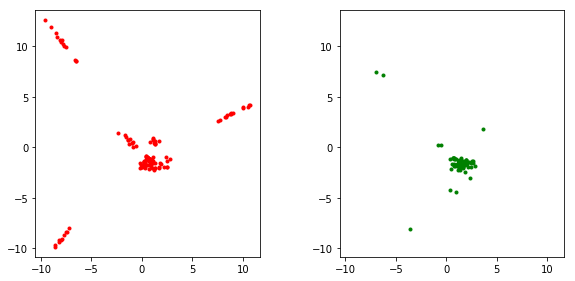

9001 [D loss: 0.538851, acc.: 74.24%] [G loss: 2.018461]
9002 [D loss: 0.554563, acc.: 73.86%] [G loss: 2.507831]
9003 [D loss: 0.563520, acc.: 76.14%] [G loss: 1.908094]
9004 [D loss: 0.523283, acc.: 75.38%] [G loss: 2.346354]
9005 [D loss: 0.497985, acc.: 78.03%] [G loss: 2.487678]
9006 [D loss: 0.535599, acc.: 73.48%] [G loss: 2.555279]
9007 [D loss: 0.508934, acc.: 78.79%] [G loss: 2.184666]
9008 [D loss: 0.500861, acc.: 77.27%] [G loss: 2.452327]
9009 [D loss: 0.495386, acc.: 74.24%] [G loss: 3.032600]
9010 [D loss: 0.551962, acc.: 74.62%] [G loss: 2.110300]
9011 [D loss: 0.496161, acc.: 79.17%] [G loss: 1.796802]
9012 [D loss: 0.480089, acc.: 79.55%] [G loss: 2.717164]
9013 [D loss: 0.536122, acc.: 76.89%] [G loss: 2.814813]
9014 [D loss: 0.461980, acc.: 79.92%] [G loss: 2.371356]
9015 [D loss: 0.453971, acc.: 79.17%] [G loss: 2.526800]
9016 [D loss: 0.523524, acc.: 73.11%] [G loss: 2.417635]
9017 [D loss: 0.550700, acc.: 78.03%] [G loss: 2.979768]
9018 [D loss: 0.445714, acc.: 7

9022 [D loss: 0.488053, acc.: 78.79%] [G loss: 1.983676]
9023 [D loss: 0.545138, acc.: 74.24%] [G loss: 2.556159]
9024 [D loss: 0.493761, acc.: 75.76%] [G loss: 2.325187]
9025 [D loss: 0.520513, acc.: 74.62%] [G loss: 2.184270]
9026 [D loss: 0.462325, acc.: 78.41%] [G loss: 2.584168]
9027 [D loss: 0.520914, acc.: 76.52%] [G loss: 2.284765]
9028 [D loss: 0.521467, acc.: 74.24%] [G loss: 2.535675]
9029 [D loss: 0.516290, acc.: 77.65%] [G loss: 2.200403]
9030 [D loss: 0.524585, acc.: 75.38%] [G loss: 2.200142]
9031 [D loss: 0.509648, acc.: 75.38%] [G loss: 2.506842]
9032 [D loss: 0.515197, acc.: 75.38%] [G loss: 2.002229]
9033 [D loss: 0.433710, acc.: 80.68%] [G loss: 2.207815]
9034 [D loss: 0.520344, acc.: 76.89%] [G loss: 2.468882]
9035 [D loss: 0.520596, acc.: 76.89%] [G loss: 2.366010]
9036 [D loss: 0.506429, acc.: 77.65%] [G loss: 2.228295]
9037 [D loss: 0.460536, acc.: 80.68%] [G loss: 2.350825]
9038 [D loss: 0.477817, acc.: 77.27%] [G loss: 2.651649]
9039 [D loss: 0.507314, acc.: 7

9044 [D loss: 0.497467, acc.: 76.14%] [G loss: 2.759075]
9045 [D loss: 0.477882, acc.: 81.44%] [G loss: 2.733169]
9046 [D loss: 0.536968, acc.: 77.27%] [G loss: 3.089138]
9047 [D loss: 0.443029, acc.: 81.44%] [G loss: 2.602558]
9048 [D loss: 0.453327, acc.: 81.82%] [G loss: 2.531614]
9049 [D loss: 0.498388, acc.: 78.03%] [G loss: 2.821895]
9050 [D loss: 0.515232, acc.: 72.73%] [G loss: 3.271986]
9051 [D loss: 0.476501, acc.: 80.30%] [G loss: 1.767584]
9052 [D loss: 0.555027, acc.: 74.62%] [G loss: 2.367179]
9053 [D loss: 0.485871, acc.: 77.65%] [G loss: 2.216891]
9054 [D loss: 0.562886, acc.: 74.24%] [G loss: 2.658149]
9055 [D loss: 0.553763, acc.: 74.24%] [G loss: 2.271859]
9056 [D loss: 0.542539, acc.: 74.62%] [G loss: 2.521050]
9057 [D loss: 0.504556, acc.: 76.52%] [G loss: 2.512105]
9058 [D loss: 0.514186, acc.: 74.62%] [G loss: 2.776097]
9059 [D loss: 0.504702, acc.: 76.52%] [G loss: 2.292642]
9060 [D loss: 0.505432, acc.: 75.00%] [G loss: 2.434649]
9061 [D loss: 0.521083, acc.: 7

9066 [D loss: 0.608042, acc.: 71.97%] [G loss: 2.193675]
9067 [D loss: 0.509943, acc.: 76.14%] [G loss: 2.327940]
9068 [D loss: 0.557077, acc.: 76.14%] [G loss: 2.008242]
9069 [D loss: 0.549127, acc.: 76.52%] [G loss: 1.987139]
9070 [D loss: 0.535515, acc.: 77.65%] [G loss: 2.112200]
9071 [D loss: 0.506152, acc.: 76.52%] [G loss: 2.278024]
9072 [D loss: 0.560952, acc.: 73.86%] [G loss: 2.863495]
9073 [D loss: 0.529745, acc.: 78.41%] [G loss: 2.316064]
9074 [D loss: 0.522886, acc.: 75.76%] [G loss: 2.328630]
9075 [D loss: 0.552090, acc.: 74.24%] [G loss: 2.771090]
9076 [D loss: 0.542299, acc.: 73.48%] [G loss: 2.378448]
9077 [D loss: 0.530611, acc.: 75.00%] [G loss: 2.528992]
9078 [D loss: 0.473020, acc.: 81.06%] [G loss: 2.345178]
9079 [D loss: 0.561857, acc.: 75.38%] [G loss: 2.410676]
9080 [D loss: 0.626056, acc.: 72.73%] [G loss: 2.026566]
9081 [D loss: 0.582063, acc.: 71.21%] [G loss: 2.578729]
9082 [D loss: 0.529017, acc.: 76.89%] [G loss: 2.606797]
9083 [D loss: 0.520630, acc.: 7

9088 [D loss: 0.483280, acc.: 78.03%] [G loss: 2.577763]
9089 [D loss: 0.517558, acc.: 79.17%] [G loss: 2.618038]
9090 [D loss: 0.560949, acc.: 73.48%] [G loss: 2.458166]
9091 [D loss: 0.474266, acc.: 76.89%] [G loss: 2.263229]
9092 [D loss: 0.531292, acc.: 76.52%] [G loss: 2.596038]
9093 [D loss: 0.466713, acc.: 78.79%] [G loss: 2.354127]
9094 [D loss: 0.516398, acc.: 78.79%] [G loss: 2.592726]
9095 [D loss: 0.452892, acc.: 80.68%] [G loss: 2.449079]
9096 [D loss: 0.507602, acc.: 76.89%] [G loss: 2.278396]
9097 [D loss: 0.612906, acc.: 72.73%] [G loss: 2.056152]
9098 [D loss: 0.470178, acc.: 80.30%] [G loss: 2.396128]
9099 [D loss: 0.479246, acc.: 77.65%] [G loss: 2.057082]
9100 [D loss: 0.502064, acc.: 77.27%] [G loss: 2.567974]
9101 [D loss: 0.514832, acc.: 76.14%] [G loss: 2.646413]
9102 [D loss: 0.491194, acc.: 78.41%] [G loss: 2.219807]
9103 [D loss: 0.505685, acc.: 77.27%] [G loss: 2.169323]
9104 [D loss: 0.579130, acc.: 70.45%] [G loss: 2.451989]
9105 [D loss: 0.469814, acc.: 7

9110 [D loss: 0.538893, acc.: 78.03%] [G loss: 2.363631]
9111 [D loss: 0.490689, acc.: 75.76%] [G loss: 2.642216]
9112 [D loss: 0.461873, acc.: 78.41%] [G loss: 3.103332]
9113 [D loss: 0.543219, acc.: 75.38%] [G loss: 2.455519]
9114 [D loss: 0.466361, acc.: 79.17%] [G loss: 2.659548]
9115 [D loss: 0.502364, acc.: 75.00%] [G loss: 2.436428]
9116 [D loss: 0.583091, acc.: 74.24%] [G loss: 2.389508]
9117 [D loss: 0.485874, acc.: 76.89%] [G loss: 2.392771]
9118 [D loss: 0.541454, acc.: 72.73%] [G loss: 2.478111]
9119 [D loss: 0.507854, acc.: 75.76%] [G loss: 2.382562]
9120 [D loss: 0.510655, acc.: 78.41%] [G loss: 2.553449]
9121 [D loss: 0.446677, acc.: 80.30%] [G loss: 2.870071]
9122 [D loss: 0.521598, acc.: 78.41%] [G loss: 2.647208]
9123 [D loss: 0.524160, acc.: 76.89%] [G loss: 2.385165]
9124 [D loss: 0.508679, acc.: 78.03%] [G loss: 3.098282]
9125 [D loss: 0.543693, acc.: 72.35%] [G loss: 2.115754]
9126 [D loss: 0.514773, acc.: 75.00%] [G loss: 2.886923]
9127 [D loss: 0.490296, acc.: 7

9132 [D loss: 0.628461, acc.: 70.45%] [G loss: 2.421409]
9133 [D loss: 0.512503, acc.: 75.00%] [G loss: 2.313904]
9134 [D loss: 0.510028, acc.: 75.00%] [G loss: 2.216368]
9135 [D loss: 0.540220, acc.: 74.62%] [G loss: 2.242196]
9136 [D loss: 0.512662, acc.: 75.38%] [G loss: 2.372518]
9137 [D loss: 0.480117, acc.: 79.92%] [G loss: 2.519615]
9138 [D loss: 0.543045, acc.: 76.89%] [G loss: 2.611198]
9139 [D loss: 0.478404, acc.: 76.89%] [G loss: 3.427660]
9140 [D loss: 0.468131, acc.: 78.41%] [G loss: 2.193163]
9141 [D loss: 0.488835, acc.: 78.41%] [G loss: 2.809328]
9142 [D loss: 0.624886, acc.: 72.35%] [G loss: 2.028924]
9143 [D loss: 0.469898, acc.: 80.68%] [G loss: 2.360390]
9144 [D loss: 0.542427, acc.: 78.03%] [G loss: 2.549057]
9145 [D loss: 0.501845, acc.: 76.14%] [G loss: 2.235342]
9146 [D loss: 0.484519, acc.: 78.41%] [G loss: 2.699461]
9147 [D loss: 0.549214, acc.: 75.38%] [G loss: 2.540327]
9148 [D loss: 0.486544, acc.: 77.65%] [G loss: 1.994341]
9149 [D loss: 0.546707, acc.: 7

9154 [D loss: 0.492667, acc.: 77.27%] [G loss: 2.592957]
9155 [D loss: 0.498660, acc.: 76.14%] [G loss: 2.546932]
9156 [D loss: 0.586351, acc.: 70.08%] [G loss: 2.137093]
9157 [D loss: 0.507741, acc.: 76.52%] [G loss: 2.130931]
9158 [D loss: 0.530421, acc.: 73.86%] [G loss: 2.361849]
9159 [D loss: 0.520964, acc.: 76.14%] [G loss: 2.485984]
9160 [D loss: 0.570655, acc.: 73.11%] [G loss: 2.453902]
9161 [D loss: 0.540692, acc.: 76.89%] [G loss: 2.023306]
9162 [D loss: 0.544571, acc.: 73.86%] [G loss: 2.112862]
9163 [D loss: 0.530124, acc.: 71.21%] [G loss: 2.994807]
9164 [D loss: 0.566517, acc.: 76.14%] [G loss: 2.510693]
9165 [D loss: 0.560024, acc.: 70.08%] [G loss: 2.467075]
9166 [D loss: 0.481928, acc.: 77.65%] [G loss: 2.447826]
9167 [D loss: 0.471241, acc.: 75.00%] [G loss: 2.316368]
9168 [D loss: 0.562202, acc.: 78.03%] [G loss: 2.682256]
9169 [D loss: 0.544183, acc.: 77.65%] [G loss: 2.425095]
9170 [D loss: 0.489987, acc.: 76.52%] [G loss: 2.512020]
9171 [D loss: 0.483275, acc.: 7

9175 [D loss: 0.504818, acc.: 77.65%] [G loss: 2.234491]
9176 [D loss: 0.535386, acc.: 75.38%] [G loss: 2.082073]
9177 [D loss: 0.520574, acc.: 75.00%] [G loss: 2.095357]
9178 [D loss: 0.489393, acc.: 78.41%] [G loss: 2.001511]
9179 [D loss: 0.491704, acc.: 77.27%] [G loss: 2.796789]
9180 [D loss: 0.471550, acc.: 82.20%] [G loss: 2.713905]
9181 [D loss: 0.490428, acc.: 76.89%] [G loss: 2.373201]
9182 [D loss: 0.547849, acc.: 74.62%] [G loss: 2.681929]
9183 [D loss: 0.540575, acc.: 77.27%] [G loss: 2.685406]
9184 [D loss: 0.496198, acc.: 77.65%] [G loss: 2.534810]
9185 [D loss: 0.576530, acc.: 72.35%] [G loss: 2.331109]
9186 [D loss: 0.468248, acc.: 79.92%] [G loss: 2.601736]
9187 [D loss: 0.551965, acc.: 75.38%] [G loss: 2.626690]
9188 [D loss: 0.502620, acc.: 74.62%] [G loss: 2.314243]
9189 [D loss: 0.522585, acc.: 78.41%] [G loss: 2.200461]
9190 [D loss: 0.533312, acc.: 74.62%] [G loss: 2.285163]
9191 [D loss: 0.518271, acc.: 75.38%] [G loss: 2.854445]
9192 [D loss: 0.511176, acc.: 7

9197 [D loss: 0.510311, acc.: 77.27%] [G loss: 2.431625]
9198 [D loss: 0.500404, acc.: 76.52%] [G loss: 2.226197]
9199 [D loss: 0.511647, acc.: 79.55%] [G loss: 2.286428]
9200 [D loss: 0.443738, acc.: 79.92%] [G loss: 2.597855]
9201 [D loss: 0.520619, acc.: 78.79%] [G loss: 2.173026]
9202 [D loss: 0.540827, acc.: 75.00%] [G loss: 2.375612]
9203 [D loss: 0.528656, acc.: 76.89%] [G loss: 2.519664]
9204 [D loss: 0.545328, acc.: 74.62%] [G loss: 2.522778]
9205 [D loss: 0.537323, acc.: 75.38%] [G loss: 3.044167]
9206 [D loss: 0.498974, acc.: 76.14%] [G loss: 2.428148]
9207 [D loss: 0.557220, acc.: 76.14%] [G loss: 2.528524]
9208 [D loss: 0.513336, acc.: 76.14%] [G loss: 2.507320]
9209 [D loss: 0.595173, acc.: 73.48%] [G loss: 2.134070]
9210 [D loss: 0.582914, acc.: 70.83%] [G loss: 2.296632]
9211 [D loss: 0.506939, acc.: 76.52%] [G loss: 2.397896]
9212 [D loss: 0.507342, acc.: 76.14%] [G loss: 2.330830]
9213 [D loss: 0.548262, acc.: 74.62%] [G loss: 2.218209]
9214 [D loss: 0.527756, acc.: 7

9219 [D loss: 0.508775, acc.: 75.76%] [G loss: 2.614451]
9220 [D loss: 0.465173, acc.: 79.17%] [G loss: 2.519340]
9221 [D loss: 0.533825, acc.: 76.14%] [G loss: 3.100571]
9222 [D loss: 0.533355, acc.: 74.62%] [G loss: 2.249769]
9223 [D loss: 0.496912, acc.: 79.17%] [G loss: 1.866185]
9224 [D loss: 0.484632, acc.: 79.17%] [G loss: 2.546746]
9225 [D loss: 0.483947, acc.: 79.55%] [G loss: 2.056528]
9226 [D loss: 0.498166, acc.: 76.14%] [G loss: 2.249465]
9227 [D loss: 0.486193, acc.: 79.55%] [G loss: 2.728301]
9228 [D loss: 0.593250, acc.: 77.65%] [G loss: 3.100337]
9229 [D loss: 0.526527, acc.: 74.24%] [G loss: 3.047513]
9230 [D loss: 0.507733, acc.: 77.65%] [G loss: 2.518215]
9231 [D loss: 0.523603, acc.: 77.65%] [G loss: 2.023993]
9232 [D loss: 0.485565, acc.: 78.41%] [G loss: 2.365599]
9233 [D loss: 0.548292, acc.: 74.62%] [G loss: 2.498001]
9234 [D loss: 0.501337, acc.: 76.14%] [G loss: 2.399914]
9235 [D loss: 0.530032, acc.: 76.52%] [G loss: 2.244397]
9236 [D loss: 0.521588, acc.: 7

9241 [D loss: 0.488293, acc.: 80.68%] [G loss: 2.414524]
9242 [D loss: 0.505118, acc.: 76.14%] [G loss: 2.610251]
9243 [D loss: 0.464343, acc.: 81.44%] [G loss: 2.183990]
9244 [D loss: 0.514363, acc.: 76.89%] [G loss: 2.518634]
9245 [D loss: 0.578481, acc.: 72.35%] [G loss: 2.411417]
9246 [D loss: 0.470756, acc.: 80.68%] [G loss: 2.176315]
9247 [D loss: 0.512493, acc.: 76.14%] [G loss: 2.496341]
9248 [D loss: 0.470096, acc.: 79.55%] [G loss: 2.627809]
9249 [D loss: 0.513814, acc.: 75.38%] [G loss: 2.162441]
9250 [D loss: 0.473656, acc.: 78.79%] [G loss: 2.884040]
9251 [D loss: 0.473012, acc.: 78.79%] [G loss: 2.930272]
9252 [D loss: 0.548017, acc.: 72.35%] [G loss: 2.452725]
9253 [D loss: 0.489642, acc.: 78.03%] [G loss: 2.618625]
9254 [D loss: 0.631196, acc.: 74.24%] [G loss: 2.375878]
9255 [D loss: 0.481007, acc.: 79.92%] [G loss: 2.412429]
9256 [D loss: 0.487725, acc.: 76.14%] [G loss: 2.768435]
9257 [D loss: 0.526394, acc.: 76.52%] [G loss: 2.371090]
9258 [D loss: 0.534232, acc.: 7

9263 [D loss: 0.530871, acc.: 74.62%] [G loss: 2.256383]
9264 [D loss: 0.464748, acc.: 78.79%] [G loss: 2.364422]
9265 [D loss: 0.532150, acc.: 78.03%] [G loss: 2.367283]
9266 [D loss: 0.475865, acc.: 78.79%] [G loss: 2.149977]
9267 [D loss: 0.498196, acc.: 78.79%] [G loss: 2.827571]
9268 [D loss: 0.585634, acc.: 72.73%] [G loss: 1.993244]
9269 [D loss: 0.500645, acc.: 79.17%] [G loss: 2.268169]
9270 [D loss: 0.565556, acc.: 70.83%] [G loss: 2.141163]
9271 [D loss: 0.525843, acc.: 76.14%] [G loss: 2.086417]
9272 [D loss: 0.537754, acc.: 76.52%] [G loss: 2.292149]
9273 [D loss: 0.511894, acc.: 75.00%] [G loss: 2.484537]
9274 [D loss: 0.516937, acc.: 76.14%] [G loss: 2.378287]
9275 [D loss: 0.475257, acc.: 79.17%] [G loss: 2.433078]
9276 [D loss: 0.583282, acc.: 70.83%] [G loss: 2.040538]
9277 [D loss: 0.485309, acc.: 78.03%] [G loss: 2.443150]
9278 [D loss: 0.535928, acc.: 79.55%] [G loss: 2.122353]
9279 [D loss: 0.439678, acc.: 83.71%] [G loss: 2.740463]
9280 [D loss: 0.484038, acc.: 7

9284 [D loss: 0.517475, acc.: 75.76%] [G loss: 2.651705]
9285 [D loss: 0.475227, acc.: 78.03%] [G loss: 3.021095]
9286 [D loss: 0.505891, acc.: 79.17%] [G loss: 2.490227]
9287 [D loss: 0.533950, acc.: 75.76%] [G loss: 2.576912]
9288 [D loss: 0.490601, acc.: 79.17%] [G loss: 2.822454]
9289 [D loss: 0.565747, acc.: 75.00%] [G loss: 2.364844]
9290 [D loss: 0.492805, acc.: 77.27%] [G loss: 2.685397]
9291 [D loss: 0.509457, acc.: 77.27%] [G loss: 2.929800]
9292 [D loss: 0.508283, acc.: 75.00%] [G loss: 2.327047]
9293 [D loss: 0.670759, acc.: 72.73%] [G loss: 2.311591]
9294 [D loss: 0.554548, acc.: 71.21%] [G loss: 2.135276]
9295 [D loss: 0.527284, acc.: 74.24%] [G loss: 2.933194]
9296 [D loss: 0.577819, acc.: 71.21%] [G loss: 1.905650]
9297 [D loss: 0.512117, acc.: 76.52%] [G loss: 2.216582]
9298 [D loss: 0.535691, acc.: 75.00%] [G loss: 2.750441]
9299 [D loss: 0.561111, acc.: 73.86%] [G loss: 2.189389]
9300 [D loss: 0.509231, acc.: 77.65%] [G loss: 2.736727]
9301 [D loss: 0.508616, acc.: 7

9306 [D loss: 0.464569, acc.: 79.17%] [G loss: 2.522742]
9307 [D loss: 0.504065, acc.: 76.52%] [G loss: 2.189486]
9308 [D loss: 0.477365, acc.: 77.27%] [G loss: 2.218093]
9309 [D loss: 0.489455, acc.: 75.00%] [G loss: 2.167045]
9310 [D loss: 0.550148, acc.: 75.76%] [G loss: 2.885403]
9311 [D loss: 0.455465, acc.: 80.30%] [G loss: 2.269630]
9312 [D loss: 0.592285, acc.: 72.73%] [G loss: 2.017801]
9313 [D loss: 0.559950, acc.: 73.48%] [G loss: 2.330759]
9314 [D loss: 0.540715, acc.: 73.86%] [G loss: 2.185890]
9315 [D loss: 0.585398, acc.: 75.38%] [G loss: 2.304085]
9316 [D loss: 0.521684, acc.: 75.00%] [G loss: 1.936457]
9317 [D loss: 0.534120, acc.: 75.76%] [G loss: 2.093326]
9318 [D loss: 0.529079, acc.: 77.27%] [G loss: 2.124881]
9319 [D loss: 0.522365, acc.: 73.48%] [G loss: 2.016112]
9320 [D loss: 0.509721, acc.: 78.03%] [G loss: 2.281527]
9321 [D loss: 0.494467, acc.: 78.03%] [G loss: 2.194713]
9322 [D loss: 0.509746, acc.: 76.89%] [G loss: 2.204980]
9323 [D loss: 0.477451, acc.: 7

9328 [D loss: 0.510555, acc.: 78.79%] [G loss: 3.119172]
9329 [D loss: 0.526259, acc.: 78.41%] [G loss: 2.602185]
9330 [D loss: 0.471117, acc.: 78.79%] [G loss: 2.533064]
9331 [D loss: 0.550350, acc.: 75.76%] [G loss: 2.767110]
9332 [D loss: 0.592010, acc.: 71.59%] [G loss: 2.319518]
9333 [D loss: 0.485193, acc.: 79.92%] [G loss: 2.211401]
9334 [D loss: 0.585196, acc.: 70.83%] [G loss: 2.185499]
9335 [D loss: 0.552428, acc.: 75.38%] [G loss: 1.899467]
9336 [D loss: 0.480694, acc.: 77.65%] [G loss: 2.208016]
9337 [D loss: 0.505817, acc.: 76.52%] [G loss: 2.577867]
9338 [D loss: 0.461984, acc.: 81.44%] [G loss: 2.483238]
9339 [D loss: 0.552778, acc.: 75.00%] [G loss: 2.740401]
9340 [D loss: 0.517698, acc.: 77.65%] [G loss: 2.733189]
9341 [D loss: 0.513067, acc.: 75.38%] [G loss: 2.377762]
9342 [D loss: 0.496444, acc.: 76.52%] [G loss: 2.838905]
9343 [D loss: 0.503107, acc.: 77.65%] [G loss: 2.782619]
9344 [D loss: 0.503475, acc.: 78.03%] [G loss: 2.509442]
9345 [D loss: 0.662946, acc.: 7

9350 [D loss: 0.558752, acc.: 73.48%] [G loss: 2.191889]
9351 [D loss: 0.570496, acc.: 72.35%] [G loss: 2.055605]
9352 [D loss: 0.464015, acc.: 82.58%] [G loss: 1.837471]
9353 [D loss: 0.501540, acc.: 79.17%] [G loss: 1.973511]
9354 [D loss: 0.511926, acc.: 75.76%] [G loss: 2.511392]
9355 [D loss: 0.500985, acc.: 75.38%] [G loss: 2.420337]
9356 [D loss: 0.494892, acc.: 77.27%] [G loss: 2.342991]
9357 [D loss: 0.516606, acc.: 76.52%] [G loss: 2.783188]
9358 [D loss: 0.513885, acc.: 77.65%] [G loss: 2.475798]
9359 [D loss: 0.528827, acc.: 77.27%] [G loss: 2.087661]
9360 [D loss: 0.464135, acc.: 79.92%] [G loss: 2.889928]
9361 [D loss: 0.499475, acc.: 79.92%] [G loss: 2.483278]
9362 [D loss: 0.520579, acc.: 75.00%] [G loss: 2.561591]
9363 [D loss: 0.597895, acc.: 74.62%] [G loss: 2.141758]
9364 [D loss: 0.455459, acc.: 80.68%] [G loss: 2.445250]
9365 [D loss: 0.539199, acc.: 73.11%] [G loss: 2.284710]
9366 [D loss: 0.525729, acc.: 77.27%] [G loss: 2.740797]
9367 [D loss: 0.490500, acc.: 7

9372 [D loss: 0.503055, acc.: 78.03%] [G loss: 2.253371]
9373 [D loss: 0.580933, acc.: 75.00%] [G loss: 2.008105]
9374 [D loss: 0.522538, acc.: 75.38%] [G loss: 1.920587]
9375 [D loss: 0.492130, acc.: 78.41%] [G loss: 2.366392]
9376 [D loss: 0.482978, acc.: 76.14%] [G loss: 2.688897]
9377 [D loss: 0.507781, acc.: 76.14%] [G loss: 2.374465]
9378 [D loss: 0.540843, acc.: 71.97%] [G loss: 3.269776]
9379 [D loss: 0.497229, acc.: 76.89%] [G loss: 2.228161]
9380 [D loss: 0.535139, acc.: 76.52%] [G loss: 2.635522]
9381 [D loss: 0.580997, acc.: 73.86%] [G loss: 2.501941]
9382 [D loss: 0.553171, acc.: 72.73%] [G loss: 2.416265]
9383 [D loss: 0.543662, acc.: 73.48%] [G loss: 2.356805]
9384 [D loss: 0.494189, acc.: 78.79%] [G loss: 2.770905]
9385 [D loss: 0.525811, acc.: 76.52%] [G loss: 2.781111]
9386 [D loss: 0.525391, acc.: 78.79%] [G loss: 2.599093]
9387 [D loss: 0.490140, acc.: 76.52%] [G loss: 2.434353]
9388 [D loss: 0.483031, acc.: 79.17%] [G loss: 2.517127]
9389 [D loss: 0.529568, acc.: 7

9394 [D loss: 0.480212, acc.: 78.79%] [G loss: 2.505167]
9395 [D loss: 0.539276, acc.: 76.89%] [G loss: 2.678228]
9396 [D loss: 0.551785, acc.: 74.62%] [G loss: 2.355649]
9397 [D loss: 0.554721, acc.: 78.79%] [G loss: 1.894877]
9398 [D loss: 0.539617, acc.: 72.35%] [G loss: 2.588894]
9399 [D loss: 0.558883, acc.: 78.79%] [G loss: 2.445577]
9400 [D loss: 0.560237, acc.: 71.21%] [G loss: 2.627742]
9401 [D loss: 0.526748, acc.: 74.24%] [G loss: 2.187042]
9402 [D loss: 0.511948, acc.: 78.03%] [G loss: 2.178723]
9403 [D loss: 0.532363, acc.: 75.38%] [G loss: 2.366683]
9404 [D loss: 0.507545, acc.: 74.24%] [G loss: 2.463675]
9405 [D loss: 0.494062, acc.: 77.65%] [G loss: 2.479385]
9406 [D loss: 0.485399, acc.: 77.27%] [G loss: 3.021943]
9407 [D loss: 0.496633, acc.: 76.89%] [G loss: 2.496997]
9408 [D loss: 0.575189, acc.: 72.35%] [G loss: 2.735627]
9409 [D loss: 0.511260, acc.: 77.65%] [G loss: 2.509609]
9410 [D loss: 0.510620, acc.: 76.52%] [G loss: 2.070429]
9411 [D loss: 0.507623, acc.: 7

9416 [D loss: 0.544924, acc.: 75.38%] [G loss: 2.299603]
9417 [D loss: 0.547516, acc.: 75.76%] [G loss: 2.571606]
9418 [D loss: 0.498637, acc.: 77.27%] [G loss: 2.060482]
9419 [D loss: 0.494830, acc.: 78.41%] [G loss: 2.336153]
9420 [D loss: 0.534225, acc.: 74.62%] [G loss: 2.615091]
9421 [D loss: 0.509264, acc.: 79.92%] [G loss: 2.340702]
9422 [D loss: 0.505828, acc.: 77.27%] [G loss: 3.115616]
9423 [D loss: 0.588209, acc.: 72.73%] [G loss: 2.268483]
9424 [D loss: 0.483144, acc.: 78.41%] [G loss: 2.391427]
9425 [D loss: 0.517029, acc.: 77.27%] [G loss: 2.362254]
9426 [D loss: 0.593977, acc.: 71.21%] [G loss: 2.047071]
9427 [D loss: 0.471932, acc.: 75.76%] [G loss: 2.379196]
9428 [D loss: 0.505948, acc.: 76.89%] [G loss: 3.143557]
9429 [D loss: 0.457068, acc.: 80.68%] [G loss: 2.377741]
9430 [D loss: 0.511009, acc.: 73.86%] [G loss: 2.315795]
9431 [D loss: 0.461000, acc.: 78.03%] [G loss: 2.342785]
9432 [D loss: 0.622782, acc.: 73.11%] [G loss: 2.397847]
9433 [D loss: 0.502641, acc.: 7

9438 [D loss: 0.528508, acc.: 77.27%] [G loss: 2.061453]
9439 [D loss: 0.489653, acc.: 78.79%] [G loss: 2.254148]
9440 [D loss: 0.463668, acc.: 79.55%] [G loss: 3.101798]
9441 [D loss: 0.542023, acc.: 75.00%] [G loss: 2.489680]
9442 [D loss: 0.491445, acc.: 78.41%] [G loss: 2.697597]
9443 [D loss: 0.594885, acc.: 70.08%] [G loss: 2.119872]
9444 [D loss: 0.485196, acc.: 78.79%] [G loss: 2.104716]
9445 [D loss: 0.526750, acc.: 76.14%] [G loss: 2.399371]
9446 [D loss: 0.467448, acc.: 79.55%] [G loss: 2.800242]
9447 [D loss: 0.562520, acc.: 78.03%] [G loss: 1.931760]
9448 [D loss: 0.515199, acc.: 77.65%] [G loss: 1.692803]
9449 [D loss: 0.546864, acc.: 73.86%] [G loss: 2.324117]
9450 [D loss: 0.498278, acc.: 76.89%] [G loss: 1.659737]
9451 [D loss: 0.489958, acc.: 80.30%] [G loss: 2.682250]
9452 [D loss: 0.485016, acc.: 75.38%] [G loss: 2.506255]
9453 [D loss: 0.517792, acc.: 78.79%] [G loss: 2.334084]
9454 [D loss: 0.596384, acc.: 75.38%] [G loss: 2.247380]
9455 [D loss: 0.521030, acc.: 7

9460 [D loss: 0.554810, acc.: 75.00%] [G loss: 2.400905]
9461 [D loss: 0.517401, acc.: 76.52%] [G loss: 1.874015]
9462 [D loss: 0.565364, acc.: 72.73%] [G loss: 2.853722]
9463 [D loss: 0.527347, acc.: 75.38%] [G loss: 2.173797]
9464 [D loss: 0.507099, acc.: 78.79%] [G loss: 1.906885]
9465 [D loss: 0.492669, acc.: 75.38%] [G loss: 2.232107]
9466 [D loss: 0.461873, acc.: 79.17%] [G loss: 2.699704]
9467 [D loss: 0.454385, acc.: 79.92%] [G loss: 2.670402]
9468 [D loss: 0.490536, acc.: 79.55%] [G loss: 2.305715]
9469 [D loss: 0.548077, acc.: 76.52%] [G loss: 2.310926]
9470 [D loss: 0.545193, acc.: 77.27%] [G loss: 2.436965]
9471 [D loss: 0.540483, acc.: 74.62%] [G loss: 2.333164]
9472 [D loss: 0.516543, acc.: 73.86%] [G loss: 2.526995]
9473 [D loss: 0.519352, acc.: 80.68%] [G loss: 2.560267]
9474 [D loss: 0.516920, acc.: 79.55%] [G loss: 2.537761]
9475 [D loss: 0.542666, acc.: 75.00%] [G loss: 2.520706]
9476 [D loss: 0.497533, acc.: 75.38%] [G loss: 2.515195]
9477 [D loss: 0.501242, acc.: 7

9482 [D loss: 0.538244, acc.: 76.89%] [G loss: 2.848899]
9483 [D loss: 0.523487, acc.: 75.76%] [G loss: 2.222723]
9484 [D loss: 0.449350, acc.: 81.44%] [G loss: 2.396329]
9485 [D loss: 0.570760, acc.: 77.27%] [G loss: 2.423508]
9486 [D loss: 0.469752, acc.: 79.92%] [G loss: 2.215160]
9487 [D loss: 0.504762, acc.: 77.27%] [G loss: 2.724238]
9488 [D loss: 0.520020, acc.: 76.14%] [G loss: 2.145532]
9489 [D loss: 0.488168, acc.: 77.65%] [G loss: 2.611992]
9490 [D loss: 0.459567, acc.: 79.17%] [G loss: 2.310627]
9491 [D loss: 0.501821, acc.: 78.03%] [G loss: 2.849987]
9492 [D loss: 0.482882, acc.: 76.89%] [G loss: 2.676817]
9493 [D loss: 0.562848, acc.: 73.11%] [G loss: 2.109529]
9494 [D loss: 0.530697, acc.: 76.52%] [G loss: 2.226293]
9495 [D loss: 0.465033, acc.: 78.79%] [G loss: 2.440162]
9496 [D loss: 0.491538, acc.: 78.79%] [G loss: 2.362415]
9497 [D loss: 0.491302, acc.: 77.65%] [G loss: 2.606910]
9498 [D loss: 0.491337, acc.: 77.65%] [G loss: 2.258795]
9499 [D loss: 0.631937, acc.: 7

9504 [D loss: 0.525812, acc.: 77.65%] [G loss: 2.480834]
9505 [D loss: 0.537954, acc.: 75.76%] [G loss: 2.712021]
9506 [D loss: 0.476538, acc.: 78.41%] [G loss: 2.748629]
9507 [D loss: 0.502875, acc.: 76.89%] [G loss: 2.293949]
9508 [D loss: 0.516547, acc.: 74.24%] [G loss: 2.058880]
9509 [D loss: 0.521027, acc.: 76.52%] [G loss: 2.496433]
9510 [D loss: 0.560259, acc.: 73.11%] [G loss: 2.718397]
9511 [D loss: 0.490371, acc.: 80.68%] [G loss: 2.579272]
9512 [D loss: 0.505724, acc.: 75.38%] [G loss: 2.482856]
9513 [D loss: 0.641962, acc.: 71.97%] [G loss: 2.436612]
9514 [D loss: 0.550525, acc.: 75.00%] [G loss: 2.328274]
9515 [D loss: 0.549243, acc.: 78.03%] [G loss: 2.280832]
9516 [D loss: 0.500945, acc.: 77.65%] [G loss: 3.120624]
9517 [D loss: 0.506335, acc.: 75.76%] [G loss: 2.645164]
9518 [D loss: 0.508218, acc.: 78.79%] [G loss: 1.838129]
9519 [D loss: 0.557266, acc.: 73.48%] [G loss: 2.037700]
9520 [D loss: 0.477550, acc.: 79.55%] [G loss: 2.470942]
9521 [D loss: 0.518676, acc.: 8

9525 [D loss: 0.513482, acc.: 78.03%] [G loss: 2.190883]
9526 [D loss: 0.503752, acc.: 77.65%] [G loss: 2.053706]
9527 [D loss: 0.501663, acc.: 76.89%] [G loss: 2.154474]
9528 [D loss: 0.539829, acc.: 78.41%] [G loss: 2.479696]
9529 [D loss: 0.514019, acc.: 75.76%] [G loss: 2.211863]
9530 [D loss: 0.517933, acc.: 74.24%] [G loss: 2.333231]
9531 [D loss: 0.474517, acc.: 78.41%] [G loss: 2.331928]
9532 [D loss: 0.591846, acc.: 73.86%] [G loss: 2.659782]
9533 [D loss: 0.504370, acc.: 76.89%] [G loss: 2.168906]
9534 [D loss: 0.501844, acc.: 78.03%] [G loss: 2.352441]
9535 [D loss: 0.549529, acc.: 75.38%] [G loss: 2.601402]
9536 [D loss: 0.536613, acc.: 74.62%] [G loss: 2.195334]
9537 [D loss: 0.519939, acc.: 75.00%] [G loss: 2.667488]
9538 [D loss: 0.546298, acc.: 73.86%] [G loss: 2.331588]
9539 [D loss: 0.575841, acc.: 76.89%] [G loss: 1.851023]
9540 [D loss: 0.518985, acc.: 77.27%] [G loss: 2.330795]
9541 [D loss: 0.505820, acc.: 77.65%] [G loss: 1.936505]
9542 [D loss: 0.472991, acc.: 7

9547 [D loss: 0.506767, acc.: 77.27%] [G loss: 2.103159]
9548 [D loss: 0.493645, acc.: 75.38%] [G loss: 2.393387]
9549 [D loss: 0.523722, acc.: 75.00%] [G loss: 2.278710]
9550 [D loss: 0.526816, acc.: 75.00%] [G loss: 2.011690]
9551 [D loss: 0.491842, acc.: 81.82%] [G loss: 2.293498]
9552 [D loss: 0.453893, acc.: 80.30%] [G loss: 2.315604]
9553 [D loss: 0.516713, acc.: 76.52%] [G loss: 2.593623]
9554 [D loss: 0.555316, acc.: 75.76%] [G loss: 2.462627]
9555 [D loss: 0.492937, acc.: 79.55%] [G loss: 2.769605]
9556 [D loss: 0.574540, acc.: 74.62%] [G loss: 2.487891]
9557 [D loss: 0.515804, acc.: 75.76%] [G loss: 2.252149]
9558 [D loss: 0.500640, acc.: 77.27%] [G loss: 2.209910]
9559 [D loss: 0.468414, acc.: 77.27%] [G loss: 2.562215]
9560 [D loss: 0.476253, acc.: 77.27%] [G loss: 2.672528]
9561 [D loss: 0.548646, acc.: 76.14%] [G loss: 2.484594]
9562 [D loss: 0.449616, acc.: 79.55%] [G loss: 2.265226]
9563 [D loss: 0.591197, acc.: 73.86%] [G loss: 2.238428]
9564 [D loss: 0.560566, acc.: 7

9569 [D loss: 0.508257, acc.: 78.41%] [G loss: 2.157322]
9570 [D loss: 0.591710, acc.: 71.21%] [G loss: 2.372928]
9571 [D loss: 0.499061, acc.: 76.52%] [G loss: 1.653433]
9572 [D loss: 0.521314, acc.: 78.03%] [G loss: 2.087768]
9573 [D loss: 0.507885, acc.: 73.86%] [G loss: 2.877144]
9574 [D loss: 0.530329, acc.: 76.52%] [G loss: 2.149257]
9575 [D loss: 0.500246, acc.: 77.27%] [G loss: 2.780150]
9576 [D loss: 0.442486, acc.: 80.30%] [G loss: 2.793066]
9577 [D loss: 0.531246, acc.: 78.41%] [G loss: 2.630709]
9578 [D loss: 0.501087, acc.: 78.79%] [G loss: 3.270287]
9579 [D loss: 0.592036, acc.: 74.24%] [G loss: 2.635134]
9580 [D loss: 0.502005, acc.: 77.27%] [G loss: 2.082706]
9581 [D loss: 0.551061, acc.: 75.76%] [G loss: 2.484841]
9582 [D loss: 0.512116, acc.: 76.89%] [G loss: 2.207293]
9583 [D loss: 0.522313, acc.: 75.38%] [G loss: 2.801759]
9584 [D loss: 0.450042, acc.: 82.20%] [G loss: 2.615107]
9585 [D loss: 0.517163, acc.: 75.38%] [G loss: 2.715812]
9586 [D loss: 0.597331, acc.: 7

9591 [D loss: 0.515641, acc.: 76.89%] [G loss: 1.971937]
9592 [D loss: 0.483530, acc.: 78.41%] [G loss: 2.502997]
9593 [D loss: 0.506208, acc.: 78.03%] [G loss: 2.371313]
9594 [D loss: 0.559299, acc.: 77.65%] [G loss: 2.496280]
9595 [D loss: 0.489038, acc.: 79.55%] [G loss: 2.151072]
9596 [D loss: 0.525849, acc.: 73.48%] [G loss: 2.895270]
9597 [D loss: 0.554095, acc.: 76.89%] [G loss: 2.481017]
9598 [D loss: 0.533191, acc.: 75.76%] [G loss: 2.381855]
9599 [D loss: 0.518147, acc.: 73.86%] [G loss: 2.569217]
9600 [D loss: 0.491176, acc.: 79.17%] [G loss: 2.367890]
9601 [D loss: 0.496542, acc.: 81.44%] [G loss: 2.646366]
9602 [D loss: 0.444666, acc.: 80.68%] [G loss: 2.986751]
9603 [D loss: 0.532826, acc.: 74.62%] [G loss: 2.693262]
9604 [D loss: 0.474564, acc.: 81.06%] [G loss: 2.526255]
9605 [D loss: 0.524346, acc.: 75.76%] [G loss: 2.593681]
9606 [D loss: 0.562592, acc.: 72.35%] [G loss: 2.536476]
9607 [D loss: 0.501362, acc.: 76.89%] [G loss: 2.463459]
9608 [D loss: 0.510412, acc.: 7

9613 [D loss: 0.508276, acc.: 77.65%] [G loss: 2.028304]
9614 [D loss: 0.463148, acc.: 82.20%] [G loss: 2.318196]
9615 [D loss: 0.467282, acc.: 80.30%] [G loss: 2.554012]
9616 [D loss: 0.527055, acc.: 75.38%] [G loss: 2.368793]
9617 [D loss: 0.516765, acc.: 75.76%] [G loss: 2.940189]
9618 [D loss: 0.505629, acc.: 77.27%] [G loss: 2.408508]
9619 [D loss: 0.526754, acc.: 76.52%] [G loss: 2.231923]
9620 [D loss: 0.512542, acc.: 77.65%] [G loss: 2.489584]
9621 [D loss: 0.533691, acc.: 76.14%] [G loss: 2.741176]
9622 [D loss: 0.474364, acc.: 78.79%] [G loss: 2.641658]
9623 [D loss: 0.501282, acc.: 78.41%] [G loss: 2.573427]
9624 [D loss: 0.500383, acc.: 77.27%] [G loss: 2.290981]
9625 [D loss: 0.505291, acc.: 77.27%] [G loss: 2.670069]
9626 [D loss: 0.491066, acc.: 80.68%] [G loss: 2.233956]
9627 [D loss: 0.536285, acc.: 75.00%] [G loss: 2.141729]
9628 [D loss: 0.477321, acc.: 77.27%] [G loss: 2.572811]
9629 [D loss: 0.483624, acc.: 81.06%] [G loss: 2.499360]
9630 [D loss: 0.514887, acc.: 7

9634 [D loss: 0.484255, acc.: 80.68%] [G loss: 2.421433]
9635 [D loss: 0.512406, acc.: 77.27%] [G loss: 2.588696]
9636 [D loss: 0.551771, acc.: 73.48%] [G loss: 2.978842]
9637 [D loss: 0.527484, acc.: 78.79%] [G loss: 2.348451]
9638 [D loss: 0.542862, acc.: 76.14%] [G loss: 2.276450]
9639 [D loss: 0.495440, acc.: 79.17%] [G loss: 1.941659]
9640 [D loss: 0.480172, acc.: 80.68%] [G loss: 2.050961]
9641 [D loss: 0.467511, acc.: 79.17%] [G loss: 2.728644]
9642 [D loss: 0.467962, acc.: 80.30%] [G loss: 2.735198]
9643 [D loss: 0.534396, acc.: 76.52%] [G loss: 2.500135]
9644 [D loss: 0.492966, acc.: 80.30%] [G loss: 2.932808]
9645 [D loss: 0.493900, acc.: 78.41%] [G loss: 2.414456]
9646 [D loss: 0.467115, acc.: 80.68%] [G loss: 2.759337]
9647 [D loss: 0.499164, acc.: 79.55%] [G loss: 2.189524]
9648 [D loss: 0.479461, acc.: 77.27%] [G loss: 2.297153]
9649 [D loss: 0.529388, acc.: 74.62%] [G loss: 1.959213]
9650 [D loss: 0.553785, acc.: 75.38%] [G loss: 1.900183]
9651 [D loss: 0.483931, acc.: 7

9656 [D loss: 0.503553, acc.: 75.00%] [G loss: 2.192340]
9657 [D loss: 0.528853, acc.: 75.76%] [G loss: 2.421541]
9658 [D loss: 0.504874, acc.: 76.89%] [G loss: 2.154903]
9659 [D loss: 0.568804, acc.: 73.86%] [G loss: 2.515244]
9660 [D loss: 0.563485, acc.: 70.45%] [G loss: 2.252826]
9661 [D loss: 0.487999, acc.: 79.92%] [G loss: 2.300283]
9662 [D loss: 0.494801, acc.: 77.27%] [G loss: 2.681146]
9663 [D loss: 0.536222, acc.: 75.00%] [G loss: 2.203475]
9664 [D loss: 0.571887, acc.: 78.41%] [G loss: 2.391454]
9665 [D loss: 0.435872, acc.: 84.09%] [G loss: 2.825436]
9666 [D loss: 0.467283, acc.: 78.79%] [G loss: 2.384544]
9667 [D loss: 0.538606, acc.: 74.62%] [G loss: 2.944892]
9668 [D loss: 0.498858, acc.: 76.89%] [G loss: 1.994953]
9669 [D loss: 0.444136, acc.: 79.55%] [G loss: 2.339894]
9670 [D loss: 0.489814, acc.: 78.41%] [G loss: 2.483323]
9671 [D loss: 0.535467, acc.: 75.38%] [G loss: 2.271930]
9672 [D loss: 0.426387, acc.: 83.71%] [G loss: 2.324332]
9673 [D loss: 0.547664, acc.: 7

9677 [D loss: 0.467593, acc.: 81.44%] [G loss: 2.565500]
9678 [D loss: 0.495445, acc.: 80.30%] [G loss: 1.990617]
9679 [D loss: 0.475825, acc.: 80.68%] [G loss: 2.736693]
9680 [D loss: 0.556134, acc.: 74.24%] [G loss: 2.416451]
9681 [D loss: 0.506070, acc.: 77.27%] [G loss: 2.306787]
9682 [D loss: 0.592101, acc.: 73.11%] [G loss: 2.376685]
9683 [D loss: 0.474456, acc.: 81.82%] [G loss: 1.767398]
9684 [D loss: 0.482835, acc.: 80.30%] [G loss: 2.264881]
9685 [D loss: 0.522404, acc.: 75.00%] [G loss: 2.427551]
9686 [D loss: 0.479793, acc.: 78.03%] [G loss: 2.804237]
9687 [D loss: 0.510606, acc.: 79.55%] [G loss: 2.237175]
9688 [D loss: 0.566647, acc.: 75.38%] [G loss: 1.944553]
9689 [D loss: 0.459487, acc.: 81.06%] [G loss: 2.750197]
9690 [D loss: 0.515921, acc.: 76.52%] [G loss: 2.657056]
9691 [D loss: 0.558847, acc.: 76.89%] [G loss: 2.356495]
9692 [D loss: 0.517286, acc.: 76.52%] [G loss: 2.328146]
9693 [D loss: 0.537007, acc.: 75.38%] [G loss: 2.183191]
9694 [D loss: 0.479920, acc.: 7

9699 [D loss: 0.526688, acc.: 75.38%] [G loss: 2.280535]
9700 [D loss: 0.527344, acc.: 79.92%] [G loss: 2.766563]
9701 [D loss: 0.523098, acc.: 75.00%] [G loss: 2.220444]
9702 [D loss: 0.482833, acc.: 78.03%] [G loss: 2.063408]
9703 [D loss: 0.494480, acc.: 79.55%] [G loss: 2.503760]
9704 [D loss: 0.476682, acc.: 79.92%] [G loss: 2.786045]
9705 [D loss: 0.458965, acc.: 81.06%] [G loss: 2.861341]
9706 [D loss: 0.602421, acc.: 75.76%] [G loss: 2.136117]
9707 [D loss: 0.539840, acc.: 74.62%] [G loss: 2.453992]
9708 [D loss: 0.543458, acc.: 74.62%] [G loss: 2.364098]
9709 [D loss: 0.549870, acc.: 74.62%] [G loss: 2.427735]
9710 [D loss: 0.500684, acc.: 78.79%] [G loss: 2.663687]
9711 [D loss: 0.485999, acc.: 78.41%] [G loss: 2.629405]
9712 [D loss: 0.483246, acc.: 78.41%] [G loss: 2.413331]
9713 [D loss: 0.541657, acc.: 78.03%] [G loss: 2.341394]
9714 [D loss: 0.459657, acc.: 81.44%] [G loss: 2.365215]
9715 [D loss: 0.629512, acc.: 72.35%] [G loss: 1.949786]
9716 [D loss: 0.473434, acc.: 8

9721 [D loss: 0.566343, acc.: 77.65%] [G loss: 2.490556]
9722 [D loss: 0.524352, acc.: 74.24%] [G loss: 2.707690]
9723 [D loss: 0.510397, acc.: 76.14%] [G loss: 2.744576]
9724 [D loss: 0.496811, acc.: 79.55%] [G loss: 2.159002]
9725 [D loss: 0.552593, acc.: 74.24%] [G loss: 2.477849]
9726 [D loss: 0.542015, acc.: 74.24%] [G loss: 2.819981]
9727 [D loss: 0.471463, acc.: 80.30%] [G loss: 2.074737]
9728 [D loss: 0.488797, acc.: 78.03%] [G loss: 2.530795]
9729 [D loss: 0.560759, acc.: 75.76%] [G loss: 2.394838]
9730 [D loss: 0.450107, acc.: 80.30%] [G loss: 2.150895]
9731 [D loss: 0.517776, acc.: 77.27%] [G loss: 2.280398]
9732 [D loss: 0.523043, acc.: 77.65%] [G loss: 2.381944]
9733 [D loss: 0.519832, acc.: 75.38%] [G loss: 2.458586]
9734 [D loss: 0.481432, acc.: 77.65%] [G loss: 2.044157]
9735 [D loss: 0.457928, acc.: 79.17%] [G loss: 2.724451]
9736 [D loss: 0.477400, acc.: 80.68%] [G loss: 3.041492]
9737 [D loss: 0.546691, acc.: 77.27%] [G loss: 2.460036]
9738 [D loss: 0.555009, acc.: 7

9742 [D loss: 0.518040, acc.: 75.38%] [G loss: 2.512473]
9743 [D loss: 0.523149, acc.: 75.38%] [G loss: 2.063627]
9744 [D loss: 0.513808, acc.: 73.86%] [G loss: 2.217956]
9745 [D loss: 0.544714, acc.: 72.73%] [G loss: 2.664590]
9746 [D loss: 0.493836, acc.: 76.89%] [G loss: 2.109683]
9747 [D loss: 0.500389, acc.: 76.14%] [G loss: 2.645275]
9748 [D loss: 0.540236, acc.: 74.24%] [G loss: 2.316525]
9749 [D loss: 0.537196, acc.: 76.89%] [G loss: 2.030997]
9750 [D loss: 0.509353, acc.: 77.27%] [G loss: 2.953258]
9751 [D loss: 0.466623, acc.: 81.06%] [G loss: 2.815065]
9752 [D loss: 0.512741, acc.: 78.41%] [G loss: 2.498933]
9753 [D loss: 0.545519, acc.: 74.24%] [G loss: 2.468968]
9754 [D loss: 0.454673, acc.: 80.30%] [G loss: 2.801034]
9755 [D loss: 0.570677, acc.: 70.83%] [G loss: 2.156589]
9756 [D loss: 0.550952, acc.: 73.48%] [G loss: 2.371929]
9757 [D loss: 0.505792, acc.: 76.52%] [G loss: 2.467394]
9758 [D loss: 0.524975, acc.: 73.86%] [G loss: 2.383973]
9759 [D loss: 0.499166, acc.: 7

9764 [D loss: 0.580545, acc.: 72.35%] [G loss: 2.177103]
9765 [D loss: 0.534750, acc.: 76.89%] [G loss: 2.189343]
9766 [D loss: 0.504391, acc.: 77.65%] [G loss: 2.450554]
9767 [D loss: 0.492759, acc.: 78.79%] [G loss: 2.825889]
9768 [D loss: 0.501292, acc.: 75.38%] [G loss: 2.413046]
9769 [D loss: 0.540771, acc.: 75.38%] [G loss: 2.920751]
9770 [D loss: 0.557223, acc.: 73.48%] [G loss: 2.241741]
9771 [D loss: 0.478254, acc.: 80.30%] [G loss: 2.543266]
9772 [D loss: 0.465263, acc.: 79.17%] [G loss: 2.588864]
9773 [D loss: 0.511085, acc.: 76.14%] [G loss: 2.503963]
9774 [D loss: 0.491738, acc.: 78.41%] [G loss: 2.786292]
9775 [D loss: 0.524568, acc.: 75.00%] [G loss: 2.661441]
9776 [D loss: 0.504830, acc.: 75.00%] [G loss: 2.478203]
9777 [D loss: 0.481077, acc.: 76.52%] [G loss: 2.338765]
9778 [D loss: 0.531873, acc.: 74.24%] [G loss: 2.148903]
9779 [D loss: 0.491150, acc.: 76.52%] [G loss: 2.512292]
9780 [D loss: 0.456306, acc.: 81.06%] [G loss: 2.253978]
9781 [D loss: 0.540172, acc.: 7

9785 [D loss: 0.531067, acc.: 76.52%] [G loss: 2.340576]
9786 [D loss: 0.495982, acc.: 79.55%] [G loss: 2.643044]
9787 [D loss: 0.506307, acc.: 78.79%] [G loss: 2.562380]
9788 [D loss: 0.466348, acc.: 79.92%] [G loss: 2.494225]
9789 [D loss: 0.517504, acc.: 79.92%] [G loss: 3.107641]
9790 [D loss: 0.535868, acc.: 75.00%] [G loss: 2.024883]
9791 [D loss: 0.513021, acc.: 75.38%] [G loss: 2.728924]
9792 [D loss: 0.543587, acc.: 77.27%] [G loss: 2.544594]
9793 [D loss: 0.473178, acc.: 80.30%] [G loss: 2.595861]
9794 [D loss: 0.490145, acc.: 78.41%] [G loss: 2.658857]
9795 [D loss: 0.477341, acc.: 78.41%] [G loss: 2.317303]
9796 [D loss: 0.609629, acc.: 70.08%] [G loss: 2.605379]
9797 [D loss: 0.560694, acc.: 73.48%] [G loss: 2.972605]
9798 [D loss: 0.515282, acc.: 76.89%] [G loss: 2.205365]
9799 [D loss: 0.531404, acc.: 75.76%] [G loss: 1.841624]
9800 [D loss: 0.474987, acc.: 79.17%] [G loss: 2.074479]
9801 [D loss: 0.571725, acc.: 72.35%] [G loss: 2.321471]
9802 [D loss: 0.526811, acc.: 7

9807 [D loss: 0.487046, acc.: 77.65%] [G loss: 2.249248]
9808 [D loss: 0.514760, acc.: 75.38%] [G loss: 2.057859]
9809 [D loss: 0.502928, acc.: 76.14%] [G loss: 2.783597]
9810 [D loss: 0.472863, acc.: 78.03%] [G loss: 3.282256]
9811 [D loss: 0.582220, acc.: 76.14%] [G loss: 2.453393]
9812 [D loss: 0.452343, acc.: 79.92%] [G loss: 2.238906]
9813 [D loss: 0.519510, acc.: 75.00%] [G loss: 2.325936]
9814 [D loss: 0.471180, acc.: 79.92%] [G loss: 3.195738]
9815 [D loss: 0.497275, acc.: 76.89%] [G loss: 2.148130]
9816 [D loss: 0.479527, acc.: 79.17%] [G loss: 2.352876]
9817 [D loss: 0.583266, acc.: 73.48%] [G loss: 2.634887]
9818 [D loss: 0.499033, acc.: 79.17%] [G loss: 2.987919]
9819 [D loss: 0.500546, acc.: 73.48%] [G loss: 2.777981]
9820 [D loss: 0.551525, acc.: 73.86%] [G loss: 2.832793]
9821 [D loss: 0.475230, acc.: 78.41%] [G loss: 2.927953]
9822 [D loss: 0.518721, acc.: 76.14%] [G loss: 2.435172]
9823 [D loss: 0.556290, acc.: 75.38%] [G loss: 2.220858]
9824 [D loss: 0.504998, acc.: 7

9829 [D loss: 0.493881, acc.: 77.27%] [G loss: 2.234478]
9830 [D loss: 0.550111, acc.: 76.14%] [G loss: 2.300344]
9831 [D loss: 0.473798, acc.: 78.03%] [G loss: 2.490430]
9832 [D loss: 0.507848, acc.: 77.65%] [G loss: 2.965905]
9833 [D loss: 0.524801, acc.: 71.97%] [G loss: 2.284889]
9834 [D loss: 0.499767, acc.: 80.30%] [G loss: 2.477015]
9835 [D loss: 0.463221, acc.: 80.68%] [G loss: 2.356318]
9836 [D loss: 0.518925, acc.: 75.00%] [G loss: 2.580841]
9837 [D loss: 0.574022, acc.: 73.11%] [G loss: 2.516601]
9838 [D loss: 0.513851, acc.: 76.89%] [G loss: 2.832677]
9839 [D loss: 0.530825, acc.: 74.24%] [G loss: 2.779596]
9840 [D loss: 0.500746, acc.: 76.89%] [G loss: 2.777704]
9841 [D loss: 0.543260, acc.: 76.14%] [G loss: 2.427011]
9842 [D loss: 0.486453, acc.: 77.65%] [G loss: 2.444680]
9843 [D loss: 0.488183, acc.: 78.41%] [G loss: 2.509667]
9844 [D loss: 0.522734, acc.: 74.62%] [G loss: 2.292959]
9845 [D loss: 0.459009, acc.: 79.17%] [G loss: 2.335097]
9846 [D loss: 0.513026, acc.: 8

9850 [D loss: 0.499757, acc.: 74.62%] [G loss: 2.568573]
9851 [D loss: 0.534017, acc.: 76.14%] [G loss: 2.581093]
9852 [D loss: 0.530246, acc.: 75.76%] [G loss: 2.382697]
9853 [D loss: 0.517384, acc.: 77.27%] [G loss: 2.190354]
9854 [D loss: 0.532562, acc.: 74.62%] [G loss: 2.426764]
9855 [D loss: 0.497395, acc.: 78.41%] [G loss: 2.578206]
9856 [D loss: 0.490727, acc.: 78.03%] [G loss: 2.550331]
9857 [D loss: 0.508865, acc.: 75.00%] [G loss: 2.586635]
9858 [D loss: 0.483759, acc.: 78.79%] [G loss: 2.645643]
9859 [D loss: 0.469355, acc.: 79.17%] [G loss: 2.743195]
9860 [D loss: 0.599734, acc.: 75.00%] [G loss: 2.688156]
9861 [D loss: 0.476089, acc.: 78.03%] [G loss: 2.392595]
9862 [D loss: 0.471210, acc.: 80.68%] [G loss: 2.259692]
9863 [D loss: 0.476538, acc.: 79.17%] [G loss: 2.441644]
9864 [D loss: 0.497551, acc.: 78.03%] [G loss: 2.466192]
9865 [D loss: 0.521101, acc.: 76.14%] [G loss: 2.612456]
9866 [D loss: 0.508330, acc.: 79.55%] [G loss: 2.044712]
9867 [D loss: 0.491604, acc.: 7

9872 [D loss: 0.544226, acc.: 75.00%] [G loss: 1.866536]
9873 [D loss: 0.531988, acc.: 76.89%] [G loss: 2.847317]
9874 [D loss: 0.554708, acc.: 73.86%] [G loss: 2.372375]
9875 [D loss: 0.483761, acc.: 76.89%] [G loss: 2.600882]
9876 [D loss: 0.610719, acc.: 69.70%] [G loss: 2.297485]
9877 [D loss: 0.507892, acc.: 75.00%] [G loss: 2.342436]
9878 [D loss: 0.527057, acc.: 78.03%] [G loss: 2.294909]
9879 [D loss: 0.523461, acc.: 76.89%] [G loss: 2.163173]
9880 [D loss: 0.454596, acc.: 80.68%] [G loss: 2.237830]
9881 [D loss: 0.443981, acc.: 81.82%] [G loss: 2.414104]
9882 [D loss: 0.447181, acc.: 81.44%] [G loss: 2.398918]
9883 [D loss: 0.518656, acc.: 77.65%] [G loss: 2.384180]
9884 [D loss: 0.514559, acc.: 76.14%] [G loss: 2.409218]
9885 [D loss: 0.543601, acc.: 74.62%] [G loss: 2.701982]
9886 [D loss: 0.493074, acc.: 77.65%] [G loss: 2.158314]
9887 [D loss: 0.486200, acc.: 76.52%] [G loss: 2.914664]
9888 [D loss: 0.582599, acc.: 78.03%] [G loss: 1.863332]
9889 [D loss: 0.549642, acc.: 7

9894 [D loss: 0.475464, acc.: 78.03%] [G loss: 2.995824]
9895 [D loss: 0.504255, acc.: 76.89%] [G loss: 2.438650]
9896 [D loss: 0.536366, acc.: 74.24%] [G loss: 2.861431]
9897 [D loss: 0.496434, acc.: 79.55%] [G loss: 2.359239]
9898 [D loss: 0.477299, acc.: 79.17%] [G loss: 3.661255]
9899 [D loss: 0.613518, acc.: 72.73%] [G loss: 3.358462]
9900 [D loss: 0.465767, acc.: 81.44%] [G loss: 2.596557]
9901 [D loss: 0.540952, acc.: 76.14%] [G loss: 2.152294]
9902 [D loss: 0.527737, acc.: 75.00%] [G loss: 2.484130]
9903 [D loss: 0.501974, acc.: 75.76%] [G loss: 2.736928]
9904 [D loss: 0.453332, acc.: 79.17%] [G loss: 2.418925]
9905 [D loss: 0.512330, acc.: 73.86%] [G loss: 3.012533]
9906 [D loss: 0.468563, acc.: 80.68%] [G loss: 2.909240]
9907 [D loss: 0.474292, acc.: 79.55%] [G loss: 2.908497]
9908 [D loss: 0.521960, acc.: 75.76%] [G loss: 2.402158]
9909 [D loss: 0.526039, acc.: 75.76%] [G loss: 2.902581]
9910 [D loss: 0.527082, acc.: 78.41%] [G loss: 2.635194]
9911 [D loss: 0.482876, acc.: 7

9915 [D loss: 0.532729, acc.: 78.03%] [G loss: 2.551460]
9916 [D loss: 0.539821, acc.: 80.30%] [G loss: 2.330803]
9917 [D loss: 0.546418, acc.: 72.73%] [G loss: 2.299816]
9918 [D loss: 0.517199, acc.: 78.41%] [G loss: 2.003686]
9919 [D loss: 0.528289, acc.: 75.38%] [G loss: 1.956716]
9920 [D loss: 0.488247, acc.: 78.79%] [G loss: 2.482832]
9921 [D loss: 0.473780, acc.: 78.41%] [G loss: 2.330084]
9922 [D loss: 0.498707, acc.: 82.20%] [G loss: 2.753821]
9923 [D loss: 0.482008, acc.: 78.03%] [G loss: 2.689993]
9924 [D loss: 0.489736, acc.: 77.65%] [G loss: 2.603390]
9925 [D loss: 0.470100, acc.: 79.17%] [G loss: 3.093401]
9926 [D loss: 0.490791, acc.: 78.41%] [G loss: 2.269604]
9927 [D loss: 0.444514, acc.: 80.68%] [G loss: 2.252277]
9928 [D loss: 0.504932, acc.: 76.52%] [G loss: 2.463603]
9929 [D loss: 0.514959, acc.: 79.17%] [G loss: 2.212128]
9930 [D loss: 0.563761, acc.: 74.24%] [G loss: 2.127704]
9931 [D loss: 0.552780, acc.: 71.97%] [G loss: 2.161967]
9932 [D loss: 0.497214, acc.: 7

9937 [D loss: 0.477024, acc.: 78.79%] [G loss: 2.578191]
9938 [D loss: 0.451653, acc.: 79.92%] [G loss: 2.371295]
9939 [D loss: 0.513011, acc.: 78.41%] [G loss: 2.671198]
9940 [D loss: 0.490334, acc.: 76.89%] [G loss: 2.377325]
9941 [D loss: 0.553124, acc.: 75.76%] [G loss: 2.488484]
9942 [D loss: 0.538665, acc.: 78.41%] [G loss: 2.270530]
9943 [D loss: 0.525972, acc.: 74.24%] [G loss: 2.301440]
9944 [D loss: 0.458461, acc.: 81.06%] [G loss: 2.487315]
9945 [D loss: 0.483579, acc.: 79.92%] [G loss: 2.710470]
9946 [D loss: 0.579914, acc.: 75.76%] [G loss: 1.694539]
9947 [D loss: 0.495914, acc.: 77.27%] [G loss: 2.208216]
9948 [D loss: 0.510966, acc.: 74.24%] [G loss: 2.558856]
9949 [D loss: 0.544349, acc.: 71.59%] [G loss: 2.276832]
9950 [D loss: 0.479160, acc.: 79.17%] [G loss: 2.118935]
9951 [D loss: 0.486446, acc.: 79.17%] [G loss: 2.343856]
9952 [D loss: 0.533628, acc.: 76.52%] [G loss: 2.229383]
9953 [D loss: 0.552817, acc.: 75.00%] [G loss: 2.614488]
9954 [D loss: 0.519367, acc.: 7

9959 [D loss: 0.504210, acc.: 78.79%] [G loss: 2.384697]
9960 [D loss: 0.519150, acc.: 76.14%] [G loss: 2.479946]
9961 [D loss: 0.548276, acc.: 73.86%] [G loss: 2.749886]
9962 [D loss: 0.528930, acc.: 74.24%] [G loss: 2.442733]
9963 [D loss: 0.581384, acc.: 71.59%] [G loss: 2.102103]
9964 [D loss: 0.530070, acc.: 76.52%] [G loss: 2.695085]
9965 [D loss: 0.517009, acc.: 76.89%] [G loss: 2.278467]
9966 [D loss: 0.500113, acc.: 78.03%] [G loss: 1.970007]
9967 [D loss: 0.595548, acc.: 72.73%] [G loss: 2.450723]
9968 [D loss: 0.485990, acc.: 78.79%] [G loss: 2.669831]
9969 [D loss: 0.553935, acc.: 76.52%] [G loss: 2.477067]
9970 [D loss: 0.524298, acc.: 74.24%] [G loss: 2.147359]
9971 [D loss: 0.529033, acc.: 77.27%] [G loss: 2.355851]
9972 [D loss: 0.498694, acc.: 76.14%] [G loss: 2.283726]
9973 [D loss: 0.452060, acc.: 81.06%] [G loss: 2.420326]
9974 [D loss: 0.491685, acc.: 78.79%] [G loss: 2.415400]
9975 [D loss: 0.510693, acc.: 77.65%] [G loss: 2.756054]
9976 [D loss: 0.491557, acc.: 7

9980 [D loss: 0.508446, acc.: 79.55%] [G loss: 2.205806]
9981 [D loss: 0.534895, acc.: 73.48%] [G loss: 2.316389]
9982 [D loss: 0.509483, acc.: 77.27%] [G loss: 2.052030]
9983 [D loss: 0.461122, acc.: 78.79%] [G loss: 2.273612]
9984 [D loss: 0.535037, acc.: 79.55%] [G loss: 2.401553]
9985 [D loss: 0.573291, acc.: 76.52%] [G loss: 2.069866]
9986 [D loss: 0.517240, acc.: 73.48%] [G loss: 2.140807]
9987 [D loss: 0.522067, acc.: 77.65%] [G loss: 2.036808]
9988 [D loss: 0.494436, acc.: 76.89%] [G loss: 2.077417]
9989 [D loss: 0.494465, acc.: 78.41%] [G loss: 2.469378]
9990 [D loss: 0.512308, acc.: 78.03%] [G loss: 2.446197]
9991 [D loss: 0.553151, acc.: 75.00%] [G loss: 2.319579]
9992 [D loss: 0.447820, acc.: 80.68%] [G loss: 2.323848]
9993 [D loss: 0.512458, acc.: 79.55%] [G loss: 2.868269]
9994 [D loss: 0.505472, acc.: 74.62%] [G loss: 3.069560]
9995 [D loss: 0.539015, acc.: 75.76%] [G loss: 2.658202]
9996 [D loss: 0.506013, acc.: 75.76%] [G loss: 2.494129]
9997 [D loss: 0.511663, acc.: 7

In [69]:
gan = GAN()
gan.train(epochs=10000, batch_size=132, sample_interval=1000)

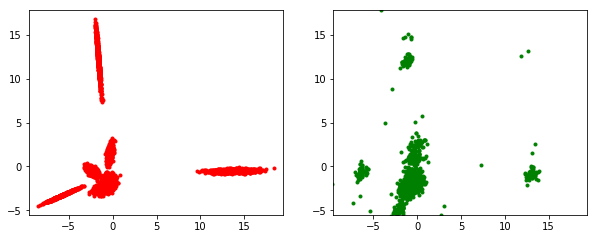

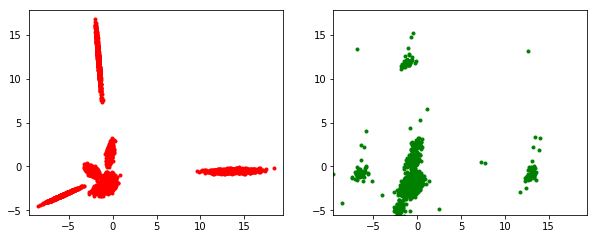

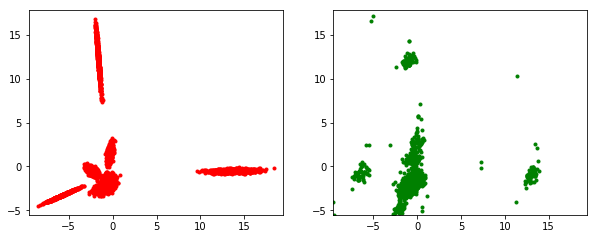

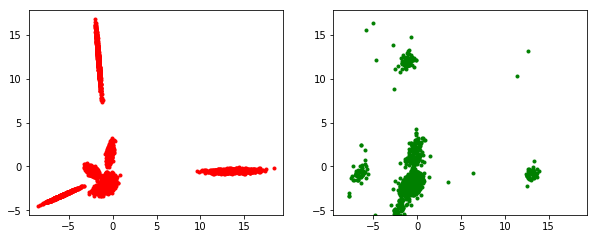

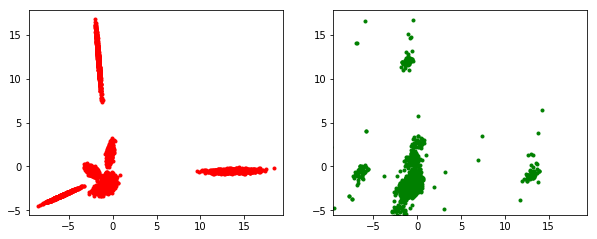

In [70]:
gan.predict(5)